<a href="https://colab.research.google.com/github/FerreiraVini/Diamonds/blob/main/Diamonts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diamonds**

Analyze diamonds by their cut, color, clarity, price, and other attributes


Context
This classic dataset contains the prices and other attributes of almost 54,000 diamonds.

Content
price price in US dollars (\$326--\$18,823)

carat weight of the diamond (0.2--5.01)

cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color diamond colour, from J (worst) to D (best)

clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x length in mm (0--10.74)

y width in mm (0--58.9)

z depth in mm (0--31.8)

depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table width of top of diamond relative to widest point (43--95)

#Import libraries

In [2]:
#for data import
import zipfile
from google.colab import drive
from google.colab import files

#for df handling and graph plots
import pandas as pd
import numpy as np
!pip install tqdm
from tqdm import tqdm
import seaborn as sns
import re
import matplotlib.pyplot as plt
import math
from itertools import combinations
from itertools import product

#for statistical models
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as ltb
from xgboost import XGBRegressor

#for model evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
!pip install shap lightgbm
import shap
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Data import and initial data information

In [3]:
drive.mount('/content/gdrive')

chunksize = 10000 #def the chunksize
n_chunks = int((sum(1 for row in open ('/content/gdrive/MyDrive/Data analysis - study/Diamonds/diamonds.csv', 'r')))/chunksize) #checking the number of chunks, rounding for int value.
print('Number of chunks = ', n_chunks)
fraction = 1/n_chunks
print('Fraction sampled from each chunk = ', fraction)

df_iterator = pd.read_csv('/content/gdrive/MyDrive/Data analysis - study/Diamonds/diamonds.csv', chunksize = chunksize)
counter = 0  # contador
for chunk in tqdm(df_iterator, total=(n_chunks)):
    if counter == 0:
        df = chunk.sample(frac=fraction, random_state = 44) #getting the same proportion of data from each chunk
    else:
        df_aux = chunk.sample(frac=fraction, random_state = 44)
        df = pd.concat([df,df_aux], axis=0)
    if df.shape[0] >= chunksize:
        break
    counter += 1
df = df.reset_index(drop=True)
df = df.drop(df.columns[0], axis='columns')
print('\n', 'df length = ', len(df),'\n')
print('df head:')
print(df.head())
print('\n')
print('df description')
print(df.describe(percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99 ]))
print('\n')
print('df info')
print(df.info())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Number of chunks =  5
Fraction sampled from each chunk =  0.2


 80%|████████  | 4/5 [00:00<00:00, 49.83it/s]


 df length =  10000 

df head:
   carat        cut color clarity  depth  table  price     x     y     z
0   0.76  Very Good     G    VVS2   61.5   59.0   3394  5.83  5.91  3.61
1   1.02  Very Good     J     SI2   62.9   59.0   3755  6.34  6.41  4.01
2   1.09      Ideal     J     SI1   60.7   58.0   4611  6.64  6.68  4.04
3   1.03  Very Good     F     SI2   60.2   55.0   3903  6.53  6.59  3.95
4   0.90  Very Good     D     SI1   62.8   59.0   4466  6.12  6.18  3.86


df description
              carat         depth         table         price             x  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.811628     61.747840     57.432350   4100.742200      5.748925   
std        0.495757      1.432299      2.206691   4177.862649      1.164968   
min        0.200000     44.000000     43.000000    337.000000      0.000000   
1%         0.240000     57.900000     53.000000    431.000000      4.010000   
5%         0.300000     59.300000     5

#Data overview

In [4]:
(df==0).any(axis=0)

carat      False
cut        False
color      False
clarity    False
depth      False
table      False
price      False
x           True
y           True
z           True
dtype: bool

In [5]:
(df=='nan').any(axis=0)

carat      False
cut        False
color      False
clarity    False
depth      False
table      False
price      False
x          False
y          False
z          False
dtype: bool

No NaN values, but some samples shows 0 in x,y,z coordinates. 
As a 3D object, that is highly improbable, so lets consider an error and drop such samples.

For that, I will consider the percentile 0.01 and 0.99 as thresholds, so we drop not only zeros, but also the most extreme values.

In [6]:
min = 1
max = 99
x_min = np.percentile(df['x'], min)
x_max = np.percentile(df['x'], max)
y_min = np.percentile(df['y'], min)
y_max = np.percentile(df['y'], max)
z_min = np.percentile(df['z'], min)
z_max = np.percentile(df['z'], max)

df=df.drop(df[(df['x'] > x_max)].index)
df=df.drop(df[(df['x'] < x_min)].index)
df=df.drop(df[(df['y'] > y_max)].index)
df=df.drop(df[(df['y'] < y_min)].index)
df=df.drop(df[(df['z'] > z_max)].index)
df=df.drop(df[(df['z'] < z_min)].index)

df.reset_index()
df.head()

carat        cut color clarity  depth  table  price     x     y     z
0   0.76  Very Good     G    VVS2   61.5   59.0   3394  5.83  5.91  3.61
1   1.02  Very Good     J     SI2   62.9   59.0   3755  6.34  6.41  4.01
2   1.09      Ideal     J     SI1   60.7   58.0   4611  6.64  6.68  4.04
3   1.03  Very Good     F     SI2   60.2   55.0   3903  6.53  6.59  3.95
4   0.90  Very Good     D     SI1   62.8   59.0   4466  6.12  6.18  3.86

In [7]:
def single_var(df, col):
  if df[col].dtypes != 'object':
    df[col].hist(bins=20)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Distribution of ' + col)
       
  else:
    df.groupby(df[col])[col].count().plot(kind='bar')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Distribution of ' + col)


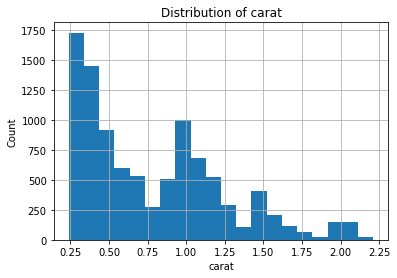

In [8]:
single_var(df, 'carat')

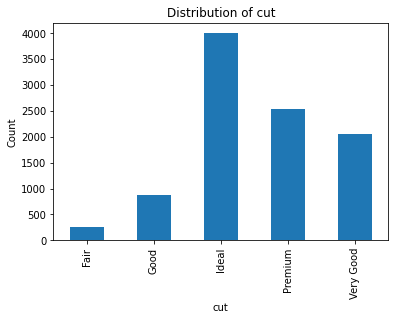

In [9]:
single_var(df, 'cut')

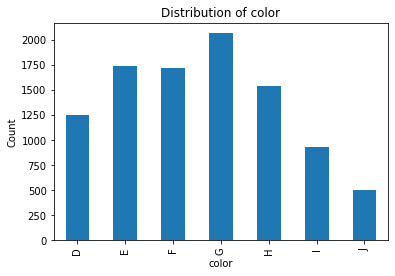

In [10]:
single_var(df, 'color')

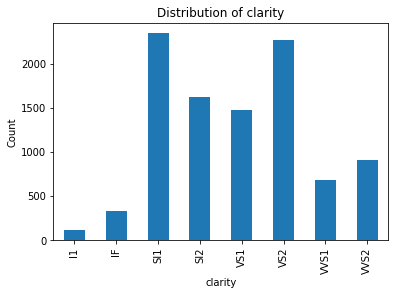

In [11]:
single_var(df, 'clarity')

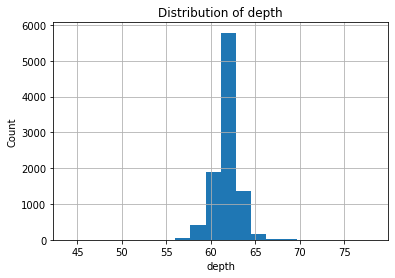

In [12]:
single_var(df, 'depth')

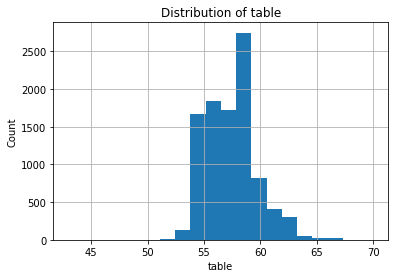

In [13]:
single_var(df, 'table')

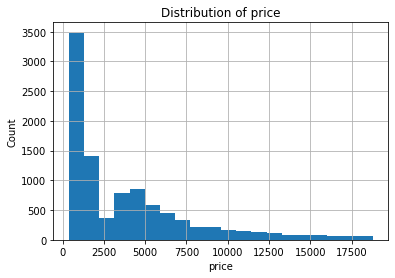

In [14]:
single_var(df, 'price')

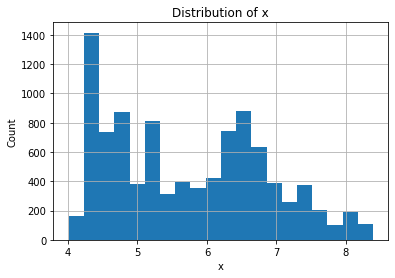

In [15]:
single_var(df, 'x')

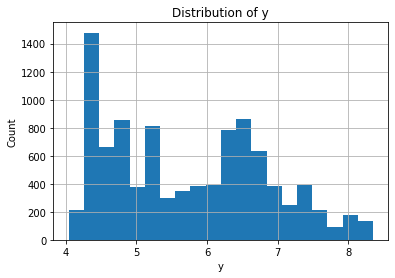

In [16]:
single_var(df, 'y')

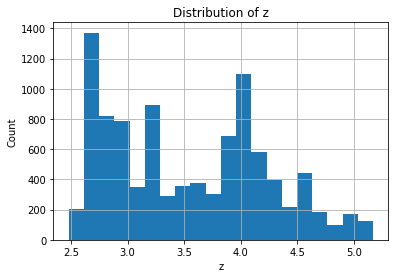

In [17]:
single_var(df, 'z')

Now we have a df with no missing or extreme values.

Note that Carat distributions seems to follow a pattern.

At price 2500 we have a strange drop in counts. For some reason seems to be more dificult to have diamonts of this specifical price

#Size, color, clarity and cut EDA

Initially, we could verify obvious correlations.
As we have a few categorical variables, we could do an encoding. For example, the cut quality, besides beeing categorical, has a quantitative information. The higher the quality, the better.

Clarity has a similar behaviour.

For the color we could do latter a dummy encoding for model buildup, but we could verify fist if we have a correlation between price and color.

In [18]:
#transforming cut and clarity in numerical data.
df['cut_quality'] = 0
for index, row in tqdm(df.iterrows()):
  if row['cut'] == 'Fair':
    quality = 1
  elif row['cut'] == 'Good':
    quality = 2
  elif row['cut'] == 'Very Good':
    quality = 3
  elif row['cut'] == 'Premium':
    quality = 4
  else:
    quality = 5
  df.at[index, 'cut_quality'] = quality
  
df['clarity_quality'] = 0
for index, row in tqdm(df.iterrows()):
  if row['clarity'] == 'I1':
    quality = 1
  elif row['clarity'] == 'SI2':
    quality = 2
  elif row['clarity'] == 'SI1':
    quality = 3
  elif row['clarity'] == 'VS2':
    quality = 4
  elif row['clarity'] == 'VS1':
    quality = 5
  elif row['clarity'] == 'VVS2':
    quality = 6
  elif row['clarity'] == 'VVS1':
    quality = 7
  else:
    quality = 8
  df.at[index, 'clarity_quality'] = quality
df = df.drop(['cut', 'clarity'], axis='columns')

9733it [00:00, 17692.77it/s]
9733it [00:00, 18360.81it/s]


In [19]:
#verifying the correlations
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

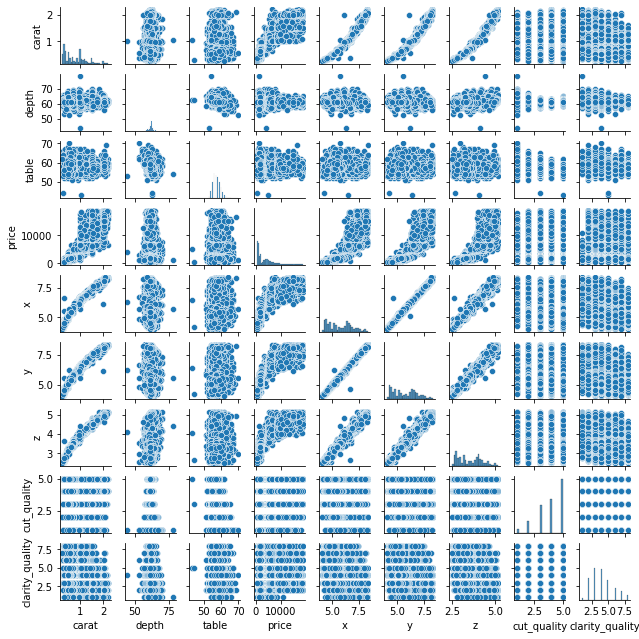

In [21]:
sns.pairplot(data=df, height=1)
plt.show()

Price and size relative columns are obviously correlated.
Color, cut quality and clarity quality aparently has no direct effect in price. However, could be that between diamonts of similar size, color, cut and clarity have an effect.

For a better evaluation and visualization lets separate the samples by carat percentile, and see if in between each group of size, we have an effect of cut and clarity quality in price.

In [22]:
#generating a new feature based in size quartile.
threshold_1 = 25
threshold_2 = 50
threshold_3 = 75
first_per = np.percentile(df['carat'], threshold_1)
second_per = np.percentile(df['carat'], threshold_2)
third_per = np.percentile(df['carat'], threshold_3)

df['size_quartile'] = 0
for index, row in tqdm(df.iterrows()):
  if row['carat'] <= first_per:
    size = 1
  elif row['carat'] <= second_per:
    size = 2
  elif row['carat'] <= third_per:
    size = 3
  elif row['carat'] > third_per:
    size = 4
  df.at[index, 'size_quartile'] = size

9733it [00:00, 18273.70it/s]


In [23]:
def boxplot(x, y, quartile, ax):
   if quartile == 'none':
    sns.boxplot(x=x, y=y, order=('G', 'J', 'F', 'D', 'E', 'H', 'I'),data=df, ax=ax)
    ax.set_title('Size distribution by color')
   else:
    sns.boxplot(x=x, y=y, order=('G', 'J', 'F', 'D', 'E', 'H', 'I'), data=df.query(f'size_quartile == {quartile}'), ax=ax)
    ax.set_title(f'Size distribution, in quartile "{quartile}", by color')

def barplot_var(x, y, hue, ax):
  if hue != 'none':
    sns.barplot(x=x, y=y, hue=hue, data=df, estimator=np.mean, ax=ax)
    ax.set_title(f'{y} distribution per {x} and {hue}')
  else:
    sns.barplot(x=x, y=y, data=df, estimator=np.mean, ax=ax)
    ax.set_title(f'{y} distribution per {x}')

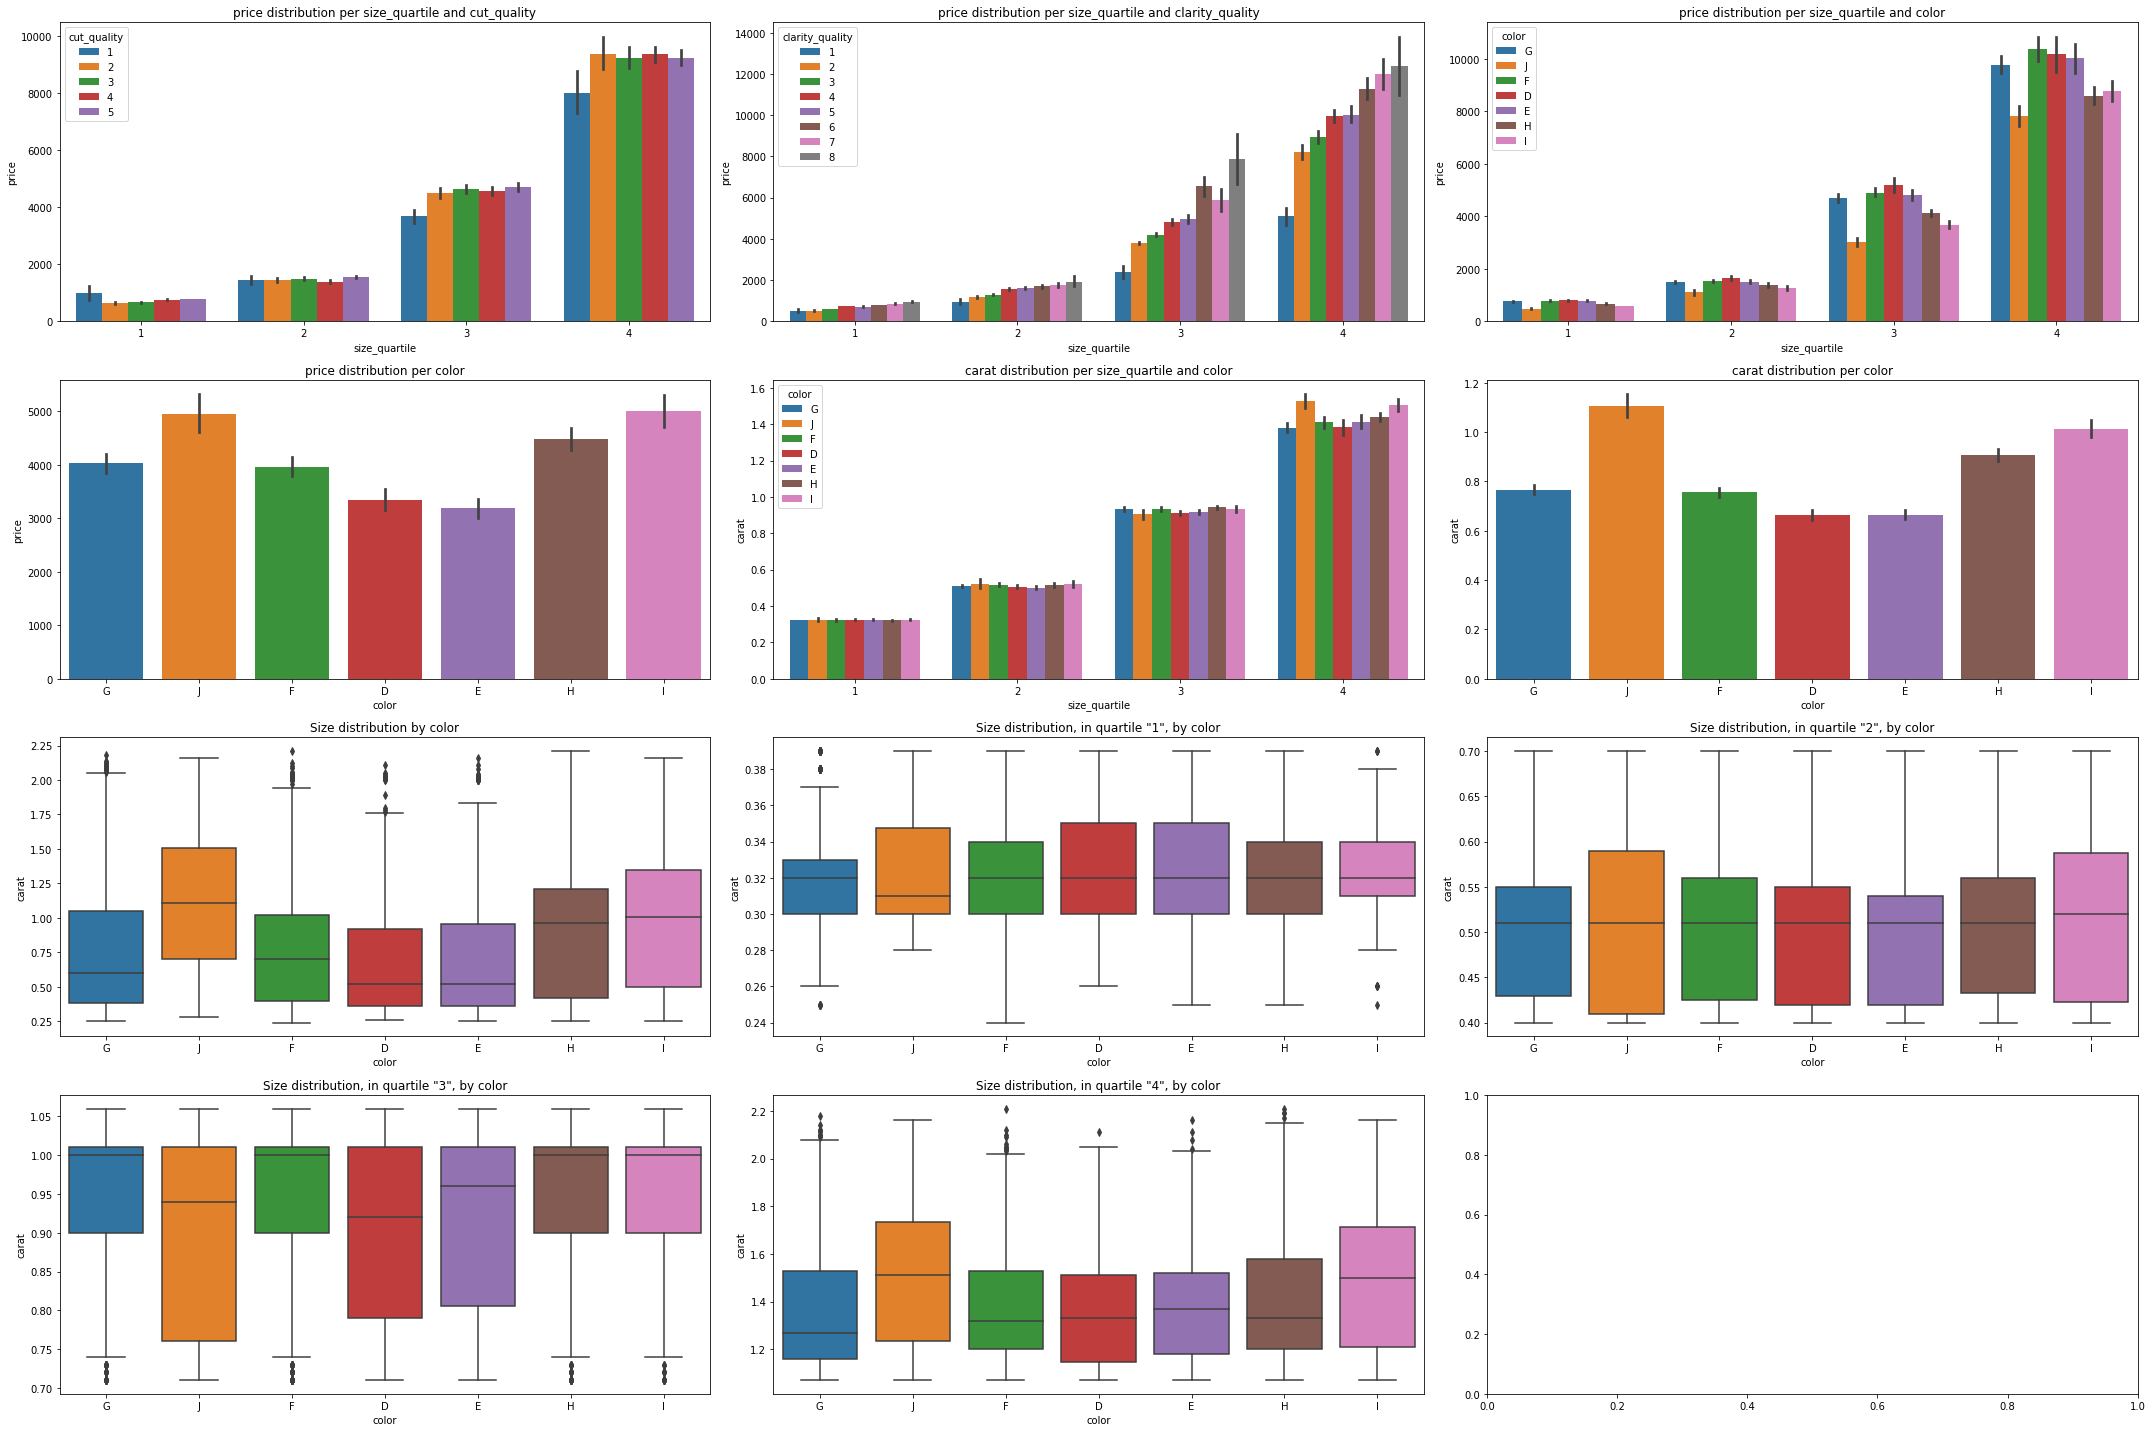

In [24]:
#verifying correlation between price and cut, color and clarity in similar sized diamonds.
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(30,20))

barplot_var('size_quartile', 'price', 'cut_quality', ax1)
barplot_var('size_quartile', 'price', 'clarity_quality', ax2)
barplot_var('size_quartile', 'price', 'color', ax3)
barplot_var('color', 'price', 'none', ax4)
barplot_var('size_quartile', 'carat', 'color', ax5)
barplot_var('color', 'carat', 'none', ax6)
boxplot('color', 'carat', 'none', ax7)
boxplot('color', 'carat', 1, ax8)
boxplot('color', 'carat', 2, ax9)
boxplot('color', 'carat', 3, ax10)
boxplot('color', 'carat', 4, ax11)

plt.tight_layout()
plt.show()

From the above graphs:

- Almost no price gain for overall cut_quality (despite a lower price for poor cut)
- high effect of clarity on price, particularly for bigger diamonds.
- Some colors shows lower prices. But that could be due to different sample distribution between colors, such as different sizes and clarity.

- J shows the lowest price average in higher quartiles, but when looking for color average price, J has one of the highest. That is probably due to J size distribution. It probably has a higher average size, so the prices tend to be higher. The graph of size distribution (overal and per quartiles) enforces this theory.

- D and E have the lowest average prices per color, and we can see that those colors have a lower average diamond size.

Therefore, a good measure would be price/carat, correcting the size effect on price.

In [25]:
def price_carat_color (color_type):
  new_df = df.query(f'color == "{color_type}"')
  price_carat = round((new_df['price'].sum())/new_df['carat'].sum(), 2)
  return(price_carat)

In [26]:
price_carat_color_comparison = {'Color': ['D','E', 'F', 'G', 'H', 'I', 'J'], 'price/carat/color#': [price_carat_color('D'), price_carat_color('E'), price_carat_color('F'), price_carat_color('G'),
                                                                                                    price_carat_color('H'), price_carat_color('I'), price_carat_color('J')]}
price_carat_color_comparison_df = pd.DataFrame(price_carat_color_comparison).set_index('Color')
print(price_carat_color_comparison_df)

       price/carat/color#
Color                    
D                 5038.30
E                 4786.25
F                 5235.82
G                 5254.44
H                 4933.68
I                 4939.06
J                 4474.98


- as expected, J has the lowest average price/size.
- H and I shows similar prices, but a bit higher than J, which is expected, as they have similar average price, but lower average size.
- F and G shows the highest price/size, which is expected, as they have high average prices and low average sizes.
- E has the second lowest price/size, which is also expected, since it has a low average price and low average size.
- D, however, has a higher price/size than E, besides a similar behaviour in average price and average size as E.

A possible explanation of D behaviour would be concearning the clarity.

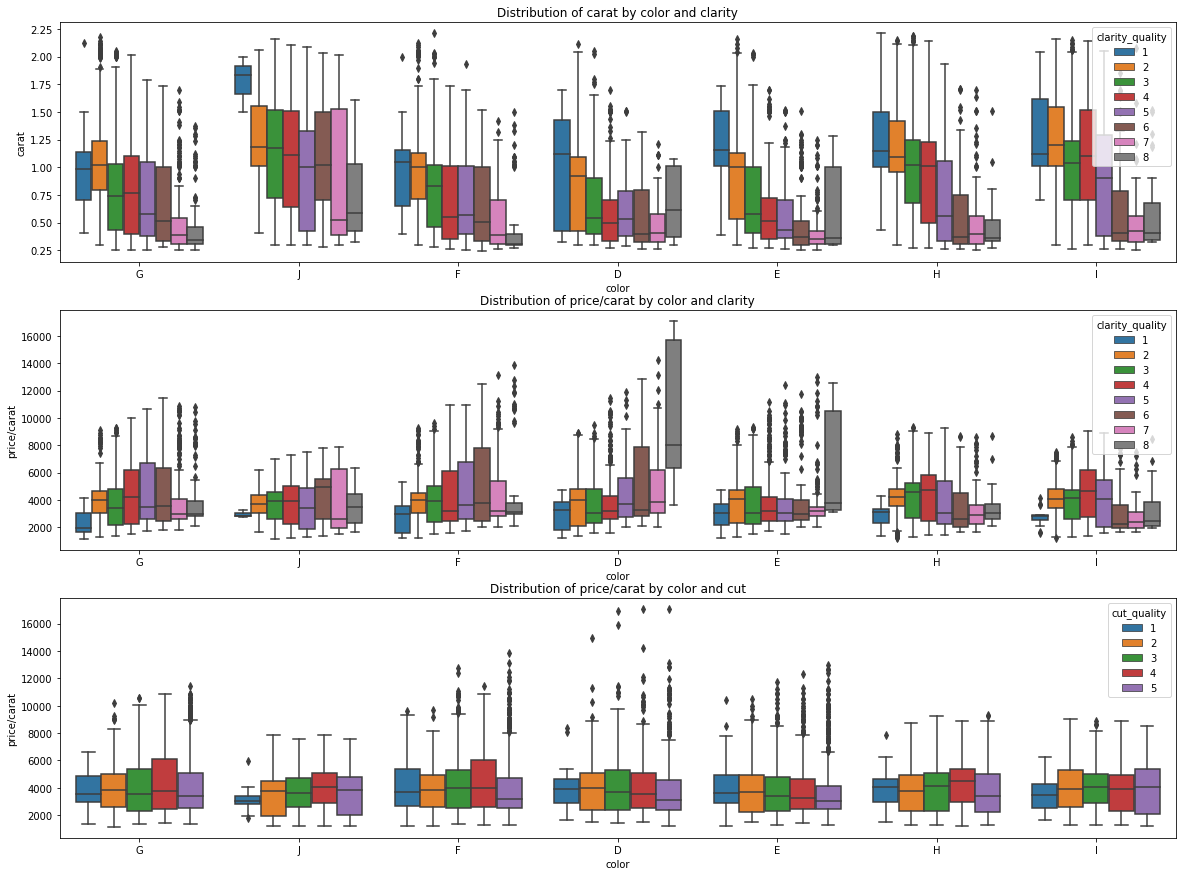

In [27]:
df2=df.copy()
df2['price/carat'] = round((df2['price'])/df2['carat'], 2)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,15))

sns.boxplot(x='color', y='carat', hue = 'clarity_quality', order=('G', 'J', 'F', 'D', 'E', 'H', 'I'), data=df2, ax=ax1)
ax1.set_title('Distribution of carat by color and clarity')

sns.boxplot(x='color', y='price/carat', hue = 'clarity_quality', order=('G', 'J', 'F', 'D', 'E', 'H', 'I'), data=df2, ax=ax2)
ax2.set_title('Distribution of price/carat by color and clarity')

sns.boxplot(x='color', y='price/carat', hue = 'cut_quality', order=('G', 'J', 'F', 'D', 'E', 'H', 'I'), data=df2, ax=ax3)
ax3.set_title('Distribution of price/carat by color and cut')

plt.show()

As expected, clarity has a higher effect in diamonds of color D than on E.
Additionally, diamonds of color D may have a higher number of high clarity than the others.

In [28]:
def clarity_color(color_type, ax):
  newdf = df.query(f'color == "{color_type}"')
  sns.countplot(x='clarity_quality', data=newdf, ax=ax)
  ax.set_title(f'Clarity quality count for color = "{color_type}"')

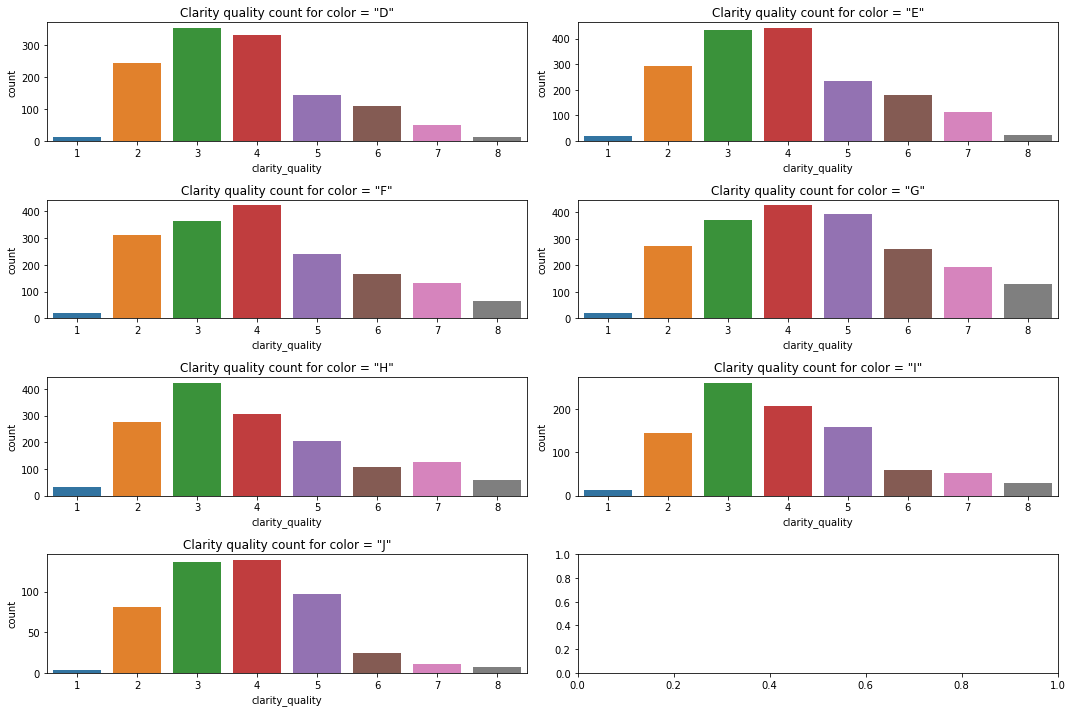

In [29]:
fig, ((ax, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 10))
clarity_color('D', ax)
clarity_color('E', ax2)
clarity_color('F', ax3)
clarity_color('G', ax4)
clarity_color('H', ax5)
clarity_color('I', ax6)
clarity_color('J', ax7)

plt.tight_layout()
plt.show()

- color D and E has a similar number of high clarity diamonds. So the higher average price/size of D diamonds, and the higher average price/size of color D and high clarity can only be explained by a higher market value. Perhaps associated with buyers preference, instead of a demand/offer question.

- G color has higher proportion of high clarity diamonds. Therefore, as G and F have a similar average price/size, the overall market value of clear G diamonds is slightly lower than diamonds F.

That means a good feature would be calculate the average price per size, per color and per clarity, and attribute for each diamond the average price per size acordingly to its color and clarity. this tends to be more accurate than simply price/size calculation.

In [30]:
def price_carat_color_and_clarity (color_type, clarity_type):
  new_df = df.query(f'color == "{color_type}"')
  new_df2 = new_df.query(f'clarity_quality == {clarity_type}')
  price_carat_color_clarity = round((new_df2['price'].sum())/new_df2['carat'].sum(), 2)
  return(price_carat_color_clarity)

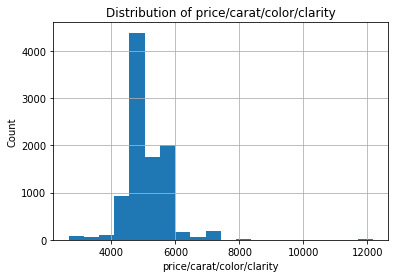

In [31]:
df['price/carat/color/clarity'] = df.apply(lambda row: price_carat_color_and_clarity(color_type=row['color'], clarity_type=row['clarity_quality']), axis=1)
single_var(df, 'price/carat/color/clarity')

Now we have a feature that corresponds to average market value based on size, color and clarity.

Note that the highest value of this features stands for diamonds color D and clarity 8, with value of > 12,000.00 dollars per carat, 30% more than the second highest price.

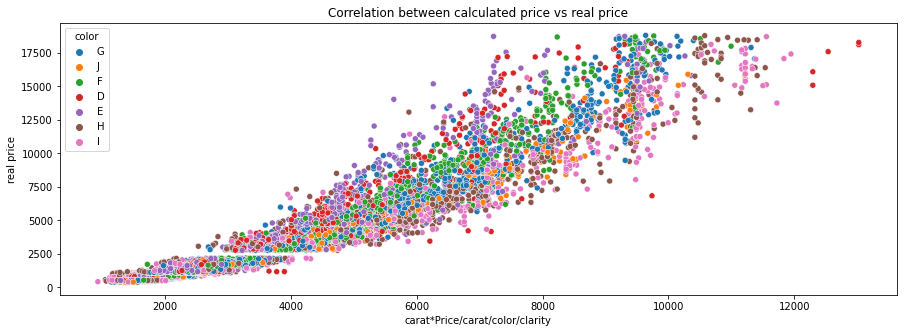

In [32]:
fig, (ax1) = plt.subplots(1, figsize=(15,5))
sns.scatterplot(x=df['carat']*df['price/carat/color/clarity'], y=df['price'], hue='color', data=df, ax=ax1)
ax1.set_title('Correlation between calculated price vs real price')
ax1.set_xlabel('carat*Price/carat/color/clarity')
ax1.set_ylabel('real price')
plt.show()

- just with this feature we have already a fair correlation between real price and calculated based on this feature alone.

- we can create a feature based on those constants * carat, as we already have the constant and will have the carat of the diamond.

In [33]:
#df['ccc_mean_price*carat'] = df['carat']*df['price/carat/color/clarity'] # ccc_mean_price stands for color, clarity, carat mean price - we may drop the constant now, since it was already used.

In [34]:
df = df.drop(['size_quartile'], axis='columns') #we already have size information, and particioning the sizes was only useful for visualization, not useful for the model.

#Shape EDA

Another interesting aspect to evaluate would be the diamonds shape.

In [35]:
def scatter_plot(x, y, hue, ax):
  if hue != 'none':
    sns.scatterplot(x=x, y=y, hue=hue, data=df, ax=ax)
    ax.set_title(f' "y" distribution per {x} and {hue}')
    ax.set_ylabel(f'"y"')
    ax.set_xlabel(f'"{x}"')
  else:
    sns.scatterplot(x=x, y=y, data=df, ax=ax)
    ax.set_title(f'"y" distribution per {x}')
    ax.set_ylabel(f'"y"')
    ax.set_xlabel(f'"{x}"')

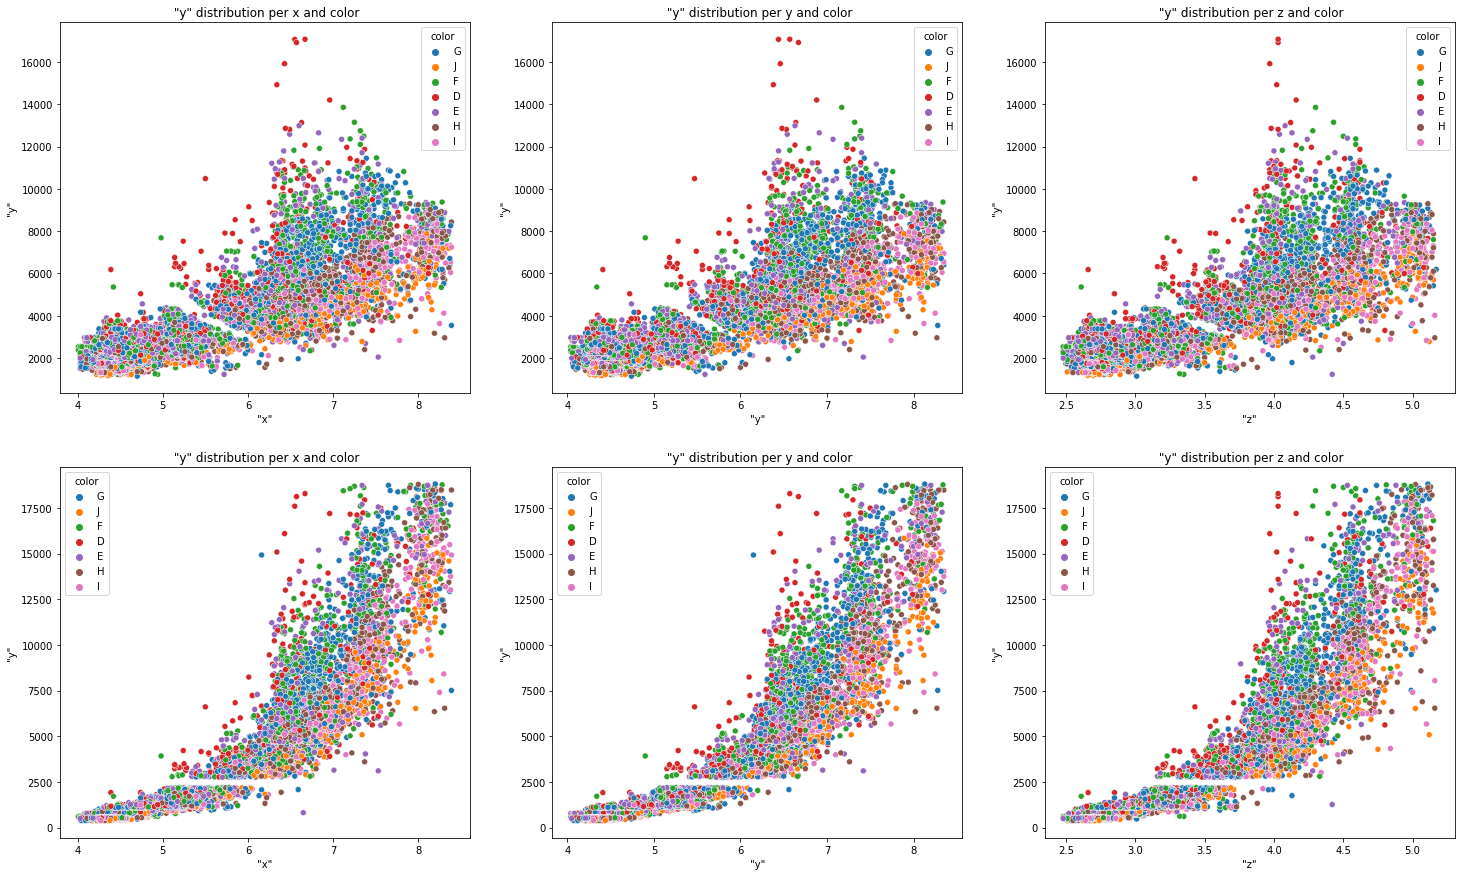

In [36]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25,15))
scatter_plot('x', df['price']/df['carat'], 'color', ax1)
scatter_plot('y', df['price']/df['carat'], 'color', ax2)
scatter_plot('z', df['price']/df['carat'], 'color', ax3)

scatter_plot('x', 'price', 'color', ax4)
scatter_plot('y', 'price', 'color', ax5)
scatter_plot('z', 'price', 'color', ax6)
plt.show()

The above graphs shows, again, that color and size is highly correlated to price. However, are shape of the diamonds relevant to price?

One initial way to evaluate this is to verify which diamonds are spherical and which is not, and see if is there a price correlation.

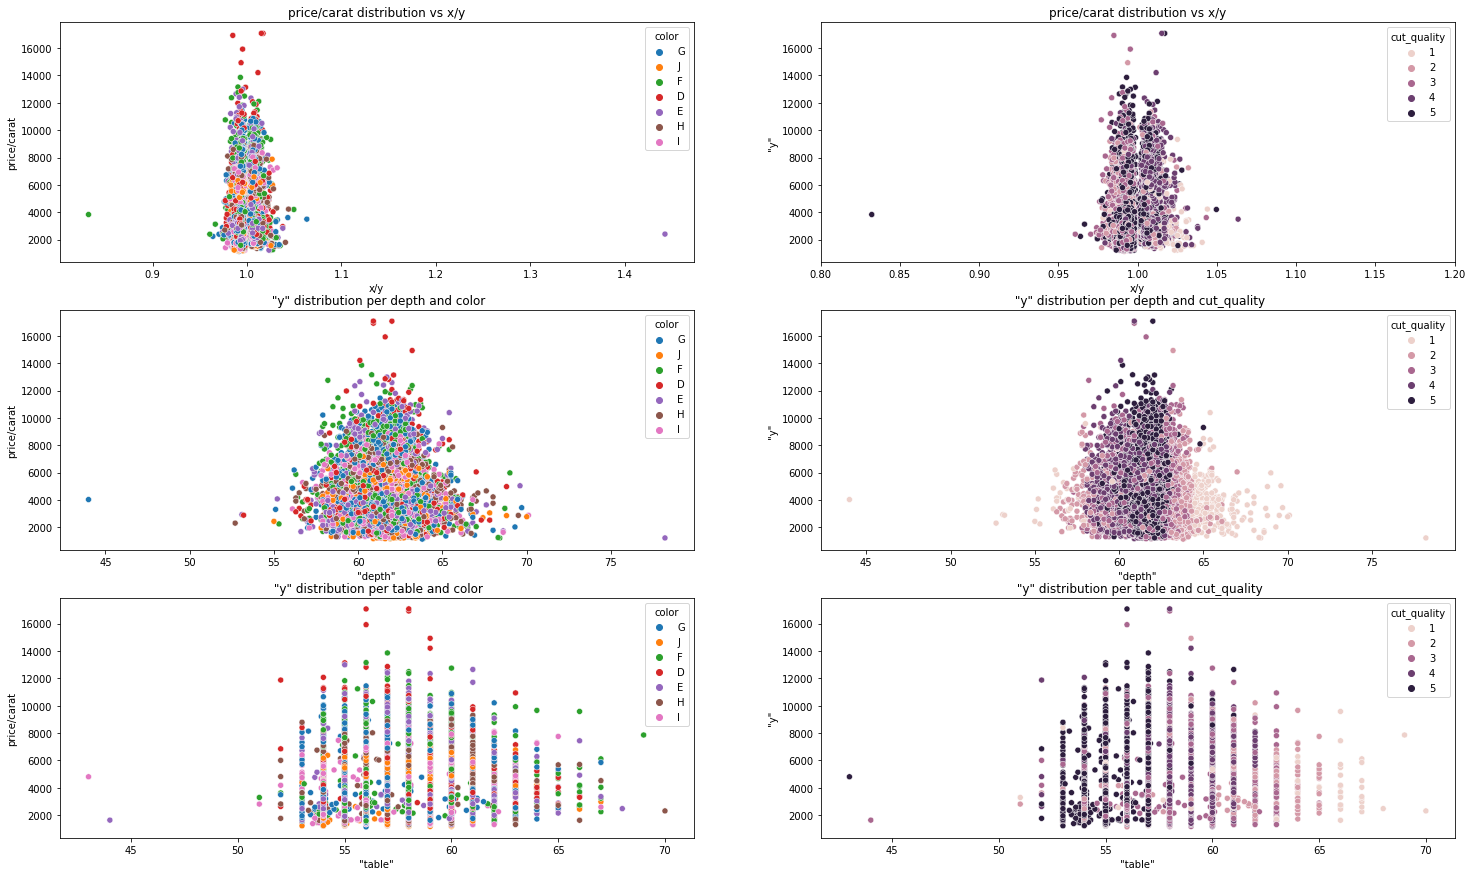

In [37]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(25,15))
scatter_plot(df['x']/df['y'], df['price']/df['carat'], 'color', ax1) #if the diamond is oval shaped, or retangular, x/y will be != 1.
ax1.set_xlabel('x/y')
ax1.set_ylabel('price/carat')
ax1.set_title('price/carat distribution vs x/y')

scatter_plot(df['x']/df['y'], df['price']/df['carat'], 'cut_quality', ax2)
ax2.set_xlim(0.8, 1.2)
ax2.set_xlabel('x/y')
ax2.set_title('price/carat distribution vs x/y')

scatter_plot('depth', df['price']/df['carat'], 'color', ax3)
ax3.set_ylabel('price/carat')

scatter_plot('depth', df['price']/df['carat'], 'cut_quality', ax4)

scatter_plot('table', df['price']/df['carat'], 'color', ax5)
ax5.set_ylabel('price/carat')

scatter_plot('table', df['price']/df['carat'], 'cut_quality', ax6)

plt.show()

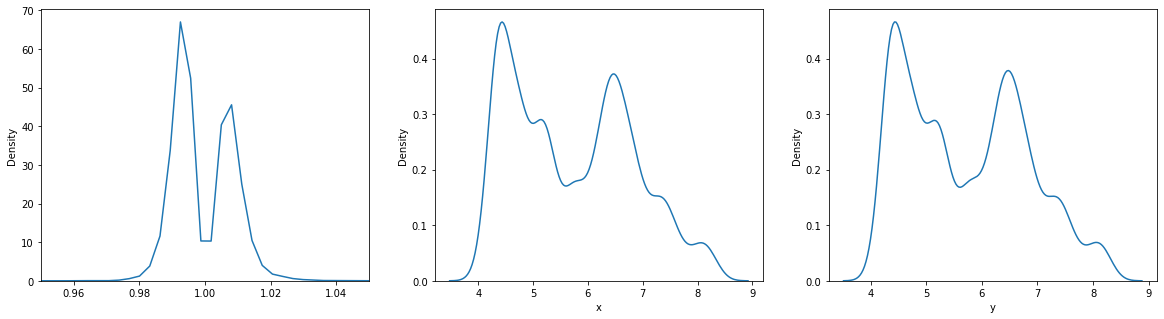

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

sns.kdeplot(x=df['x']/df['y'], ax=ax1)
ax1.set_xlim(0.95, 1.05)

sns.kdeplot(x=df['x'], ax=ax2)

sns.kdeplot(x=df['y'], ax=ax3)

plt.show()

There is no clear correlation between shape and diamond price. Cut quality is shown again to not be much impacting.

We do see a correlation between table, depth and cut quality, with price. all of them shows a better price in a specific range. 

- the KDE plots shows that all the diamonds have a spherical shape. Most of them are not PERFECLY circular, x/y = 1, but they are close to it.


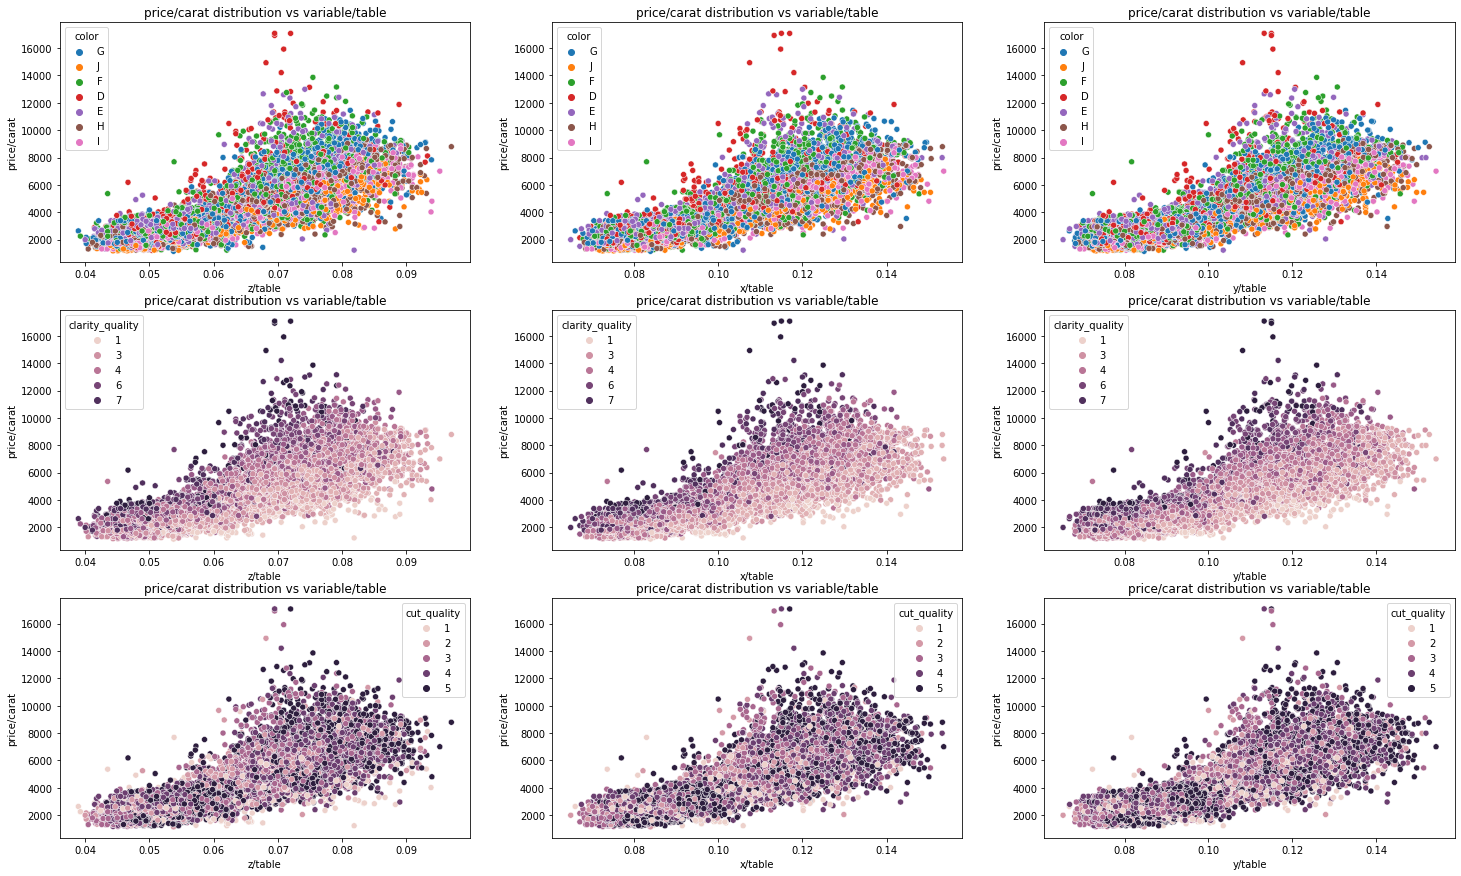

In [39]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(25, 15))
scatter_plot(df['z']/df['table'], df['price']/df['carat'], 'color', ax1) #proportion of table per depth effect in price
ax1.set_xlabel('z/table')
ax1.set_ylabel('price/carat')
ax1.set_title('price/carat distribution vs variable/table')

scatter_plot(df['x']/df['table'], df['price']/df['carat'], 'color', ax2)
ax2.set_xlabel('x/table')
ax2.set_ylabel('price/carat')
ax2.set_title('price/carat distribution vs variable/table')

scatter_plot(df['y']/df['table'], df['price']/df['carat'], 'color', ax3)
ax3.set_xlabel('y/table')
ax3.set_ylabel('price/carat')
ax3.set_title('price/carat distribution vs variable/table')

scatter_plot(df['z']/df['table'], df['price']/df['carat'], 'clarity_quality', ax4)
ax4.set_xlabel('z/table')
ax4.set_ylabel('price/carat')
ax4.set_title('price/carat distribution vs variable/table')

scatter_plot(df['x']/df['table'], df['price']/df['carat'], 'clarity_quality', ax5)
ax5.set_xlabel('x/table')
ax5.set_ylabel('price/carat')
ax5.set_title('price/carat distribution vs variable/table')

scatter_plot(df['y']/df['table'], df['price']/df['carat'], 'clarity_quality', ax6)
ax6.set_xlabel('y/table')
ax6.set_ylabel('price/carat')
ax6.set_title('price/carat distribution vs variable/table')

scatter_plot(df['z']/df['table'], df['price']/df['carat'], 'cut_quality', ax7)
ax7.set_xlabel('z/table')
ax7.set_ylabel('price/carat')
ax7.set_title('price/carat distribution vs variable/table')

scatter_plot(df['x']/df['table'], df['price']/df['carat'], 'cut_quality', ax8)
ax8.set_xlabel('x/table')
ax8.set_ylabel('price/carat')
ax8.set_title('price/carat distribution vs variable/table')

scatter_plot(df['y']/df['table'], df['price']/df['carat'], 'cut_quality', ax9)
ax9.set_xlabel('y/table')
ax9.set_ylabel('price/carat')
ax9.set_title('price/carat distribution vs variable/table')

plt.show()

Aparently there is a correlation between the proportion of table/coordinate and price per carat.

As we used price/carat, the effect is not refferent to size.
however, table is already a measurement based on x, y, so there is no much sense using this info.

but z/table makes sense.

In [40]:
df['z_table'] = df['z']/df['table']

#Predictions

##define metrics

In [41]:
model_metrics = {} # dict to append all the models metrics

def metrics(model):
  metrics = {}
  real = y_test
  predicted = model.predict(X_test)

  MSE = mean_squared_error(real, predicted)
  MRSE = np.sqrt(MSE.mean())
  MAE = mean_absolute_error(real, predicted)
  MAPE = (MAE/(np.mean(real)))*100
  r2 = r2_score(real, predicted)
  metrics['MSE'] = round(MSE, 2)
  metrics['RMSE'] = round(MRSE, 2)
  metrics['MAE'] = round(MAE, 2)
  metrics['MAPE'] = round(MAPE, 2)
  metrics['r2'] = round(r2, 2)
  return metrics

def plot_result(model):
  eval_df = pd.DataFrame(y_test)
  eval_df['predicted'] = model.predict(X_test)
  fig, (ax) = plt.subplots(1, figsize=(25,5))
  sns.scatterplot(x='price', y='predicted', data=eval_df, ax=ax)
  ax.set_ylabel('Predicted price')
  ax.set_xlabel('Real price')
  ax.set_title('Predicted vs. real price')
  ax.axline((0, 0), slope=1, color="k", linestyle=(0, (5, 5)))
  ax.legend(['predicted', 'slope 1 line - perfect prediction'])

  plt.show()


##Color encoding

As color has been proved to show an attribute related to "quality", or "value", we can also attribute a number to it, referent to the color agregated value, similarly to what we have done to cut and clarity.

In [42]:
df['color_quality'] = 0
for index, row in tqdm(df.iterrows()):
  if row['color'] == 'J':
    quality = 1
  elif row['color'] == 'I':
    quality = 2
  elif row['color'] == 'H':
    quality = 3
  elif row['color'] == 'G':
    quality = 4
  elif row['color'] == 'F':
    quality = 5
  elif row['color'] == 'E':
    quality = 6
  elif row['color'] == 'D':
    quality = 7

  df.at[index, 'color_quality'] = quality
df = df.drop(['color'], axis='columns')
df.info()

9733it [00:01, 7660.00it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9733 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   carat                      9733 non-null   float64
 1   depth                      9733 non-null   float64
 2   table                      9733 non-null   float64
 3   price                      9733 non-null   int64  
 4   x                          9733 non-null   float64
 5   y                          9733 non-null   float64
 6   z                          9733 non-null   float64
 7   cut_quality                9733 non-null   int64  
 8   clarity_quality            9733 non-null   int64  
 9   price/carat/color/clarity  9733 non-null   float64
 10  z_table                    9733 non-null   float64
 11  color_quality              9733 non-null   int64  
dtypes: float64(8), int64(4)
memory usage: 1.2 MB


In [43]:
#df_dummies_color = pd.get_dummies(df['color'], prefix='Is_color')
#df = pd.concat([df, df_dummies_color], axis=1)
#df = df.drop(['color'], axis='columns')
#df.info()

##Data split

In [44]:
x = df.drop(['price'], axis = 1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=44)

##Naive model

{'MSE': 16580446.58, 'RMSE': 4071.91, 'MAE': 3104.28, 'MAPE': 77.41, 'r2': -0.0}


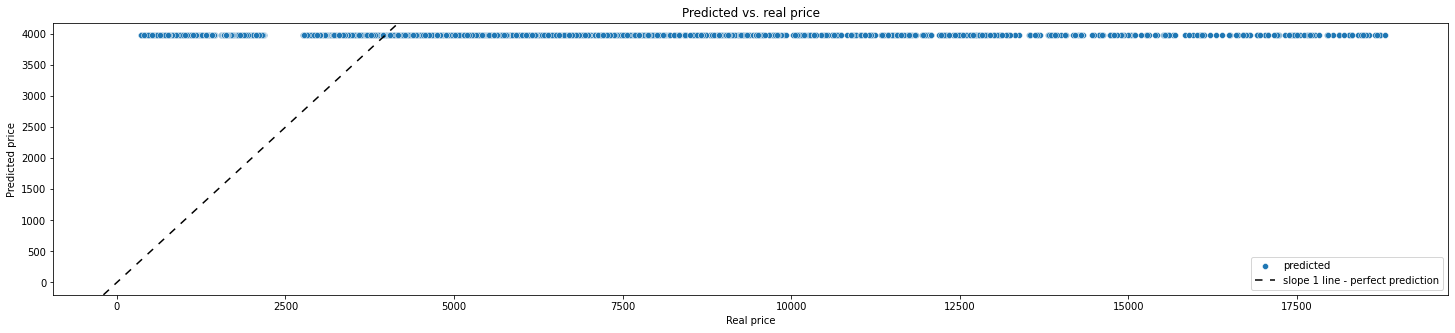

In [45]:
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)
model_metrics['naive_model']= metrics(dummy_regr)
print(metrics(dummy_regr))
plot_result(dummy_regr)

##Linear Regression

{'MSE': 1329352.41, 'RMSE': 1152.98, 'MAE': 769.0, 'MAPE': 19.18, 'r2': 0.92}


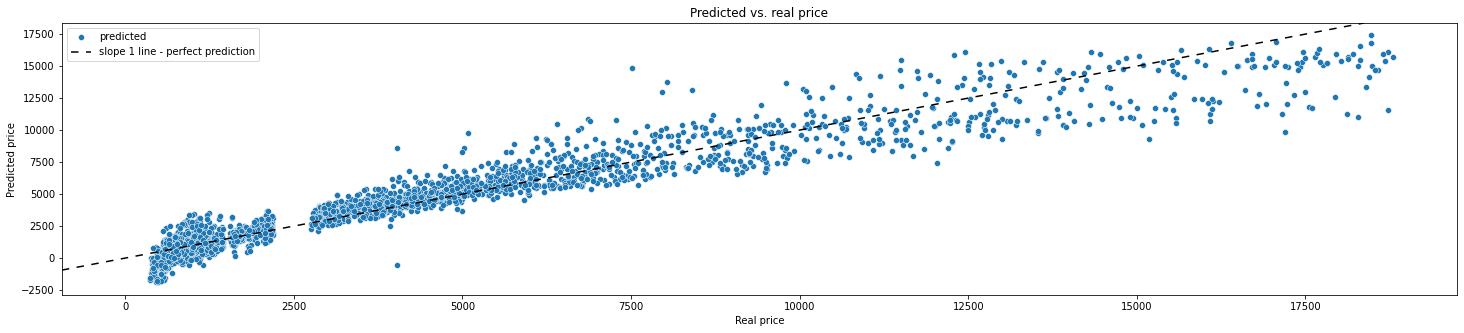

In [46]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
model_metrics['Linear_regression'] = metrics(model_lr)
print(metrics(model_lr))
plot_result(model_lr)

##Random Forest

{'MSE': 430186.62, 'RMSE': 655.89, 'MAE': 360.3, 'MAPE': 8.99, 'r2': 0.97}


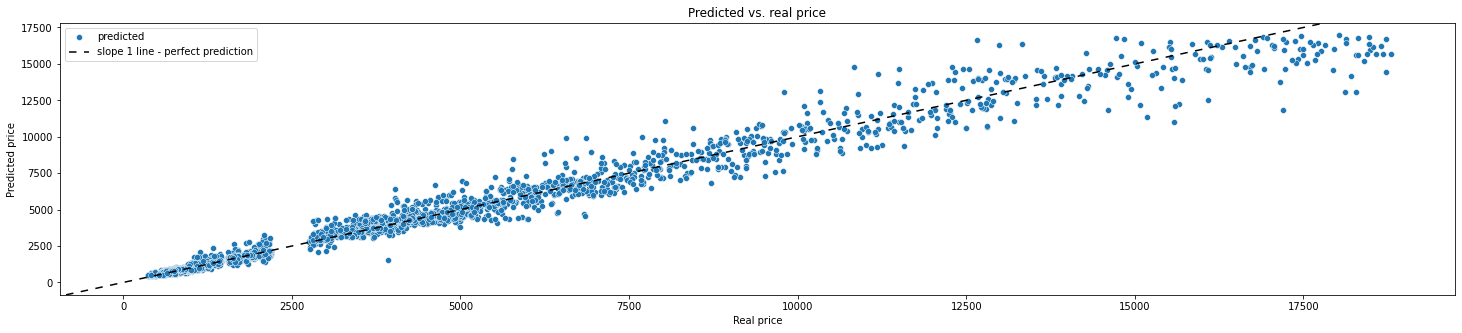

In [47]:
model_rf = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
model_rf.fit(X_train, y_train)
model_metrics['Random_forest'] = metrics(model_rf)
print(metrics(model_rf))
plot_result(model_rf)

##XGBoost

{'MSE': 346526.32, 'RMSE': 588.66, 'MAE': 308.4, 'MAPE': 7.69, 'r2': 0.98}


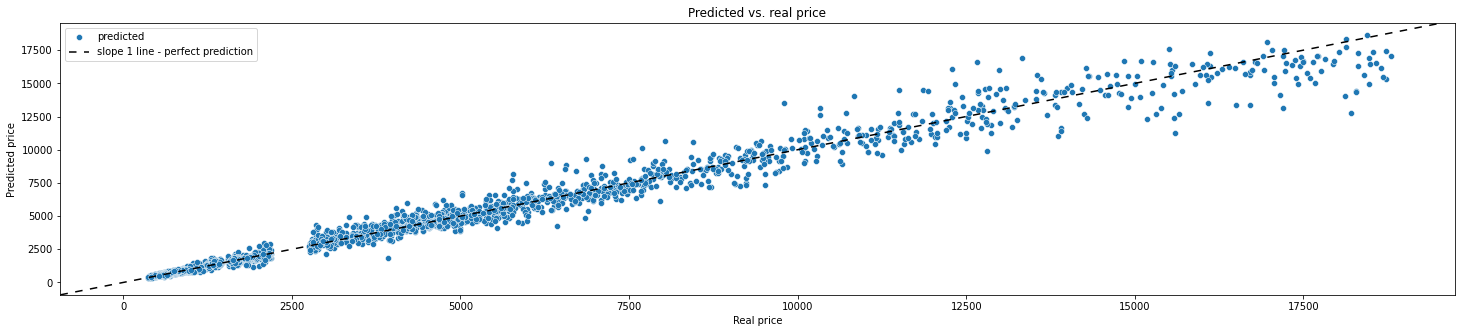

In [48]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
model_metrics['XGBoost'] = metrics(model_xgb)
print(metrics(model_xgb))
plot_result(model_xgb)

##LightGBM


{'MSE': 345096.44, 'RMSE': 587.45, 'MAE': 309.11, 'MAPE': 7.71, 'r2': 0.98}


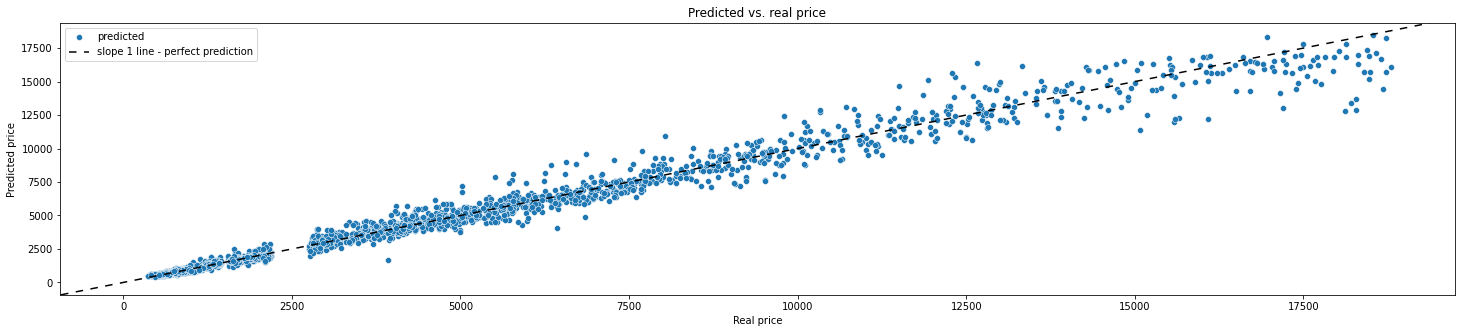

In [49]:
model_ltb = ltb.LGBMRegressor(objective='rmse')
model_ltb.fit(X_train, y_train)
model_metrics['LightGBM'] = metrics(model_ltb)
print(metrics(model_ltb))
plot_result(model_ltb)

We can see the features importances for the model:

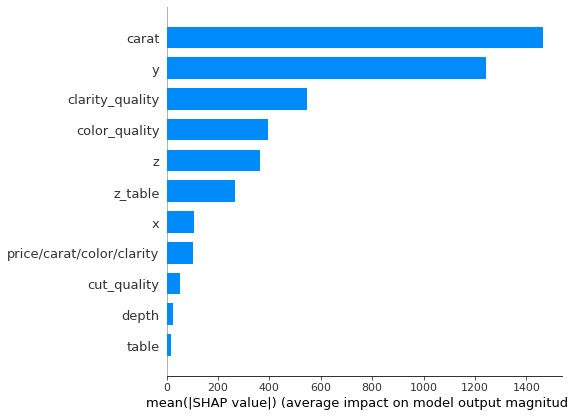

In [50]:
explainer = shap.TreeExplainer(model_ltb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar', feature_names=X_test.columns.tolist())

#MODELS OVERVIEW

In [51]:
models_df = pd.DataFrame(model_metrics)
models_df

naive_model  Linear_regression  Random_forest    XGBoost   LightGBM
MSE   16580446.58         1329352.41      430186.62  346526.32  345096.44
RMSE      4071.91            1152.98         655.89     588.66     587.45
MAE       3104.28             769.00         360.30     308.40     309.11
MAPE        77.41              19.18           8.99       7.69       7.71
r2          -0.00               0.92           0.97       0.98       0.98

We can see that LightGBM and XGBoost are the models with lowest MAPE, therefore, the most suited models for price estimative. However, LightGBM is faster to run in bigger datasets.

We can see that the errors are higher for high priced diamonds, which was expected, since we had less samples for data trainning.

We could improve the model, running an optimization on LightGBM parameters.

#Best Model Tuning

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3414.71	valid_1's rmse: 3285.32
[2]	valid_0's rmse: 2896.44	valid_1's rmse: 2767.44
[3]	valid_0's rmse: 2552.09	valid_1's rmse: 2416.29
[4]	valid_0's rmse: 2280.94	valid_1's rmse: 2146.95
[5]	valid_0's rmse: 2100.38	valid_1's rmse: 1965.11
[6]	valid_0's rmse: 1952.03	valid_1's rmse: 1811.13
[7]	valid_0's rmse: 1835.91	valid_1's rmse: 1700.99
[8]	valid_0's rmse: 1768.46	valid_1's rmse: 1630.83
[9]	valid_0's rmse: 1705.42	valid_1's rmse: 1570.25
[10]	valid_0's rmse: 1664.97	valid_1's rmse: 1528.38
[11]	valid_0's rmse: 1627.46	valid_1's rmse: 1494.67
[12]	vali

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[19]	valid_0's rmse: 1445.2	valid_1's rmse: 1310.62
[20]	valid_0's rmse: 1428.26	valid_1's rmse: 1294.66
[21]	valid_0's rmse: 1411.62	valid_1's rmse: 1280.79
[22]	valid_0's rmse: 1396.6	valid_1's rmse: 1267.13
[23]	valid_0's rmse: 1384.6	valid_1's rmse: 1256.99
[24]	valid_0's rmse: 1370.52	valid_1's rmse: 1242.92
[25]	valid_0's rmse: 1358.75	valid_1's rmse: 1231.73
[26]	valid_0's rmse: 1349.28	valid_1's rmse: 1221.61
[27]	valid_0's rmse: 1337.93	valid_1's rmse: 1211.49
[28]	valid_0's rmse: 1327.5	valid_1's rmse: 1202.68
[29]	valid_0's rmse: 1317.92	valid_1's rmse: 1194.99
[30]	valid_0's rmse: 1310.3	valid_1's rmse: 1186.74
[31]	valid_0's rmse: 1301.19	valid_1's rmse: 1178.81
[32]	valid_0's rmse: 1292.38	valid_1's rmse: 1170.77
[33]	valid_0's rmse: 1286.44	valid_1's rmse: 1164.87
[34]	valid_0's rmse: 1280.63	valid_1's rmse: 1159.1
[35]	valid_0's rmse: 1273.67	valid_1's rmse: 1152.52
[36]	valid_0's rmse: 1268.17	valid_1's rmse: 1148.11
[37]	valid_0's rmse: 1262.56	valid_1's rmse: 1143.1

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[120]	valid_0's rmse: 1163.38	valid_1's rmse: 1050.45
[121]	valid_0's rmse: 1163.3	valid_1's rmse: 1050.16
[122]	valid_0's rmse: 1163.1	valid_1's rmse: 1049.92
[123]	valid_0's rmse: 1163.02	valid_1's rmse: 1049.63
[124]	valid_0's rmse: 1162.42	valid_1's rmse: 1049.35
[125]	valid_0's rmse: 1162.52	valid_1's rmse: 1049.13
[126]	valid_0's rmse: 1161.91	valid_1's rmse: 1048.91
[127]	valid_0's rmse: 1162.09	valid_1's rmse: 1048.72
[128]	valid_0's rmse: 1161.9	valid_1's rmse: 1048.41
[129]	valid_0's rmse: 1161.85	valid_1's rmse: 1048.22
[130]	valid_0's rmse: 1161.27	valid_1's rmse: 1048.17
[131]	valid_0's rmse: 1161.08	valid_1's rmse: 1047.94
[132]	valid_0's rmse: 1161	valid_1's rmse: 1047.67
[133]	valid_0's rmse: 1160.77	valid_1's rmse: 1047.46
[134]	valid_0's rmse: 1160.69	valid_1's rmse: 1047.2
[135]	valid_0's rmse: 1160.25	valid_1's rmse: 1046.98
[136]	valid_0's rmse: 1160.16	valid_1's rmse: 1046.8
[137]	valid_0's rmse: 1160.09	valid_1's rmse: 1046.55
[138]	valid_0's rmse: 1159.91	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[6]	valid_0's rmse: 1947.06	valid_1's rmse: 1807.95
[7]	valid_0's rmse: 1832.16	valid_1's rmse: 1701.49
[8]	valid_0's rmse: 1761.13	valid_1's rmse: 1626.95
[9]	valid_0's rmse: 1696.76	valid_1's rmse: 1567.19
[10]	valid_0's rmse: 1659.06	valid_1's rmse: 1527.74
[11]	valid_0's rmse: 1629.77	valid_1's rmse: 1495.11
[12]	valid_0's rmse: 1605.41	valid_1's rmse: 1469.88
[13]	valid_0's rmse: 1568.8	valid_1's rmse: 1434.89
[14]	valid_0's rmse: 1544.46	valid_1's rmse: 1411.1
[15]	valid_0's rmse: 1520.12	valid_1's rmse: 1388.59
[16]	valid_0's rmse: 1492.95	valid_1's rmse: 1365.36
[17]	valid_0's rmse: 1473.78	valid_1's rmse: 1346.54
[18]	valid_0's rmse: 1453.43	valid_1's rmse: 1324.87
[19]	valid_0's rmse: 1435.94	valid_1's rmse: 1308.11
[20]	valid_0's rmse: 1418.64	valid_1's rmse: 1291.31
[21]	valid_0's rmse: 1406.04	valid_1's rmse: 1278.14
[22]	valid_0's rmse: 1391.46	valid_1's rmse: 1265.04
[23]	valid_0's rmse: 1379.45	valid_1's rmse: 1254.54
[24]	valid_0's rmse: 1366.81	valid_1's rmse: 1242.0

Found `num_iterations` in params. Will use it instead of argument


[88]	valid_0's rmse: 623.473	valid_1's rmse: 406.484
[89]	valid_0's rmse: 623.321	valid_1's rmse: 406.318
[90]	valid_0's rmse: 622.542	valid_1's rmse: 404.966
[91]	valid_0's rmse: 622.62	valid_1's rmse: 404.771
[92]	valid_0's rmse: 622.422	valid_1's rmse: 404.243
[93]	valid_0's rmse: 622.311	valid_1's rmse: 403.988
[94]	valid_0's rmse: 623.548	valid_1's rmse: 402.929
[95]	valid_0's rmse: 623.949	valid_1's rmse: 402.4
[96]	valid_0's rmse: 623.19	valid_1's rmse: 401.982
[97]	valid_0's rmse: 622.968	valid_1's rmse: 401.255
[98]	valid_0's rmse: 622.531	valid_1's rmse: 400.317
[99]	valid_0's rmse: 622.439	valid_1's rmse: 399.94
[100]	valid_0's rmse: 622.11	valid_1's rmse: 399.768
[101]	valid_0's rmse: 621.768	valid_1's rmse: 399.451
[102]	valid_0's rmse: 621.082	valid_1's rmse: 398.559
[103]	valid_0's rmse: 621.593	valid_1's rmse: 397.205
[104]	valid_0's rmse: 622.151	valid_1's rmse: 396.229
[105]	valid_0's rmse: 622.037	valid_1's rmse: 395.378
[106]	valid_0's rmse: 621.254	valid_1's rmse: 

Found `num_iterations` in params. Will use it instead of argument



[55]	valid_0's rmse: 628.346	valid_1's rmse: 437.816
[56]	valid_0's rmse: 628.804	valid_1's rmse: 437.12
[57]	valid_0's rmse: 627.518	valid_1's rmse: 435.177
[58]	valid_0's rmse: 627.748	valid_1's rmse: 434.785
[59]	valid_0's rmse: 627.99	valid_1's rmse: 433.431
[60]	valid_0's rmse: 627.249	valid_1's rmse: 432.842
[61]	valid_0's rmse: 626.486	valid_1's rmse: 431.157
[62]	valid_0's rmse: 626.301	valid_1's rmse: 429.771
[63]	valid_0's rmse: 625.856	valid_1's rmse: 427.852
[64]	valid_0's rmse: 625.439	valid_1's rmse: 426.038
[65]	valid_0's rmse: 625.046	valid_1's rmse: 425.554
[66]	valid_0's rmse: 625.103	valid_1's rmse: 423.718
[67]	valid_0's rmse: 625.661	valid_1's rmse: 421.972
[68]	valid_0's rmse: 624.167	valid_1's rmse: 421.2
[69]	valid_0's rmse: 624.551	valid_1's rmse: 418.498
[70]	valid_0's rmse: 624.552	valid_1's rmse: 416.834
[71]	valid_0's rmse: 625.561	valid_1's rmse: 414.096
[72]	valid_0's rmse: 625.707	valid_1's rmse: 412.87
[73]	valid_0's rmse: 625.263	valid_1's rmse: 411.7

Found `num_iterations` in params. Will use it instead of argument



[27]	valid_0's rmse: 647.971	valid_1's rmse: 502.27
[28]	valid_0's rmse: 647.233	valid_1's rmse: 499.457
[29]	valid_0's rmse: 646.399	valid_1's rmse: 498.247
[30]	valid_0's rmse: 646.309	valid_1's rmse: 496.987
[31]	valid_0's rmse: 644.886	valid_1's rmse: 494.09
[32]	valid_0's rmse: 645.883	valid_1's rmse: 491.515
[33]	valid_0's rmse: 644.649	valid_1's rmse: 486.312
[34]	valid_0's rmse: 644.086	valid_1's rmse: 484.329
[35]	valid_0's rmse: 642.135	valid_1's rmse: 481.382
[36]	valid_0's rmse: 641.794	valid_1's rmse: 480.472
[37]	valid_0's rmse: 641.322	valid_1's rmse: 479.095
[38]	valid_0's rmse: 640.057	valid_1's rmse: 476.823
[39]	valid_0's rmse: 638.825	valid_1's rmse: 474.083
[40]	valid_0's rmse: 638.687	valid_1's rmse: 471.191
[41]	valid_0's rmse: 638.639	valid_1's rmse: 468.939
[42]	valid_0's rmse: 639.457	valid_1's rmse: 466.754
[43]	valid_0's rmse: 639.401	valid_1's rmse: 465.771
[44]	valid_0's rmse: 640.37	valid_1's rmse: 463.866
[45]	valid_0's rmse: 638.247	valid_1's rmse: 461

Found `num_iterations` in params. Will use it instead of argument



[2]	valid_0's rmse: 1749.2	valid_1's rmse: 1614.39
[3]	valid_0's rmse: 1315.36	valid_1's rmse: 1175.42
[4]	valid_0's rmse: 1071.7	valid_1's rmse: 938.738
[5]	valid_0's rmse: 941.341	valid_1's rmse: 813.397
[6]	valid_0's rmse: 855.713	valid_1's rmse: 733.453
[7]	valid_0's rmse: 810.32	valid_1's rmse: 685.722
[8]	valid_0's rmse: 775.82	valid_1's rmse: 649.806
[9]	valid_0's rmse: 749.842	valid_1's rmse: 625.791
[10]	valid_0's rmse: 731.165	valid_1's rmse: 607.512
[11]	valid_0's rmse: 719.955	valid_1's rmse: 594.898
[12]	valid_0's rmse: 712.311	valid_1's rmse: 584.199
[13]	valid_0's rmse: 701.992	valid_1's rmse: 574.357
[14]	valid_0's rmse: 690.648	valid_1's rmse: 564.38
[15]	valid_0's rmse: 683.27	valid_1's rmse: 556.908
[16]	valid_0's rmse: 680.528	valid_1's rmse: 550.497
[17]	valid_0's rmse: 676.701	valid_1's rmse: 546.61
[18]	valid_0's rmse: 673.425	valid_1's rmse: 541.384
[19]	valid_0's rmse: 668.56	valid_1's rmse: 533.316
[20]	valid_0's rmse: 664.244	valid_1's rmse: 529.875
[21]	val

Found `num_iterations` in params. Will use it instead of argument



[102]	valid_0's rmse: 627.38	valid_1's rmse: 397.013
[103]	valid_0's rmse: 627.678	valid_1's rmse: 396.872
[104]	valid_0's rmse: 627.91	valid_1's rmse: 396.551
[105]	valid_0's rmse: 628.675	valid_1's rmse: 395.564
[106]	valid_0's rmse: 628.396	valid_1's rmse: 395.292
[107]	valid_0's rmse: 627.517	valid_1's rmse: 393.652
[108]	valid_0's rmse: 627.028	valid_1's rmse: 392.766
[109]	valid_0's rmse: 626.701	valid_1's rmse: 392.206
[110]	valid_0's rmse: 627.053	valid_1's rmse: 390.949
[111]	valid_0's rmse: 627.107	valid_1's rmse: 390.584
[112]	valid_0's rmse: 627.15	valid_1's rmse: 389.756
[113]	valid_0's rmse: 626.51	valid_1's rmse: 388.487
[114]	valid_0's rmse: 626.441	valid_1's rmse: 386.968
[115]	valid_0's rmse: 626.867	valid_1's rmse: 385.75
[116]	valid_0's rmse: 626.884	valid_1's rmse: 385.657
[117]	valid_0's rmse: 627.046	valid_1's rmse: 385.416
[118]	valid_0's rmse: 627.066	valid_1's rmse: 384.333
[119]	valid_0's rmse: 627.046	valid_1's rmse: 383.951
[120]	valid_0's rmse: 627.129	va

Found `num_iterations` in params. Will use it instead of argument



[83]	valid_0's rmse: 634.104	valid_1's rmse: 404.391
[84]	valid_0's rmse: 634.291	valid_1's rmse: 404.289
[85]	valid_0's rmse: 634.315	valid_1's rmse: 404.04
[86]	valid_0's rmse: 633.714	valid_1's rmse: 403.115
[87]	valid_0's rmse: 633.659	valid_1's rmse: 401.178
[88]	valid_0's rmse: 633.269	valid_1's rmse: 400.617
[89]	valid_0's rmse: 632.797	valid_1's rmse: 399.816
[90]	valid_0's rmse: 633.332	valid_1's rmse: 399.182
[91]	valid_0's rmse: 633.085	valid_1's rmse: 398.868
[92]	valid_0's rmse: 632.642	valid_1's rmse: 398.112
[93]	valid_0's rmse: 632.659	valid_1's rmse: 397.594
[94]	valid_0's rmse: 633.295	valid_1's rmse: 396.033
[95]	valid_0's rmse: 633.658	valid_1's rmse: 394.786
[96]	valid_0's rmse: 633.35	valid_1's rmse: 393.851
[97]	valid_0's rmse: 633.838	valid_1's rmse: 393.437
[98]	valid_0's rmse: 633.926	valid_1's rmse: 392.682
[99]	valid_0's rmse: 633.737	valid_1's rmse: 391.127
[100]	valid_0's rmse: 633.277	valid_1's rmse: 390.161
[101]	valid_0's rmse: 633.853	valid_1's rmse: 

Found `num_iterations` in params. Will use it instead of argument



[50]	valid_0's rmse: 623.582	valid_1's rmse: 461.509
[51]	valid_0's rmse: 623.146	valid_1's rmse: 460.895
[52]	valid_0's rmse: 622.59	valid_1's rmse: 459.64
[53]	valid_0's rmse: 621.954	valid_1's rmse: 458.612
[54]	valid_0's rmse: 621.756	valid_1's rmse: 456.09
[55]	valid_0's rmse: 620.896	valid_1's rmse: 453.811
[56]	valid_0's rmse: 620.905	valid_1's rmse: 453.25
[57]	valid_0's rmse: 620.688	valid_1's rmse: 451.449
[58]	valid_0's rmse: 620.255	valid_1's rmse: 450.472
[59]	valid_0's rmse: 620.217	valid_1's rmse: 449.071
[60]	valid_0's rmse: 620.241	valid_1's rmse: 448.017
[61]	valid_0's rmse: 619.762	valid_1's rmse: 445.57
[62]	valid_0's rmse: 620.806	valid_1's rmse: 443.421
[63]	valid_0's rmse: 619.731	valid_1's rmse: 441.604
[64]	valid_0's rmse: 619.134	valid_1's rmse: 439.979
[65]	valid_0's rmse: 618.715	valid_1's rmse: 439.776
[66]	valid_0's rmse: 617.929	valid_1's rmse: 437.984
[67]	valid_0's rmse: 617.778	valid_1's rmse: 437.569
[68]	valid_0's rmse: 617.522	valid_1's rmse: 436.8

Found `num_iterations` in params. Will use it instead of argument


[10]	valid_0's rmse: 737.152	valid_1's rmse: 618.632
[11]	valid_0's rmse: 725.748	valid_1's rmse: 605.163
[12]	valid_0's rmse: 718.621	valid_1's rmse: 594.102
[13]	valid_0's rmse: 712.082	valid_1's rmse: 587.164
[14]	valid_0's rmse: 701.601	valid_1's rmse: 574.763
[15]	valid_0's rmse: 692.764	valid_1's rmse: 567.74
[16]	valid_0's rmse: 687.472	valid_1's rmse: 561.351
[17]	valid_0's rmse: 680.862	valid_1's rmse: 554.576
[18]	valid_0's rmse: 677.856	valid_1's rmse: 547.755
[19]	valid_0's rmse: 674.336	valid_1's rmse: 540.639
[20]	valid_0's rmse: 668.592	valid_1's rmse: 532.757
[21]	valid_0's rmse: 667.288	valid_1's rmse: 530.684
[22]	valid_0's rmse: 664.562	valid_1's rmse: 528.634
[23]	valid_0's rmse: 663.344	valid_1's rmse: 525.287
[24]	valid_0's rmse: 663.091	valid_1's rmse: 522.105
[25]	valid_0's rmse: 662.248	valid_1's rmse: 520.865
[26]	valid_0's rmse: 661.589	valid_1's rmse: 515.121
[27]	valid_0's rmse: 657.888	valid_1's rmse: 507.816
[28]	valid_0's rmse: 655.077	valid_1's rmse: 50

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3621.44	valid_1's rmse: 3492.9
[2]	valid_0's rmse: 3246.15	valid_1's rmse: 3117.31
[3]	valid_0's rmse: 2943.99	valid_1's rmse: 2810.35
[4]	valid_0's rmse: 2687.88	valid_1's rmse: 2555.09
[5]	valid_0's rmse: 2500.24	valid_1's rmse: 2360.99
[6]	valid_0's rmse: 2315.22	valid_1's rmse: 2178.15
[7]	valid_0's rmse: 2187.6	valid_1's rmse: 2047.32
[8]	valid_0's rmse: 2071.69	valid_1's rmse: 1934.13
[9]	valid_0's rmse: 1981.88	valid_1's rmse: 1839.62
[10]	valid_0's rmse: 1902.14	valid_1's rmse: 1758.31
[11]	valid_0's rmse: 1844.05	valid_1's rmse: 1696.59
[12]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[54]	valid_0's rmse: 1252.3	valid_1's rmse: 1135.47
[55]	valid_0's rmse: 1248.55	valid_1's rmse: 1131.8
[56]	valid_0's rmse: 1244.39	valid_1's rmse: 1127.63
[57]	valid_0's rmse: 1240.41	valid_1's rmse: 1124.32
[58]	valid_0's rmse: 1236.53	valid_1's rmse: 1121.18
[59]	valid_0's rmse: 1233.1	valid_1's rmse: 1117.94
[60]	valid_0's rmse: 1229.29	valid_1's rmse: 1114.85
[61]	valid_0's rmse: 1225.82	valid_1's rmse: 1112.13
[62]	valid_0's rmse: 1223.61	valid_1's rmse: 1109.37
[63]	valid_0's rmse: 1220.13	valid_1's rmse: 1106.26
[64]	valid_0's rmse: 1217.83	valid_1's rmse: 1103.55
[65]	valid_0's rmse: 1214.19	valid_1's rmse: 1100.72
[66]	valid_0's rmse: 1211.43	valid_1's rmse: 1098.31
[67]	valid_0's rmse: 1208.31	valid_1's rmse: 1095.8
[68]	valid_0's rmse: 1205.8	valid_1's rmse: 1093.33
[69]	valid_0's rmse: 1203.7	valid_1's rmse: 1091.14
[70]	valid_0's rmse: 1201.15	valid_1's rmse: 1089.1
[71]	valid_0's rmse: 1197.96	valid_1's rmse: 1086.97
[72]	valid_0's rmse: 1195.39	valid_1's rmse: 1085.13

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[14]	valid_0's rmse: 1703.63	valid_1's rmse: 1558.34
[15]	valid_0's rmse: 1671.94	valid_1's rmse: 1528.2
[16]	valid_0's rmse: 1647.24	valid_1's rmse: 1503.95
[17]	valid_0's rmse: 1625.12	valid_1's rmse: 1480.33
[18]	valid_0's rmse: 1604.03	valid_1's rmse: 1460.17
[19]	valid_0's rmse: 1583.91	valid_1's rmse: 1441.71
[20]	valid_0's rmse: 1568.22	valid_1's rmse: 1426.53
[21]	valid_0's rmse: 1547.9	valid_1's rmse: 1407.29
[22]	valid_0's rmse: 1531.97	valid_1's rmse: 1392.08
[23]	valid_0's rmse: 1516.74	valid_1's rmse: 1375.81
[24]	valid_0's rmse: 1501.23	valid_1's rmse: 1360.29
[25]	valid_0's rmse: 1487.89	valid_1's rmse: 1346.63
[26]	valid_0's rmse: 1475.23	valid_1's rmse: 1335.06
[27]	valid_0's rmse: 1462.78	valid_1's rmse: 1323.01
[28]	valid_0's rmse: 1449.32	valid_1's rmse: 1310.21
[29]	valid_0's rmse: 1439.52	valid_1's rmse: 1299.77
[30]	valid_0's rmse: 1428.37	valid_1's rmse: 1288.72
[31]	valid_0's rmse: 1417.3	valid_1's rmse: 1278.22
[32]	valid_0's rmse: 1407.47	valid_1's rmse: 126

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3622.85	valid_1's rmse: 3493.75
[2]	valid_0's rmse: 3247.68	valid_1's rmse: 3118.24
[3]	valid_0's rmse: 2946.2	valid_1's rmse: 2811.89
[4]	valid_0's rmse: 2692.44	valid_1's rmse: 2558.96
[5]	valid_0's rmse: 2505.33	valid_1's rmse: 2365.54
[6]	valid_0's rmse: 2318.02	valid_1's rmse: 2182.13
[7]	valid_0's rmse: 2188.93	valid_1's rmse: 2050.13
[8]	valid_0's rmse: 2075.49	valid_1's rmse: 1938.69
[9]	valid_0's rmse: 1987.11	valid_1's rmse: 1845.33
[10]	valid_0's rmse: 1903.81	valid_1's rmse: 1760.46
[11]	valid_0's rmse: 1845.76	valid_1's rmse: 1699.32
[12]	valid_0's rmse: 1789.48	valid_1's rmse: 1641.27
[13]	valid_0's rmse: 1751.88	valid_1's rmse: 1600.73
[14]	valid_0's rmse: 1711.24	valid_1's rmse: 1560.16
[15]	valid_0's rmse: 1677.37	valid_1's rmse: 1528.38
[16]	valid_0's rmse: 1655.29	valid_1's rmse: 1504.71
[17]	valid_0's rmse: 1632.58	valid_1's rmse: 1482.98
[18]	valid_0's rmse: 1608.81	valid_1's rmse: 1459.5
[19]	valid_0's rmse: 1588.42	valid_1's rmse: 1440.73
[20]

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 4039.7	valid_1's rmse: 3913.09
[2]	valid_0's rmse: 4007.66	valid_1's rmse: 3880.77
[3]	valid_0's rmse: 3976.2	valid_1's rmse: 3849.01
[4]	valid_0's rmse: 3944.84	valid_1's rmse: 3817.37
[5]	valid_0's rmse: 3913.82	valid_1's rmse: 3786.06
[6]	valid_0's rmse: 3883.13	valid_1's rmse: 3755.09
[7]	valid_0's rmse: 3852.77	valid_1's rmse: 3724.45
[8]	valid_0's rmse: 3822.96	valid_1's rmse: 3694.35
[9]	valid_0's rmse: 3793.24	valid_1's rmse: 3664.36
[10]	valid_0's rmse: 3763.91	valid_1's rmse: 3634.71
[LightGBM] [Warning] Unknown parameter: random_strength
[Light

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[12]	valid_0's rmse: 2372.42	valid_1's rmse: 2233.42
[13]	valid_0's rmse: 2296.9	valid_1's rmse: 2159.79
[14]	valid_0's rmse: 2232.74	valid_1's rmse: 2094.03
[15]	valid_0's rmse: 2175.98	valid_1's rmse: 2034.89
[16]	valid_0's rmse: 2118	valid_1's rmse: 1976.31
[17]	valid_0's rmse: 2065.69	valid_1's rmse: 1924.59
[18]	valid_0's rmse: 2021.02	valid_1's rmse: 1877.98
[19]	valid_0's rmse: 1978.59	valid_1's rmse: 1834.96
[20]	valid_0's rmse: 1941.95	valid_1's rmse: 1796.83
[21]	valid_0's rmse: 1905.15	valid_1's rmse: 1760.88
[22]	valid_0's rmse: 1872.66	valid_1's rmse: 1729.63
[23]	valid_0's rmse: 1844.37	valid_1's rmse: 1699.91
[24]	valid_0's rmse: 1816.55	valid_1's rmse: 1672.58
[25]	valid_0's rmse: 1791.91	valid_1's rmse: 1648.04
[26]	valid_0's rmse: 1770.36	valid_1's rmse: 1625.11
[27]	valid_0's rmse: 1748.33	valid_1's rmse: 1603.08
[28]	valid_0's rmse: 1730.68	valid_1's rmse: 1584.3
[29]	valid_0's rmse: 1712.09	valid_1's rmse: 1566.36
[30]	valid_0's rmse: 1697.54	valid_1's rmse: 1550.

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3840.92	valid_1's rmse: 3713.62
[2]	valid_0's rmse: 3635.04	valid_1's rmse: 3508.01
[3]	valid_0's rmse: 3447.45	valid_1's rmse: 3318.44
[4]	valid_0's rmse: 3275.51	valid_1's rmse: 3146.54
[5]	valid_0's rmse: 3120.6	valid_1's rmse: 2988.93
[6]	valid_0's rmse: 2978.38	valid_1's rmse: 2846.81
[7]	valid_0's rmse: 2850.96	valid_1's rmse: 2716.84
[8]	valid_0's rmse: 2732.95	valid_1's rmse: 2599.96
[9]	valid_0's rmse: 2628.24	valid_1's rmse: 2491.95
[10]	valid_0's rmse: 2531.89	valid_1's rmse: 2395.44
[11]	valid_0's rmse: 2444.55	valid_1's rmse: 2305.71
[12]	valid_0's rmse: 2366.88	valid_1's rmse: 2225.05
[13]	valid_0's rmse: 2292.49	valid_1's rmse: 2151.54
[14]	valid_0's rmse: 2230.38	valid_1's rmse: 2086.38
[15]	valid_0's rmse: 2167.21	valid_1's rmse: 2024.74
[16]	valid_0's rmse: 2112.36	valid_1's rmse: 1970.23
[17]	valid_0's rmse: 2062.26	valid_1's rmse: 1919.56
[18]	valid_0's rmse: 2017.83	valid_1's rmse: 1872.94
[19]	valid_0's rmse: 1976.58	valid_1's rmse: 1831.1
[20]

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[61]	valid_0's rmse: 1439.33	valid_1's rmse: 1299.21
[62]	valid_0's rmse: 1434.11	valid_1's rmse: 1294.19
[63]	valid_0's rmse: 1429.25	valid_1's rmse: 1289.09
[64]	valid_0's rmse: 1424.34	valid_1's rmse: 1284.1
[65]	valid_0's rmse: 1419.35	valid_1's rmse: 1279.42
[66]	valid_0's rmse: 1414.01	valid_1's rmse: 1274.75
[67]	valid_0's rmse: 1409.76	valid_1's rmse: 1270.31
[68]	valid_0's rmse: 1404.87	valid_1's rmse: 1265.83
[69]	valid_0's rmse: 1400.37	valid_1's rmse: 1261.89
[70]	valid_0's rmse: 1395.71	valid_1's rmse: 1257.49
[71]	valid_0's rmse: 1391.5	valid_1's rmse: 1253.44
[72]	valid_0's rmse: 1387.58	valid_1's rmse: 1250.05
[73]	valid_0's rmse: 1383.41	valid_1's rmse: 1246.19
[74]	valid_0's rmse: 1378.73	valid_1's rmse: 1241.42
[75]	valid_0's rmse: 1375.45	valid_1's rmse: 1237.91
[76]	valid_0's rmse: 1370.61	valid_1's rmse: 1233.48
[77]	valid_0's rmse: 1367.04	valid_1's rmse: 1229.85
[78]	valid_0's rmse: 1363.18	valid_1's rmse: 1226.48
[79]	valid_0's rmse: 1359.94	valid_1's rmse: 12

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3842.98	valid_1's rmse: 3715.14
[2]	valid_0's rmse: 3641.05	valid_1's rmse: 3513.49
[3]	valid_0's rmse: 3454.5	valid_1's rmse: 3324.9
[4]	valid_0's rmse: 3283.36	valid_1's rmse: 3153.63
[5]	valid_0's rmse: 3129	valid_1's rmse: 2996.64
[6]	valid_0's rmse: 2987.48	valid_1's rmse: 2855.27
[7]	valid_0's rmse: 2860.72	valid_1's rmse: 2726.07
[8]	valid_0's rmse: 2742.77	valid_1's rmse: 2609.76
[9]	valid_0's rmse: 2638.11	valid_1's rmse: 2501.99
[10]	valid_0's rmse: 2539.71	valid_1's rmse: 2405.73
[11]	valid_0's rmse: 2451.51	valid_1's rmse: 2315.66
[12]	valid_0's rmse: 2373.39	valid_1's rmse: 2234.76
[13]	valid_0's rmse: 2298.67	valid_1's rmse: 2161.64
[14]	valid_0's rmse: 2235.58	valid_1's rmse: 2096.02
[15]	valid_0's rmse: 2173.47	valid_1's rmse: 2034.44
[16]	valid_0's rmse: 2117.61	valid_1's rmse: 1979.09
[17]	valid_0's rmse: 2067.31	valid_1's rmse: 1928.34
[18]	valid_0's rmse: 2022.33	valid_1's rmse: 1881.3
[19]	valid_0's rmse: 1980.89	valid_1's rmse: 1839.37
[20]	val

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 4048.31	valid_1's rmse: 3921.82
[2]	valid_0's rmse: 4024.96	valid_1's rmse: 3898.24
[3]	valid_0's rmse: 4001.94	valid_1's rmse: 3874.99
[4]	valid_0's rmse: 3979.23	valid_1's rmse: 3852.07
[5]	valid_0's rmse: 3956.85	valid_1's rmse: 3829.46
[6]	valid_0's rmse: 3934.78	valid_1's rmse: 3807.17
[7]	valid_0's rmse: 3912.98	valid_1's rmse: 3785.4
[8]	valid_0's rmse: 3891.36	valid_1's rmse: 3763.56
[9]	valid_0's rmse: 3869.95	valid_1's rmse: 3742.03
[10]	valid_0's rmse: 3848.74	valid_1's rmse: 3720.84
[11]	valid_0's rmse: 3827.85	valid_1's rmse: 3699.74
[12]	valid_0

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4048.37	valid_1's rmse: 3921.82
[2]	valid_0's rmse: 4025	valid_1's rmse: 3898.22
[3]	valid_0's rmse: 4001.95	valid_1's rmse: 3874.95
[4]	valid_0's rmse: 3979.23	valid_1's rmse: 3852
[5]	valid_0's rmse: 3956.82	valid_1's rmse: 3829.37
[6]	valid_0's rmse: 3934.73	valid_1's rmse: 3807.06
[7]	valid_0's rmse: 3912.95	valid_1's rmse: 3785.07
[8]	valid_0's rmse: 3891.35	valid_1's rmse: 3763.38
[9]	valid_0's rmse: 3870.17	valid_1's rmse: 3741.99
[10]	valid_0's rmse: 3848.85	valid_1's rmse: 3720.75
[11]	valid_0's rmse: 3827.98	valid_1's rmse: 3699.8
[12]	valid_0's rmse: 3807.11	valid_1's rmse: 3679.01
[13]	valid_0's rmse: 3786.78	valid_1's rmse: 3658.47
[14]	valid_0's rmse: 3766.34	valid_1's rmse: 3638.11
[15]	valid_0's rmse: 3746.34	valid_1's rmse: 3618
[16]	valid_0's rmse: 3726.71	valid_1's rmse: 3598.17
[17]	valid_0's rmse: 3706.87	valid_1's rmse: 3578.28
[18]	valid_0's rmse: 3687.2	valid_1's rmse: 3558.68
[19]	valid_0's rmse: 3667.97	valid_1's rmse: 3539.34
[20]	valid_0'

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4048.81	valid_1's rmse: 3922.11
[2]	valid_0's rmse: 4025.6	valid_1's rmse: 3898.67
[3]	valid_0's rmse: 4002.72	valid_1's rmse: 3875.56
[4]	valid_0's rmse: 3980.15	valid_1's rmse: 3852.76
[5]	valid_0's rmse: 3957.9	valid_1's rmse: 3830.29
[6]	valid_0's rmse: 3935.96	valid_1's rmse: 3808.13
[7]	valid_0's rmse: 3914.33	valid_1's rmse: 3786.28
[8]	valid_0's rmse: 3892.9	valid_1's rmse: 3764.73
[9]	valid_0's rmse: 3871.86	valid_1's rmse: 3743.48
[10]	valid_0's rmse: 3851.01	valid_1's rmse: 3722.52
[11]	valid_0's rmse: 3830.54	valid_1's rmse: 3701.85
[12]	valid_0's rmse: 3809.79	valid_1's rmse: 3681.11
[13]	valid_0's rmse: 3789.33	valid_1's rmse: 3660.67
[14]	valid_0's rmse: 3769.42	valid_1's rmse: 3640.56
[15]	valid_0's rmse: 3749.29	valid_1's rmse: 3620.37
[16]	valid_0's rmse: 3729.63	valid_1's rmse: 3600.6
[17]	valid_0's rmse: 3709.86	valid_1's rmse: 3580.78
[18]	valid_0's rmse: 3690.67	valid_1's rmse: 3561.39
[19]	valid_0's rmse: 3671.4	valid_1's rmse: 3542.04
[20]	va

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[98]	valid_0's rmse: 2189.56	valid_1's rmse: 2048.29
[99]	valid_0's rmse: 2179.78	valid_1's rmse: 2038.36
[100]	valid_0's rmse: 2170.04	valid_1's rmse: 2028.44
[101]	valid_0's rmse: 2160.24	valid_1's rmse: 2018.61
[102]	valid_0's rmse: 2150.94	valid_1's rmse: 2009.1
[103]	valid_0's rmse: 2141.33	valid_1's rmse: 1999.52
[104]	valid_0's rmse: 2132.29	valid_1's rmse: 1990.26
[105]	valid_0's rmse: 2122.94	valid_1's rmse: 1980.92
[106]	valid_0's rmse: 2113.85	valid_1's rmse: 1971.67
[107]	valid_0's rmse: 2105.14	valid_1's rmse: 1962.74
[108]	valid_0's rmse: 2096.4	valid_1's rmse: 1953.86
[109]	valid_0's rmse: 2087.5	valid_1's rmse: 1944.99
[110]	valid_0's rmse: 2079.22	valid_1's rmse: 1936.38
[111]	valid_0's rmse: 2070.67	valid_1's rmse: 1927.69
[112]	valid_0's rmse: 2062.13	valid_1's rmse: 1919.22
[113]	valid_0's rmse: 2053.59	valid_1's rmse: 1910.71
[114]	valid_0's rmse: 2045.25	valid_1's rmse: 1902.24
[115]	valid_0's rmse: 2037.28	valid_1's rmse: 1894.08
[116]	valid_0's rmse: 2029.19	va

Found `num_iterations` in params. Will use it instead of argument


[89]	valid_0's rmse: 2281.06	valid_1's rmse: 2142.66
[90]	valid_0's rmse: 2270.08	valid_1's rmse: 2131.51
[91]	valid_0's rmse: 2259.21	valid_1's rmse: 2120.63
[92]	valid_0's rmse: 2248.32	valid_1's rmse: 2109.57
[93]	valid_0's rmse: 2237.96	valid_1's rmse: 2098.9
[94]	valid_0's rmse: 2227.43	valid_1's rmse: 2088.3
[95]	valid_0's rmse: 2217.01	valid_1's rmse: 2077.74
[96]	valid_0's rmse: 2206.46	valid_1's rmse: 2067.18
[97]	valid_0's rmse: 2196.35	valid_1's rmse: 2057.01
[98]	valid_0's rmse: 2186.67	valid_1's rmse: 2047.01
[99]	valid_0's rmse: 2176.52	valid_1's rmse: 2036.85
[100]	valid_0's rmse: 2166.74	valid_1's rmse: 2027.05
[101]	valid_0's rmse: 2156.9	valid_1's rmse: 2017.18
[102]	valid_0's rmse: 2147.41	valid_1's rmse: 2007.72
[103]	valid_0's rmse: 2138.29	valid_1's rmse: 1998.35
[104]	valid_0's rmse: 2128.81	valid_1's rmse: 1988.86
[105]	valid_0's rmse: 2119.54	valid_1's rmse: 1979.53
[106]	valid_0's rmse: 2110.8	valid_1's rmse: 1970.54
[107]	valid_0's rmse: 2101.61	valid_1's rms

Found `num_iterations` in params. Will use it instead of argument



[6]	valid_0's rmse: 3884.79	valid_1's rmse: 3757.22
[7]	valid_0's rmse: 3854.85	valid_1's rmse: 3727.08
[8]	valid_0's rmse: 3825.3	valid_1's rmse: 3697.3
[9]	valid_0's rmse: 3796.08	valid_1's rmse: 3667.87
[10]	valid_0's rmse: 3767.15	valid_1's rmse: 3638.83
[11]	valid_0's rmse: 3738.62	valid_1's rmse: 3610.1
[12]	valid_0's rmse: 3710.39	valid_1's rmse: 3581.74
[13]	valid_0's rmse: 3682.53	valid_1's rmse: 3553.68
[14]	valid_0's rmse: 3654.97	valid_1's rmse: 3525.99
[15]	valid_0's rmse: 3627.8	valid_1's rmse: 3498.61
[16]	valid_0's rmse: 3600.98	valid_1's rmse: 3471.5
[17]	valid_0's rmse: 3574.31	valid_1's rmse: 3444.78
[18]	valid_0's rmse: 3548.14	valid_1's rmse: 3418.31
[19]	valid_0's rmse: 3522.1	valid_1's rmse: 3392.23
[20]	valid_0's rmse: 3496.56	valid_1's rmse: 3366.39
[21]	valid_0's rmse: 3471.14	valid_1's rmse: 3340.93
[22]	valid_0's rmse: 3446.21	valid_1's rmse: 3315.71
[23]	valid_0's rmse: 3421.4	valid_1's rmse: 3290.87
[24]	valid_0's rmse: 3397.08	valid_1's rmse: 3266.25
[25

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4039.52	valid_1's rmse: 3913.23
[2]	valid_0's rmse: 4007.59	valid_1's rmse: 3881.1
[3]	valid_0's rmse: 3976.03	valid_1's rmse: 3849.34
[4]	valid_0's rmse: 3944.85	valid_1's rmse: 3817.96
[5]	valid_0's rmse: 3914.04	valid_1's rmse: 3786.95
[6]	valid_0's rmse: 3883.59	valid_1's rmse: 3756.3
[7]	valid_0's rmse: 3853.51	valid_1's rmse: 3726.02
[8]	valid_0's rmse: 3823.79	valid_1's rmse: 3696.1
[9]	valid_0's rmse: 3794.42	valid_1's rmse: 3666.53
[10]	valid_0's rmse: 3765.4	valid_1's rmse: 3637.31
[11]	valid_0's rmse: 3736.77	valid_1's rmse: 3608.44
[12]	valid_0's rmse: 3708.44	valid_1's rmse: 3579.92
[13]	valid_0's rmse: 3680.53	valid_1's rmse: 3551.73
[14]	valid_0's rmse: 3652.88	valid_1's rmse: 3523.88
[15]	valid_0's rmse: 3625.64	valid_1's rmse: 3496.36
[16]	valid_0's rmse: 3598.75	valid_1's rmse: 3469.19
[17]	valid_0's rmse: 3572.12	valid_1's rmse: 3442.33
[18]	valid_0's rmse: 3545.61	valid_1's rmse: 3415.77
[19]	valid_0's rmse: 3519.71	valid_1's rmse: 3389.56
[20]	v

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4039.49	valid_1's rmse: 3913.51
[2]	valid_0's rmse: 4007.6	valid_1's rmse: 3881.47
[3]	valid_0's rmse: 3976.1	valid_1's rmse: 3849.8
[4]	valid_0's rmse: 3944.93	valid_1's rmse: 3818.51
[5]	valid_0's rmse: 3914.15	valid_1's rmse: 3787.58
[6]	valid_0's rmse: 3883.76	valid_1's rmse: 3757.02
[7]	valid_0's rmse: 3853.68	valid_1's rmse: 3726.82
[8]	valid_0's rmse: 3824.02	valid_1's rmse: 3696.97
[9]	valid_0's rmse: 3794.63	valid_1's rmse: 3667.49
[10]	valid_0's rmse: 3765.67	valid_1's rmse: 3638.34
[11]	valid_0's rmse: 3736.99	valid_1's rmse: 3609.55
[12]	valid_0's rmse: 3708.64	valid_1's rmse: 3581.11
[13]	valid_0's rmse: 3680.76	valid_1's rmse: 3552.92
[14]	valid_0's rmse: 3653.06	valid_1's rmse: 3525.14
[15]	valid_0's rmse: 3625.85	valid_1's rmse: 3497.62
[16]	valid_0's rmse: 3598.81	valid_1's rmse: 3470.5
[17]	valid_0's rmse: 3572.24	valid_1's rmse: 3443.63
[18]	valid_0's rmse: 3545.96	valid_1's rmse: 3417.1
[19]	valid_0's rmse: 3519.88	valid_1's rmse: 3390.94
[20]	va

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[50]	valid_0's rmse: 2852.9	valid_1's rmse: 2719.84
[51]	valid_0's rmse: 2835.17	valid_1's rmse: 2701.88
[52]	valid_0's rmse: 2816.87	valid_1's rmse: 2683.63
[53]	valid_0's rmse: 2798.75	valid_1's rmse: 2665.57
[54]	valid_0's rmse: 2781.68	valid_1's rmse: 2648.25
[55]	valid_0's rmse: 2764.09	valid_1's rmse: 2630.65
[56]	valid_0's rmse: 2747.43	valid_1's rmse: 2613.86
[57]	valid_0's rmse: 2730.17	valid_1's rmse: 2596.69
[58]	valid_0's rmse: 2713.94	valid_1's rmse: 2580.19
[59]	valid_0's rmse: 2697.22	valid_1's rmse: 2563.46
[60]	valid_0's rmse: 2680.63	valid_1's rmse: 2546.9
[61]	valid_0's rmse: 2665	valid_1's rmse: 2531.02
[62]	valid_0's rmse: 2648.9	valid_1's rmse: 2514.89
[63]	valid_0's rmse: 2633.47	valid_1's rmse: 2499.45
[64]	valid_0's rmse: 2618.43	valid_1's rmse: 2484.13
[65]	valid_0's rmse: 2602.93	valid_1's rmse: 2468.61
[66]	valid_0's rmse: 2587.56	valid_1's rmse: 2453.24
[67]	valid_0's rmse: 2573.07	valid_1's rmse: 2438.5
[68]	valid_0's rmse: 2558.15	valid_1's rmse: 2423.53


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3366.28	valid_1's rmse: 3241.99
[2]	valid_0's rmse: 2806.72	valid_1's rmse: 2680.09
[3]	valid_0's rmse: 2357.24	valid_1's rmse: 2231.1
[4]	valid_0's rmse: 1992.34	valid_1's rmse: 1871.65
[5]	valid_0's rmse: 1716.68	valid_1's rmse: 1591.19
[6]	valid_0's rmse: 1488.52	valid_1's rmse: 1364.34
[7]	valid_0's rmse: 1314.81	valid_1's rmse: 1187.13
[8]	valid_0's rmse: 1173.88	valid_1's rmse: 1047.9
[9]	valid_0's rmse: 1062.82	valid_1's rmse: 938.516
[10]	valid_0's rmse: 981.641	valid_1's rmse: 853.776
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3368.56	valid_1's rmse: 3243.35
[2]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[10]	valid_0's rmse: 1006	valid_1's rmse: 858.92
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3757.46	valid_1's rmse: 3629.01
[2]	valid_0's rmse: 3478.12	valid_1's rmse: 3348.67
[3]	valid_0's rmse: 3233.73	valid_1's rmse: 3101.29
[4]	valid_0's rmse: 3016.74	valid_1's rmse: 2883.03
[5]	valid_0's rmse: 2829.37	valid_1's rmse: 2693.74
[6]	valid_0's rmse: 2653.63	valid_1's rmse: 2518.1
[7]	valid_0's rmse: 2501.14	valid_1's rmse: 2364.57
[8]	valid_0's rmse: 2369.87	valid_1's rmse: 2230.51
[9]	valid_0's rmse: 2252.58	valid_1's rmse: 2112.63
[10]	valid_0's rmse: 2151.62	valid_1's rmse: 2009.84
[11]	valid_0's rms

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3755.79	valid_1's rmse: 3628.46
[2]	valid_0's rmse: 3477.61	valid_1's rmse: 3348.02
[3]	valid_0's rmse: 3231.43	valid_1's rmse: 3099.93
[4]	valid_0's rmse: 3013.88	valid_1's rmse: 2881.97
[5]	valid_0's rmse: 2823.77	valid_1's rmse: 2690.43
[6]	valid_0's rmse: 2649.52	valid_1's rmse: 2515.76
[7]	valid_0's rmse: 2496.11	valid_1's rmse: 2361.63
[8]	valid_0's rmse: 2366.19	valid_1's rmse: 2229.08
[9]	valid_0's rmse: 2248.03	valid_1's rmse: 2110.66
[10]	valid_0's rmse: 2145.91	valid_1's rmse: 2007.96
[11]	valid_0's rmse: 2060.04	valid_1's rmse: 1918.55
[12]	valid_0's rmse: 1982.11	valid_1's rmse: 1839.52
[13]	valid_0's rmse: 1913.81	valid_1's rmse: 1769.86
[14]	valid_0's rmse: 1851.22	valid_1's rmse: 1707.94
[15]	valid_0's rmse: 1793.4	valid_1's rmse: 1651.02
[16]	valid_0's rmse: 1746.28	valid_1's rmse: 1603.62
[17]	valid_0's rmse: 1705.69	valid_1's rmse: 1562.91
[18]	valid_0's rmse: 1657.33	valid_1's rmse: 1516.02
[19]	valid_0's rmse: 1625.3	valid_1's rmse: 1484.56
[20]

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[41]	valid_0's rmse: 1168.13	valid_1's rmse: 1040.6
[42]	valid_0's rmse: 1149.12	valid_1's rmse: 1022.4
[43]	valid_0's rmse: 1142.67	valid_1's rmse: 1016.22
[44]	valid_0's rmse: 1130.02	valid_1's rmse: 1005.05
[45]	valid_0's rmse: 1115.82	valid_1's rmse: 991.914
[46]	valid_0's rmse: 1107.55	valid_1's rmse: 982.964
[47]	valid_0's rmse: 1090.72	valid_1's rmse: 967.186
[48]	valid_0's rmse: 1080.5	valid_1's rmse: 957.601
[49]	valid_0's rmse: 1067.84	valid_1's rmse: 945.878
[50]	valid_0's rmse: 1057.3	valid_1's rmse: 936.387
[51]	valid_0's rmse: 1050	valid_1's rmse: 929.175
[52]	valid_0's rmse: 1046.94	valid_1's rmse: 925.96
[53]	valid_0's rmse: 1034.16	valid_1's rmse: 913.925
[54]	valid_0's rmse: 1023.36	valid_1's rmse: 904.204
[55]	valid_0's rmse: 1013.52	valid_1's rmse: 895.299
[56]	valid_0's rmse: 1005.72	valid_1's rmse: 888.406
[57]	valid_0's rmse: 998.608	valid_1's rmse: 882.307
[58]	valid_0's rmse: 990.208	valid_1's rmse: 875.051
[59]	valid_0's rmse: 983.67	valid_1's rmse: 868.899
[

Found `num_iterations` in params. Will use it instead of argument


[85]	valid_0's rmse: 632.254	valid_1's rmse: 360.675
[86]	valid_0's rmse: 633.073	valid_1's rmse: 359.411
[87]	valid_0's rmse: 633.642	valid_1's rmse: 358.968
[88]	valid_0's rmse: 633.132	valid_1's rmse: 357.878
[89]	valid_0's rmse: 633.63	valid_1's rmse: 356.713
[90]	valid_0's rmse: 633.878	valid_1's rmse: 355.351
[91]	valid_0's rmse: 634.784	valid_1's rmse: 354.786
[92]	valid_0's rmse: 635.838	valid_1's rmse: 354.173
[93]	valid_0's rmse: 635.742	valid_1's rmse: 353.442
[94]	valid_0's rmse: 635.294	valid_1's rmse: 352.177
[95]	valid_0's rmse: 634.788	valid_1's rmse: 351.205
[96]	valid_0's rmse: 635.487	valid_1's rmse: 350.107
[97]	valid_0's rmse: 635.7	valid_1's rmse: 349.1
[98]	valid_0's rmse: 635.323	valid_1's rmse: 348.241
[99]	valid_0's rmse: 636.016	valid_1's rmse: 347.073
[100]	valid_0's rmse: 637.158	valid_1's rmse: 346.574
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current valu

Found `num_iterations` in params. Will use it instead of argument



[70]	valid_0's rmse: 635.535	valid_1's rmse: 360.257
[71]	valid_0's rmse: 635.662	valid_1's rmse: 359.111
[72]	valid_0's rmse: 634.805	valid_1's rmse: 358.547
[73]	valid_0's rmse: 633.499	valid_1's rmse: 357.296
[74]	valid_0's rmse: 634.537	valid_1's rmse: 356.389
[75]	valid_0's rmse: 635.19	valid_1's rmse: 355.263
[76]	valid_0's rmse: 634.46	valid_1's rmse: 354.047
[77]	valid_0's rmse: 634.57	valid_1's rmse: 353.127
[78]	valid_0's rmse: 634.745	valid_1's rmse: 352.828
[79]	valid_0's rmse: 634.103	valid_1's rmse: 351.082
[80]	valid_0's rmse: 634.545	valid_1's rmse: 349.893
[81]	valid_0's rmse: 634.69	valid_1's rmse: 348.673
[82]	valid_0's rmse: 634.824	valid_1's rmse: 347.368
[83]	valid_0's rmse: 634.642	valid_1's rmse: 346.425
[84]	valid_0's rmse: 634.554	valid_1's rmse: 345.402
[85]	valid_0's rmse: 634.195	valid_1's rmse: 344.236
[86]	valid_0's rmse: 633.987	valid_1's rmse: 342.87
[87]	valid_0's rmse: 634.16	valid_1's rmse: 341.524
[88]	valid_0's rmse: 634.917	valid_1's rmse: 341.40

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[71]	valid_0's rmse: 624.548	valid_1's rmse: 355.614
[72]	valid_0's rmse: 624.8	valid_1's rmse: 354.283
[73]	valid_0's rmse: 625.466	valid_1's rmse: 352.785
[74]	valid_0's rmse: 625.846	valid_1's rmse: 351.925
[75]	valid_0's rmse: 625.748	valid_1's rmse: 350.82
[76]	valid_0's rmse: 625.19	valid_1's rmse: 350.25
[77]	valid_0's rmse: 625.343	valid_1's rmse: 348.645
[78]	valid_0's rmse: 626.398	valid_1's rmse: 347.435
[79]	valid_0's rmse: 625.951	valid_1's rmse: 346.817
[80]	valid_0's rmse: 626.673	valid_1's rmse: 345.453
[81]	valid_0's rmse: 627.595	valid_1's rmse: 344.276
[82]	valid_0's rmse: 628.449	valid_1's rmse: 343.536
[83]	valid_0's rmse: 628.013	valid_1's rmse: 342.119
[84]	valid_0's rmse: 627.356	valid_1's rmse: 340.699
[85]	valid_0's rmse: 627.664	valid_1's rmse: 339.744
[86]	valid_0's rmse: 627.591	valid_1's rmse: 338.89
[87]	valid_0's rmse: 627.212	valid_1's rmse: 338.335
[88]	valid_0's rmse: 628.105	valid_1's rmse: 338.092
[89]	valid_0's rmse: 628.026	valid_1's rmse: 337.06

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[94]	valid_0's rmse: 639.921	valid_1's rmse: 352.826
[95]	valid_0's rmse: 640.182	valid_1's rmse: 351.955
[96]	valid_0's rmse: 639.854	valid_1's rmse: 351.35
[97]	valid_0's rmse: 639.237	valid_1's rmse: 350.028
[98]	valid_0's rmse: 639.621	valid_1's rmse: 349.118
[99]	valid_0's rmse: 639.254	valid_1's rmse: 348.476
[100]	valid_0's rmse: 639.07	valid_1's rmse: 347.572
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 2337.7	valid_1's rmse: 2222.42
[2]	valid_0's rmse: 1524.12	valid_1's rmse: 1395.52
[3]	valid_0's rmse: 1163.21	valid_1's rmse: 1029.16
[4]	valid_0's rmse: 978.229	valid_1's rmse: 844.629
[5]	

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 2352.75	valid_1's rmse: 2235.98
[2]	valid_0's rmse: 1536.61	valid_1's rmse: 1405.6
[3]	valid_0's rmse: 1189.61	valid_1's rmse: 1037.57
[4]	valid_0's rmse: 981.072	valid_1's rmse: 840.102
[5]	valid_0's rmse: 889.551	valid_1's rmse: 753.505
[6]	valid_0's rmse: 825.773	valid_1's rmse: 695.822
[7]	valid_0's rmse: 785.369	valid_1's rmse: 651.641
[8]	valid_0's rmse: 769.736	valid_1's rmse: 627.964
[9]	valid_0's rmse: 738.288	valid_1's rmse: 598.705
[10]	valid_0's rmse: 709.39	valid_1's rmse: 574.164
[11]	valid_0's rmse: 695.67	valid_1's rmse: 555.378
[12]	valid_0's rmse: 693.738	valid_1's rmse: 543.508
[13]	valid_0'

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3732.04	valid_1's rmse: 3606.76
[2]	valid_0's rmse: 3426.27	valid_1's rmse: 3300.68
[3]	valid_0's rmse: 3156.69	valid_1's rmse: 3027.26
[4]	valid_0's rmse: 2909.01	valid_1's rmse: 2781
[5]	valid_0's rmse: 2691.53	valid_1's rmse: 2560.51
[6]	valid_0's rmse: 2492.03	valid_1's rmse: 2359.94
[7]	valid_0's rmse: 2312.98	valid_1's rmse: 2178.7
[8]	valid_0's rmse: 2157.59	valid_1's rmse: 2020.83
[9]	valid_0's rmse: 2014.8	valid_1's rmse: 1876.25
[10]	valid_0's rmse: 1881.02	valid_1's rmse: 1742.16
[11]	valid_0's rmse: 1760.51	valid_1's rmse: 1621.24
[12]	valid_0's r

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[5]	valid_0's rmse: 2695.01	valid_1's rmse: 2560.39
[6]	valid_0's rmse: 2499.4	valid_1's rmse: 2362.03
[7]	valid_0's rmse: 2320.95	valid_1's rmse: 2181.23
[8]	valid_0's rmse: 2163.1	valid_1's rmse: 2021.44
[9]	valid_0's rmse: 2020.36	valid_1's rmse: 1877.24
[10]	valid_0's rmse: 1887.09	valid_1's rmse: 1743.61
[11]	valid_0's rmse: 1768.68	valid_1's rmse: 1624.26
[12]	valid_0's rmse: 1674.65	valid_1's rmse: 1528.11
[13]	valid_0's rmse: 1581.73	valid_1's rmse: 1433.06
[14]	valid_0's rmse: 1488.29	valid_1's rmse: 1340.95
[15]	valid_0's rmse: 1410.89	valid_1's rmse: 1261.99
[16]	valid_0's rmse: 1345.53	valid_1's rmse: 1196.09
[17]	valid_0's rmse: 1287.18	valid_1's rmse: 1134.89
[18]	valid_0's rmse: 1224.56	valid_1's rmse: 1073.01
[19]	valid_0's rmse: 1178.53	valid_1's rmse: 1024.96
[20]	valid_0's rmse: 1136.95	valid_1's rmse: 982.137
[21]	valid_0's rmse: 1099.44	valid_1's rmse: 942.652
[22]	valid_0's rmse: 1062.28	valid_1's rmse: 905.135
[23]	valid_0's rmse: 1029.87	valid_1's rmse: 872.973


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[45]	valid_0's rmse: 714.736	valid_1's rmse: 548.484
[46]	valid_0's rmse: 709.542	valid_1's rmse: 542.472
[47]	valid_0's rmse: 706.552	valid_1's rmse: 537.912
[48]	valid_0's rmse: 701.297	valid_1's rmse: 532.293
[49]	valid_0's rmse: 696.657	valid_1's rmse: 527.169
[50]	valid_0's rmse: 692.939	valid_1's rmse: 522.557
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3732.23	valid_1's rmse: 3606.83
[2]	valid_0's rmse: 3428.33	valid_1's rmse: 3301.51
[3]	valid_0's rmse: 3158.92	valid_1's rmse: 3029.16
[4]	valid_0's rmse: 2911.65	valid_1's rmse: 2782.34
[5]	valid_0's rmse: 2694.35	valid_1's rmse: 2561.76
[6]	val

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[8]	valid_0's rmse: 2144.04	valid_1's rmse: 2011.93
[9]	valid_0's rmse: 2000.81	valid_1's rmse: 1867.34
[10]	valid_0's rmse: 1869.15	valid_1's rmse: 1733.7
[11]	valid_0's rmse: 1750.38	valid_1's rmse: 1614.52
[12]	valid_0's rmse: 1657.01	valid_1's rmse: 1519.08
[13]	valid_0's rmse: 1562.51	valid_1's rmse: 1423.23
[14]	valid_0's rmse: 1472.4	valid_1's rmse: 1332.22
[15]	valid_0's rmse: 1393.55	valid_1's rmse: 1254.08
[16]	valid_0's rmse: 1328.24	valid_1's rmse: 1188.99
[17]	valid_0's rmse: 1270.25	valid_1's rmse: 1128.89
[18]	valid_0's rmse: 1210.11	valid_1's rmse: 1067.75
[19]	valid_0's rmse: 1162.61	valid_1's rmse: 1018.83
[20]	valid_0's rmse: 1122.68	valid_1's rmse: 976.474
[21]	valid_0's rmse: 1085.74	valid_1's rmse: 937.768
[22]	valid_0's rmse: 1048.86	valid_1's rmse: 901.355
[23]	valid_0's rmse: 1016.4	valid_1's rmse: 869.536
[24]	valid_0's rmse: 979.002	valid_1's rmse: 832.516
[25]	valid_0's rmse: 953.569	valid_1's rmse: 806.905
[26]	valid_0's rmse: 931.075	valid_1's rmse: 782.94

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[30]	valid_0's rmse: 666.256	valid_1's rmse: 539.094
[31]	valid_0's rmse: 666.101	valid_1's rmse: 537.351
[32]	valid_0's rmse: 663.878	valid_1's rmse: 532.918
[33]	valid_0's rmse: 658.949	valid_1's rmse: 526.713
[34]	valid_0's rmse: 657.168	valid_1's rmse: 525.023
[35]	valid_0's rmse: 654.574	valid_1's rmse: 522.8
[36]	valid_0's rmse: 652.343	valid_1's rmse: 518.999
[37]	valid_0's rmse: 649.376	valid_1's rmse: 515.541
[38]	valid_0's rmse: 648.236	valid_1's rmse: 513.201
[39]	valid_0's rmse: 647.791	valid_1's rmse: 511.709
[40]	valid_0's rmse: 647.661	valid_1's rmse: 510.919
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3114.25	valid_1's rmse: 2972.31
[2]	valid_0's rmse: 2427.76	valid_1's rmse: 2286.22
[3]	valid_0's rmse: 1971.32	valid_1's rmse: 1824.46
[4]	valid_0's rmse: 1634.98	valid_1's rmse: 1488.2
[5]	valid_0's rmse: 1422.64	valid_1's rmse: 1271.59
[6]	valid_0's rmse: 1260.4	valid_1's rmse: 1112.34
[7]	valid_0's rmse: 1139.67	valid_1's rmse: 992.751
[8]	valid_0's rmse: 1058.22	valid_1's rmse: 916.094
[9]	valid_0's rmse: 987.323	valid_1's rmse: 848.697
[10]	valid_0's rmse: 921.152	valid_1's rmse: 788.753
[11]	valid_0's rmse: 876.714	valid_1's rmse: 744.021
[12]	valid_0'

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[13]	valid_0's rmse: 821.944	valid_1's rmse: 688.887
[14]	valid_0's rmse: 792.435	valid_1's rmse: 665.329
[15]	valid_0's rmse: 777.428	valid_1's rmse: 654.207
[16]	valid_0's rmse: 761.026	valid_1's rmse: 644.377
[17]	valid_0's rmse: 744.553	valid_1's rmse: 631.446
[18]	valid_0's rmse: 737.344	valid_1's rmse: 625.243
[19]	valid_0's rmse: 720.469	valid_1's rmse: 610.115
[20]	valid_0's rmse: 716.257	valid_1's rmse: 603.696
[21]	valid_0's rmse: 710.905	valid_1's rmse: 598.687
[22]	valid_0's rmse: 706.481	valid_1's rmse: 594.984
[23]	valid_0's rmse: 702.448	valid_1's rmse: 589.324
[24]	valid_0's rmse: 691.23	valid_1's rmse: 577.007
[25]	valid_0's rmse: 688.419	valid_1's rmse: 574.477
[26]	valid_0's rmse: 685.612	valid_1's rmse: 569.539
[27]	valid_0's rmse: 678.396	valid_1's rmse: 563.291
[28]	valid_0's rmse: 676.897	valid_1's rmse: 560.435
[29]	valid_0's rmse: 676.574	valid_1's rmse: 557.003
[30]	valid_0's rmse: 675.314	valid_1's rmse: 555.185
[31]	valid_0's rmse: 669.472	valid_1's rmse: 5

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[40]	valid_0's rmse: 2979.86	valid_1's rmse: 2849.39
[41]	valid_0's rmse: 2957.68	valid_1's rmse: 2827.31
[42]	valid_0's rmse: 2935.46	valid_1's rmse: 2805.27
[43]	valid_0's rmse: 2913.36	valid_1's rmse: 2783.35
[44]	valid_0's rmse: 2892.14	valid_1's rmse: 2762.01
[45]	valid_0's rmse: 2871.18	valid_1's rmse: 2740.92
[46]	valid_0's rmse: 2849.81	valid_1's rmse: 2719.84
[47]	valid_0's rmse: 2828.7	valid_1's rmse: 2698.83
[48]	valid_0's rmse: 2808.38	valid_1's rmse: 2678.39
[49]	valid_0's rmse: 2788.29	valid_1's rmse: 2658.18
[50]	valid_0's rmse: 2767.9	valid_1's rmse: 2637.6
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 4039.09	valid_1's rmse: 3912.65
[2]	valid_0's rmse: 4006.6	valid_1's rmse: 3879.91
[3]	valid_0's rmse: 3974.45	valid_1's rmse: 3847.51
[4]	valid_0's rmse: 3942.65	valid_1's rmse: 3815.43
[5]	valid_0's rmse: 3911.18	valid_1's rmse: 3783.67
[6]	valid_0's rmse: 3880.02	valid_1's rmse: 3752.27
[7]	valid_0's rmse: 3849.19	valid_1's rmse: 3721.16
[8]	valid_0's rmse: 3818.68	valid_1's rmse: 3690.4
[9]	valid_0's rmse: 3788.49	valid_1's rmse: 3659.93
[10]	valid_0's rmse: 3758.63	valid_1's rmse: 3629.79
[11]	valid_0's rmse: 3729.06	valid_1's rmse: 3599.97
[12]	valid_0's rm

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[10]	valid_0's rmse: 3758.75	valid_1's rmse: 3629.87
[11]	valid_0's rmse: 3729.08	valid_1's rmse: 3599.95
[12]	valid_0's rmse: 3700.07	valid_1's rmse: 3570.53
[13]	valid_0's rmse: 3670.79	valid_1's rmse: 3541.1
[14]	valid_0's rmse: 3642.12	valid_1's rmse: 3512.14
[15]	valid_0's rmse: 3613.33	valid_1's rmse: 3483.37
[16]	valid_0's rmse: 3584.87	valid_1's rmse: 3454.92
[17]	valid_0's rmse: 3556.46	valid_1's rmse: 3426.64
[18]	valid_0's rmse: 3528.94	valid_1's rmse: 3398.84
[19]	valid_0's rmse: 3501.11	valid_1's rmse: 3371.14
[20]	valid_0's rmse: 3474.16	valid_1's rmse: 3343.92
[21]	valid_0's rmse: 3446.89	valid_1's rmse: 3316.77
[22]	valid_0's rmse: 3420.37	valid_1's rmse: 3290.03
[23]	valid_0's rmse: 3394.25	valid_1's rmse: 3263.65
[24]	valid_0's rmse: 3367.77	valid_1's rmse: 3237.31
[25]	valid_0's rmse: 3341.55	valid_1's rmse: 3211.24
[26]	valid_0's rmse: 3316.2	valid_1's rmse: 3185.66
[27]	valid_0's rmse: 3290.56	valid_1's rmse: 3160.12
[28]	valid_0's rmse: 3265.21	valid_1's rmse: 31

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 2297.21	valid_1's rmse: 2182.17
[2]	valid_0's rmse: 1441.27	valid_1's rmse: 1325.48
[3]	valid_0's rmse: 1049.55	valid_1's rmse: 931.85
[4]	valid_0's rmse: 856.041	valid_1's rmse: 739.69
[5]	valid_0's rmse: 788.93	valid_1's rmse: 661.158
[6]	valid_0's rmse: 743.532	valid_1's rmse: 601.7
[7]	valid_0's rmse: 714.777	valid_1's rmse: 561.898
[8]	valid_0's rmse: 695.409	valid_1's rmse: 534.642
[9]	valid_0's rmse: 687.138	valid_1's rmse: 512.627
[10]	valid_0's rmse: 665.053	valid_1's rmse: 488
[11]	valid_0's rmse: 653.385	valid_1's rmse: 471.284
[12]	valid_0's r

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[15]	valid_0's rmse: 681.009	valid_1's rmse: 430.232
[16]	valid_0's rmse: 681.46	valid_1's rmse: 422.252
[17]	valid_0's rmse: 681.168	valid_1's rmse: 415.921
[18]	valid_0's rmse: 679.499	valid_1's rmse: 409.418
[19]	valid_0's rmse: 679.57	valid_1's rmse: 403.164
[20]	valid_0's rmse: 681.985	valid_1's rmse: 399.573
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3731.27	valid_1's rmse: 3605.93
[2]	valid_0's rmse: 3424.3	valid_1's rmse: 3300.02
[3]	valid_0's rmse: 3153.66	valid_1's rmse: 3026.51
[4]	valid_0's rmse: 2906.12	valid_1's rmse: 2779.58
[5]	valid_0's rmse: 2688.91	valid_1's rmse: 2558.42
[6]	valid_0

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[28]	valid_0's rmse: 893.125	valid_1's rmse: 752.503
[29]	valid_0's rmse: 877.327	valid_1's rmse: 736.751
[30]	valid_0's rmse: 862.162	valid_1's rmse: 720.7
[31]	valid_0's rmse: 842.777	valid_1's rmse: 702.716
[32]	valid_0's rmse: 830.131	valid_1's rmse: 690.24
[33]	valid_0's rmse: 814.236	valid_1's rmse: 674.461
[34]	valid_0's rmse: 802.676	valid_1's rmse: 663.83
[35]	valid_0's rmse: 790.07	valid_1's rmse: 651.591
[36]	valid_0's rmse: 777.219	valid_1's rmse: 640.059
[37]	valid_0's rmse: 764.574	valid_1's rmse: 629.001
[38]	valid_0's rmse: 753.339	valid_1's rmse: 619.107
[39]	valid_0's rmse: 745.233	valid_1's rmse: 610.675
[40]	valid_0's rmse: 739.031	valid_1's rmse: 604.214
[41]	valid_0's rmse: 732.681	valid_1's rmse: 598.277
[42]	valid_0's rmse: 724.658	valid_1's rmse: 591.265
[43]	valid_0's rmse: 720.198	valid_1's rmse: 586.344
[44]	valid_0's rmse: 714.12	valid_1's rmse: 581.376
[45]	valid_0's rmse: 707.422	valid_1's rmse: 575.556
[46]	valid_0's rmse: 702.686	valid_1's rmse: 571.26

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[5]	valid_0's rmse: 2695.62	valid_1's rmse: 2560.84
[6]	valid_0's rmse: 2500.33	valid_1's rmse: 2363.82
[7]	valid_0's rmse: 2320.8	valid_1's rmse: 2182.77
[8]	valid_0's rmse: 2164.56	valid_1's rmse: 2026.47
[9]	valid_0's rmse: 2021.64	valid_1's rmse: 1882.78
[10]	valid_0's rmse: 1887.76	valid_1's rmse: 1748.12
[11]	valid_0's rmse: 1771.64	valid_1's rmse: 1630.59
[12]	valid_0's rmse: 1678.17	valid_1's rmse: 1535.23
[13]	valid_0's rmse: 1581.95	valid_1's rmse: 1439.13
[14]	valid_0's rmse: 1489.6	valid_1's rmse: 1347.74
[15]	valid_0's rmse: 1412.12	valid_1's rmse: 1269.66
[16]	valid_0's rmse: 1348.81	valid_1's rmse: 1203.68
[17]	valid_0's rmse: 1290.32	valid_1's rmse: 1142.75
[18]	valid_0's rmse: 1227.97	valid_1's rmse: 1081.24
[19]	valid_0's rmse: 1179.5	valid_1's rmse: 1032.4
[20]	valid_0's rmse: 1138.29	valid_1's rmse: 990.673
[21]	valid_0's rmse: 1101.28	valid_1's rmse: 953.079
[22]	valid_0's rmse: 1067.04	valid_1's rmse: 917.872
[23]	valid_0's rmse: 1035.41	valid_1's rmse: 887.592
[

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3731.63	valid_1's rmse: 3606.4
[2]	valid_0's rmse: 3426.94	valid_1's rmse: 3300.84
[3]	valid_0's rmse: 3157.68	valid_1's rmse: 3028.2
[4]	valid_0's rmse: 2911.34	valid_1's rmse: 2781.3
[5]	valid_0's rmse: 2693.52	valid_1's rmse: 2561.35
[6]	valid_0's rmse: 2496.05	valid_1's rmse: 2362.07
[7]	valid_0's rmse: 2316.98	valid_1's rmse: 2181.25
[8]	valid_0's rmse: 2161.2	valid_1's rmse: 2024.12
[9]	valid_0's rmse: 2017.51	valid_1's rmse: 1879.27
[10]	valid_0's rmse: 1880.36	valid_1's rmse: 1742.14
[11]	valid_0's rmse: 1763.51	valid_1's rmse: 1623.99
[12]	valid_0's rm

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[47]	valid_0's rmse: 694.804	valid_1's rmse: 575.071
[48]	valid_0's rmse: 688.806	valid_1's rmse: 569.549
[49]	valid_0's rmse: 684.653	valid_1's rmse: 565.559
[50]	valid_0's rmse: 680.858	valid_1's rmse: 562.032
[51]	valid_0's rmse: 677.42	valid_1's rmse: 558.579
[52]	valid_0's rmse: 676.233	valid_1's rmse: 556.644
[53]	valid_0's rmse: 673.254	valid_1's rmse: 553.66
[54]	valid_0's rmse: 667.34	valid_1's rmse: 549.005
[55]	valid_0's rmse: 664.994	valid_1's rmse: 545.84
[56]	valid_0's rmse: 662.635	valid_1's rmse: 543.559
[57]	valid_0's rmse: 660.873	valid_1's rmse: 541.508
[58]	valid_0's rmse: 658.347	valid_1's rmse: 538.668
[59]	valid_0's rmse: 654.803	valid_1's rmse: 535.915
[60]	valid_0's rmse: 650.7	valid_1's rmse: 532.046
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignore

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[8]	valid_0's rmse: 3891.62	valid_1's rmse: 3763.96
[9]	valid_0's rmse: 3870.46	valid_1's rmse: 3742.59
[10]	valid_0's rmse: 3849.16	valid_1's rmse: 3721.32
[11]	valid_0's rmse: 3828.44	valid_1's rmse: 3700.38
[12]	valid_0's rmse: 3808	valid_1's rmse: 3679.75
[13]	valid_0's rmse: 3787.29	valid_1's rmse: 3659.05
[14]	valid_0's rmse: 3767.28	valid_1's rmse: 3638.84
[15]	valid_0's rmse: 3747	valid_1's rmse: 3618.57
[16]	valid_0's rmse: 3726.94	valid_1's rmse: 3598.46
[17]	valid_0's rmse: 3707.44	valid_1's rmse: 3578.76
[18]	valid_0's rmse: 3687.75	valid_1's rmse: 3559.02
[19]	valid_0's rmse: 3668.61	valid_1's rmse: 3539.68
[20]	valid_0's rmse: 3649.29	valid_1's rmse: 3520.37
[21]	valid_0's rmse: 3630.56	valid_1's rmse: 3501.44
[22]	valid_0's rmse: 3611.51	valid_1's rmse: 3482.35
[23]	valid_0's rmse: 3593.02	valid_1's rmse: 3463.76
[24]	valid_0's rmse: 3574.32	valid_1's rmse: 3445.03
[25]	valid_0's rmse: 3556.28	valid_1's rmse: 3426.79
[26]	valid_0's rmse: 3537.93	valid_1's rmse: 3408.4
[

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4048.14	valid_1's rmse: 3921.91
[2]	valid_0's rmse: 4024.72	valid_1's rmse: 3898.26
[3]	valid_0's rmse: 4001.63	valid_1's rmse: 3874.94
[4]	valid_0's rmse: 3978.86	valid_1's rmse: 3851.95
[5]	valid_0's rmse: 3956.41	valid_1's rmse: 3829.27
[6]	valid_0's rmse: 3934.22	valid_1's rmse: 3806.99
[7]	valid_0's rmse: 3912.38	valid_1's rmse: 3784.93
[8]	valid_0's rmse: 3890.79	valid_1's rmse: 3763.26
[9]	valid_0's rmse: 3869.54	valid_1's rmse: 3741.8
[10]	valid_0's rmse: 3848.2	valid_1's rmse: 3720.48
[11]	valid_0's rmse: 3827.39	valid_1's rmse: 3699.47
[12]	valid_0's rmse: 3806.5	valid_1's rmse: 3678.64
[13]	valid_0's rmse: 3785.85	valid_1's rmse: 3658.01
[14]	valid_0's rmse: 3765.6	valid_1's rmse: 3637.55
[15]	valid_0's rmse: 3745.44	valid_1's rmse: 3617.34
[16]	valid_0's rmse: 3725.56	valid_1's rmse: 3597.26
[17]	valid_0's rmse: 3705.69	valid_1's rmse: 3577.4
[18]	valid_0's rmse: 3686.22	valid_1's rmse: 3557.74
[19]	valid_0's rmse: 3666.73	valid_1's rmse: 3538.2
[20]	val

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[2]	valid_0's rmse: 4001.39	valid_1's rmse: 3875.44
[3]	valid_0's rmse: 3966.96	valid_1's rmse: 3841.18
[4]	valid_0's rmse: 3932.68	valid_1's rmse: 3806.97
[5]	valid_0's rmse: 3899.03	valid_1's rmse: 3773.26
[6]	valid_0's rmse: 3865.34	valid_1's rmse: 3739.68
[7]	valid_0's rmse: 3832.32	valid_1's rmse: 3706.65
[8]	valid_0's rmse: 3799.69	valid_1's rmse: 3674.14
[9]	valid_0's rmse: 3766.95	valid_1's rmse: 3641.59
[10]	valid_0's rmse: 3734.68	valid_1's rmse: 3609.37
[11]	valid_0's rmse: 3702.6	valid_1's rmse: 3577.48
[12]	valid_0's rmse: 3671.37	valid_1's rmse: 3546.09
[13]	valid_0's rmse: 3640.35	valid_1's rmse: 3515.03
[14]	valid_0's rmse: 3608.88	valid_1's rmse: 3483.85
[15]	valid_0's rmse: 3578.11	valid_1's rmse: 3453.2
[16]	valid_0's rmse: 3547.74	valid_1's rmse: 3422.87
[17]	valid_0's rmse: 3517.95	valid_1's rmse: 3393.05
[18]	valid_0's rmse: 3488.11	valid_1's rmse: 3363.32
[19]	valid_0's rmse: 3458.06	valid_1's rmse: 3333.61
[20]	valid_0's rmse: 3428.97	valid_1's rmse: 3304.59
[L

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[20]	valid_0's rmse: 3431.11	valid_1's rmse: 3304.58
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 4036.63	valid_1's rmse: 3910.7
[2]	valid_0's rmse: 4001.85	valid_1's rmse: 3875.82
[3]	valid_0's rmse: 3967.54	valid_1's rmse: 3841.6
[4]	valid_0's rmse: 3933.38	valid_1's rmse: 3807.44
[5]	valid_0's rmse: 3899.74	valid_1's rmse: 3773.74
[6]	valid_0's rmse: 3866.1	valid_1's rmse: 3740.24
[7]	valid_0's rmse: 3833.01	valid_1's rmse: 3707.25
[8]	valid_0's rmse: 3800	valid_1's rmse: 3674.55
[9]	valid_0's rmse: 3767.35	valid_1's rmse: 3641.92
[10]	valid_0's rmse: 3734.7	valid_1's rmse: 3609.62
[11]	valid_0'

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[4]	valid_0's rmse: 2836.26	valid_1's rmse: 2713.62
[5]	valid_0's rmse: 2604.81	valid_1's rmse: 2481.59
[6]	valid_0's rmse: 2392.3	valid_1's rmse: 2270.95
[7]	valid_0's rmse: 2207.35	valid_1's rmse: 2083.83
[8]	valid_0's rmse: 2045.6	valid_1's rmse: 1920.27
[9]	valid_0's rmse: 1898.85	valid_1's rmse: 1771.47
[10]	valid_0's rmse: 1756.42	valid_1's rmse: 1630.71
[11]	valid_0's rmse: 1630.45	valid_1's rmse: 1504.37
[12]	valid_0's rmse: 1536.43	valid_1's rmse: 1406.3
[13]	valid_0's rmse: 1437.15	valid_1's rmse: 1306.71
[14]	valid_0's rmse: 1346.47	valid_1's rmse: 1213.71
[15]	valid_0's rmse: 1270.03	valid_1's rmse: 1134.84
[16]	valid_0's rmse: 1207.49	valid_1's rmse: 1069.18
[17]	valid_0's rmse: 1149.11	valid_1's rmse: 1007.23
[18]	valid_0's rmse: 1090.32	valid_1's rmse: 947.524
[19]	valid_0's rmse: 1042.94	valid_1's rmse: 898.197
[20]	valid_0's rmse: 1003.65	valid_1's rmse: 857.141
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, co

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[2]	valid_0's rmse: 3388.44	valid_1's rmse: 3263.28
[3]	valid_0's rmse: 3102.65	valid_1's rmse: 2975.82
[4]	valid_0's rmse: 2839.83	valid_1's rmse: 2714.76
[5]	valid_0's rmse: 2609.4	valid_1's rmse: 2483.33
[6]	valid_0's rmse: 2398.45	valid_1's rmse: 2272.85
[7]	valid_0's rmse: 2213.4	valid_1's rmse: 2087.06
[8]	valid_0's rmse: 2051.63	valid_1's rmse: 1923.28
[9]	valid_0's rmse: 1903.96	valid_1's rmse: 1773.38
[10]	valid_0's rmse: 1759.16	valid_1's rmse: 1630.59
[11]	valid_0's rmse: 1633.36	valid_1's rmse: 1504.51
[12]	valid_0's rmse: 1538.43	valid_1's rmse: 1406.07
[13]	valid_0's rmse: 1440.4	valid_1's rmse: 1306.81
[14]	valid_0's rmse: 1348.9	valid_1's rmse: 1213.81
[15]	valid_0's rmse: 1268.83	valid_1's rmse: 1133.63
[16]	valid_0's rmse: 1205.08	valid_1's rmse: 1067.16
[17]	valid_0's rmse: 1146.44	valid_1's rmse: 1005.3
[18]	valid_0's rmse: 1087.37	valid_1's rmse: 945.985
[19]	valid_0's rmse: 1042.06	valid_1's rmse: 897.647
[20]	valid_0's rmse: 1003.85	valid_1's rmse: 856.3
[LightGB

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[3]	valid_0's rmse: 3093.79	valid_1's rmse: 2972.82
[4]	valid_0's rmse: 2831.43	valid_1's rmse: 2710.96
[5]	valid_0's rmse: 2599.96	valid_1's rmse: 2479.39
[6]	valid_0's rmse: 2386.58	valid_1's rmse: 2268.73
[7]	valid_0's rmse: 2201.95	valid_1's rmse: 2082.41
[8]	valid_0's rmse: 2040.52	valid_1's rmse: 1919.07
[9]	valid_0's rmse: 1894.96	valid_1's rmse: 1771.29
[10]	valid_0's rmse: 1753.91	valid_1's rmse: 1630.87
[11]	valid_0's rmse: 1628.28	valid_1's rmse: 1505.15
[12]	valid_0's rmse: 1535.21	valid_1's rmse: 1407.88
[13]	valid_0's rmse: 1438.36	valid_1's rmse: 1309.89
[14]	valid_0's rmse: 1347.43	valid_1's rmse: 1217.83
[15]	valid_0's rmse: 1270.7	valid_1's rmse: 1138.9
[16]	valid_0's rmse: 1208.11	valid_1's rmse: 1073.86
[17]	valid_0's rmse: 1149.82	valid_1's rmse: 1012.46
[18]	valid_0's rmse: 1090.23	valid_1's rmse: 952.189
[19]	valid_0's rmse: 1044.65	valid_1's rmse: 904.522
[20]	valid_0's rmse: 1005.39	valid_1's rmse: 863.568
[LightGBM] [Warning] Unknown parameter: random_strength

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[7]	valid_0's rmse: 2169.8	valid_1's rmse: 2028.27
[8]	valid_0's rmse: 2055.46	valid_1's rmse: 1912.68
[9]	valid_0's rmse: 1963.33	valid_1's rmse: 1815.65
[10]	valid_0's rmse: 1884.29	valid_1's rmse: 1738.04
[11]	valid_0's rmse: 1827.11	valid_1's rmse: 1678.46
[12]	valid_0's rmse: 1773.68	valid_1's rmse: 1621.64
[13]	valid_0's rmse: 1735.08	valid_1's rmse: 1580.33
[14]	valid_0's rmse: 1696.4	valid_1's rmse: 1541.7
[15]	valid_0's rmse: 1665.22	valid_1's rmse: 1512.18
[16]	valid_0's rmse: 1639.88	valid_1's rmse: 1488.44
[17]	valid_0's rmse: 1617.39	valid_1's rmse: 1467.04
[18]	valid_0's rmse: 1597.27	valid_1's rmse: 1445.74
[19]	valid_0's rmse: 1577.81	valid_1's rmse: 1426.63
[20]	valid_0's rmse: 1558.78	valid_1's rmse: 1408.48
[21]	valid_0's rmse: 1544.61	valid_1's rmse: 1393.41
[22]	valid_0's rmse: 1527.78	valid_1's rmse: 1377.07
[23]	valid_0's rmse: 1512.81	valid_1's rmse: 1361.98
[24]	valid_0's rmse: 1497.57	valid_1's rmse: 1347.05
[25]	valid_0's rmse: 1486.11	valid_1's rmse: 1335.29

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3617.44	valid_1's rmse: 3486.79
[2]	valid_0's rmse: 3237.24	valid_1's rmse: 3105.8
[3]	valid_0's rmse: 2936.2	valid_1's rmse: 2799.95
[4]	valid_0's rmse: 2678.55	valid_1's rmse: 2542.4
[5]	valid_0's rmse: 2478.27	valid_1's rmse: 2344.51
[6]	valid_0's rmse: 2304.66	valid_1's rmse: 2165.14
[7]	valid_0's rmse: 2177.34	valid_1's rmse: 2033.85
[8]	valid_0's rmse: 2065.16	valid_1's rmse: 1920.34
[9]	valid_0's rmse: 1972.31	valid_1's rmse: 1823.07
[10]	valid_0's rmse: 1891.31	valid_1's rmse: 1745.21
[11]	valid_0's rmse: 1834.03	valid_1's rmse: 1685.03
[12]	valid_0's rmse: 1778.08	valid_1's rmse: 1626.5
[13]	valid_0's rmse: 1740.11	valid_1's rmse: 1585.88
[14]	valid_0's rmse: 1700.96	valid_1's rmse: 1546.86
[15]	valid_0's rmse: 1670.86	valid_1's rmse: 1518
[16]	valid_0's rmse: 1644.94	valid_1's rmse: 1492.4
[17]	valid_0's rmse: 1622.37	valid_1's rmse: 1471.29
[18]	valid_0's rmse: 1602.1	valid_1's rmse: 1449.69
[19]	valid_0's rmse: 1582.3	valid_1's rmse: 1432
[20]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3620.65	valid_1's rmse: 3489.62
[2]	valid_0's rmse: 3241.64	valid_1's rmse: 3109.81
[3]	valid_0's rmse: 2941.51	valid_1's rmse: 2804.9
[4]	valid_0's rmse: 2686.16	valid_1's rmse: 2549.69
[5]	valid_0's rmse: 2484.5	valid_1's rmse: 2352
[6]	valid_0's rmse: 2310.75	valid_1's rmse: 2172.69
[7]	valid_0's rmse: 2182.16	valid_1's rmse: 2040.31
[8]	valid_0's rmse: 2069.12	valid_1's rmse: 1926.1
[9]	valid_0's rmse: 1975.89	valid_1's rmse: 1828.55
[10]	valid_0's rmse: 1897.55	valid_1's rmse: 1751.51
[11]	valid_0's rmse: 1839.99	valid_1's rmse: 1690.87
[12]	valid_0's rmse: 1784.47	valid_1's rmse: 1632.87
[13]	valid_0's rmse: 1746.11	valid_1's rmse: 1591.99
[14]	valid_0's rmse: 1706.57	valid_1's rmse: 1552.49
[15]	valid_0's rmse: 1674.04	valid_1's rmse: 1522.1
[16]	valid_0's rmse: 1651.5	valid_1's rmse: 1498.07
[17]	valid_0's rmse: 1628.53	valid_1's rmse: 1476.23
[18]	valid_0's rmse: 1605.83	valid_1's rmse: 1453.82
[19]	valid_0's rmse: 1584.93	valid_1's rmse: 1434.39
[20]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3043.13	valid_1's rmse: 2907.67
[2]	valid_0's rmse: 2340.62	valid_1's rmse: 2204.36
[3]	valid_0's rmse: 2052.7	valid_1's rmse: 1908.19
[4]	valid_0's rmse: 1833.03	valid_1's rmse: 1684.5
[5]	valid_0's rmse: 1731.75	valid_1's rmse: 1589.17
[6]	valid_0's rmse: 1672.89	valid_1's rmse: 1531.99
[7]	valid_0's rmse: 1628.69	valid_1's rmse: 1486.45
[8]	valid_0's rmse: 1571.66	valid_1's rmse: 1431.45
[9]	valid_0's rmse: 1531.26	valid_1's rmse: 1391.9
[10]	valid_0's rmse: 1501.97	valid_1's rmse: 1363.44
[11]	valid_0's rmse: 1471.13	valid_1's rmse: 1331.79
[12]	valid_0's

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[90]	valid_0's rmse: 1166.97	valid_1's rmse: 1054.99
[91]	valid_0's rmse: 1166.08	valid_1's rmse: 1054.48
[92]	valid_0's rmse: 1166.35	valid_1's rmse: 1053.99
[93]	valid_0's rmse: 1165.01	valid_1's rmse: 1053.37
[94]	valid_0's rmse: 1165.23	valid_1's rmse: 1052.98
[95]	valid_0's rmse: 1165.2	valid_1's rmse: 1052.44
[96]	valid_0's rmse: 1164.05	valid_1's rmse: 1051.94
[97]	valid_0's rmse: 1164.33	valid_1's rmse: 1051.41
[98]	valid_0's rmse: 1163.16	valid_1's rmse: 1050.95
[99]	valid_0's rmse: 1163.12	valid_1's rmse: 1050.36
[100]	valid_0's rmse: 1162.37	valid_1's rmse: 1049.86
[101]	valid_0's rmse: 1162.35	valid_1's rmse: 1049.31
[102]	valid_0's rmse: 1161.71	valid_1's rmse: 1048.9
[103]	valid_0's rmse: 1160.29	valid_1's rmse: 1048.49
[104]	valid_0's rmse: 1160.58	valid_1's rmse: 1048
[105]	valid_0's rmse: 1160.36	valid_1's rmse: 1047.59
[106]	valid_0's rmse: 1160.94	valid_1's rmse: 1047.25
[107]	valid_0's rmse: 1159.41	valid_1's rmse: 1046.6
[108]	valid_0's rmse: 1159.42	valid_1's rms

Found `num_iterations` in params. Will use it instead of argument


[44]	valid_0's rmse: 1209.65	valid_1's rmse: 1115.18
[45]	valid_0's rmse: 1208.97	valid_1's rmse: 1113.45
[46]	valid_0's rmse: 1205.11	valid_1's rmse: 1110.5
[47]	valid_0's rmse: 1204.16	valid_1's rmse: 1108.38
[48]	valid_0's rmse: 1200.69	valid_1's rmse: 1106.31
[49]	valid_0's rmse: 1199.22	valid_1's rmse: 1104.87
[50]	valid_0's rmse: 1198.61	valid_1's rmse: 1103.27
[51]	valid_0's rmse: 1195.55	valid_1's rmse: 1100.85
[52]	valid_0's rmse: 1194.78	valid_1's rmse: 1098.99
[53]	valid_0's rmse: 1192.56	valid_1's rmse: 1097.25
[54]	valid_0's rmse: 1191.98	valid_1's rmse: 1095.7
[55]	valid_0's rmse: 1190.21	valid_1's rmse: 1094.05
[56]	valid_0's rmse: 1188.45	valid_1's rmse: 1092.95
[57]	valid_0's rmse: 1188.68	valid_1's rmse: 1091.84
[58]	valid_0's rmse: 1189.01	valid_1's rmse: 1090.82
[59]	valid_0's rmse: 1187.85	valid_1's rmse: 1089.85
[60]	valid_0's rmse: 1186.96	valid_1's rmse: 1088.65
[61]	valid_0's rmse: 1186.38	valid_1's rmse: 1087.19
[62]	valid_0's rmse: 1184.42	valid_1's rmse: 108

Found `num_iterations` in params. Will use it instead of argument


[40]	valid_0's rmse: 1231.44	valid_1's rmse: 1120.82
[41]	valid_0's rmse: 1228.05	valid_1's rmse: 1118.14
[42]	valid_0's rmse: 1227.69	valid_1's rmse: 1116.22
[43]	valid_0's rmse: 1223.2	valid_1's rmse: 1113.7
[44]	valid_0's rmse: 1221.39	valid_1's rmse: 1111.73
[45]	valid_0's rmse: 1219.51	valid_1's rmse: 1109.82
[46]	valid_0's rmse: 1216.54	valid_1's rmse: 1107.77
[47]	valid_0's rmse: 1216.28	valid_1's rmse: 1106.03
[48]	valid_0's rmse: 1212.32	valid_1's rmse: 1103.68
[49]	valid_0's rmse: 1209.04	valid_1's rmse: 1101.94
[50]	valid_0's rmse: 1208.86	valid_1's rmse: 1100.72
[51]	valid_0's rmse: 1208.93	valid_1's rmse: 1099.65
[52]	valid_0's rmse: 1205.66	valid_1's rmse: 1097.11
[53]	valid_0's rmse: 1205.67	valid_1's rmse: 1095.92
[54]	valid_0's rmse: 1203.28	valid_1's rmse: 1093.99
[55]	valid_0's rmse: 1203.36	valid_1's rmse: 1093.01
[56]	valid_0's rmse: 1200.63	valid_1's rmse: 1090.93
[57]	valid_0's rmse: 1200.71	valid_1's rmse: 1089.92
[58]	valid_0's rmse: 1198.42	valid_1's rmse: 108

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3416.09	valid_1's rmse: 3285.46
[2]	valid_0's rmse: 2897.96	valid_1's rmse: 2758.44
[3]	valid_0's rmse: 2461.21	valid_1's rmse: 2325.62
[4]	valid_0's rmse: 2114.05	valid_1's rmse: 1976.72
[5]	valid_0's rmse: 1846.86	valid_1's rmse: 1707.5
[6]	valid_0's rmse: 1616.15	valid_1's rmse: 1479.88
[7]	valid_0's rmse: 1430.4	valid_1's rmse: 1295.83
[8]	valid_0's rmse: 1280.39	valid_1's rmse: 1145.48
[9]	valid_0's rmse: 1171.12	valid_1's rmse: 1033.15
[10]	valid_0's rmse: 1083.81	valid_1's rmse: 943.655
[11]	valid_0's rmse: 1008.3	valid_1's rmse: 869.094
[12]	valid_0's rmse: 951.04	valid_1's rmse: 812.651
[13]	valid_0's rmse: 901.195	valid_1's rmse: 765.653
[14]	valid_0's rmse: 862.402	valid_1's rmse: 727.199
[15]	valid_0's rmse: 830.571	valid_1's rmse: 697.544
[16]	valid_0's rmse: 804.479	valid_1's rmse: 671.582
[17]	valid_0's rmse: 776.27	valid_1's rmse: 648.355
[18]	valid_0's rmse: 755.8	valid_1's rmse: 630.482
[19]	valid_0's rmse: 739.109	valid_1's rmse: 613.889
[20]	vali

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3418.83	valid_1's rmse: 3287.32
[2]	valid_0's rmse: 2881.56	valid_1's rmse: 2752.28
[3]	valid_0's rmse: 2455.06	valid_1's rmse: 2322.79
[4]	valid_0's rmse: 2113.62	valid_1's rmse: 1980.85
[5]	valid_0's rmse: 1850.19	valid_1's rmse: 1713.51
[6]	valid_0's rmse: 1621.41	valid_1's rmse: 1487.13
[7]	valid_0's rmse: 1437.97	valid_1's rmse: 1305.72
[8]	valid_0's rmse: 1302.2	valid_1's rmse: 1165.29
[9]	valid_0's rmse: 1181.66	valid_1's rmse: 1047.01
[10]	valid_0's rmse: 1099.76	valid_1's rmse: 960.771
[11]	valid_0's rmse: 1020.17	valid_1's rmse: 884.921
[12]	valid_0's rmse: 961.644	valid_1's rmse: 826.777
[13]	valid_0's rmse: 913.423	valid_1's rmse: 778.455
[14]	valid_0's rmse: 869.118	valid_1's rmse: 739.047
[15]	valid_0's rmse: 835.21	valid_1's rmse: 706.972
[16]	valid_0's rmse: 807.917	valid_1's rmse: 681.484
[17]	valid_0's rmse: 781.063	valid_1's rmse: 658.674
[18]	valid_0's rmse: 761.686	valid_1's rmse: 641.449
[19]	valid_0's rmse: 744.022	valid_1's rmse: 625.702
[20]

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[10]	valid_0's rmse: 1088.32	valid_1's rmse: 959.938
[11]	valid_0's rmse: 1021.29	valid_1's rmse: 889.032
[12]	valid_0's rmse: 963.056	valid_1's rmse: 828.738
[13]	valid_0's rmse: 916.031	valid_1's rmse: 783.738
[14]	valid_0's rmse: 875.1	valid_1's rmse: 744.863
[15]	valid_0's rmse: 839.282	valid_1's rmse: 712.748
[16]	valid_0's rmse: 812.024	valid_1's rmse: 687.242
[17]	valid_0's rmse: 789.808	valid_1's rmse: 665.123
[18]	valid_0's rmse: 768.133	valid_1's rmse: 645.357
[19]	valid_0's rmse: 750.91	valid_1's rmse: 628.621
[20]	valid_0's rmse: 735.545	valid_1's rmse: 613.317
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	va

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[31]	valid_0's rmse: 3448.13	valid_1's rmse: 3318.45
[32]	valid_0's rmse: 3431.12	valid_1's rmse: 3301.17
[33]	valid_0's rmse: 3413.92	valid_1's rmse: 3283.95
[34]	valid_0's rmse: 3397.01	valid_1's rmse: 3266.95
[35]	valid_0's rmse: 3380.13	valid_1's rmse: 3250.05
[36]	valid_0's rmse: 3363.7	valid_1's rmse: 3233.36
[37]	valid_0's rmse: 3347.13	valid_1's rmse: 3216.77
[38]	valid_0's rmse: 3330.93	valid_1's rmse: 3200.36
[39]	valid_0's rmse: 3314.79	valid_1's rmse: 3184.22
[40]	valid_0's rmse: 3298.69	valid_1's rmse: 3168.11
[41]	valid_0's rmse: 3282.91	valid_1's rmse: 3152.1
[42]	valid_0's rmse: 3267.1	valid_1's rmse: 3136.28
[43]	valid_0's rmse: 3251.58	valid_1's rmse: 3120.56
[44]	valid_0's rmse: 3236.22	valid_1's rmse: 3105.16
[45]	valid_0's rmse: 3221.09	valid_1's rmse: 3089.78
[46]	valid_0's rmse: 3205.78	valid_1's rmse: 3074.47
[47]	valid_0's rmse: 3190.65	valid_1's rmse: 3059.36
[48]	valid_0's rmse: 3175.62	valid_1's rmse: 3044.33
[49]	valid_0's rmse: 3160.96	valid_1's rmse: 3029

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4048.37	valid_1's rmse: 3921.82
[2]	valid_0's rmse: 4025	valid_1's rmse: 3898.22
[3]	valid_0's rmse: 4001.95	valid_1's rmse: 3874.95
[4]	valid_0's rmse: 3979.23	valid_1's rmse: 3852
[5]	valid_0's rmse: 3956.82	valid_1's rmse: 3829.37
[6]	valid_0's rmse: 3934.73	valid_1's rmse: 3807.06
[7]	valid_0's rmse: 3912.95	valid_1's rmse: 3785.07
[8]	valid_0's rmse: 3891.35	valid_1's rmse: 3763.38
[9]	valid_0's rmse: 3870.17	valid_1's rmse: 3741.99
[10]	valid_0's rmse: 3848.85	valid_1's rmse: 3720.75
[11]	valid_0's rmse: 3827.98	valid_1's rmse: 3699.8
[12]	valid_0's rmse: 3807.11	valid_1's rmse: 3679.01
[13]	valid_0's rmse: 3786.78	valid_1's rmse: 3658.47
[14]	valid_0's rmse: 3766.75	valid_1's rmse: 3638.23
[15]	valid_0's rmse: 3746.45	valid_1's rmse: 3618.01
[16]	valid_0's rmse: 3726.72	valid_1's rmse: 3598.17
[17]	valid_0's rmse: 3706.87	valid_1's rmse: 3578.28
[18]	valid_0's rmse: 3687.2	valid_1's rmse: 3558.68
[19]	valid_0's rmse: 3667.97	valid_1's rmse: 3539.34
[20]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[77]	valid_0's rmse: 2795.96	valid_1's rmse: 2663.12
[78]	valid_0's rmse: 2784.74	valid_1's rmse: 2651.59
[79]	valid_0's rmse: 2773.46	valid_1's rmse: 2640.34
[80]	valid_0's rmse: 2762.49	valid_1's rmse: 2629.11
[81]	valid_0's rmse: 2751.59	valid_1's rmse: 2617.9
[82]	valid_0's rmse: 2740.57	valid_1's rmse: 2606.98
[83]	valid_0's rmse: 2729.89	valid_1's rmse: 2595.98
[84]	valid_0's rmse: 2719.06	valid_1's rmse: 2585.26
[85]	valid_0's rmse: 2708.33	valid_1's rmse: 2574.57
[86]	valid_0's rmse: 2697.75	valid_1's rmse: 2564.09
[87]	valid_0's rmse: 2687.41	valid_1's rmse: 2553.44
[88]	valid_0's rmse: 2677.05	valid_1's rmse: 2543.09
[89]	valid_0's rmse: 2666.9	valid_1's rmse: 2532.66
[90]	valid_0's rmse: 2656.68	valid_1's rmse: 2522.54
[91]	valid_0's rmse: 2646.71	valid_1's rmse: 2512.28
[92]	valid_0's rmse: 2636.68	valid_1's rmse: 2502.34
[93]	valid_0's rmse: 2626.93	valid_1's rmse: 2492.27
[94]	valid_0's rmse: 2617.29	valid_1's rmse: 2482.38
[95]	valid_0's rmse: 2607.52	valid_1's rmse: 24

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3059.88	valid_1's rmse: 2936.16
[2]	valid_0's rmse: 2355.94	valid_1's rmse: 2231.5
[3]	valid_0's rmse: 1879.88	valid_1's rmse: 1749.32
[4]	valid_0's rmse: 1531.5	valid_1's rmse: 1406.77
[5]	valid_0's rmse: 1296.77	valid_1's rmse: 1171.37
[6]	valid_0's rmse: 1138.5	valid_1's rmse: 1015.38
[7]	valid_0's rmse: 1030.05	valid_1's rmse: 911.621
[8]	valid_0's rmse: 936.21	valid_1's rmse: 823.341
[9]	valid_0's rmse: 883.114	valid_1's rmse: 768.281
[10]	valid_0's rmse: 839.751	valid_1's rmse: 730.388
[11]	valid_0's rmse: 807.222	valid_1's rmse: 700.903
[12]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3058.46	valid_1's rmse: 2928.44
[2]	valid_0's rmse: 2376.36	valid_1's rmse: 2238.5
[3]	valid_0's rmse: 1868.53	valid_1's rmse: 1730.94
[4]	valid_0's rmse: 1528.92	valid_1's rmse: 1393.94
[5]	valid_0's rmse: 1304.62	valid_1's rmse: 1169.65
[6]	valid_0's rmse: 1153.74	valid_1's rmse: 1019.09
[7]	valid_0's rmse: 1045.79	valid_1's rmse: 914.095
[8]	valid_0's rmse: 957.6	valid_1's rmse: 831.529
[9]	valid_0's rmse: 894.406	valid_1's rmse: 776.857
[10]	valid_0's rmse: 848.344	valid_1's rmse: 737.076
[11]	valid_0's rmse: 817.016	valid_1's rmse: 709.101
[12]	valid_0's rmse: 790.605	valid_1's rmse: 684.56
[13]	valid_0's rmse: 767.42	valid_1's rmse: 664.259
[14]	valid_0's rmse: 745.483	valid_1's rmse: 648.664
[15]	valid_0's rmse: 730.608	valid_1's rmse: 634.332
[16]	valid_0's rmse: 721.497	valid_1's rmse: 621.39
[17]	valid_0's rmse: 708.604	valid_1's rmse: 609.178
[18]	valid_0's rmse: 700.505	valid_1's rmse: 601.133
[19]	valid_0's rmse: 693.492	valid_1's rmse: 595.333
[20]	val

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[86]	valid_0's rmse: 607.156	valid_1's rmse: 467.883
[87]	valid_0's rmse: 607.501	valid_1's rmse: 467.255
[88]	valid_0's rmse: 607.308	valid_1's rmse: 466.624
[89]	valid_0's rmse: 607.25	valid_1's rmse: 466.044
[90]	valid_0's rmse: 606.312	valid_1's rmse: 464.174
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3052.64	valid_1's rmse: 2929.07
[2]	valid_0's rmse: 2334.45	valid_1's rmse: 2218.34
[3]	valid_0's rmse: 1865.58	valid_1's rmse: 1740.34
[4]	valid_0's rmse: 1537.15	valid_1's rmse: 1407.12
[5]	valid_0's rmse: 1313.32	valid_1's rmse: 1180.18
[6]	valid_0's rmse: 1152.04	valid_1's rmse: 1028.36
[7]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[12]	valid_0's rmse: 800.711	valid_1's rmse: 696.378
[13]	valid_0's rmse: 774.961	valid_1's rmse: 676.236
[14]	valid_0's rmse: 756.428	valid_1's rmse: 659.334
[15]	valid_0's rmse: 739.095	valid_1's rmse: 644.808
[16]	valid_0's rmse: 726.52	valid_1's rmse: 633.286
[17]	valid_0's rmse: 713.186	valid_1's rmse: 622.497
[18]	valid_0's rmse: 701.083	valid_1's rmse: 612.4
[19]	valid_0's rmse: 694.376	valid_1's rmse: 605.807
[20]	valid_0's rmse: 690.062	valid_1's rmse: 600.433
[21]	valid_0's rmse: 685.684	valid_1's rmse: 595.224
[22]	valid_0's rmse: 679.458	valid_1's rmse: 587.497
[23]	valid_0's rmse: 674.174	valid_1's rmse: 582.435
[24]	valid_0's rmse: 668.132	valid_1's rmse: 577.705
[25]	valid_0's rmse: 665.784	valid_1's rmse: 573.675
[26]	valid_0's rmse: 662.259	valid_1's rmse: 570.732
[27]	valid_0's rmse: 662.1	valid_1's rmse: 566.142
[28]	valid_0's rmse: 659.497	valid_1's rmse: 562.425
[29]	valid_0's rmse: 656.988	valid_1's rmse: 560.799
[30]	valid_0's rmse: 650.828	valid_1's rmse: 554.8

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[87]	valid_0's rmse: 620.653	valid_1's rmse: 463.13
[88]	valid_0's rmse: 620.413	valid_1's rmse: 462.15
[89]	valid_0's rmse: 620.058	valid_1's rmse: 461.215
[90]	valid_0's rmse: 618.836	valid_1's rmse: 460.301
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3624.05	valid_1's rmse: 3493.31
[2]	valid_0's rmse: 3256.45	valid_1's rmse: 3124.89
[3]	valid_0's rmse: 2956.46	valid_1's rmse: 2820.66
[4]	valid_0's rmse: 2701.74	valid_1's rmse: 2565.95
[5]	valid_0's rmse: 2513.85	valid_1's rmse: 2372.51
[6]	valid_0's rmse: 2330.24	valid_1's rmse: 2190.4
[7]	valid_0's rmse: 2202.54	valid_1's rmse: 2058.38
[8]	val

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[50]	valid_0's rmse: 1296.08	valid_1's rmse: 1157.38
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3622.21	valid_1's rmse: 3491.4
[2]	valid_0's rmse: 3255.21	valid_1's rmse: 3123.55
[3]	valid_0's rmse: 2955.2	valid_1's rmse: 2818.77
[4]	valid_0's rmse: 2698.79	valid_1's rmse: 2563.54
[5]	valid_0's rmse: 2512.67	valid_1's rmse: 2371.64
[6]	valid_0's rmse: 2326.09	valid_1's rmse: 2189.32
[7]	valid_0's rmse: 2196.92	valid_1's rmse: 2055.62
[8]	valid_0's rmse: 2083.5	valid_1's rmse: 1943.63
[9]	valid_0's rmse: 1995.99	valid_1's rmse: 1851.85
[10]	valid_0's rmse: 1913.68	valid_1's rmse: 1768.28
[11]	vali

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3621.57	valid_1's rmse: 3491.17
[2]	valid_0's rmse: 3251.05	valid_1's rmse: 3119.8
[3]	valid_0's rmse: 2949.99	valid_1's rmse: 2814.48
[4]	valid_0's rmse: 2693.27	valid_1's rmse: 2557.72
[5]	valid_0's rmse: 2497.57	valid_1's rmse: 2364.14
[6]	valid_0's rmse: 2322.62	valid_1's rmse: 2183.31
[7]	valid_0's rmse: 2195.43	valid_1's rmse: 2051.09
[8]	valid_0's rmse: 2078.33	valid_1's rmse: 1941.34
[9]	valid_0's rmse: 1987.36	valid_1's rmse: 1845.62
[10]	valid_0's rmse: 1906.41	valid_1's rmse: 1766.97
[11]	valid_0's rmse: 1846.08	valid_1's rmse: 1703.94
[12]	val

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3408.08	valid_1's rmse: 3275.43
[2]	valid_0's rmse: 2879.68	valid_1's rmse: 2746.4
[3]	valid_0's rmse: 2537.14	valid_1's rmse: 2395.57
[4]	valid_0's rmse: 2259.63	valid_1's rmse: 2117
[5]	valid_0's rmse: 2070.9	valid_1's rmse: 1934.03
[6]	valid_0's rmse: 1936.58	valid_1's rmse: 1794.52
[7]	valid_0's rmse: 1823.01	valid_1's rmse: 1681.47
[8]	valid_0's rmse: 1756.31	valid_1's rmse: 1611.16
[9]	valid_0's rmse: 1700.36	valid_1's rmse: 1555.57
[10]	valid_0's rmse: 1653.07	valid_1's rmse: 1505.43
[11]	valid_0's rmse: 1621.46	valid_1's rmse: 1476.1
[12]	valid_0's rmse: 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[10]	valid_0's rmse: 1654.03	valid_1's rmse: 1510.84
[11]	valid_0's rmse: 1621.18	valid_1's rmse: 1480.72
[12]	valid_0's rmse: 1588.46	valid_1's rmse: 1449.65
[13]	valid_0's rmse: 1564.99	valid_1's rmse: 1424.93
[14]	valid_0's rmse: 1538.78	valid_1's rmse: 1400.52
[15]	valid_0's rmse: 1515.44	valid_1's rmse: 1378.49
[16]	valid_0's rmse: 1491.04	valid_1's rmse: 1356.75
[17]	valid_0's rmse: 1472.12	valid_1's rmse: 1338.46
[18]	valid_0's rmse: 1452.07	valid_1's rmse: 1317.24
[19]	valid_0's rmse: 1436.02	valid_1's rmse: 1302.61
[20]	valid_0's rmse: 1420.45	valid_1's rmse: 1288.36
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	v

Found `num_iterations` in params. Will use it instead of argument



[26]	valid_0's rmse: 3257.13	valid_1's rmse: 3133.42
[27]	valid_0's rmse: 3229.81	valid_1's rmse: 3106.02
[28]	valid_0's rmse: 3203.11	valid_1's rmse: 3079.38
[29]	valid_0's rmse: 3176.37	valid_1's rmse: 3052.68
[30]	valid_0's rmse: 3149.99	valid_1's rmse: 3026.42
[31]	valid_0's rmse: 3123.76	valid_1's rmse: 3000.09
[32]	valid_0's rmse: 3097.94	valid_1's rmse: 2974.3
[33]	valid_0's rmse: 3071.95	valid_1's rmse: 2948.46
[34]	valid_0's rmse: 3046.62	valid_1's rmse: 2923.18
[35]	valid_0's rmse: 3021.45	valid_1's rmse: 2897.95
[36]	valid_0's rmse: 2996.62	valid_1's rmse: 2873.24
[37]	valid_0's rmse: 2972.03	valid_1's rmse: 2848.52
[38]	valid_0's rmse: 2947.73	valid_1's rmse: 2824.26
[39]	valid_0's rmse: 2923.55	valid_1's rmse: 2800.03
[40]	valid_0's rmse: 2899.75	valid_1's rmse: 2776.26
[41]	valid_0's rmse: 2875.8	valid_1's rmse: 2752.46
[42]	valid_0's rmse: 2852.51	valid_1's rmse: 2729.19
[43]	valid_0's rmse: 2829.39	valid_1's rmse: 2705.96
[44]	valid_0's rmse: 2806.85	valid_1's rmse: 26

Found `num_iterations` in params. Will use it instead of argument



[93]	valid_0's rmse: 1932.15	valid_1's rmse: 1812.6
[94]	valid_0's rmse: 1918.34	valid_1's rmse: 1798.88
[95]	valid_0's rmse: 1904.93	valid_1's rmse: 1785.53
[96]	valid_0's rmse: 1891.36	valid_1's rmse: 1772.02
[97]	valid_0's rmse: 1878.27	valid_1's rmse: 1758.86
[98]	valid_0's rmse: 1865.05	valid_1's rmse: 1745.73
[99]	valid_0's rmse: 1851.99	valid_1's rmse: 1732.67
[100]	valid_0's rmse: 1839.56	valid_1's rmse: 1720.11
[101]	valid_0's rmse: 1826.79	valid_1's rmse: 1707.33
[102]	valid_0's rmse: 1814.16	valid_1's rmse: 1694.69
[103]	valid_0's rmse: 1801.63	valid_1's rmse: 1682.22
[104]	valid_0's rmse: 1789.78	valid_1's rmse: 1670.17
[105]	valid_0's rmse: 1777.58	valid_1's rmse: 1657.96
[106]	valid_0's rmse: 1765.95	valid_1's rmse: 1646.17
[107]	valid_0's rmse: 1754.05	valid_1's rmse: 1634.24
[108]	valid_0's rmse: 1742.32	valid_1's rmse: 1622.36
[109]	valid_0's rmse: 1730.47	valid_1's rmse: 1610.56
[110]	valid_0's rmse: 1718.98	valid_1's rmse: 1599.02
[111]	valid_0's rmse: 1707.65	valid

Found `num_iterations` in params. Will use it instead of argument



[22]	valid_0's rmse: 3372.65	valid_1's rmse: 3248.9
[23]	valid_0's rmse: 3344.7	valid_1's rmse: 3220.84
[24]	valid_0's rmse: 3316.61	valid_1's rmse: 3192.86
[25]	valid_0's rmse: 3288.78	valid_1's rmse: 3165.04
[26]	valid_0's rmse: 3261.54	valid_1's rmse: 3137.9
[27]	valid_0's rmse: 3234.26	valid_1's rmse: 3110.64
[28]	valid_0's rmse: 3207.64	valid_1's rmse: 3084.1
[29]	valid_0's rmse: 3180.91	valid_1's rmse: 3057.43
[30]	valid_0's rmse: 3154.57	valid_1's rmse: 3031.28
[31]	valid_0's rmse: 3128.29	valid_1's rmse: 3005.09
[32]	valid_0's rmse: 3102.53	valid_1's rmse: 2979.4
[33]	valid_0's rmse: 3076.9	valid_1's rmse: 2953.86
[34]	valid_0's rmse: 3051.37	valid_1's rmse: 2928.49
[35]	valid_0's rmse: 3026.38	valid_1's rmse: 2903.58
[36]	valid_0's rmse: 3001.47	valid_1's rmse: 2878.71
[37]	valid_0's rmse: 2976.81	valid_1's rmse: 2854.03
[38]	valid_0's rmse: 2952.31	valid_1's rmse: 2829.62
[39]	valid_0's rmse: 2928.18	valid_1's rmse: 2805.48
[40]	valid_0's rmse: 2904.19	valid_1's rmse: 2781.5

Found `num_iterations` in params. Will use it instead of argument



[94]	valid_0's rmse: 1917.92	valid_1's rmse: 1797.88
[95]	valid_0's rmse: 1904.26	valid_1's rmse: 1784.18
[96]	valid_0's rmse: 1890.85	valid_1's rmse: 1770.76
[97]	valid_0's rmse: 1877.73	valid_1's rmse: 1757.64
[98]	valid_0's rmse: 1864.44	valid_1's rmse: 1744.2
[99]	valid_0's rmse: 1851.52	valid_1's rmse: 1731.35
[100]	valid_0's rmse: 1838.98	valid_1's rmse: 1718.71
[101]	valid_0's rmse: 1826.15	valid_1's rmse: 1705.88
[102]	valid_0's rmse: 1813.55	valid_1's rmse: 1693.3
[103]	valid_0's rmse: 1801	valid_1's rmse: 1680.75
[104]	valid_0's rmse: 1789.02	valid_1's rmse: 1668.52
[105]	valid_0's rmse: 1776.73	valid_1's rmse: 1656.24
[106]	valid_0's rmse: 1765.13	valid_1's rmse: 1644.57
[107]	valid_0's rmse: 1753.12	valid_1's rmse: 1632.57
[108]	valid_0's rmse: 1741.36	valid_1's rmse: 1620.68
[109]	valid_0's rmse: 1729.82	valid_1's rmse: 1609.14
[110]	valid_0's rmse: 1718.24	valid_1's rmse: 1597.51
[111]	valid_0's rmse: 1707.02	valid_1's rmse: 1586.19
[112]	valid_0's rmse: 1695.69	valid_1'

Found `num_iterations` in params. Will use it instead of argument



[44]	valid_0's rmse: 2813.76	valid_1's rmse: 2687.98
[45]	valid_0's rmse: 2791.63	valid_1's rmse: 2665.71
[46]	valid_0's rmse: 2768.96	valid_1's rmse: 2643.21
[47]	valid_0's rmse: 2746.82	valid_1's rmse: 2621
[48]	valid_0's rmse: 2724.78	valid_1's rmse: 2598.96
[49]	valid_0's rmse: 2702.95	valid_1's rmse: 2577.14
[50]	valid_0's rmse: 2681.22	valid_1's rmse: 2555.51
[51]	valid_0's rmse: 2659.89	valid_1's rmse: 2534.11
[52]	valid_0's rmse: 2638.79	valid_1's rmse: 2513.07
[53]	valid_0's rmse: 2617.8	valid_1's rmse: 2492.16
[54]	valid_0's rmse: 2597.08	valid_1's rmse: 2471.45
[55]	valid_0's rmse: 2576.45	valid_1's rmse: 2450.9
[56]	valid_0's rmse: 2556.25	valid_1's rmse: 2430.62
[57]	valid_0's rmse: 2536.16	valid_1's rmse: 2410.55
[58]	valid_0's rmse: 2516.69	valid_1's rmse: 2390.99
[59]	valid_0's rmse: 2496.97	valid_1's rmse: 2371.33
[60]	valid_0's rmse: 2477.6	valid_1's rmse: 2351.91
[61]	valid_0's rmse: 2458.33	valid_1's rmse: 2332.84
[62]	valid_0's rmse: 2439.68	valid_1's rmse: 2314.0

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4036.59	valid_1's rmse: 3910.77
[2]	valid_0's rmse: 4001.78	valid_1's rmse: 3875.98
[3]	valid_0's rmse: 3967.44	valid_1's rmse: 3841.83
[4]	valid_0's rmse: 3933.25	valid_1's rmse: 3807.74
[5]	valid_0's rmse: 3899.65	valid_1's rmse: 3774.1
[6]	valid_0's rmse: 3865.75	valid_1's rmse: 3740.56
[7]	valid_0's rmse: 3832.73	valid_1's rmse: 3707.6
[8]	valid_0's rmse: 3799.88	valid_1's rmse: 3675.01
[9]	valid_0's rmse: 3767.12	valid_1's rmse: 3642.5
[10]	valid_0's rmse: 3734.71	valid_1's rmse: 3610.32
[11]	valid_0's rmse: 3702.58	valid_1's rmse: 3578.49
[12]	valid_0's rmse: 3671.2	valid_1's rmse: 3547.18
[13]	valid_0's rmse: 3640.21	valid_1's rmse: 3516.24
[14]	valid_0's rmse: 3608.81	valid_1's rmse: 3485.43
[15]	valid_0's rmse: 3578.05	valid_1's rmse: 3454.84
[16]	valid_0's rmse: 3547.18	valid_1's rmse: 3424.19
[17]	valid_0's rmse: 3517.32	valid_1's rmse: 3394.33
[18]	valid_0's rmse: 3487.08	valid_1's rmse: 3364.3
[19]	valid_0's rmse: 3457.32	valid_1's rmse: 3334.69
[20]	va

Found `num_iterations` in params. Will use it instead of argument



[57]	valid_0's rmse: 2538.86	valid_1's rmse: 2415.82
[58]	valid_0's rmse: 2519.43	valid_1's rmse: 2396.37
[59]	valid_0's rmse: 2499.91	valid_1's rmse: 2376.71
[60]	valid_0's rmse: 2480.46	valid_1's rmse: 2357.31
[61]	valid_0's rmse: 2461.17	valid_1's rmse: 2338.09
[62]	valid_0's rmse: 2442.53	valid_1's rmse: 2319.34
[63]	valid_0's rmse: 2424.12	valid_1's rmse: 2300.81
[64]	valid_0's rmse: 2405.9	valid_1's rmse: 2282.48
[65]	valid_0's rmse: 2387.41	valid_1's rmse: 2264.03
[66]	valid_0's rmse: 2369.12	valid_1's rmse: 2245.8
[67]	valid_0's rmse: 2351.15	valid_1's rmse: 2227.72
[68]	valid_0's rmse: 2333.74	valid_1's rmse: 2210.25
[69]	valid_0's rmse: 2316.4	valid_1's rmse: 2192.89
[70]	valid_0's rmse: 2298.99	valid_1's rmse: 2175.51
[71]	valid_0's rmse: 2281.39	valid_1's rmse: 2158.03
[72]	valid_0's rmse: 2264.48	valid_1's rmse: 2141.08
[73]	valid_0's rmse: 2247.76	valid_1's rmse: 2124.36
[74]	valid_0's rmse: 2230.69	valid_1's rmse: 2107.42
[75]	valid_0's rmse: 2214.3	valid_1's rmse: 2090

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3004.67	valid_1's rmse: 2889.17
[2]	valid_0's rmse: 2281.58	valid_1's rmse: 2157.84
[3]	valid_0's rmse: 1792.81	valid_1's rmse: 1656.76
[4]	valid_0's rmse: 1444.64	valid_1's rmse: 1304.07
[5]	valid_0's rmse: 1225.4	valid_1's rmse: 1073.9
[6]	valid_0's rmse: 1063.51	valid_1's rmse: 906.896
[7]	valid_0's rmse: 966.116	valid_1's rmse: 787.973
[8]	valid_0's rmse: 901.727	valid_1's rmse: 715.457
[9]	valid_0's rmse: 837.189	valid_1's rmse: 649.661
[10]	valid_0's rmse: 782.397	valid_1's rmse: 593.577
[11]	valid_0's rmse: 752.566	valid_1's rmse: 553.951
[12]	valid_

Found `num_iterations` in params. Will use it instead of argument


[11]	valid_0's rmse: 739.499	valid_1's rmse: 547.154
[12]	valid_0's rmse: 720.095	valid_1's rmse: 523.37
[13]	valid_0's rmse: 704.607	valid_1's rmse: 504.059
[14]	valid_0's rmse: 688.092	valid_1's rmse: 484.213
[15]	valid_0's rmse: 675.22	valid_1's rmse: 468.84
[16]	valid_0's rmse: 667.21	valid_1's rmse: 456.069
[17]	valid_0's rmse: 664.392	valid_1's rmse: 447.165
[18]	valid_0's rmse: 660.618	valid_1's rmse: 436.107
[19]	valid_0's rmse: 658.159	valid_1's rmse: 427.475
[20]	valid_0's rmse: 656.866	valid_1's rmse: 421.084
[21]	valid_0's rmse: 654.96	valid_1's rmse: 415.181
[22]	valid_0's rmse: 650.143	valid_1's rmse: 408.764
[23]	valid_0's rmse: 647.89	valid_1's rmse: 403.092
[24]	valid_0's rmse: 644.047	valid_1's rmse: 396.753
[25]	valid_0's rmse: 640.085	valid_1's rmse: 391.701
[26]	valid_0's rmse: 639.078	valid_1's rmse: 388.154
[27]	valid_0's rmse: 635.717	valid_1's rmse: 383.454
[28]	valid_0's rmse: 633.117	valid_1's rmse: 378.712
[29]	valid_0's rmse: 632.27	valid_1's rmse: 374.424


Found `num_iterations` in params. Will use it instead of argument


[21]	valid_0's rmse: 642.027	valid_1's rmse: 416.036
[22]	valid_0's rmse: 639.576	valid_1's rmse: 410.137
[23]	valid_0's rmse: 638.018	valid_1's rmse: 406.193
[24]	valid_0's rmse: 634.337	valid_1's rmse: 399.359
[25]	valid_0's rmse: 632.107	valid_1's rmse: 394.751
[26]	valid_0's rmse: 630.59	valid_1's rmse: 389.6
[27]	valid_0's rmse: 627.69	valid_1's rmse: 385.386
[28]	valid_0's rmse: 625.768	valid_1's rmse: 381.369
[29]	valid_0's rmse: 624.711	valid_1's rmse: 376.423
[30]	valid_0's rmse: 624.19	valid_1's rmse: 371.401
[31]	valid_0's rmse: 622.079	valid_1's rmse: 367.807
[32]	valid_0's rmse: 620.11	valid_1's rmse: 364.917
[33]	valid_0's rmse: 619.51	valid_1's rmse: 361.744
[34]	valid_0's rmse: 620.194	valid_1's rmse: 357.589
[35]	valid_0's rmse: 618.922	valid_1's rmse: 354.694
[36]	valid_0's rmse: 618.327	valid_1's rmse: 352.081
[37]	valid_0's rmse: 617.265	valid_1's rmse: 349.429
[38]	valid_0's rmse: 615.759	valid_1's rmse: 348.406
[39]	valid_0's rmse: 615.567	valid_1's rmse: 345.375


Found `num_iterations` in params. Will use it instead of argument


[41]	valid_0's rmse: 607.393	valid_1's rmse: 331.974
[42]	valid_0's rmse: 606.616	valid_1's rmse: 331.226
[43]	valid_0's rmse: 606.5	valid_1's rmse: 328.462
[44]	valid_0's rmse: 605.696	valid_1's rmse: 326.668
[45]	valid_0's rmse: 605.224	valid_1's rmse: 324.343
[46]	valid_0's rmse: 604.913	valid_1's rmse: 322.781
[47]	valid_0's rmse: 604.12	valid_1's rmse: 320.649
[48]	valid_0's rmse: 604.541	valid_1's rmse: 319.44
[49]	valid_0's rmse: 604.268	valid_1's rmse: 317.322
[50]	valid_0's rmse: 603.845	valid_1's rmse: 316.949
[51]	valid_0's rmse: 603.459	valid_1's rmse: 315.034
[52]	valid_0's rmse: 603.336	valid_1's rmse: 313.373
[53]	valid_0's rmse: 602.984	valid_1's rmse: 311.455
[54]	valid_0's rmse: 603.224	valid_1's rmse: 310.008
[55]	valid_0's rmse: 603.643	valid_1's rmse: 308.608
[56]	valid_0's rmse: 603.139	valid_1's rmse: 307.266
[57]	valid_0's rmse: 602.87	valid_1's rmse: 306.276
[58]	valid_0's rmse: 602.912	valid_1's rmse: 304.726
[59]	valid_0's rmse: 603.124	valid_1's rmse: 302.58

Found `num_iterations` in params. Will use it instead of argument


[61]	valid_0's rmse: 612.942	valid_1's rmse: 318.394
[62]	valid_0's rmse: 613.333	valid_1's rmse: 317.186
[63]	valid_0's rmse: 613.445	valid_1's rmse: 316.291
[64]	valid_0's rmse: 613.833	valid_1's rmse: 315.506
[65]	valid_0's rmse: 614.102	valid_1's rmse: 314.676
[66]	valid_0's rmse: 613.956	valid_1's rmse: 312.838
[67]	valid_0's rmse: 614.15	valid_1's rmse: 312.33
[68]	valid_0's rmse: 614.099	valid_1's rmse: 311.276
[69]	valid_0's rmse: 613.929	valid_1's rmse: 310.162
[70]	valid_0's rmse: 613.78	valid_1's rmse: 308.866
[71]	valid_0's rmse: 613.016	valid_1's rmse: 308.144
[72]	valid_0's rmse: 613.434	valid_1's rmse: 307.449
[73]	valid_0's rmse: 613.649	valid_1's rmse: 306.183
[74]	valid_0's rmse: 613.146	valid_1's rmse: 305.434
[75]	valid_0's rmse: 613.121	valid_1's rmse: 304.517
[76]	valid_0's rmse: 612.828	valid_1's rmse: 302.587
[77]	valid_0's rmse: 612.487	valid_1's rmse: 301.003
[78]	valid_0's rmse: 612.328	valid_1's rmse: 299.889
[79]	valid_0's rmse: 611.976	valid_1's rmse: 298.

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3007.38	valid_1's rmse: 2890.32
[2]	valid_0's rmse: 2283.87	valid_1's rmse: 2160.91
[3]	valid_0's rmse: 1800.49	valid_1's rmse: 1667.51
[4]	valid_0's rmse: 1456.74	valid_1's rmse: 1313.43
[5]	valid_0's rmse: 1231.87	valid_1's rmse: 1085.48
[6]	valid_0's rmse: 1069.05	valid_1's rmse: 923.342
[7]	valid_0's rmse: 969.542	valid_1's rmse: 803.939
[8]	valid_0's rmse: 901.657	valid_1's rmse: 730.978
[9]	valid_0's rmse: 835.584	valid_1's rmse: 664.551
[10]	valid_0's rmse: 781.139	valid_1's rmse: 607.711
[11]	valid_0's rmse: 747.513	valid_1's rmse: 568.952
[12]	vali

Found `num_iterations` in params. Will use it instead of argument



[19]	valid_0's rmse: 662.889	valid_1's rmse: 440.64
[20]	valid_0's rmse: 661.481	valid_1's rmse: 434.182
[21]	valid_0's rmse: 659.73	valid_1's rmse: 427.572
[22]	valid_0's rmse: 656.974	valid_1's rmse: 421.228
[23]	valid_0's rmse: 654.62	valid_1's rmse: 414.881
[24]	valid_0's rmse: 651.188	valid_1's rmse: 409.672
[25]	valid_0's rmse: 647.67	valid_1's rmse: 404.874
[26]	valid_0's rmse: 646.779	valid_1's rmse: 400.652
[27]	valid_0's rmse: 641.293	valid_1's rmse: 395.6
[28]	valid_0's rmse: 639.474	valid_1's rmse: 392.918
[29]	valid_0's rmse: 639.543	valid_1's rmse: 390.198
[30]	valid_0's rmse: 639.382	valid_1's rmse: 386.797
[31]	valid_0's rmse: 638.535	valid_1's rmse: 382.29
[32]	valid_0's rmse: 636.526	valid_1's rmse: 379.494
[33]	valid_0's rmse: 634.82	valid_1's rmse: 376.866
[34]	valid_0's rmse: 634.838	valid_1's rmse: 373.346
[35]	valid_0's rmse: 633.21	valid_1's rmse: 369.874
[36]	valid_0's rmse: 631.686	valid_1's rmse: 367.187
[37]	valid_0's rmse: 630.517	valid_1's rmse: 364.599
[

Found `num_iterations` in params. Will use it instead of argument


[19]	valid_0's rmse: 659.316	valid_1's rmse: 434.368
[20]	valid_0's rmse: 655.936	valid_1's rmse: 426.47
[21]	valid_0's rmse: 654.099	valid_1's rmse: 420.26
[22]	valid_0's rmse: 650.855	valid_1's rmse: 413.749
[23]	valid_0's rmse: 649.752	valid_1's rmse: 407.646
[24]	valid_0's rmse: 646.829	valid_1's rmse: 400.861
[25]	valid_0's rmse: 642.642	valid_1's rmse: 396.839
[26]	valid_0's rmse: 641.479	valid_1's rmse: 392.7
[27]	valid_0's rmse: 639.179	valid_1's rmse: 386.949
[28]	valid_0's rmse: 637.884	valid_1's rmse: 382.778
[29]	valid_0's rmse: 637.9	valid_1's rmse: 378.851
[30]	valid_0's rmse: 637.108	valid_1's rmse: 375.654
[31]	valid_0's rmse: 637.583	valid_1's rmse: 372.38
[32]	valid_0's rmse: 634.74	valid_1's rmse: 369.16
[33]	valid_0's rmse: 633.301	valid_1's rmse: 366.279
[34]	valid_0's rmse: 632.082	valid_1's rmse: 362.716
[35]	valid_0's rmse: 631.572	valid_1's rmse: 359.94
[36]	valid_0's rmse: 630.578	valid_1's rmse: 359.103
[37]	valid_0's rmse: 627.813	valid_1's rmse: 356.547
[38

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[24]	valid_0's rmse: 1516.35	valid_1's rmse: 1375.83
[25]	valid_0's rmse: 1483.45	valid_1's rmse: 1345.13
[26]	valid_0's rmse: 1462.93	valid_1's rmse: 1325.21
[27]	valid_0's rmse: 1443.01	valid_1's rmse: 1305.99
[28]	valid_0's rmse: 1414.1	valid_1's rmse: 1278.52
[29]	valid_0's rmse: 1397.12	valid_1's rmse: 1262.93
[30]	valid_0's rmse: 1369.38	valid_1's rmse: 1235.65
[31]	valid_0's rmse: 1354.06	valid_1's rmse: 1220.35
[32]	valid_0's rmse: 1339.45	valid_1's rmse: 1206.84
[33]	valid_0's rmse: 1315.42	valid_1's rmse: 1183.15
[34]	valid_0's rmse: 1298.45	valid_1's rmse: 1167.4
[35]	valid_0's rmse: 1275.55	valid_1's rmse: 1145.61
[36]	valid_0's rmse: 1262.9	valid_1's rmse: 1134.28
[37]	valid_0's rmse: 1251.69	valid_1's rmse: 1123.34
[38]	valid_0's rmse: 1234.4	valid_1's rmse: 1106.08
[39]	valid_0's rmse: 1222.63	valid_1's rmse: 1095.25
[40]	valid_0's rmse: 1205.5	valid_1's rmse: 1078.95
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[7]	valid_0's rmse: 2521.35	valid_1's rmse: 2387.87
[8]	valid_0's rmse: 2387.51	valid_1's rmse: 2253.92
[9]	valid_0's rmse: 2271.56	valid_1's rmse: 2137.1
[10]	valid_0's rmse: 2171.19	valid_1's rmse: 2035.11
[11]	valid_0's rmse: 2082.61	valid_1's rmse: 1945.12
[12]	valid_0's rmse: 2005.03	valid_1's rmse: 1864.83
[13]	valid_0's rmse: 1934.77	valid_1's rmse: 1792.95
[14]	valid_0's rmse: 1872.42	valid_1's rmse: 1730.87
[15]	valid_0's rmse: 1816.58	valid_1's rmse: 1674.84
[16]	valid_0's rmse: 1767.03	valid_1's rmse: 1624.5
[17]	valid_0's rmse: 1723.92	valid_1's rmse: 1581.59
[18]	valid_0's rmse: 1685.83	valid_1's rmse: 1544.05
[19]	valid_0's rmse: 1651.82	valid_1's rmse: 1511.82
[20]	valid_0's rmse: 1617.21	valid_1's rmse: 1477.99
[21]	valid_0's rmse: 1586.1	valid_1's rmse: 1448.47
[22]	valid_0's rmse: 1559.54	valid_1's rmse: 1422.82
[23]	valid_0's rmse: 1521.74	valid_1's rmse: 1386.54
[24]	valid_0's rmse: 1499.04	valid_1's rmse: 1363.46
[25]	valid_0's rmse: 1466.41	valid_1's rmse: 1332.0

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[2]	valid_0's rmse: 1527.11	valid_1's rmse: 1447.65
[3]	valid_0's rmse: 1446.95	valid_1's rmse: 1374.8
[4]	valid_0's rmse: 1352.77	valid_1's rmse: 1288.65
[5]	valid_0's rmse: 1321.82	valid_1's rmse: 1247.21
[6]	valid_0's rmse: 1270.59	valid_1's rmse: 1208.74
[7]	valid_0's rmse: 1170.76	valid_1's rmse: 1102.17
[8]	valid_0's rmse: 1115.77	valid_1's rmse: 1040.46
[9]	valid_0's rmse: 1043.98	valid_1's rmse: 974.404
[10]	valid_0's rmse: 989.904	valid_1's rmse: 932.699
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 1749.92	valid_1's rmse: 1646.97
[2]	valid_0's rmse: 1519.65	valid_1's rmse: 1445.08
[3]	valid_0'

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 1749.79	valid_1's rmse: 1657.37
[2]	valid_0's rmse: 1551.01	valid_1's rmse: 1463.69
[3]	valid_0's rmse: 1480.37	valid_1's rmse: 1387.72
[4]	valid_0's rmse: 1392.07	valid_1's rmse: 1296.08
[5]	valid_0's rmse: 1365.21	valid_1's rmse: 1262.64
[6]	valid_0's rmse: 1294.35	valid_1's rmse: 1218.82
[7]	valid_0's rmse: 1210.33	valid_1's rmse: 1123.51
[8]	valid_0's rmse: 1133.2	valid_1's rmse: 1025.38
[9]	valid_0's rmse: 1084.86	valid_1's rmse: 979.151
[10]	valid_0's rmse: 1026.05	valid_1's rmse: 929.216
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3840.37	valid_1's rmse: 3712.91
[2]	valid_0's

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3839.61	valid_1's rmse: 3711.97
[2]	valid_0's rmse: 3631.35	valid_1's rmse: 3503.98
[3]	valid_0's rmse: 3443.13	valid_1's rmse: 3313.71
[4]	valid_0's rmse: 3267.11	valid_1's rmse: 3137.6
[5]	valid_0's rmse: 3112.15	valid_1's rmse: 2980.03
[6]	valid_0's rmse: 2966.87	valid_1's rmse: 2834.82
[7]	valid_0's rmse: 2839.6	valid_1's rmse: 2705.08
[8]	valid_0's rmse: 2719.11	valid_1's rmse: 2585.74
[9]	valid_0's rmse: 2614.68	valid_1's rmse: 2478.06
[10]	valid_0's rmse: 2514.89	valid_1's rmse: 2380.16
[11]	valid_0's rmse: 2426.61	valid_1's rmse: 2289.8
[12]	valid_0's rmse: 2348.81	valid_1's rmse: 2208.99
[13]	valid_0's rmse: 2272.54	valid_1's rmse: 2134.5
[14]	valid_0's rmse: 2209.68	valid_1's rmse: 2068.69
[15]	valid_0's rmse: 2148.41	valid_1's rmse: 2006.89
[16]	valid_0's rmse: 2091.63	valid_1's rmse: 1950.46
[17]	valid_0's rmse: 2043.37	valid_1's rmse: 1900.01
[18]	valid_0's rmse: 1996.71	valid_1's rmse: 1852.77
[19]	valid_0's rmse: 1953.75	valid_1's rmse: 1810.39
[20]	v

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[28]	valid_0's rmse: 1718.27	valid_1's rmse: 1570.95
[29]	valid_0's rmse: 1700.2	valid_1's rmse: 1553.89
[30]	valid_0's rmse: 1685.23	valid_1's rmse: 1538.27
[31]	valid_0's rmse: 1670.58	valid_1's rmse: 1523.79
[32]	valid_0's rmse: 1655.97	valid_1's rmse: 1510.65
[33]	valid_0's rmse: 1644.82	valid_1's rmse: 1498.82
[34]	valid_0's rmse: 1631.67	valid_1's rmse: 1487.28
[35]	valid_0's rmse: 1619.44	valid_1's rmse: 1475.56
[36]	valid_0's rmse: 1610.28	valid_1's rmse: 1465.81
[37]	valid_0's rmse: 1599.84	valid_1's rmse: 1455.92
[38]	valid_0's rmse: 1591.16	valid_1's rmse: 1446.18
[39]	valid_0's rmse: 1581.68	valid_1's rmse: 1437.08
[40]	valid_0's rmse: 1572.64	valid_1's rmse: 1428.26
[41]	valid_0's rmse: 1564.71	valid_1's rmse: 1419.86
[42]	valid_0's rmse: 1556.07	valid_1's rmse: 1411.59
[43]	valid_0's rmse: 1547.15	valid_1's rmse: 1403.35
[44]	valid_0's rmse: 1539.36	valid_1's rmse: 1395.43
[45]	valid_0's rmse: 1531.51	valid_1's rmse: 1387.9
[46]	valid_0's rmse: 1523.42	valid_1's rmse: 13

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[9]	valid_0's rmse: 2621.54	valid_1's rmse: 2484.41
[10]	valid_0's rmse: 2521.96	valid_1's rmse: 2387.13
[11]	valid_0's rmse: 2434.32	valid_1's rmse: 2297.52
[12]	valid_0's rmse: 2356.7	valid_1's rmse: 2217.09
[13]	valid_0's rmse: 2279.98	valid_1's rmse: 2143.36
[14]	valid_0's rmse: 2217.48	valid_1's rmse: 2078.13
[15]	valid_0's rmse: 2156.88	valid_1's rmse: 2017.02
[16]	valid_0's rmse: 2099.9	valid_1's rmse: 1960.73
[17]	valid_0's rmse: 2048.69	valid_1's rmse: 1910.75
[18]	valid_0's rmse: 2004.15	valid_1's rmse: 1864.27
[19]	valid_0's rmse: 1961.65	valid_1's rmse: 1821.07
[20]	valid_0's rmse: 1924.89	valid_1's rmse: 1782.91
[21]	valid_0's rmse: 1889.79	valid_1's rmse: 1747.78
[22]	valid_0's rmse: 1856.93	valid_1's rmse: 1715.48
[23]	valid_0's rmse: 1828.42	valid_1's rmse: 1685.52
[24]	valid_0's rmse: 1800.6	valid_1's rmse: 1658.4
[25]	valid_0's rmse: 1777.27	valid_1's rmse: 1633.63
[26]	valid_0's rmse: 1754.17	valid_1's rmse: 1610.64
[27]	valid_0's rmse: 1733.14	valid_1's rmse: 1589.

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[29]	valid_0's rmse: 1702.75	valid_1's rmse: 1556.21
[30]	valid_0's rmse: 1686.72	valid_1's rmse: 1540.49
[31]	valid_0's rmse: 1673.15	valid_1's rmse: 1526.03
[32]	valid_0's rmse: 1659.63	valid_1's rmse: 1512.69
[33]	valid_0's rmse: 1648.69	valid_1's rmse: 1501.01
[34]	valid_0's rmse: 1636.25	valid_1's rmse: 1490.09
[35]	valid_0's rmse: 1624.04	valid_1's rmse: 1478.4
[36]	valid_0's rmse: 1612.96	valid_1's rmse: 1468.12
[37]	valid_0's rmse: 1602.72	valid_1's rmse: 1458.32
[38]	valid_0's rmse: 1594.33	valid_1's rmse: 1448.88
[39]	valid_0's rmse: 1585.86	valid_1's rmse: 1439.79
[40]	valid_0's rmse: 1576.07	valid_1's rmse: 1430.57
[41]	valid_0's rmse: 1567.84	valid_1's rmse: 1422.5
[42]	valid_0's rmse: 1559.07	valid_1's rmse: 1413.96
[43]	valid_0's rmse: 1551.46	valid_1's rmse: 1405.93
[44]	valid_0's rmse: 1543.46	valid_1's rmse: 1397.85
[45]	valid_0's rmse: 1535.93	valid_1's rmse: 1390.59
[46]	valid_0's rmse: 1529.06	valid_1's rmse: 1383.26
[47]	valid_0's rmse: 1521.24	valid_1's rmse: 137

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[34]	valid_0's rmse: 3088.82	valid_1's rmse: 2963.15
[35]	valid_0's rmse: 3064.35	valid_1's rmse: 2938.75
[36]	valid_0's rmse: 3040.19	valid_1's rmse: 2914.64
[37]	valid_0's rmse: 3015.93	valid_1's rmse: 2890.49
[38]	valid_0's rmse: 2992.21	valid_1's rmse: 2866.85
[39]	valid_0's rmse: 2968.51	valid_1's rmse: 2843.34
[40]	valid_0's rmse: 2945.65	valid_1's rmse: 2820.29
[41]	valid_0's rmse: 2922.97	valid_1's rmse: 2797.56
[42]	valid_0's rmse: 2900.7	valid_1's rmse: 2774.94
[43]	valid_0's rmse: 2878.51	valid_1's rmse: 2752.59
[44]	valid_0's rmse: 2856.62	valid_1's rmse: 2730.62
[45]	valid_0's rmse: 2835.11	valid_1's rmse: 2708.85
[46]	valid_0's rmse: 2813.56	valid_1's rmse: 2687.16
[47]	valid_0's rmse: 2792.17	valid_1's rmse: 2665.7
[48]	valid_0's rmse: 2771.1	valid_1's rmse: 2644.51
[49]	valid_0's rmse: 2750.42	valid_1's rmse: 2623.51
[50]	valid_0's rmse: 2729.98	valid_1's rmse: 2602.75
[51]	valid_0's rmse: 2709.79	valid_1's rmse: 2582.3
[52]	valid_0's rmse: 2690.46	valid_1's rmse: 2562.

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[67]	valid_0's rmse: 2415.2	valid_1's rmse: 2287.01
[68]	valid_0's rmse: 2398.39	valid_1's rmse: 2269.97
[69]	valid_0's rmse: 2381.87	valid_1's rmse: 2253.24
[70]	valid_0's rmse: 2366.12	valid_1's rmse: 2237.39
[71]	valid_0's rmse: 2349.73	valid_1's rmse: 2221.03
[72]	valid_0's rmse: 2334.5	valid_1's rmse: 2205.47
[73]	valid_0's rmse: 2318.3	valid_1's rmse: 2189.3
[74]	valid_0's rmse: 2302.28	valid_1's rmse: 2173.21
[75]	valid_0's rmse: 2286.78	valid_1's rmse: 2157.68
[76]	valid_0's rmse: 2270.99	valid_1's rmse: 2141.92
[77]	valid_0's rmse: 2255.09	valid_1's rmse: 2126.23
[78]	valid_0's rmse: 2239.95	valid_1's rmse: 2110.92
[79]	valid_0's rmse: 2225.83	valid_1's rmse: 2096.6
[80]	valid_0's rmse: 2210.69	valid_1's rmse: 2081.58
[81]	valid_0's rmse: 2195.9	valid_1's rmse: 2066.74
[82]	valid_0's rmse: 2181.12	valid_1's rmse: 2051.78
[83]	valid_0's rmse: 2166.41	valid_1's rmse: 2036.9
[84]	valid_0's rmse: 2151.74	valid_1's rmse: 2022.39
[85]	valid_0's rmse: 2137.63	valid_1's rmse: 2008.08

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4037.27	valid_1's rmse: 3911.34
[2]	valid_0's rmse: 4003.18	valid_1's rmse: 3877.39
[3]	valid_0's rmse: 3970.32	valid_1's rmse: 3844.24
[4]	valid_0's rmse: 3937.23	valid_1's rmse: 3811.26
[5]	valid_0's rmse: 3904.75	valid_1's rmse: 3778.79
[6]	valid_0's rmse: 3872.74	valid_1's rmse: 3746.64
[7]	valid_0's rmse: 3840.35	valid_1's rmse: 3714.29
[8]	valid_0's rmse: 3809.22	valid_1's rmse: 3683.25
[9]	valid_0's rmse: 3777.51	valid_1's rmse: 3651.62
[10]	valid_0's rmse: 3745.89	valid_1's rmse: 3620.17
[11]	valid_0's rmse: 3715.09	valid_1's rmse: 3589.42
[12]	valid_0's rmse: 3685.85	valid_1's rmse: 3560.07
[13]	valid_0's rmse: 3655.66	valid_1's rmse: 3529.97
[14]	valid_0's rmse: 3625.25	valid_1's rmse: 3499.71
[15]	valid_0's rmse: 3595.79	valid_1's rmse: 3470.26
[16]	valid_0's rmse: 3566.97	valid_1's rmse: 3441.53
[17]	valid_0's rmse: 3538	valid_1's rmse: 3412.43
[18]	valid_0's rmse: 3508.92	valid_1's rmse: 3383.47
[19]	valid_0's rmse: 3480.31	valid_1's rmse: 3354.88
[20]	

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[7]	valid_0's rmse: 1026.1	valid_1's rmse: 878.71
[8]	valid_0's rmse: 945.666	valid_1's rmse: 797.824
[9]	valid_0's rmse: 884.782	valid_1's rmse: 736.802
[10]	valid_0's rmse: 833.447	valid_1's rmse: 686.62
[11]	valid_0's rmse: 795.949	valid_1's rmse: 651.263
[12]	valid_0's rmse: 764.047	valid_1's rmse: 623.086
[13]	valid_0's rmse: 741.421	valid_1's rmse: 601.251
[14]	valid_0's rmse: 724.226	valid_1's rmse: 584.228
[15]	valid_0's rmse: 710.739	valid_1's rmse: 569.733
[16]	valid_0's rmse: 701.03	valid_1's rmse: 557.545
[17]	valid_0's rmse: 691.084	valid_1's rmse: 547.675
[18]	valid_0's rmse: 682.986	valid_1's rmse: 539.948
[19]	valid_0's rmse: 674.978	valid_1's rmse: 532.815
[20]	valid_0's rmse: 671.097	valid_1's rmse: 527.835
[21]	valid_0's rmse: 667.471	valid_1's rmse: 523.661
[22]	valid_0's rmse: 660.505	valid_1's rmse: 516.859
[23]	valid_0's rmse: 654.872	valid_1's rmse: 510.649
[24]	valid_0's rmse: 654.017	valid_1's rmse: 508.656
[25]	valid_0's rmse: 652.363	valid_1's rmse: 503.958

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3101.29	valid_1's rmse: 2961.49
[2]	valid_0's rmse: 2410.58	valid_1's rmse: 2266.22
[3]	valid_0's rmse: 1933.58	valid_1's rmse: 1785.21
[4]	valid_0's rmse: 1585.38	valid_1's rmse: 1436.06
[5]	valid_0's rmse: 1347.07	valid_1's rmse: 1201.4
[6]	valid_0's rmse: 1164.41	valid_1's rmse: 1016.37
[7]	valid_0's rmse: 1033.23	valid_1's rmse: 884.171
[8]	valid_0's rmse: 942.776	valid_1's rmse: 797.197
[9]	valid_0's rmse: 880.373	valid_1's rmse: 732.237
[10]	valid_0's rmse: 834.798	valid_1's rmse: 687.217
[11]	valid_0's rmse: 800.214	valid_1's rmse: 651.302
[12]	valid_0

Found `num_iterations` in params. Will use it instead of argument


[79]	valid_0's rmse: 621.035	valid_1's rmse: 392.778
[80]	valid_0's rmse: 621.157	valid_1's rmse: 390.295
[81]	valid_0's rmse: 620.541	valid_1's rmse: 387.871
[82]	valid_0's rmse: 620.381	valid_1's rmse: 385.814
[83]	valid_0's rmse: 620.659	valid_1's rmse: 384.53
[84]	valid_0's rmse: 621.003	valid_1's rmse: 382.874
[85]	valid_0's rmse: 620.89	valid_1's rmse: 382.044
[86]	valid_0's rmse: 620.644	valid_1's rmse: 381.613
[87]	valid_0's rmse: 619.498	valid_1's rmse: 379.835
[88]	valid_0's rmse: 619.464	valid_1's rmse: 379.047
[89]	valid_0's rmse: 619.11	valid_1's rmse: 378.718
[90]	valid_0's rmse: 619.559	valid_1's rmse: 378.278
[91]	valid_0's rmse: 619.341	valid_1's rmse: 378.048
[92]	valid_0's rmse: 619.22	valid_1's rmse: 377.74
[93]	valid_0's rmse: 619.469	valid_1's rmse: 377.406
[94]	valid_0's rmse: 620.122	valid_1's rmse: 377.084
[95]	valid_0's rmse: 620.082	valid_1's rmse: 376.348
[96]	valid_0's rmse: 619.979	valid_1's rmse: 376.13
[97]	valid_0's rmse: 619.691	valid_1's rmse: 374.768

Found `num_iterations` in params. Will use it instead of argument



[62]	valid_0's rmse: 626.339	valid_1's rmse: 421.319
[63]	valid_0's rmse: 626.13	valid_1's rmse: 420.244
[64]	valid_0's rmse: 624.979	valid_1's rmse: 418.82
[65]	valid_0's rmse: 624.292	valid_1's rmse: 418.039
[66]	valid_0's rmse: 624.463	valid_1's rmse: 417.108
[67]	valid_0's rmse: 624.128	valid_1's rmse: 416.625
[68]	valid_0's rmse: 623.861	valid_1's rmse: 415.258
[69]	valid_0's rmse: 623.789	valid_1's rmse: 414.397
[70]	valid_0's rmse: 623.243	valid_1's rmse: 413.112
[71]	valid_0's rmse: 623.16	valid_1's rmse: 410.427
[72]	valid_0's rmse: 623.107	valid_1's rmse: 409.929
[73]	valid_0's rmse: 622.275	valid_1's rmse: 408.979
[74]	valid_0's rmse: 623.044	valid_1's rmse: 408.491
[75]	valid_0's rmse: 623.087	valid_1's rmse: 407.579
[76]	valid_0's rmse: 623.088	valid_1's rmse: 406.839
[77]	valid_0's rmse: 622.999	valid_1's rmse: 406.207
[78]	valid_0's rmse: 623.155	valid_1's rmse: 406.05
[79]	valid_0's rmse: 623.408	valid_1's rmse: 404.672
[80]	valid_0's rmse: 622.818	valid_1's rmse: 402.

Found `num_iterations` in params. Will use it instead of argument


[35]	valid_0's rmse: 643.667	valid_1's rmse: 473.42
[36]	valid_0's rmse: 642.705	valid_1's rmse: 471.604
[37]	valid_0's rmse: 641.558	valid_1's rmse: 469.71
[38]	valid_0's rmse: 640.902	valid_1's rmse: 468.106
[39]	valid_0's rmse: 640.172	valid_1's rmse: 466.692
[40]	valid_0's rmse: 638.73	valid_1's rmse: 463.281
[41]	valid_0's rmse: 638.208	valid_1's rmse: 458.691
[42]	valid_0's rmse: 638.004	valid_1's rmse: 457.373
[43]	valid_0's rmse: 636.171	valid_1's rmse: 455.099
[44]	valid_0's rmse: 635.178	valid_1's rmse: 452.316
[45]	valid_0's rmse: 634.374	valid_1's rmse: 449.24
[46]	valid_0's rmse: 633.025	valid_1's rmse: 447.155
[47]	valid_0's rmse: 631.856	valid_1's rmse: 445.439
[48]	valid_0's rmse: 631.49	valid_1's rmse: 443.84
[49]	valid_0's rmse: 631.204	valid_1's rmse: 442.945
[50]	valid_0's rmse: 630.709	valid_1's rmse: 441.141
[51]	valid_0's rmse: 630.519	valid_1's rmse: 439.987
[52]	valid_0's rmse: 630.257	valid_1's rmse: 439.389
[53]	valid_0's rmse: 629.219	valid_1's rmse: 438.007

Found `num_iterations` in params. Will use it instead of argument


[8]	valid_0's rmse: 952.171	valid_1's rmse: 794.482
[9]	valid_0's rmse: 890.89	valid_1's rmse: 733.358
[10]	valid_0's rmse: 843.201	valid_1's rmse: 688.326
[11]	valid_0's rmse: 808.023	valid_1's rmse: 655.288
[12]	valid_0's rmse: 778.538	valid_1's rmse: 628.176
[13]	valid_0's rmse: 755.608	valid_1's rmse: 607.765
[14]	valid_0's rmse: 738.486	valid_1's rmse: 590.869
[15]	valid_0's rmse: 724.56	valid_1's rmse: 577.452
[16]	valid_0's rmse: 713.04	valid_1's rmse: 565.025
[17]	valid_0's rmse: 706.024	valid_1's rmse: 554.288
[18]	valid_0's rmse: 697.924	valid_1's rmse: 545.009
[19]	valid_0's rmse: 692.818	valid_1's rmse: 537.87
[20]	valid_0's rmse: 689.42	valid_1's rmse: 532.625
[21]	valid_0's rmse: 686.207	valid_1's rmse: 528.293
[22]	valid_0's rmse: 683.583	valid_1's rmse: 525.026
[23]	valid_0's rmse: 679.199	valid_1's rmse: 520.382
[24]	valid_0's rmse: 676.519	valid_1's rmse: 517.518
[25]	valid_0's rmse: 674.807	valid_1's rmse: 514.194
[26]	valid_0's rmse: 672.857	valid_1's rmse: 509.564


Found `num_iterations` in params. Will use it instead of argument



[88]	valid_0's rmse: 619.626	valid_1's rmse: 406.675
[89]	valid_0's rmse: 619.891	valid_1's rmse: 406.145
[90]	valid_0's rmse: 619.457	valid_1's rmse: 404.391
[91]	valid_0's rmse: 618.187	valid_1's rmse: 401.622
[92]	valid_0's rmse: 618.273	valid_1's rmse: 399.801
[93]	valid_0's rmse: 618.556	valid_1's rmse: 398.672
[94]	valid_0's rmse: 618.322	valid_1's rmse: 398.27
[95]	valid_0's rmse: 618.039	valid_1's rmse: 396.551
[96]	valid_0's rmse: 617.958	valid_1's rmse: 395.925
[97]	valid_0's rmse: 618.257	valid_1's rmse: 395.757
[98]	valid_0's rmse: 617.669	valid_1's rmse: 395.317
[99]	valid_0's rmse: 617.19	valid_1's rmse: 393.859
[100]	valid_0's rmse: 616.541	valid_1's rmse: 393.32
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Wa

Found `num_iterations` in params. Will use it instead of argument



[69]	valid_0's rmse: 634.287	valid_1's rmse: 416.636
[70]	valid_0's rmse: 633.922	valid_1's rmse: 416.171
[71]	valid_0's rmse: 634.079	valid_1's rmse: 415.121
[72]	valid_0's rmse: 633.844	valid_1's rmse: 414.444
[73]	valid_0's rmse: 633.69	valid_1's rmse: 413.834
[74]	valid_0's rmse: 633.978	valid_1's rmse: 413.396
[75]	valid_0's rmse: 633.625	valid_1's rmse: 410.55
[76]	valid_0's rmse: 633.312	valid_1's rmse: 409.057
[77]	valid_0's rmse: 633.565	valid_1's rmse: 408.767
[78]	valid_0's rmse: 633.878	valid_1's rmse: 408.463
[79]	valid_0's rmse: 633.615	valid_1's rmse: 408.001
[80]	valid_0's rmse: 633.569	valid_1's rmse: 406.513
[81]	valid_0's rmse: 633.57	valid_1's rmse: 406.209
[82]	valid_0's rmse: 633.792	valid_1's rmse: 405.334
[83]	valid_0's rmse: 634.475	valid_1's rmse: 404.971
[84]	valid_0's rmse: 634.85	valid_1's rmse: 404.452
[85]	valid_0's rmse: 634.489	valid_1's rmse: 403.485
[86]	valid_0's rmse: 634.524	valid_1's rmse: 403.046
[87]	valid_0's rmse: 634.597	valid_1's rmse: 402.

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[6]	valid_0's rmse: 870.883	valid_1's rmse: 817.469
[7]	valid_0's rmse: 821.383	valid_1's rmse: 770.954
[8]	valid_0's rmse: 816.568	valid_1's rmse: 753.839
[9]	valid_0's rmse: 803.855	valid_1's rmse: 740.538
[10]	valid_0's rmse: 780.339	valid_1's rmse: 717.556
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 1333.32	valid_1's rmse: 1239.36
[2]	valid_0's rmse: 1096.74	valid_1's rmse: 1040.67
[3]	valid_0's rmse: 1043.88	valid_1's rmse: 980.55
[4]	valid_0's rmse: 940.591	valid_1's rmse: 882.799
[5]	valid_0's rmse: 901.872	valid_1's rmse: 845.346
[6]	valid_0's rmse: 880.282	valid_1's rmse: 815.661
[7]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 1370.67	valid_1's rmse: 1276.18
[2]	valid_0's rmse: 1178.89	valid_1's rmse: 1086.9
[3]	valid_0's rmse: 1113.45	valid_1's rmse: 1026.36
[4]	valid_0's rmse: 967.677	valid_1's rmse: 892.931
[5]	valid_0's rmse: 933.979	valid_1's rmse: 854.226
[6]	valid_0's rmse: 892.634	valid_1's rmse: 816.736
[7]	valid_0's rmse: 849.06	valid_1's rmse: 780.913
[8]	valid_0's rmse: 840.676	valid_1's rmse: 762.336
[9]	valid_0's rmse: 833.463	valid_1's rmse: 744.787
[10]	valid_0's rmse: 796.713	valid_1's rmse: 701.611
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3736.09	valid_1's rmse: 3609.88
[2]	valid_

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3733.33	valid_1's rmse: 3607.81
[2]	valid_0's rmse: 3431.46	valid_1's rmse: 3303.2
[3]	valid_0's rmse: 3161.81	valid_1's rmse: 3031.7
[4]	valid_0's rmse: 2918.48	valid_1's rmse: 2785.91
[5]	valid_0's rmse: 2699.79	valid_1's rmse: 2565.9
[6]	valid_0's rmse: 2504.76	valid_1's rmse: 2369.91
[7]	valid_0's rmse: 2325.69	valid_1's rmse: 2189.51
[8]	valid_0's rmse: 2171.38	valid_1's rmse: 2033.84
[9]	valid_0's rmse: 2032.33	valid_1's rmse: 1893.17
[10]	valid_0's rmse: 1900.3	valid_1's rmse: 1761.87
[11]	valid_0's rmse: 1782.99	valid_1's rmse: 1643.7
[12]	valid_0's rmse: 1690.74	valid_1's rmse: 1549.79
[13]	valid_0's rmse: 1595.28	valid_1's rmse: 1454.17
[14]	valid_0's rmse: 1506.8	valid_1's rmse: 1365.78
[15]	valid_0's rmse: 1429.11	valid_1's rmse: 1288.53
[16]	valid_0's rmse: 1365.12	valid_1's rmse: 1223.97
[17]	valid_0's rmse: 1303.39	valid_1's rmse: 1162.16
[18]	valid_0's rmse: 1242.82	valid_1's rmse: 1101.35
[19]	valid_0's rmse: 1193.79	valid_1's rmse: 1052.5
[20]	vali

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3734.29	valid_1's rmse: 3608.42
[2]	valid_0's rmse: 3430.32	valid_1's rmse: 3304.39
[3]	valid_0's rmse: 3161.97	valid_1's rmse: 3033.25
[4]	valid_0's rmse: 2914.48	valid_1's rmse: 2787.63
[5]	valid_0's rmse: 2697.72	valid_1's rmse: 2568.94
[6]	valid_0's rmse: 2504.37	valid_1's rmse: 2374.04
[7]	valid_0's rmse: 2325.75	valid_1's rmse: 2193.29
[8]	valid_0's rmse: 2168.31	valid_1's rmse: 2036.24
[9]	valid_0's rmse: 2030.79	valid_1's rmse: 1897.21
[10]	valid_0's rmse: 1899.08	valid_1's rmse: 1765.17
[11]	valid_0's rmse: 1782.64	valid_1's rmse: 1647.49
[12]	valid_0's rmse: 1691.83	valid_1's rmse: 1554.39
[13]	valid_0's rmse: 1601.47	valid_1's rmse: 1462.24
[14]	valid_0's rmse: 1511.85	valid_1's rmse: 1374.15
[15]	valid_0's rmse: 1434.09	valid_1's rmse: 1296.43
[16]	valid_0's rmse: 1369.39	valid_1's rmse: 1231.08
[17]	valid_0's rmse: 1309.76	valid_1's rmse: 1169.91
[18]	valid_0's rmse: 1252.33	valid_1's rmse: 1113.68
[19]	valid_0's rmse: 1202.8	valid_1's rmse: 1063.83
[20

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[36]	valid_0's rmse: 813.714	valid_1's rmse: 678.923
[37]	valid_0's rmse: 801.617	valid_1's rmse: 668.598
[38]	valid_0's rmse: 790.438	valid_1's rmse: 658.8
[39]	valid_0's rmse: 780.745	valid_1's rmse: 650.646
[40]	valid_0's rmse: 773.712	valid_1's rmse: 644.116
[41]	valid_0's rmse: 767.112	valid_1's rmse: 638.254
[42]	valid_0's rmse: 760.016	valid_1's rmse: 632.683
[43]	valid_0's rmse: 754.955	valid_1's rmse: 628.138
[44]	valid_0's rmse: 749.319	valid_1's rmse: 623.783
[45]	valid_0's rmse: 742.02	valid_1's rmse: 617.85
[46]	valid_0's rmse: 737.359	valid_1's rmse: 614.532
[47]	valid_0's rmse: 733.878	valid_1's rmse: 610.777
[48]	valid_0's rmse: 727.973	valid_1's rmse: 605.586
[49]	valid_0's rmse: 723.373	valid_1's rmse: 602.171
[50]	valid_0's rmse: 719.441	valid_1's rmse: 599.079
[51]	valid_0's rmse: 716.713	valid_1's rmse: 596.804
[52]	valid_0's rmse: 715.957	valid_1's rmse: 595.753
[53]	valid_0's rmse: 713.066	valid_1's rmse: 592.743
[54]	valid_0's rmse: 706.655	valid_1's rmse: 587.3

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[5]	valid_0's rmse: 3919.03	valid_1's rmse: 3791.79
[6]	valid_0's rmse: 3889.43	valid_1's rmse: 3762.02
[7]	valid_0's rmse: 3860.29	valid_1's rmse: 3732.63
[8]	valid_0's rmse: 3831.37	valid_1's rmse: 3703.54
[9]	valid_0's rmse: 3802.9	valid_1's rmse: 3674.82
[10]	valid_0's rmse: 3774.64	valid_1's rmse: 3646.39
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 4040.62	valid_1's rmse: 3914.3
[2]	valid_0's rmse: 4009.79	valid_1's rmse: 3883.22
[3]	valid_0's rmse: 3979.31	valid_1's rmse: 3852.48
[4]	valid_0's rmse: 3949.18	valid_1's rmse: 3822.09
[5]	valid_0's rmse: 3919.29	valid_1's rmse: 3792.04
[6]	valid_0's

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4041.43	valid_1's rmse: 3914.67
[2]	valid_0's rmse: 4010.86	valid_1's rmse: 3883.81
[3]	valid_0's rmse: 3980.51	valid_1's rmse: 3853.37
[4]	valid_0's rmse: 3950.63	valid_1's rmse: 3823.2
[5]	valid_0's rmse: 3921.06	valid_1's rmse: 3793.46
[6]	valid_0's rmse: 3891.72	valid_1's rmse: 3764.03
[7]	valid_0's rmse: 3862.85	valid_1's rmse: 3734.87
[8]	valid_0's rmse: 3834.27	valid_1's rmse: 3706.12
[9]	valid_0's rmse: 3806.04	valid_1's rmse: 3677.62
[10]	valid_0's rmse: 3778.11	valid_1's rmse: 3649.52
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3732.13	valid_1's rmse: 3605.42
[2]	valid

Found `num_iterations` in params. Will use it instead of argument



[58]	valid_0's rmse: 651.595	valid_1's rmse: 478.054
[59]	valid_0's rmse: 649.154	valid_1's rmse: 474.441
[60]	valid_0's rmse: 646.519	valid_1's rmse: 471.155
[61]	valid_0's rmse: 643.979	valid_1's rmse: 468.472
[62]	valid_0's rmse: 642.593	valid_1's rmse: 466.037
[63]	valid_0's rmse: 640.665	valid_1's rmse: 463.319
[64]	valid_0's rmse: 639.804	valid_1's rmse: 460.953
[65]	valid_0's rmse: 638.122	valid_1's rmse: 458.536
[66]	valid_0's rmse: 636.369	valid_1's rmse: 455.832
[67]	valid_0's rmse: 634.927	valid_1's rmse: 453.529
[68]	valid_0's rmse: 634.348	valid_1's rmse: 451.618
[69]	valid_0's rmse: 634.433	valid_1's rmse: 449.691
[70]	valid_0's rmse: 633.002	valid_1's rmse: 447.221
[71]	valid_0's rmse: 631.64	valid_1's rmse: 444.806
[72]	valid_0's rmse: 631.065	valid_1's rmse: 442.832
[73]	valid_0's rmse: 629.784	valid_1's rmse: 440.796
[74]	valid_0's rmse: 629.239	valid_1's rmse: 439.007
[75]	valid_0's rmse: 628.196	valid_1's rmse: 437.249
[76]	valid_0's rmse: 626.712	valid_1's rmse: 4

Found `num_iterations` in params. Will use it instead of argument


[26]	valid_0's rmse: 924.593	valid_1's rmse: 770.817
[27]	valid_0's rmse: 899.176	valid_1's rmse: 746.118
[28]	valid_0's rmse: 879.344	valid_1's rmse: 727.022
[29]	valid_0's rmse: 864.499	valid_1's rmse: 711.305
[30]	valid_0's rmse: 849.598	valid_1's rmse: 694.214
[31]	valid_0's rmse: 831.834	valid_1's rmse: 677.255
[32]	valid_0's rmse: 817.844	valid_1's rmse: 662.875
[33]	valid_0's rmse: 804.292	valid_1's rmse: 648.484
[34]	valid_0's rmse: 790.954	valid_1's rmse: 635.22
[35]	valid_0's rmse: 776.867	valid_1's rmse: 622.312
[36]	valid_0's rmse: 764.73	valid_1's rmse: 611.731
[37]	valid_0's rmse: 753.553	valid_1's rmse: 601.025
[38]	valid_0's rmse: 745.616	valid_1's rmse: 592.406
[39]	valid_0's rmse: 738.067	valid_1's rmse: 583.283
[40]	valid_0's rmse: 730.867	valid_1's rmse: 575.306
[41]	valid_0's rmse: 723.558	valid_1's rmse: 567.436
[42]	valid_0's rmse: 716.174	valid_1's rmse: 560.526
[43]	valid_0's rmse: 709.828	valid_1's rmse: 554.369
[44]	valid_0's rmse: 704.547	valid_1's rmse: 547

Found `num_iterations` in params. Will use it instead of argument


[5]	valid_0's rmse: 2691.82	valid_1's rmse: 2559.22
[6]	valid_0's rmse: 2491.7	valid_1's rmse: 2358.21
[7]	valid_0's rmse: 2314.44	valid_1's rmse: 2178.68
[8]	valid_0's rmse: 2155.4	valid_1's rmse: 2020.7
[9]	valid_0's rmse: 2009.78	valid_1's rmse: 1872.97
[10]	valid_0's rmse: 1871.25	valid_1's rmse: 1734.36
[11]	valid_0's rmse: 1751.03	valid_1's rmse: 1613.22
[12]	valid_0's rmse: 1644.29	valid_1's rmse: 1504.55
[13]	valid_0's rmse: 1552.28	valid_1's rmse: 1410.6
[14]	valid_0's rmse: 1462.65	valid_1's rmse: 1320.73
[15]	valid_0's rmse: 1386.1	valid_1's rmse: 1242.8
[16]	valid_0's rmse: 1316.97	valid_1's rmse: 1173.1
[17]	valid_0's rmse: 1259.11	valid_1's rmse: 1111.76
[18]	valid_0's rmse: 1200.98	valid_1's rmse: 1052.25
[19]	valid_0's rmse: 1147.5	valid_1's rmse: 998.814
[20]	valid_0's rmse: 1105.81	valid_1's rmse: 956.41
[21]	valid_0's rmse: 1066.79	valid_1's rmse: 916.111
[22]	valid_0's rmse: 1029.35	valid_1's rmse: 878.976
[23]	valid_0's rmse: 998.52	valid_1's rmse: 847.248
[24]	val

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3729.29	valid_1's rmse: 3605.22
[2]	valid_0's rmse: 3422.29	valid_1's rmse: 3298.33
[3]	valid_0's rmse: 3152.67	valid_1's rmse: 3025.35
[4]	valid_0's rmse: 2903.51	valid_1's rmse: 2777.55
[5]	valid_0's rmse: 2686.87	valid_1's rmse: 2557.53
[6]	valid_0's rmse: 2486.65	valid_1's rmse: 2358.01
[7]	valid_0's rmse: 2311.16	valid_1's rmse: 2179.61
[8]	valid_0's rmse: 2155.61	valid_1's rmse: 2022.58
[9]	valid_0's rmse: 2013.06	valid_1's rmse: 1876.81
[10]	valid_0's rmse: 1879.34	valid_1's rmse: 1742.95
[11]	valid_0's rmse: 1760.35	valid_1's rmse: 1622.3
[12]	val

Found `num_iterations` in params. Will use it instead of argument



[59]	valid_0's rmse: 657.041	valid_1's rmse: 483.828
[60]	valid_0's rmse: 654.199	valid_1's rmse: 480.31
[61]	valid_0's rmse: 652.738	valid_1's rmse: 477.043
[62]	valid_0's rmse: 651.618	valid_1's rmse: 474.132
[63]	valid_0's rmse: 649.739	valid_1's rmse: 471.521
[64]	valid_0's rmse: 649.255	valid_1's rmse: 469.168
[65]	valid_0's rmse: 647.731	valid_1's rmse: 466.768
[66]	valid_0's rmse: 646.893	valid_1's rmse: 463.837
[67]	valid_0's rmse: 645.332	valid_1's rmse: 461.065
[68]	valid_0's rmse: 644.788	valid_1's rmse: 458.988
[69]	valid_0's rmse: 644.356	valid_1's rmse: 456.917
[70]	valid_0's rmse: 643.835	valid_1's rmse: 454.509
[71]	valid_0's rmse: 642.249	valid_1's rmse: 452.049
[72]	valid_0's rmse: 641.851	valid_1's rmse: 449.98
[73]	valid_0's rmse: 640.714	valid_1's rmse: 447.647
[74]	valid_0's rmse: 640.16	valid_1's rmse: 445.67
[75]	valid_0's rmse: 639.128	valid_1's rmse: 444.059
[76]	valid_0's rmse: 637.587	valid_1's rmse: 441.959
[77]	valid_0's rmse: 636.077	valid_1's rmse: 439.

Found `num_iterations` in params. Will use it instead of argument


[21]	valid_0's rmse: 1074.8	valid_1's rmse: 920.749
[22]	valid_0's rmse: 1038.05	valid_1's rmse: 884.646
[23]	valid_0's rmse: 1007.6	valid_1's rmse: 853.757
[24]	valid_0's rmse: 972.884	valid_1's rmse: 820.428
[25]	valid_0's rmse: 945.777	valid_1's rmse: 793.47
[26]	valid_0's rmse: 922.585	valid_1's rmse: 769.079
[27]	valid_0's rmse: 897.536	valid_1's rmse: 744.565
[28]	valid_0's rmse: 878.367	valid_1's rmse: 725.292
[29]	valid_0's rmse: 862.971	valid_1's rmse: 709.925
[30]	valid_0's rmse: 847.362	valid_1's rmse: 693.954
[31]	valid_0's rmse: 830.307	valid_1's rmse: 677.221
[32]	valid_0's rmse: 814.766	valid_1's rmse: 662.68
[33]	valid_0's rmse: 801.267	valid_1's rmse: 648.176
[34]	valid_0's rmse: 787.542	valid_1's rmse: 634.52
[35]	valid_0's rmse: 774.92	valid_1's rmse: 622.816
[36]	valid_0's rmse: 762.753	valid_1's rmse: 611.559
[37]	valid_0's rmse: 751.489	valid_1's rmse: 601.495
[38]	valid_0's rmse: 741.14	valid_1's rmse: 591.806
[39]	valid_0's rmse: 733.629	valid_1's rmse: 583.306


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3734.45	valid_1's rmse: 3608.09
[2]	valid_0's rmse: 3430.97	valid_1's rmse: 3301.82
[3]	valid_0's rmse: 3159.51	valid_1's rmse: 3030.1
[4]	valid_0's rmse: 2914.74	valid_1's rmse: 2783.48
[5]	valid_0's rmse: 2698.39	valid_1's rmse: 2564.46
[6]	valid_0's rmse: 2497	valid_1's rmse: 2364.35
[7]	valid_0's rmse: 2321.23	valid_1's rmse: 2185.52
[8]	valid_0's rmse: 2164.39	valid_1's rmse: 2027.41
[9]	valid_0's rmse: 2018.84	valid_1's rmse: 1880.01
[10]	valid_0's rmse: 1880.18	valid_1's rmse: 1741.75
[11]	valid_0's rmse: 1760.7	valid_1's rmse: 1621.19
[12]	valid_0

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3128.43	valid_1's rmse: 2994.9
[2]	valid_0's rmse: 2482.77	valid_1's rmse: 2342.19
[3]	valid_0's rmse: 2007.89	valid_1's rmse: 1866.09
[4]	valid_0's rmse: 1674.53	valid_1's rmse: 1527.08
[5]	valid_0's rmse: 1428.82	valid_1's rmse: 1280
[6]	valid_0's rmse: 1235.65	valid_1's rmse: 1086.26
[7]	valid_0's rmse: 1117.95	valid_1's rmse: 966.811
[8]	valid_0's rmse: 1022.46	valid_1's rmse: 876.776
[9]	valid_0's rmse: 949.401	valid_1's rmse: 807.065
[10]	valid_0's rmse: 887.502	valid_1's rmse: 746.592
[11]	valid_0's rmse: 843.715	valid_1's rmse: 702.259
[12]	valid_0's rmse: 817.144	valid_1's rmse: 673.706
[13]	valid_0's rmse: 789.155	valid_1's rmse: 645.485
[14]	valid_0's rmse: 762.532	valid_1's rmse: 620.056
[15]	valid_0's rmse: 740.981	valid_1's rmse: 599.94
[16]	valid_0's rmse: 723.452	valid_1's rmse: 584.963
[17]	valid_0's rmse: 713.44	valid_1's rmse: 572.419
[18]	valid_0's rmse: 702.101	valid_1's rmse: 559.403
[19]	valid_0's rmse: 690.764	valid_1's rmse: 548.642
[20]	val

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3134.95	valid_1's rmse: 3000.27
[2]	valid_0's rmse: 2485.02	valid_1's rmse: 2342.54
[3]	valid_0's rmse: 2021.18	valid_1's rmse: 1878.56
[4]	valid_0's rmse: 1659.89	valid_1's rmse: 1516.35
[5]	valid_0's rmse: 1420.7	valid_1's rmse: 1274.58
[6]	valid_0's rmse: 1246.97	valid_1's rmse: 1097.19
[7]	valid_0's rmse: 1120.32	valid_1's rmse: 972.884
[8]	valid_0's rmse: 1024.47	valid_1's rmse: 876.464
[9]	valid_0's rmse: 951.078	valid_1's rmse: 800.885
[10]	valid_0's rmse: 892.691	valid_1's rmse: 740.894
[11]	valid_0's rmse: 846.938	valid_1's rmse: 696.207
[12]	valid_0's rmse: 818.433	valid_1's rmse: 666.686
[13]	valid_

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[10]	valid_0's rmse: 918.37	valid_1's rmse: 763.942
[11]	valid_0's rmse: 875.271	valid_1's rmse: 722.247
[12]	valid_0's rmse: 846.746	valid_1's rmse: 691.909
[13]	valid_0's rmse: 823.437	valid_1's rmse: 667.672
[14]	valid_0's rmse: 794.449	valid_1's rmse: 642.573
[15]	valid_0's rmse: 772.983	valid_1's rmse: 620.152
[16]	valid_0's rmse: 754.162	valid_1's rmse: 601.673
[17]	valid_0's rmse: 741.071	valid_1's rmse: 587.613
[18]	valid_0's rmse: 726.6	valid_1's rmse: 572.565
[19]	valid_0's rmse: 717.796	valid_1's rmse: 561.03
[20]	valid_0's rmse: 707.061	valid_1's rmse: 548.947
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3381.8	valid_1's rmse: 3257.72
[2]	valid_0's rmse: 2837.51	valid_1's rmse: 2711.74
[3]	valid_0's rmse: 2416.21	valid_1's rmse: 2287.03
[4]	valid_0's rmse: 2073.61	valid_1's rmse: 1942.81
[5]	valid_0's rmse: 1812.06	valid_1's rmse: 1678.31
[6]	valid_0's rmse: 1599.83	valid_1's rmse: 1468.29
[7]	valid_0's rmse: 1437.24	valid_1's rmse: 1302.86
[8]	valid_0's rmse: 1312.23	valid_1's rmse: 1181.51
[9]	valid_0's rmse: 1208.89	valid_1's rmse: 1078.73
[10]	valid_0's rmse: 1119.16	valid_1's rmse: 988.971
[11]	valid_0's rmse: 1044.42	valid_1's rmse: 918.706
[12]	valid_0's rmse: 990.024	valid_1's rmse: 867.816
[13]	valid_0's rmse: 943.797	valid_1's rmse: 827.851
[14]	valid_0's rmse: 897.766	valid_1's rmse: 788.378
[15]	valid_0's rmse: 865.723	valid_1's rmse: 758.132
[16]	valid_0's rmse: 837.865	valid_1's rmse: 735.547
[17]	valid_0's rmse: 816.977	valid_1's rmse: 714.223
[18]	valid_0's rmse: 791.876	valid_1's rmse: 694.059
[19]	valid_0's rmse: 768.384	valid_1's rmse: 674.738
[20

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[36]	valid_0's rmse: 666.452	valid_1's rmse: 563.945
[37]	valid_0's rmse: 662.834	valid_1's rmse: 559.431
[38]	valid_0's rmse: 661.123	valid_1's rmse: 556.401
[39]	valid_0's rmse: 658.318	valid_1's rmse: 553.997
[40]	valid_0's rmse: 656.407	valid_1's rmse: 552.188
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3381.27	valid_1's rmse: 3257.69
[2]	valid_0's rmse: 2839	valid_1's rmse: 2710.74
[3]	valid_0's rmse: 2416.96	valid_1's rmse: 2283.66
[4]	valid_0's rmse: 2072.22	valid_1's rmse: 1941.01
[5]	valid_0's rmse: 1813.16	valid_1's rmse: 1679.78
[6]	valid_0's rmse: 1605.18	valid_1's rmse: 1472.57
[7]	va

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3387.8	valid_1's rmse: 3264.28
[2]	valid_0's rmse: 2847.39	valid_1's rmse: 2719.31
[3]	valid_0's rmse: 2421.65	valid_1's rmse: 2290.25
[4]	valid_0's rmse: 2082.57	valid_1's rmse: 1951.08
[5]	valid_0's rmse: 1823.39	valid_1's rmse: 1689.36
[6]	valid_0's rmse: 1613.37	valid_1's rmse: 1480.26
[7]	valid_0's rmse: 1455.77	valid_1's rmse: 1319.42
[8]	valid_0's rmse: 1327.25	valid_1's rmse: 1195.42
[9]	valid_0's rmse: 1223.75	valid_1's rmse: 1092
[10]	valid_0's rmse: 1132.45	valid_1's rmse: 1001.86
[11]	valid_0's rmse: 1063.52	valid_1's rmse: 930.869
[12]	valid_0's rmse: 1005.38	valid_1's rmse: 877.625
[13]	valid_0's rmse: 961.863	valid_1's rmse: 837.4
[14]	valid_0's rmse: 918.854	valid_1's rmse: 795.756
[15]	valid_0's rmse: 885.978	valid_1's rmse: 766.39
[16]	valid_0's rmse: 858.031	valid_1's rmse: 743.198
[17]	valid_0's rmse: 837.041	valid_1's rmse: 722.642
[18]	valid_0's rmse: 814.188	valid_1's rmse: 699.576
[19]	valid_0's rmse: 792.391	valid_1's rmse: 678.926
[20]	vali

Found `num_iterations` in params. Will use it instead of argument



[59]	valid_0's rmse: 669.548	valid_1's rmse: 547.416
[60]	valid_0's rmse: 667.078	valid_1's rmse: 545.101
[61]	valid_0's rmse: 665.026	valid_1's rmse: 542.979
[62]	valid_0's rmse: 663.675	valid_1's rmse: 540.9
[63]	valid_0's rmse: 660.404	valid_1's rmse: 538.415
[64]	valid_0's rmse: 658.841	valid_1's rmse: 536.122
[65]	valid_0's rmse: 657.309	valid_1's rmse: 534.375
[66]	valid_0's rmse: 656.45	valid_1's rmse: 532.596
[67]	valid_0's rmse: 654.57	valid_1's rmse: 530.811
[68]	valid_0's rmse: 653.493	valid_1's rmse: 529.427
[69]	valid_0's rmse: 651.93	valid_1's rmse: 527.646
[70]	valid_0's rmse: 650.845	valid_1's rmse: 526.534
[71]	valid_0's rmse: 649.154	valid_1's rmse: 525.172
[72]	valid_0's rmse: 648.442	valid_1's rmse: 523.827
[73]	valid_0's rmse: 647.283	valid_1's rmse: 522.155
[74]	valid_0's rmse: 645.942	valid_1's rmse: 520.737
[75]	valid_0's rmse: 645.068	valid_1's rmse: 519.68
[76]	valid_0's rmse: 644.569	valid_1's rmse: 518.324
[77]	valid_0's rmse: 643.802	valid_1's rmse: 517.22

Found `num_iterations` in params. Will use it instead of argument


[22]	valid_0's rmse: 1075.58	valid_1's rmse: 941.025
[23]	valid_0's rmse: 1040.06	valid_1's rmse: 906.368
[24]	valid_0's rmse: 1007.18	valid_1's rmse: 874.937
[25]	valid_0's rmse: 980.463	valid_1's rmse: 848.795
[26]	valid_0's rmse: 954.466	valid_1's rmse: 824.102
[27]	valid_0's rmse: 931.409	valid_1's rmse: 801.337
[28]	valid_0's rmse: 911.24	valid_1's rmse: 780.634
[29]	valid_0's rmse: 891.951	valid_1's rmse: 762.032
[30]	valid_0's rmse: 875.495	valid_1's rmse: 745.289
[31]	valid_0's rmse: 858.368	valid_1's rmse: 729.541
[32]	valid_0's rmse: 842.407	valid_1's rmse: 715.219
[33]	valid_0's rmse: 828.582	valid_1's rmse: 701.587
[34]	valid_0's rmse: 816.32	valid_1's rmse: 689.904
[35]	valid_0's rmse: 803.28	valid_1's rmse: 678.704
[36]	valid_0's rmse: 792.073	valid_1's rmse: 668.553
[37]	valid_0's rmse: 781.604	valid_1's rmse: 659.663
[38]	valid_0's rmse: 771.997	valid_1's rmse: 650.912
[39]	valid_0's rmse: 762.581	valid_1's rmse: 643.152
[40]	valid_0's rmse: 754.207	valid_1's rmse: 635.

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3749.26	valid_1's rmse: 3620.1
[2]	valid_0's rmse: 3460.47	valid_1's rmse: 3329.04
[3]	valid_0's rmse: 3202.57	valid_1's rmse: 3067.44
[4]	valid_0's rmse: 2967.91	valid_1's rmse: 2830.35
[5]	valid_0's rmse: 2751.57	valid_1's rmse: 2614.24
[6]	valid_0's rmse: 2553.88	valid_1's rmse: 2417.7
[7]	valid_0's rmse: 2382.64	valid_1's rmse: 2245.06
[8]	valid_0's rmse: 2222.02	valid_1's rmse: 2084.7
[9]	valid_0's rmse: 2077.59	valid_1's rmse: 1939.42
[10]	valid_0's rmse: 1953.62	valid_1's rmse: 1812.11
[11]	valid_0's rmse: 1831.33	valid_1's rmse: 1690.21
[12]	valid_0's rmse: 1729.87	valid_1's rmse: 1587.95
[13]	valid_0's rmse: 1629.64	valid_1's rmse: 1488.08
[14]	valid_0's rmse: 1545.92	valid_1's rmse: 1403.25
[15]	valid_0's rmse: 1463.88	valid_1's rmse: 1321.74
[16]	valid_0's rmse: 1394.86	valid_1's rmse: 1252.95
[17]	valid_0's rmse: 1327.58	valid_1's rmse: 1185.47
[18]	valid_0's rmse: 1271.28	valid_1's rmse: 1128.15
[19]	valid_0's rmse: 1218.8	valid_1's rmse: 1076.04
[20]	v

Found `num_iterations` in params. Will use it instead of argument


[36]	valid_0's rmse: 796.802	valid_1's rmse: 672.518
[37]	valid_0's rmse: 786.163	valid_1's rmse: 662.931
[38]	valid_0's rmse: 777.309	valid_1's rmse: 654.138
[39]	valid_0's rmse: 768.082	valid_1's rmse: 645.82
[40]	valid_0's rmse: 760.039	valid_1's rmse: 638.694
[41]	valid_0's rmse: 752.109	valid_1's rmse: 631.637
[42]	valid_0's rmse: 744.677	valid_1's rmse: 624.534
[43]	valid_0's rmse: 738.036	valid_1's rmse: 618.891
[44]	valid_0's rmse: 732.302	valid_1's rmse: 612.288
[45]	valid_0's rmse: 726.221	valid_1's rmse: 607.454
[46]	valid_0's rmse: 721.163	valid_1's rmse: 601.667
[47]	valid_0's rmse: 715.776	valid_1's rmse: 596.989
[48]	valid_0's rmse: 710.574	valid_1's rmse: 592.031
[49]	valid_0's rmse: 706.254	valid_1's rmse: 588.139
[50]	valid_0's rmse: 701.152	valid_1's rmse: 583.873
[51]	valid_0's rmse: 696.581	valid_1's rmse: 580.055
[52]	valid_0's rmse: 692.435	valid_1's rmse: 576.681
[53]	valid_0's rmse: 688.972	valid_1's rmse: 573.505
[54]	valid_0's rmse: 686.062	valid_1's rmse: 56

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3750.49	valid_1's rmse: 3620.8
[2]	valid_0's rmse: 3462.75	valid_1's rmse: 3330.28
[3]	valid_0's rmse: 3203.63	valid_1's rmse: 3069.3
[4]	valid_0's rmse: 2967.14	valid_1's rmse: 2830.84
[5]	valid_0's rmse: 2756.18	valid_1's rmse: 2617.87
[6]	valid_0's rmse: 2558.2	valid_1's rmse: 2421.06
[7]	valid_0's rmse: 2388.09	valid_1's rmse: 2249.29
[8]	valid_0's rmse: 2233.25	valid_1's rmse: 2093.33
[9]	valid_0's rmse: 2087.79	valid_1's rmse: 1947.38
[10]	valid_0's rmse: 1953.99	valid_1's rmse: 1814.83
[11]	valid_0's rmse: 1841.93	valid_1's rmse: 1701.16
[12]	valid_0's rmse: 1732.11	valid_1's rmse: 1591.08
[13]	valid_0's rmse: 1634.2	valid_1's rmse: 1492.46
[14]	valid_0's rmse: 1544.8	valid_1's rmse: 1402.55
[15]	valid_0's rmse: 1470.26	valid_1's rmse: 1327.35
[16]	valid_0's rmse: 1397.45	valid_1's rmse: 1255.44
[17]	valid_0's rmse: 1333.5	valid_1's rmse: 1191.83
[18]	valid_0's rmse: 1272.78	valid_1's rmse: 1131.42
[19]	valid_0's rmse: 1221.2	valid_1's rmse: 1079.44
[20]	vali

Found `num_iterations` in params. Will use it instead of argument



[22]	valid_0's rmse: 1080.21	valid_1's rmse: 944.592
[23]	valid_0's rmse: 1046.9	valid_1's rmse: 911.917
[24]	valid_0's rmse: 1015.19	valid_1's rmse: 881.295
[25]	valid_0's rmse: 986.11	valid_1's rmse: 853.577
[26]	valid_0's rmse: 962.693	valid_1's rmse: 828.892
[27]	valid_0's rmse: 939.607	valid_1's rmse: 805.647
[28]	valid_0's rmse: 918.615	valid_1's rmse: 785.111
[29]	valid_0's rmse: 900.055	valid_1's rmse: 766.793
[30]	valid_0's rmse: 881.736	valid_1's rmse: 749.243
[31]	valid_0's rmse: 865.687	valid_1's rmse: 734.449
[32]	valid_0's rmse: 850.297	valid_1's rmse: 721.384
[33]	valid_0's rmse: 835.381	valid_1's rmse: 708.517
[34]	valid_0's rmse: 822.173	valid_1's rmse: 696.392
[35]	valid_0's rmse: 809.369	valid_1's rmse: 684.383
[36]	valid_0's rmse: 798.89	valid_1's rmse: 674.42
[37]	valid_0's rmse: 788.592	valid_1's rmse: 664.72
[38]	valid_0's rmse: 778.267	valid_1's rmse: 656.146
[39]	valid_0's rmse: 770.697	valid_1's rmse: 648.821
[40]	valid_0's rmse: 761.524	valid_1's rmse: 641.0

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3750.99	valid_1's rmse: 3621.06
[2]	valid_0's rmse: 3462.14	valid_1's rmse: 3329.93
[3]	valid_0's rmse: 3204.86	valid_1's rmse: 3069.95
[4]	valid_0's rmse: 2968.18	valid_1's rmse: 2831.46
[5]	valid_0's rmse: 2750.07	valid_1's rmse: 2615.44
[6]	valid_0's rmse: 2557.73	valid_1's rmse: 2421.66
[7]	valid_0's rmse: 2379.99	valid_1's rmse: 2245.26
[8]	valid_0's rmse: 2223.3	valid_1's rmse: 2088.67
[9]	valid_0's rmse: 2078.28	valid_1's rmse: 1943.77
[10]	valid_0's rmse: 1946.61	valid_1's rmse: 1812.8
[11]	valid_0's rmse: 1825.63	valid_1's rmse: 1693.9
[12]	valid_0's

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[11]	valid_0's rmse: 782.044	valid_1's rmse: 643.429
[12]	valid_0's rmse: 752.23	valid_1's rmse: 614.883
[13]	valid_0's rmse: 731.271	valid_1's rmse: 593.661
[14]	valid_0's rmse: 707.011	valid_1's rmse: 573.483
[15]	valid_0's rmse: 691.185	valid_1's rmse: 554.909
[16]	valid_0's rmse: 676.253	valid_1's rmse: 539.269
[17]	valid_0's rmse: 669.468	valid_1's rmse: 526.044
[18]	valid_0's rmse: 658.156	valid_1's rmse: 515.106
[19]	valid_0's rmse: 650.522	valid_1's rmse: 504.86
[20]	valid_0's rmse: 643.529	valid_1's rmse: 495.188
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3095.52	valid_1's rmse: 2961.58


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[19]	valid_0's rmse: 662.367	valid_1's rmse: 509.855
[20]	valid_0's rmse: 653.97	valid_1's rmse: 501.455
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3100.67	valid_1's rmse: 2966.66
[2]	valid_0's rmse: 2394.25	valid_1's rmse: 2258.74
[3]	valid_0's rmse: 1921.29	valid_1's rmse: 1778.59
[4]	valid_0's rmse: 1568.22	valid_1's rmse: 1423.17
[5]	valid_0's rmse: 1322.51	valid_1's rmse: 1177.62
[6]	valid_0's rmse: 1145.57	valid_1's rmse: 1000.46
[7]	valid_0's rmse: 1038.17	valid_1's rmse: 886.67
[8]	valid_0's rmse: 955.136	valid_1's rmse: 801.384
[9]	valid_0's rmse: 887.218	valid_1's rmse: 735.639
[10]	val

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[5]	valid_0's rmse: 1330.71	valid_1's rmse: 1187.07
[6]	valid_0's rmse: 1158.25	valid_1's rmse: 1012.47
[7]	valid_0's rmse: 1055.3	valid_1's rmse: 901.156
[8]	valid_0's rmse: 966.613	valid_1's rmse: 815.969
[9]	valid_0's rmse: 890.994	valid_1's rmse: 744.456
[10]	valid_0's rmse: 835.007	valid_1's rmse: 692.371
[11]	valid_0's rmse: 796.096	valid_1's rmse: 656.379
[12]	valid_0's rmse: 771.915	valid_1's rmse: 632.257
[13]	valid_0's rmse: 752.159	valid_1's rmse: 612.081
[14]	valid_0's rmse: 729.627	valid_1's rmse: 590.3
[15]	valid_0's rmse: 713.198	valid_1's rmse: 574.565
[16]	valid_0's rmse: 700.554	valid_1's rmse: 560.404
[17]	valid_0's rmse: 689.361	valid_1's rmse: 548.806
[18]	valid_0's rmse: 678.538	valid_1's rmse: 536.706
[19]	valid_0's rmse: 672.318	valid_1's rmse: 528.215
[20]	valid_0's rmse: 665.382	valid_1's rmse: 519.436
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

Found `num_iterations` in params. Will use it instead of argument


[15]	valid_0's rmse: 740.343	valid_1's rmse: 542.914
[16]	valid_0's rmse: 723.417	valid_1's rmse: 521.328
[17]	valid_0's rmse: 711.302	valid_1's rmse: 502.52
[18]	valid_0's rmse: 694.746	valid_1's rmse: 483.019
[19]	valid_0's rmse: 683.028	valid_1's rmse: 467.729
[20]	valid_0's rmse: 677.226	valid_1's rmse: 455.314
[21]	valid_0's rmse: 671.741	valid_1's rmse: 445.008
[22]	valid_0's rmse: 664.916	valid_1's rmse: 435.772
[23]	valid_0's rmse: 660.579	valid_1's rmse: 427.671
[24]	valid_0's rmse: 656.803	valid_1's rmse: 419.738
[25]	valid_0's rmse: 652.056	valid_1's rmse: 413.618
[26]	valid_0's rmse: 650.072	valid_1's rmse: 408.113
[27]	valid_0's rmse: 643.057	valid_1's rmse: 401.809
[28]	valid_0's rmse: 641.613	valid_1's rmse: 396.876
[29]	valid_0's rmse: 640.686	valid_1's rmse: 392.286
[30]	valid_0's rmse: 640.164	valid_1's rmse: 388.646
[31]	valid_0's rmse: 636.128	valid_1's rmse: 383.931
[32]	valid_0's rmse: 633.713	valid_1's rmse: 380.186
[33]	valid_0's rmse: 630.138	valid_1's rmse: 37

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[7]	valid_0's rmse: 1294.04	valid_1's rmse: 1147.08
[8]	valid_0's rmse: 1166.39	valid_1's rmse: 1011.39
[9]	valid_0's rmse: 1059.23	valid_1's rmse: 895.584
[10]	valid_0's rmse: 965.312	valid_1's rmse: 798.197
[11]	valid_0's rmse: 889.177	valid_1's rmse: 720.117
[12]	valid_0's rmse: 839.278	valid_1's rmse: 663.701
[13]	valid_0's rmse: 803.549	valid_1's rmse: 620.251
[14]	valid_0's rmse: 767.262	valid_1's rmse: 581.136
[15]	valid_0's rmse: 743.52	valid_1's rmse: 553.166
[16]	valid_0's rmse: 726.021	valid_1's rmse: 530.892
[17]	valid_0's rmse: 712.334	valid_1's rmse: 511.218
[18]	valid_0's rmse: 695.728	valid_1's rmse: 491.119
[19]	valid_0's rmse: 682.665	valid_1's rmse: 474.053
[20]	valid_0's rmse: 676.967	valid_1's rmse: 462.009
[21]	valid_0's rmse: 670.283	valid_1's rmse: 451.553
[22]	valid_0's rmse: 663.891	valid_1's rmse: 441.137
[23]	valid_0's rmse: 659.108	valid_1's rmse: 433.846
[24]	valid_0's rmse: 654.8	valid_1's rmse: 425.688
[25]	valid_0's rmse: 650.712	valid_1's rmse: 418.409

Found `num_iterations` in params. Will use it instead of argument


[9]	valid_0's rmse: 1056.63	valid_1's rmse: 893.298
[10]	valid_0's rmse: 966.092	valid_1's rmse: 796.292
[11]	valid_0's rmse: 892.197	valid_1's rmse: 716.649
[12]	valid_0's rmse: 843.213	valid_1's rmse: 661.288
[13]	valid_0's rmse: 804.738	valid_1's rmse: 617.593
[14]	valid_0's rmse: 764.722	valid_1's rmse: 577.227
[15]	valid_0's rmse: 736.277	valid_1's rmse: 547.613
[16]	valid_0's rmse: 719.439	valid_1's rmse: 524.701
[17]	valid_0's rmse: 705.294	valid_1's rmse: 505.343
[18]	valid_0's rmse: 688.496	valid_1's rmse: 486.545
[19]	valid_0's rmse: 673.551	valid_1's rmse: 470.574
[20]	valid_0's rmse: 667.393	valid_1's rmse: 459.425
[21]	valid_0's rmse: 659.391	valid_1's rmse: 449.824
[22]	valid_0's rmse: 651.484	valid_1's rmse: 440.568
[23]	valid_0's rmse: 645.639	valid_1's rmse: 432.787
[24]	valid_0's rmse: 638.254	valid_1's rmse: 424.356
[25]	valid_0's rmse: 635.222	valid_1's rmse: 416.986
[26]	valid_0's rmse: 633.451	valid_1's rmse: 412.052
[27]	valid_0's rmse: 626.904	valid_1's rmse: 40

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3343.49	valid_1's rmse: 3224.48
[2]	valid_0's rmse: 2775.32	valid_1's rmse: 2653.08
[3]	valid_0's rmse: 2330.46	valid_1's rmse: 2204.7
[4]	valid_0's rmse: 1968.88	valid_1's rmse: 1839.32
[5]	valid_0's rmse: 1694.45	valid_1's rmse: 1560.96
[6]	valid_0's rmse: 1468.36	valid_1's rmse: 1336.62
[7]	valid_0's rmse: 1298.97	valid_1's rmse: 1159.16
[8]	valid_0's rmse: 1168.97	valid_1's rmse: 1022.03
[9]	valid_0's rmse: 1062.25	valid_1's rmse: 907.77
[10]	valid_0's rmse: 967.079	valid_1's rmse: 805.597
[11]	valid_0's rmse: 897.084	valid_1's rmse: 728.465
[12]	valid_0's rmse: 848.425	valid_1's rmse: 671.743
[13]	valid_0's rmse: 811.776	valid_1's rmse: 629.049
[14]	valid_0's rmse: 773.746	valid_1's rmse: 586.678
[15]	valid_0's rmse: 747.971	valid_1's rmse: 556.29
[16]	valid_0's rmse: 729.727	valid_1's rmse: 532.172
[17]	valid_0's rmse: 715.402	valid_1's rmse: 513.377
[18]	valid_0's rmse: 697.386	valid_1's rmse: 493.668
[19]	valid_0's rmse: 684.434	valid_1's rmse: 477.815
[20]	

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3341.44	valid_1's rmse: 3220.97
[2]	valid_0's rmse: 2766.57	valid_1's rmse: 2647.79
[3]	valid_0's rmse: 2316.77	valid_1's rmse: 2196.44
[4]	valid_0's rmse: 1952.6	valid_1's rmse: 1832.07
[5]	valid_0's rmse: 1681.02	valid_1's rmse: 1553.81
[6]	valid_0's rmse: 1459.44	valid_1's rmse: 1326.61
[7]	valid_0's rmse: 1287.59	valid_1's rmse: 1147.67
[8]	valid_0's rmse: 1158.47	valid_1's rmse: 1012.9
[9]	valid_0's rmse: 1052.97	valid_1's rmse: 897.56
[10]	valid_0's rmse: 960.139	valid_1's rmse: 802.009
[11]	valid_0's rmse: 885.19	valid_1's rmse: 722.552
[12]	valid_0'

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3344.85	valid_1's rmse: 3226.74
[2]	valid_0's rmse: 2777.73	valid_1's rmse: 2656.68
[3]	valid_0's rmse: 2333.34	valid_1's rmse: 2207.79
[4]	valid_0's rmse: 1977.65	valid_1's rmse: 1846.6
[5]	valid_0's rmse: 1704.37	valid_1's rmse: 1566.48
[6]	valid_0's rmse: 1483.04	valid_1's rmse: 1340.74
[7]	valid_0's rmse: 1312.59	valid_1's rmse: 1162.24
[8]	valid_0's rmse: 1187.12	valid_1's rmse: 1028.41
[9]	valid_0's rmse: 1078.85	valid_1's rmse: 912.643
[10]	valid_0's rmse: 984.829	valid_1's rmse: 815.771
[11]	valid_0's rmse: 910.947	valid_1's rmse: 738.094
[12]	valid

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3714.2	valid_1's rmse: 3590.62
[2]	valid_0's rmse: 3393.4	valid_1's rmse: 3272.17
[3]	valid_0's rmse: 3110.54	valid_1's rmse: 2986.89
[4]	valid_0's rmse: 2854.34	valid_1's rmse: 2729.63
[5]	valid_0's rmse: 2621.14	valid_1's rmse: 2497.12
[6]	valid_0's rmse: 2412.54	valid_1's rmse: 2290.09
[7]	valid_0's rmse: 2226.43	valid_1's rmse: 2103.24
[8]	valid_0's rmse: 2059.23	valid_1's rmse: 1934.92
[9]	valid_0's rmse: 1909.52	valid_1's rmse: 1785.49
[10]	valid_0's rmse: 1772.71	valid_1's rmse: 1650.57
[11]	valid_0's rmse: 1652.17	valid_1's rmse: 1531.27
[12]	valid_0'

Found `num_iterations` in params. Will use it instead of argument



[36]	valid_0's rmse: 705.963	valid_1's rmse: 573.581
[37]	valid_0's rmse: 697.797	valid_1's rmse: 566.074
[38]	valid_0's rmse: 689.783	valid_1's rmse: 559.607
[39]	valid_0's rmse: 683.417	valid_1's rmse: 553.514
[40]	valid_0's rmse: 677.148	valid_1's rmse: 547.713
[41]	valid_0's rmse: 672.415	valid_1's rmse: 541.702
[42]	valid_0's rmse: 667.377	valid_1's rmse: 536.771
[43]	valid_0's rmse: 663.706	valid_1's rmse: 532.039
[44]	valid_0's rmse: 659.053	valid_1's rmse: 527.271
[45]	valid_0's rmse: 655.35	valid_1's rmse: 523.069
[46]	valid_0's rmse: 652.32	valid_1's rmse: 519.234
[47]	valid_0's rmse: 649.389	valid_1's rmse: 515.328
[48]	valid_0's rmse: 646.4	valid_1's rmse: 511.977
[49]	valid_0's rmse: 644.347	valid_1's rmse: 508.503
[50]	valid_0's rmse: 641.096	valid_1's rmse: 505.387
[51]	valid_0's rmse: 638.42	valid_1's rmse: 502.542
[52]	valid_0's rmse: 636.272	valid_1's rmse: 500.049
[53]	valid_0's rmse: 634.903	valid_1's rmse: 497.77
[54]	valid_0's rmse: 632.679	valid_1's rmse: 494.78

Found `num_iterations` in params. Will use it instead of argument


[88]	valid_0's rmse: 608.495	valid_1's rmse: 451.151
[89]	valid_0's rmse: 607.653	valid_1's rmse: 449.89
[90]	valid_0's rmse: 606.889	valid_1's rmse: 449.102
[91]	valid_0's rmse: 606.731	valid_1's rmse: 448.308
[92]	valid_0's rmse: 605.874	valid_1's rmse: 447.555
[93]	valid_0's rmse: 605.743	valid_1's rmse: 446.507
[94]	valid_0's rmse: 605.816	valid_1's rmse: 445.228
[95]	valid_0's rmse: 605.891	valid_1's rmse: 444.779
[96]	valid_0's rmse: 605.425	valid_1's rmse: 443.548
[97]	valid_0's rmse: 604.858	valid_1's rmse: 442.747
[98]	valid_0's rmse: 604.416	valid_1's rmse: 441.496
[99]	valid_0's rmse: 603.654	valid_1's rmse: 440.925
[100]	valid_0's rmse: 602.998	valid_1's rmse: 439.898
[101]	valid_0's rmse: 602.447	valid_1's rmse: 439.165
[102]	valid_0's rmse: 602.364	valid_1's rmse: 437.865
[103]	valid_0's rmse: 602.438	valid_1's rmse: 436.56
[104]	valid_0's rmse: 602.337	valid_1's rmse: 435.709
[105]	valid_0's rmse: 602.262	valid_1's rmse: 435.245
[106]	valid_0's rmse: 602.277	valid_1's rm

Found `num_iterations` in params. Will use it instead of argument



[12]	valid_0's rmse: 1547.3	valid_1's rmse: 1421.06
[13]	valid_0's rmse: 1454.72	valid_1's rmse: 1325.79
[14]	valid_0's rmse: 1371.38	valid_1's rmse: 1239.96
[15]	valid_0's rmse: 1292.95	valid_1's rmse: 1162.31
[16]	valid_0's rmse: 1225.93	valid_1's rmse: 1094.38
[17]	valid_0's rmse: 1164.4	valid_1's rmse: 1032.15
[18]	valid_0's rmse: 1109.46	valid_1's rmse: 976.995
[19]	valid_0's rmse: 1062.66	valid_1's rmse: 928.886
[20]	valid_0's rmse: 1017.51	valid_1's rmse: 884.067
[21]	valid_0's rmse: 978.146	valid_1's rmse: 844.56
[22]	valid_0's rmse: 943.958	valid_1's rmse: 810.828
[23]	valid_0's rmse: 910.807	valid_1's rmse: 779.402
[24]	valid_0's rmse: 884.132	valid_1's rmse: 751.844
[25]	valid_0's rmse: 857.894	valid_1's rmse: 726.709
[26]	valid_0's rmse: 833.604	valid_1's rmse: 703.801
[27]	valid_0's rmse: 813.497	valid_1's rmse: 683.839
[28]	valid_0's rmse: 794.11	valid_1's rmse: 665.599
[29]	valid_0's rmse: 778.306	valid_1's rmse: 649.342
[30]	valid_0's rmse: 763.579	valid_1's rmse: 635.

Found `num_iterations` in params. Will use it instead of argument



[58]	valid_0's rmse: 635.079	valid_1's rmse: 489.222
[59]	valid_0's rmse: 633.993	valid_1's rmse: 487.291
[60]	valid_0's rmse: 632.701	valid_1's rmse: 485.394
[61]	valid_0's rmse: 631.846	valid_1's rmse: 483.398
[62]	valid_0's rmse: 631.043	valid_1's rmse: 481.258
[63]	valid_0's rmse: 630.098	valid_1's rmse: 479.623
[64]	valid_0's rmse: 629.011	valid_1's rmse: 477.85
[65]	valid_0's rmse: 627.848	valid_1's rmse: 476.863
[66]	valid_0's rmse: 626.715	valid_1's rmse: 474.936
[67]	valid_0's rmse: 625.761	valid_1's rmse: 473.661
[68]	valid_0's rmse: 624.635	valid_1's rmse: 471.979
[69]	valid_0's rmse: 623.154	valid_1's rmse: 470.156
[70]	valid_0's rmse: 621.95	valid_1's rmse: 468.621
[71]	valid_0's rmse: 621.59	valid_1's rmse: 466.998
[72]	valid_0's rmse: 621.051	valid_1's rmse: 466.007
[73]	valid_0's rmse: 619.63	valid_1's rmse: 464.437
[74]	valid_0's rmse: 619.433	valid_1's rmse: 463.255
[75]	valid_0's rmse: 619.259	valid_1's rmse: 462.002
[76]	valid_0's rmse: 618.712	valid_1's rmse: 460.

Found `num_iterations` in params. Will use it instead of argument



[89]	valid_0's rmse: 617.319	valid_1's rmse: 449.267
[90]	valid_0's rmse: 617.14	valid_1's rmse: 448.143
[91]	valid_0's rmse: 617.045	valid_1's rmse: 447.62
[92]	valid_0's rmse: 616.847	valid_1's rmse: 446.779
[93]	valid_0's rmse: 616.399	valid_1's rmse: 445.913
[94]	valid_0's rmse: 615.732	valid_1's rmse: 444.946
[95]	valid_0's rmse: 615.279	valid_1's rmse: 443.912
[96]	valid_0's rmse: 615.118	valid_1's rmse: 443.106
[97]	valid_0's rmse: 615.176	valid_1's rmse: 442.224
[98]	valid_0's rmse: 614.998	valid_1's rmse: 441.433
[99]	valid_0's rmse: 614.742	valid_1's rmse: 440.456
[100]	valid_0's rmse: 614.749	valid_1's rmse: 439.965
[101]	valid_0's rmse: 614.476	valid_1's rmse: 439.248
[102]	valid_0's rmse: 614.176	valid_1's rmse: 438.319
[103]	valid_0's rmse: 614.092	valid_1's rmse: 437.684
[104]	valid_0's rmse: 614.161	valid_1's rmse: 437.196
[105]	valid_0's rmse: 613.565	valid_1's rmse: 436.755
[106]	valid_0's rmse: 613.263	valid_1's rmse: 435.877
[107]	valid_0's rmse: 613.142	valid_1's 

Found `num_iterations` in params. Will use it instead of argument


[14]	valid_0's rmse: 1365.16	valid_1's rmse: 1242.69
[15]	valid_0's rmse: 1291.36	valid_1's rmse: 1166.18
[16]	valid_0's rmse: 1224.49	valid_1's rmse: 1099.2
[17]	valid_0's rmse: 1161.21	valid_1's rmse: 1037.31
[18]	valid_0's rmse: 1105.52	valid_1's rmse: 982.427
[19]	valid_0's rmse: 1062.16	valid_1's rmse: 935.354
[20]	valid_0's rmse: 1020.86	valid_1's rmse: 893.313
[21]	valid_0's rmse: 984.785	valid_1's rmse: 855.971
[22]	valid_0's rmse: 949.945	valid_1's rmse: 821.393
[23]	valid_0's rmse: 919.13	valid_1's rmse: 791.084
[24]	valid_0's rmse: 891.519	valid_1's rmse: 763.686
[25]	valid_0's rmse: 865.06	valid_1's rmse: 738.171
[26]	valid_0's rmse: 843.593	valid_1's rmse: 716.084
[27]	valid_0's rmse: 822.315	valid_1's rmse: 696.057
[28]	valid_0's rmse: 802.861	valid_1's rmse: 678.272
[29]	valid_0's rmse: 786.505	valid_1's rmse: 662.743
[30]	valid_0's rmse: 771.018	valid_1's rmse: 648.305
[31]	valid_0's rmse: 756.317	valid_1's rmse: 635.825
[32]	valid_0's rmse: 746.416	valid_1's rmse: 624.

Found `num_iterations` in params. Will use it instead of argument


[76]	valid_0's rmse: 616.062	valid_1's rmse: 462.005
[77]	valid_0's rmse: 615.684	valid_1's rmse: 460.336
[78]	valid_0's rmse: 615.685	valid_1's rmse: 459.23
[79]	valid_0's rmse: 615.487	valid_1's rmse: 458.087
[80]	valid_0's rmse: 614.509	valid_1's rmse: 457.171
[81]	valid_0's rmse: 614.399	valid_1's rmse: 456.416
[82]	valid_0's rmse: 613.442	valid_1's rmse: 455.255
[83]	valid_0's rmse: 612.928	valid_1's rmse: 454.005
[84]	valid_0's rmse: 612.769	valid_1's rmse: 452.895
[85]	valid_0's rmse: 612.459	valid_1's rmse: 451.27
[86]	valid_0's rmse: 611.795	valid_1's rmse: 449.936
[87]	valid_0's rmse: 611.195	valid_1's rmse: 448.626
[88]	valid_0's rmse: 610.503	valid_1's rmse: 447.607
[89]	valid_0's rmse: 609.994	valid_1's rmse: 446.616
[90]	valid_0's rmse: 609.439	valid_1's rmse: 445.813
[91]	valid_0's rmse: 609.595	valid_1's rmse: 444.515
[92]	valid_0's rmse: 609.566	valid_1's rmse: 443.721
[93]	valid_0's rmse: 609.582	valid_1's rmse: 442.89
[94]	valid_0's rmse: 609.246	valid_1's rmse: 441.

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 4038.83	valid_1's rmse: 3912.39
[2]	valid_0's rmse: 4006.05	valid_1's rmse: 3879.39
[3]	valid_0's rmse: 3973.6	valid_1's rmse: 3846.73
[4]	valid_0's rmse: 3941.5	valid_1's rmse: 3814.41
[5]	valid_0's rmse: 3909.72	valid_1's rmse: 3782.42
[6]	valid_0's rmse: 3878.27	valid_1's rmse: 3750.76
[7]	valid_0's rmse: 3847.06	valid_1's rmse: 3719.42
[8]	valid_0's rmse: 3816.19	valid_1's rmse: 3688.4
[9]	valid_0's rmse: 3785.62	valid_1's rmse: 3657.7
[10]	valid_0's rmse: 3755.47	valid_1's rmse: 3627.32
[11]	valid_0's rmse: 3725.53	valid_1's rmse: 3597.26
[12]	valid_0's rm

Found `num_iterations` in params. Will use it instead of argument


[78]	valid_0's rmse: 2258.04	valid_1's rmse: 2121.54
[79]	valid_0's rmse: 2243.02	valid_1's rmse: 2106.38
[80]	valid_0's rmse: 2227.86	valid_1's rmse: 2091.17
[81]	valid_0's rmse: 2212.75	valid_1's rmse: 2076.04
[82]	valid_0's rmse: 2197.8	valid_1's rmse: 2061.07
[83]	valid_0's rmse: 2182.94	valid_1's rmse: 2046.06
[84]	valid_0's rmse: 2168.51	valid_1's rmse: 2031.54
[85]	valid_0's rmse: 2153.75	valid_1's rmse: 2016.61
[86]	valid_0's rmse: 2139.26	valid_1's rmse: 2001.93
[87]	valid_0's rmse: 2125.24	valid_1's rmse: 1987.84
[88]	valid_0's rmse: 2111.02	valid_1's rmse: 1973.45
[89]	valid_0's rmse: 2096.93	valid_1's rmse: 1959.24
[90]	valid_0's rmse: 2083.01	valid_1's rmse: 1945.14
[91]	valid_0's rmse: 2069.58	valid_1's rmse: 1931.64
[92]	valid_0's rmse: 2055.94	valid_1's rmse: 1917.89
[93]	valid_0's rmse: 2042.41	valid_1's rmse: 1904.23
[94]	valid_0's rmse: 2029.05	valid_1's rmse: 1890.69
[95]	valid_0's rmse: 2016.14	valid_1's rmse: 1877.67
[96]	valid_0's rmse: 2003.05	valid_1's rmse: 18

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[65]	valid_0's rmse: 2477.93	valid_1's rmse: 2341.63
[66]	valid_0's rmse: 2460.16	valid_1's rmse: 2323.84
[67]	valid_0's rmse: 2442.69	valid_1's rmse: 2306.31
[68]	valid_0's rmse: 2425.25	valid_1's rmse: 2288.84
[69]	valid_0's rmse: 2408.21	valid_1's rmse: 2271.58
[70]	valid_0's rmse: 2391.59	valid_1's rmse: 2254.89
[71]	valid_0's rmse: 2374.64	valid_1's rmse: 2237.93
[72]	valid_0's rmse: 2357.85	valid_1's rmse: 2221.19
[73]	valid_0's rmse: 2342.03	valid_1's rmse: 2205.05
[74]	valid_0's rmse: 2325.65	valid_1's rmse: 2188.6
[75]	valid_0's rmse: 2309.77	valid_1's rmse: 2172.66
[76]	valid_0's rmse: 2294.07	valid_1's rmse: 2156.89
[77]	valid_0's rmse: 2278.08	valid_1's rmse: 2140.95
[78]	valid_0's rmse: 2262.71	valid_1's rmse: 2125.52
[79]	valid_0's rmse: 2247.51	valid_1's rmse: 2110.26
[80]	valid_0's rmse: 2232.49	valid_1's rmse: 2095.17
[81]	valid_0's rmse: 2217.63	valid_1's rmse: 2080.26
[82]	valid_0's rmse: 2202.47	valid_1's rmse: 2065.02
[83]	valid_0's rmse: 2187.93	valid_1's rmse: 20

Found `num_iterations` in params. Will use it instead of argument



[46]	valid_0's rmse: 2837.37	valid_1's rmse: 2705.38
[47]	valid_0's rmse: 2815.95	valid_1's rmse: 2683.91
[48]	valid_0's rmse: 2795.41	valid_1's rmse: 2663.2
[49]	valid_0's rmse: 2774.39	valid_1's rmse: 2642.14
[50]	valid_0's rmse: 2754.28	valid_1's rmse: 2621.86
[51]	valid_0's rmse: 2733.54	valid_1's rmse: 2601.22
[52]	valid_0's rmse: 2713.15	valid_1's rmse: 2580.78
[53]	valid_0's rmse: 2693.59	valid_1's rmse: 2561.12
[54]	valid_0's rmse: 2673.67	valid_1's rmse: 2541.11
[55]	valid_0's rmse: 2654.56	valid_1's rmse: 2521.79
[56]	valid_0's rmse: 2635.64	valid_1's rmse: 2502.68
[57]	valid_0's rmse: 2616.25	valid_1's rmse: 2483.39
[58]	valid_0's rmse: 2596.79	valid_1's rmse: 2464.08
[59]	valid_0's rmse: 2578.46	valid_1's rmse: 2445.52
[60]	valid_0's rmse: 2559.49	valid_1's rmse: 2426.65
[61]	valid_0's rmse: 2541.53	valid_1's rmse: 2408.51
[62]	valid_0's rmse: 2522.85	valid_1's rmse: 2389.95
[63]	valid_0's rmse: 2505.29	valid_1's rmse: 2372.18
[64]	valid_0's rmse: 2487.02	valid_1's rmse: 2

Found `num_iterations` in params. Will use it instead of argument


[36]	valid_0's rmse: 3066.27	valid_1's rmse: 2934.33
[37]	valid_0's rmse: 3042.67	valid_1's rmse: 2910.74
[38]	valid_0's rmse: 3020.01	valid_1's rmse: 2887.83
[39]	valid_0's rmse: 2996.86	valid_1's rmse: 2864.7
[40]	valid_0's rmse: 2974.67	valid_1's rmse: 2842.26
[41]	valid_0's rmse: 2951.96	valid_1's rmse: 2819.58
[42]	valid_0's rmse: 2930.25	valid_1's rmse: 2797.58
[43]	valid_0's rmse: 2907.85	valid_1's rmse: 2775.34
[44]	valid_0's rmse: 2886.52	valid_1's rmse: 2753.78
[45]	valid_0's rmse: 2864.56	valid_1's rmse: 2731.98
[46]	valid_0's rmse: 2843.71	valid_1's rmse: 2710.85
[47]	valid_0's rmse: 2822.56	valid_1's rmse: 2689.42
[48]	valid_0's rmse: 2802.22	valid_1's rmse: 2668.77
[49]	valid_0's rmse: 2781.5	valid_1's rmse: 2647.77
[50]	valid_0's rmse: 2761.33	valid_1's rmse: 2627.43
[51]	valid_0's rmse: 2741	valid_1's rmse: 2606.83
[52]	valid_0's rmse: 2721.28	valid_1's rmse: 2586.89
[53]	valid_0's rmse: 2701.76	valid_1's rmse: 2567.19
[54]	valid_0's rmse: 2681.79	valid_1's rmse: 2547.1

Found `num_iterations` in params. Will use it instead of argument



[20]	valid_0's rmse: 3463	valid_1's rmse: 3336.34
[21]	valid_0's rmse: 3435.72	valid_1's rmse: 3309.02
[22]	valid_0's rmse: 3408.31	valid_1's rmse: 3281.65
[23]	valid_0's rmse: 3381.56	valid_1's rmse: 3254.89
[24]	valid_0's rmse: 3354.96	valid_1's rmse: 3228.4
[25]	valid_0's rmse: 3328.43	valid_1's rmse: 3201.86
[26]	valid_0's rmse: 3302.56	valid_1's rmse: 3175.92
[27]	valid_0's rmse: 3276.53	valid_1's rmse: 3149.97
[28]	valid_0's rmse: 3250.93	valid_1's rmse: 3124.24
[29]	valid_0's rmse: 3225.94	valid_1's rmse: 3099.06
[30]	valid_0's rmse: 3201.11	valid_1's rmse: 3074.15
[31]	valid_0's rmse: 3176.14	valid_1's rmse: 3049.16
[32]	valid_0's rmse: 3151.92	valid_1's rmse: 3024.74
[33]	valid_0's rmse: 3127.52	valid_1's rmse: 3000.25
[34]	valid_0's rmse: 3103.8	valid_1's rmse: 2976.32
[35]	valid_0's rmse: 3079.73	valid_1's rmse: 2952.36
[36]	valid_0's rmse: 3056.13	valid_1's rmse: 2928.62
[37]	valid_0's rmse: 3033.11	valid_1's rmse: 2905.4
[38]	valid_0's rmse: 3009.8	valid_1's rmse: 2882.16

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4039.34	valid_1's rmse: 3912.66
[2]	valid_0's rmse: 4006.61	valid_1's rmse: 3879.68
[3]	valid_0's rmse: 3974.39	valid_1's rmse: 3847.17
[4]	valid_0's rmse: 3942.27	valid_1's rmse: 3814.84
[5]	valid_0's rmse: 3910.62	valid_1's rmse: 3782.98
[6]	valid_0's rmse: 3879.15	valid_1's rmse: 3751.31
[7]	valid_0's rmse: 3848.25	valid_1's rmse: 3720.13
[8]	valid_0's rmse: 3817.42	valid_1's rmse: 3689.1
[9]	valid_0's rmse: 3787.14	valid_1's rmse: 3658.55
[10]	valid_0's rmse: 3756.92	valid_1's rmse: 3628.16
[11]	valid_0's rmse: 3727	valid_1's rmse: 3598.07
[12]	valid_0's rmse: 3697.86	valid_1's rmse: 3568.49
[13]	valid_0's rmse: 3668.54	valid_1's rmse: 3539.01
[14]	valid_0's rmse: 3639.72	valid_1's rmse: 3509.87
[15]	valid_0's rmse: 3610.64	valid_1's rmse: 3480.76
[16]	valid_0's rmse: 3581.87	valid_1's rmse: 3451.94
[17]	valid_0's rmse: 3553.85	valid_1's rmse: 3423.67
[18]	valid_0's rmse: 3525.65	valid_1's rmse: 3395.42
[19]	valid_0's rmse: 3497.54	valid_1's rmse: 3367.4
[20]	va

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 1219.64	valid_1's rmse: 1118.52
[2]	valid_0's rmse: 940.735	valid_1's rmse: 827.177
[3]	valid_0's rmse: 850.824	valid_1's rmse: 733.248
[4]	valid_0's rmse: 812.465	valid_1's rmse: 671.426
[5]	valid_0's rmse: 792.563	valid_1's rmse: 638.238
[6]	valid_0's rmse: 775.285	valid_1's rmse: 589.862
[7]	valid_0's rmse: 765.668	valid_1's rmse: 572.743
[8]	valid_0's rmse: 762.224	valid_1's rmse: 556.204
[9]	valid_0's rmse: 755.779	valid_1's rmse: 541.629
[10]	valid_0's rmse: 750.839	valid_1's rmse: 528.662
[11]	valid_0's rmse: 750.468	valid_1's rmse: 520.815
[12]	valid_

Found `num_iterations` in params. Will use it instead of argument


[41]	valid_0's rmse: 718.476	valid_1's rmse: 352.711
[42]	valid_0's rmse: 718.317	valid_1's rmse: 352.117
[43]	valid_0's rmse: 718.036	valid_1's rmse: 350.762
[44]	valid_0's rmse: 718.77	valid_1's rmse: 350.265
[45]	valid_0's rmse: 718.862	valid_1's rmse: 349.862
[46]	valid_0's rmse: 717.944	valid_1's rmse: 347.944
[47]	valid_0's rmse: 717.451	valid_1's rmse: 345.991
[48]	valid_0's rmse: 717.23	valid_1's rmse: 343.684
[49]	valid_0's rmse: 715.602	valid_1's rmse: 341.618
[50]	valid_0's rmse: 716.645	valid_1's rmse: 339.25
[51]	valid_0's rmse: 717.306	valid_1's rmse: 337.341
[52]	valid_0's rmse: 716.843	valid_1's rmse: 334.913
[53]	valid_0's rmse: 715.982	valid_1's rmse: 332.141
[54]	valid_0's rmse: 715.613	valid_1's rmse: 331.438
[55]	valid_0's rmse: 716.068	valid_1's rmse: 330.934
[56]	valid_0's rmse: 715.961	valid_1's rmse: 329.752
[57]	valid_0's rmse: 716.415	valid_1's rmse: 329.228
[58]	valid_0's rmse: 717.191	valid_1's rmse: 327.684
[59]	valid_0's rmse: 717.348	valid_1's rmse: 326.

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 1216.39	valid_1's rmse: 1113.98
[2]	valid_0's rmse: 944.657	valid_1's rmse: 823.765
[3]	valid_0's rmse: 833.135	valid_1's rmse: 721.721
[4]	valid_0's rmse: 762.487	valid_1's rmse: 645.46
[5]	valid_0's rmse: 762.572	valid_1's rmse: 615.901
[6]	valid_0's rmse: 740.778	valid_1's rmse: 583.491
[7]	valid_0's rmse: 734.908	valid_1's rmse: 565.248
[8]	valid_0's rmse: 725.366	valid_1's rmse: 549.382
[9]	valid_0's rmse: 718.167	valid_1's rmse: 538.737
[10]	valid_0's rmse: 706.025	valid_1's rmse: 524.322
[11]	valid_0's rmse: 706.415	valid_1's rmse: 506.112
[12]	valid_0's rmse: 713.097	valid_1's rmse: 500.387
[13]	valid_0's rmse: 716.097	valid_1's rmse: 489.516
[14]	valid_0's rmse: 720.918	valid_1's rmse: 478.785
[15]	valid_0's rmse: 720.45	valid_1's rmse: 471.77
[16]	valid_0's rmse: 718.919	valid_1's rmse: 461.209
[17]	valid_0's rmse: 716.159	valid_1's rmse: 459.28
[18]	valid_0's rmse: 716.97	valid_1's rmse: 456.286
[19]	valid_0's rmse: 717.091	valid_1's rmse: 453.489
[20]	va

Found `num_iterations` in params. Will use it instead of argument



[58]	valid_0's rmse: 733.238	valid_1's rmse: 333.394
[59]	valid_0's rmse: 733.23	valid_1's rmse: 332.834
[60]	valid_0's rmse: 734.148	valid_1's rmse: 331.749
[61]	valid_0's rmse: 734.743	valid_1's rmse: 332.115
[62]	valid_0's rmse: 734.778	valid_1's rmse: 331.394
[63]	valid_0's rmse: 735.275	valid_1's rmse: 330.423
[64]	valid_0's rmse: 735.35	valid_1's rmse: 329.758
[65]	valid_0's rmse: 734.118	valid_1's rmse: 328.753
[66]	valid_0's rmse: 734.529	valid_1's rmse: 328.419
[67]	valid_0's rmse: 735.212	valid_1's rmse: 326.88
[68]	valid_0's rmse: 735.034	valid_1's rmse: 325.622
[69]	valid_0's rmse: 735.381	valid_1's rmse: 324.17
[70]	valid_0's rmse: 735.658	valid_1's rmse: 322.226
[71]	valid_0's rmse: 736.29	valid_1's rmse: 321.749
[72]	valid_0's rmse: 735.903	valid_1's rmse: 320.681
[73]	valid_0's rmse: 736.489	valid_1's rmse: 318.991
[74]	valid_0's rmse: 735.475	valid_1's rmse: 318.849
[75]	valid_0's rmse: 735.935	valid_1's rmse: 318.08
[76]	valid_0's rmse: 736.22	valid_1's rmse: 316.742

Found `num_iterations` in params. Will use it instead of argument



[7]	valid_0's rmse: 755.416	valid_1's rmse: 562.801
[8]	valid_0's rmse: 744.256	valid_1's rmse: 544.057
[9]	valid_0's rmse: 738.664	valid_1's rmse: 530.51
[10]	valid_0's rmse: 741.098	valid_1's rmse: 523.472
[11]	valid_0's rmse: 739.791	valid_1's rmse: 516.471
[12]	valid_0's rmse: 737.932	valid_1's rmse: 510.876
[13]	valid_0's rmse: 738.185	valid_1's rmse: 501.719
[14]	valid_0's rmse: 736.938	valid_1's rmse: 496.811
[15]	valid_0's rmse: 739.506	valid_1's rmse: 489.476
[16]	valid_0's rmse: 735.694	valid_1's rmse: 481.687
[17]	valid_0's rmse: 735.753	valid_1's rmse: 475.832
[18]	valid_0's rmse: 735.758	valid_1's rmse: 470.182
[19]	valid_0's rmse: 733.271	valid_1's rmse: 466.558
[20]	valid_0's rmse: 733.414	valid_1's rmse: 458.13
[21]	valid_0's rmse: 736.427	valid_1's rmse: 453.608
[22]	valid_0's rmse: 731.69	valid_1's rmse: 446.175
[23]	valid_0's rmse: 732.51	valid_1's rmse: 441.153
[24]	valid_0's rmse: 731.99	valid_1's rmse: 436.971
[25]	valid_0's rmse: 732.143	valid_1's rmse: 434.138


Found `num_iterations` in params. Will use it instead of argument



[35]	valid_0's rmse: 745.77	valid_1's rmse: 402.829
[36]	valid_0's rmse: 746.355	valid_1's rmse: 400.381
[37]	valid_0's rmse: 748.144	valid_1's rmse: 398.911
[38]	valid_0's rmse: 749.392	valid_1's rmse: 394.843
[39]	valid_0's rmse: 748.194	valid_1's rmse: 389.682
[40]	valid_0's rmse: 750.133	valid_1's rmse: 384.836
[41]	valid_0's rmse: 749.921	valid_1's rmse: 382.145
[42]	valid_0's rmse: 751.297	valid_1's rmse: 380.842
[43]	valid_0's rmse: 751.062	valid_1's rmse: 378.271
[44]	valid_0's rmse: 753.392	valid_1's rmse: 376.155
[45]	valid_0's rmse: 752.791	valid_1's rmse: 372.951
[46]	valid_0's rmse: 752.81	valid_1's rmse: 369.185
[47]	valid_0's rmse: 752.178	valid_1's rmse: 366.472
[48]	valid_0's rmse: 750.988	valid_1's rmse: 365.223
[49]	valid_0's rmse: 752.019	valid_1's rmse: 361.884
[50]	valid_0's rmse: 753.528	valid_1's rmse: 361.021
[51]	valid_0's rmse: 753.082	valid_1's rmse: 358.568
[52]	valid_0's rmse: 752.068	valid_1's rmse: 357.758
[53]	valid_0's rmse: 750.685	valid_1's rmse: 35

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 1238.13	valid_1's rmse: 1115.47
[2]	valid_0's rmse: 954.863	valid_1's rmse: 817.553
[3]	valid_0's rmse: 866.637	valid_1's rmse: 732.138
[4]	valid_0's rmse: 790.983	valid_1's rmse: 671.288
[5]	valid_0's rmse: 780.656	valid_1's rmse: 638.555
[6]	valid_0's rmse: 772.432	valid_1's rmse: 609.788
[7]	valid_0's rmse: 764.646	valid_1's rmse: 584.291
[8]	valid_0's rmse: 754.643	valid_1's rmse: 564.725
[9]	valid_0's rmse: 747.318	valid_1's rmse: 548.44
[10]	valid_0's rmse: 748.107	valid_1's rmse: 531.339
[11]	valid_0's rmse: 753.121	valid_1's rmse: 523.834
[12]	valid_0's rmse: 754.567	valid_1's rmse: 513.84
[13]	valid_0's rmse: 751.104	valid_1's rmse: 505.44
[14]	valid_0's rmse: 748.442	valid_1's rmse: 493.907
[15]	valid_0's rmse: 746.98	valid_1's rmse: 488.997
[16]	valid_0's rmse: 745.177	valid_1's rmse: 480.449
[17]	valid_0's rmse: 745.109	valid_1's rmse: 475.698
[18]	valid_0's rmse: 740.124	valid_1's rmse: 467.436
[19]	valid_0's rmse: 739.076	valid_1's rmse: 463.785
[20]	v

Found `num_iterations` in params. Will use it instead of argument



[50]	valid_0's rmse: 776.341	valid_1's rmse: 371.611
[51]	valid_0's rmse: 776.532	valid_1's rmse: 371.165
[52]	valid_0's rmse: 776.395	valid_1's rmse: 369.726
[53]	valid_0's rmse: 776.135	valid_1's rmse: 369.343
[54]	valid_0's rmse: 777.604	valid_1's rmse: 366.861
[55]	valid_0's rmse: 779.355	valid_1's rmse: 364.698
[56]	valid_0's rmse: 779.347	valid_1's rmse: 362.976
[57]	valid_0's rmse: 776.69	valid_1's rmse: 360.9
[58]	valid_0's rmse: 778.902	valid_1's rmse: 360.266
[59]	valid_0's rmse: 779.091	valid_1's rmse: 358.384
[60]	valid_0's rmse: 779.952	valid_1's rmse: 356.614
[61]	valid_0's rmse: 779.262	valid_1's rmse: 354.065
[62]	valid_0's rmse: 780.508	valid_1's rmse: 353.029
[63]	valid_0's rmse: 780.036	valid_1's rmse: 350.199
[64]	valid_0's rmse: 779.438	valid_1's rmse: 348.675
[65]	valid_0's rmse: 779.015	valid_1's rmse: 347.379
[66]	valid_0's rmse: 778.603	valid_1's rmse: 345.889
[67]	valid_0's rmse: 779.923	valid_1's rmse: 345.216
[68]	valid_0's rmse: 780.543	valid_1's rmse: 343

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 1545.69	valid_1's rmse: 1402.08
[2]	valid_0's rmse: 1080.51	valid_1's rmse: 925.31
[3]	valid_0's rmse: 970.408	valid_1's rmse: 810.434
[4]	valid_0's rmse: 889.565	valid_1's rmse: 738.382
[5]	valid_0's rmse: 846.457	valid_1's rmse: 696.131
[6]	valid_0's rmse: 826.85	valid_1's rmse: 668.031
[7]	valid_0's rmse: 804.29	valid_1's rmse: 642.33
[8]	valid_0's rmse: 784.198	valid_1's rmse: 624.294
[9]	valid_0's rmse: 777.3	valid_1's rmse: 610.224
[10]	valid_0's rmse: 776.58	valid_1's rmse: 597.739
[11]	valid_0's rmse: 760.119	valid_1's rmse: 583.293
[12]	valid_0's rmse: 756.091	valid_1's rmse: 570.339
[13]	valid_0's rmse: 747.923	valid_1's rmse: 561.399
[14]	valid_0's rmse: 745.724	valid_1's rmse: 552.843
[15]	valid_0's rmse: 740.148	valid_1's rmse: 548.925
[16]	valid_0's rmse: 730.117	valid_1's rmse: 538.923
[17]	valid_0's rmse: 721.762	valid_1's rmse: 529.074
[18]	valid_0's rmse: 715.139	valid_1's rmse: 524.568
[19]	valid_0's rmse: 715.745	valid_1's rmse: 520.714
[20]	vali

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[20]	valid_0's rmse: 703.172	valid_1's rmse: 517.823
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 1584.6	valid_1's rmse: 1445.85
[2]	valid_0's rmse: 1146.1	valid_1's rmse: 979.827
[3]	valid_0's rmse: 999.008	valid_1's rmse: 831.288
[4]	valid_0's rmse: 925.61	valid_1's rmse: 757.334
[5]	valid_0's rmse: 862.924	valid_1's rmse: 697.428
[6]	valid_0's rmse: 832.36	valid_1's rmse: 670.703
[7]	valid_0's rmse: 815.608	valid_1's rmse: 649.809
[8]	valid_0's rmse: 795.607	valid_1's rmse: 626.308
[9]	valid_0's rmse: 771.258	valid_1's rmse: 606.227
[10]	valid_0's rmse: 762.245	valid_1's rmse: 594.123
[11]	valid_

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 1549.5	valid_1's rmse: 1403.73
[2]	valid_0's rmse: 1090.09	valid_1's rmse: 949.814
[3]	valid_0's rmse: 991.878	valid_1's rmse: 842.314
[4]	valid_0's rmse: 897.973	valid_1's rmse: 750.231
[5]	valid_0's rmse: 847.369	valid_1's rmse: 709.367
[6]	valid_0's rmse: 825.779	valid_1's rmse: 671.854
[7]	valid_0's rmse: 806.943	valid_1's rmse: 655.148
[8]	valid_0's rmse: 790.296	valid_1's rmse: 636.553
[9]	valid_0's rmse: 778.802	valid_1's rmse: 618.032
[10]	valid_0's rmse: 767.889	valid_1's rmse: 599.483
[11]	valid_0's rmse: 758.367	valid_1's rmse: 587.657
[12]	val

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 1573.62	valid_1's rmse: 1453.99
[2]	valid_0's rmse: 1095.42	valid_1's rmse: 967.192
[3]	valid_0's rmse: 963.514	valid_1's rmse: 837.999
[4]	valid_0's rmse: 868.881	valid_1's rmse: 741.879
[5]	valid_0's rmse: 832.985	valid_1's rmse: 709.886
[6]	valid_0's rmse: 796.084	valid_1's rmse: 676.892
[7]	valid_0's rmse: 780.634	valid_1's rmse: 659.047
[8]	valid_0's rmse: 760.758	valid_1's rmse: 634.793
[9]	valid_0's rmse: 742.797	valid_1's rmse: 612.447
[10]	valid_0's rmse: 740.647	valid_1's rmse: 596.367
[11]	valid_0's rmse: 730.609	valid_1's rmse: 584.908
[12]	valid_0's rmse: 723.846	valid_1's rmse: 575.501
[13]	valid_0's rmse: 718.19	valid_1's rmse: 568.561
[14]	valid_0's rmse: 709.852	valid_1's rmse: 560.166
[15]	valid_0's rmse: 709.047	valid_1's rmse: 554.613
[16]	valid_0's rmse: 697.897	valid_1's rmse: 542.123
[17]	valid_0's rmse: 697.879	valid_1's rmse: 535.458
[18]	valid_0's rmse: 694.58	valid_1's rmse: 529.13
[19]	valid_0's rmse: 693.952	valid_1's rmse: 523.038
[20]	

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 1535.23	valid_1's rmse: 1412.4
[2]	valid_0's rmse: 1048.18	valid_1's rmse: 948.247
[3]	valid_0's rmse: 943.885	valid_1's rmse: 833.486
[4]	valid_0's rmse: 847.945	valid_1's rmse: 746.7
[5]	valid_0's rmse: 804.937	valid_1's rmse: 703.765
[6]	valid_0's rmse: 768.636	valid_1's rmse: 670.796
[7]	valid_0's rmse: 751.59	valid_1's rmse: 649.632
[8]	valid_0's rmse: 741.909	valid_1's rmse: 634.125
[9]	valid_0's rmse: 725.453	valid_1's rmse: 604.422
[10]	valid_0's rmse: 720.646	valid_1's rmse: 588.182
[11]	valid_0's rmse: 714.283	valid_1's rmse: 578.733
[12]	valid_0's rmse: 708.956	valid_1's rmse: 566.09
[13]	valid_0's rmse: 702.087	valid_1's rmse: 557.15
[14]	valid_0's rmse: 693.583	valid_1's rmse: 543.167
[15]	valid_0's rmse: 691.97	valid_1's rmse: 535.908
[16]	valid_0's rmse: 690.912	valid_1's rmse: 529.19
[17]	valid_0's rmse: 688.725	valid_1's rmse: 522.975
[18]	valid_0's rmse: 684.794	valid_1's rmse: 516.368
[19]	valid_0's rmse: 685.283	valid_1's rmse: 511.221
[20]	valid

Found `num_iterations` in params. Will use it instead of argument



[25]	valid_0's rmse: 1072.59	valid_1's rmse: 932.473
[26]	valid_0's rmse: 1047.64	valid_1's rmse: 906.788
[27]	valid_0's rmse: 1019.39	valid_1's rmse: 879.929
[28]	valid_0's rmse: 997.176	valid_1's rmse: 859.996
[29]	valid_0's rmse: 980.212	valid_1's rmse: 843.267
[30]	valid_0's rmse: 961.103	valid_1's rmse: 824.414
[31]	valid_0's rmse: 940.863	valid_1's rmse: 804.782
[32]	valid_0's rmse: 924.457	valid_1's rmse: 788.734
[33]	valid_0's rmse: 907.528	valid_1's rmse: 772.233
[34]	valid_0's rmse: 891.898	valid_1's rmse: 757.557
[35]	valid_0's rmse: 877.574	valid_1's rmse: 743.88
[36]	valid_0's rmse: 864.593	valid_1's rmse: 731.953
[37]	valid_0's rmse: 852.695	valid_1's rmse: 721.146
[38]	valid_0's rmse: 841.395	valid_1's rmse: 709.73
[39]	valid_0's rmse: 831.774	valid_1's rmse: 700.864
[40]	valid_0's rmse: 822.47	valid_1's rmse: 692.12
[41]	valid_0's rmse: 812.714	valid_1's rmse: 682.979
[42]	valid_0's rmse: 803.829	valid_1's rmse: 674.769
[43]	valid_0's rmse: 796.225	valid_1's rmse: 667.

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3755.96	valid_1's rmse: 3624.91
[2]	valid_0's rmse: 3468.83	valid_1's rmse: 3336.16
[3]	valid_0's rmse: 3214.55	valid_1's rmse: 3079.71
[4]	valid_0's rmse: 2985.66	valid_1's rmse: 2847.86
[5]	valid_0's rmse: 2780.06	valid_1's rmse: 2640.51
[6]	valid_0's rmse: 2593.45	valid_1's rmse: 2451.89
[7]	valid_0's rmse: 2424.57	valid_1's rmse: 2281.71
[8]	valid_0's rmse: 2277.3	valid_1's rmse: 2132.95
[9]	valid_0's rmse: 2138.34	valid_1's rmse: 1993.39
[10]	valid_0's rmse: 2004.14	valid_1's rmse: 1859.93
[11]	valid_0's rmse: 1886.37	valid_1's rmse: 1741.9
[12]	vali

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3756.24	valid_1's rmse: 3625.33
[2]	valid_0's rmse: 3472.69	valid_1's rmse: 3337.17
[3]	valid_0's rmse: 3218.05	valid_1's rmse: 3081.85
[4]	valid_0's rmse: 2990	valid_1's rmse: 2852.63
[5]	valid_0's rmse: 2786.37	valid_1's rmse: 2646.84
[6]	valid_0's rmse: 2602.08	valid_1's rmse: 2460.22
[7]	valid_0's rmse: 2434.15	valid_1's rmse: 2291.77
[8]	valid_0's rmse: 2284.26	valid_1's rmse: 2142.11
[9]	valid_0's rmse: 2148.39	valid_1's rmse: 2003.01
[10]	valid_0's rmse: 2012.61	valid_1's rmse: 1868.41
[11]	valid_0's rmse: 1900.14	valid_1's rmse: 1756.59
[12]	valid_0's rmse: 1794.41	valid_1's rmse: 1649.8
[13]	valid_0's rmse: 1699.54	valid_1's rmse: 1554.91
[14]	valid_0's rmse: 1607.75	valid_1's rmse: 1464.61
[15]	valid_0's rmse: 1528.6	valid_1's rmse: 1385.84
[16]	valid_0's rmse: 1457.26	valid_1's rmse: 1315.74
[17]	valid_0's rmse: 1398.09	valid_1's rmse: 1256.65
[18]	valid_0's rmse: 1338.12	valid_1's rmse: 1196.36
[19]	valid_0's rmse: 1285.23	valid_1's rmse: 1144.17
[20]	va

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3757.01	valid_1's rmse: 3626.13
[2]	valid_0's rmse: 3473.93	valid_1's rmse: 3339.35
[3]	valid_0's rmse: 3221.26	valid_1's rmse: 3084.13
[4]	valid_0's rmse: 2993.31	valid_1's rmse: 2855.86
[5]	valid_0's rmse: 2788.27	valid_1's rmse: 2649.28
[6]	valid_0's rmse: 2600.56	valid_1's rmse: 2461.07
[7]	valid_0's rmse: 2434.69	valid_1's rmse: 2293.45
[8]	valid_0's rmse: 2288.59	valid_1's rmse: 2145.42
[9]	valid_0's rmse: 2151.02	valid_1's rmse: 2007.06
[10]	valid_0's rmse: 2024.49	valid_1's rmse: 1880.22
[11]	valid_0's rmse: 1900.96	valid_1's rmse: 1757.88
[12]	valid_0's rmse: 1802.05	valid_1's rmse: 1657.57
[13]	valid_0's rmse: 1707.11	valid_1's rmse: 1562.13
[14]	valid_0's rmse: 1621.95	valid_1's rmse: 1476.8
[15]	valid_0's rmse: 1541.48	valid_1's rmse: 1396.86
[16]	valid_0's rmse: 1474.09	valid_1's rmse: 1329.32
[17]	valid_0's rmse: 1409.88	valid_1's rmse: 1265.14
[18]	valid_0's rmse: 1349.44	valid_1's rmse: 1204.74
[19]	valid_0's rmse: 1291.5	valid_1's rmse: 1147.31
[20]

Found `num_iterations` in params. Will use it instead of argument


[4]	valid_0's rmse: 2993.57	valid_1's rmse: 2854.33
[5]	valid_0's rmse: 2787.3	valid_1's rmse: 2647.42
[6]	valid_0's rmse: 2597.86	valid_1's rmse: 2459.36
[7]	valid_0's rmse: 2429.22	valid_1's rmse: 2289.46
[8]	valid_0's rmse: 2280.69	valid_1's rmse: 2140.73
[9]	valid_0's rmse: 2142.68	valid_1's rmse: 2000.97
[10]	valid_0's rmse: 2019.22	valid_1's rmse: 1877.05
[11]	valid_0's rmse: 1895.17	valid_1's rmse: 1754.48
[12]	valid_0's rmse: 1795.41	valid_1's rmse: 1652.99
[13]	valid_0's rmse: 1701.11	valid_1's rmse: 1559.06
[14]	valid_0's rmse: 1610.88	valid_1's rmse: 1469.37
[15]	valid_0's rmse: 1533.94	valid_1's rmse: 1393.53
[16]	valid_0's rmse: 1467.49	valid_1's rmse: 1327.13
[17]	valid_0's rmse: 1404.52	valid_1's rmse: 1263.63
[18]	valid_0's rmse: 1345.6	valid_1's rmse: 1204.84
[19]	valid_0's rmse: 1291.91	valid_1's rmse: 1151.62
[20]	valid_0's rmse: 1249.12	valid_1's rmse: 1109.09
[21]	valid_0's rmse: 1207.33	valid_1's rmse: 1066.41
[22]	valid_0's rmse: 1169.26	valid_1's rmse: 1028.56
[

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3755.96	valid_1's rmse: 3626.55
[2]	valid_0's rmse: 3474.82	valid_1's rmse: 3340.2
[3]	valid_0's rmse: 3225	valid_1's rmse: 3086.23
[4]	valid_0's rmse: 2996.97	valid_1's rmse: 2857.14
[5]	valid_0's rmse: 2791.83	valid_1's rmse: 2651.27
[6]	valid_0's rmse: 2606.24	valid_1's rmse: 2464.38
[7]	valid_0's rmse: 2440.37	valid_1's rmse: 2296.9
[8]	valid_0's rmse: 2289.21	valid_1's rmse: 2147
[9]	valid_0's rmse: 2153	valid_1's rmse: 2008.93
[10]	valid_0's rmse: 2026.4	valid_1's rmse: 1883.2
[11]	valid_0's rmse: 1902.11	valid_1's rmse: 1760.33
[12]	valid_0's rmse: 1804.46	valid_1's rmse: 1660.04
[13]	valid_0's rmse: 1708.76	valid_1's rmse: 1564.38
[14]	valid_0's rmse: 1615.9	valid_1's rmse: 1471.09
[15]	valid_0's rmse: 1536.98	valid_1's rmse: 1393.21
[16]	valid_0's rmse: 1471.62	valid_1's rmse: 1326.83
[17]	valid_0's rmse: 1408.3	valid_1's rmse: 1263.39
[18]	valid_0's rmse: 1348.61	valid_1's rmse: 1203.77
[19]	valid_0's rmse: 1293.61	valid_1's rmse: 1149.47
[20]	valid_0's rm

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3754.77	valid_1's rmse: 3624.92
[2]	valid_0's rmse: 3471.92	valid_1's rmse: 3336.87
[3]	valid_0's rmse: 3217	valid_1's rmse: 3081.53
[4]	valid_0's rmse: 2990.87	valid_1's rmse: 2853.53
[5]	valid_0's rmse: 2785.09	valid_1's rmse: 2646.27
[6]	valid_0's rmse: 2600.69	valid_1's rmse: 2460.19
[7]	valid_0's rmse: 2432.11	valid_1's rmse: 2291.7
[8]	valid_0's rmse: 2282.46	valid_1's rmse: 2143.46
[9]	valid_0's rmse: 2147.13	valid_1's rmse: 2006.29
[10]	valid_0's rmse: 2016.81	valid_1's rmse: 1877.22
[11]	valid_0's rmse: 1901.71	valid_1's rmse: 1762.33
[12]	valid_0's rmse: 1799.02	valid_1's rmse: 1657.54
[13]	valid_0's rmse: 1704.5	valid_1's rmse: 1562.58
[14]	valid_0's rmse: 1616.84	valid_1's rmse: 1473.89
[15]	valid_0's rmse: 1535.62	valid_1's rmse: 1394.46
[16]	valid_0's rmse: 1466.31	valid_1's rmse: 1325.83
[17]	valid_0's rmse: 1407.02	valid_1's rmse: 1265.33
[18]	valid_0's rmse: 1345.7	valid_1's rmse: 1205.5
[19]	valid_0's rmse: 1289.12	valid_1's rmse: 1150.14
[20]	vali

Found `num_iterations` in params. Will use it instead of argument


[3]	valid_0's rmse: 3223.95	valid_1's rmse: 3086.73
[4]	valid_0's rmse: 2996.68	valid_1's rmse: 2858.09
[5]	valid_0's rmse: 2794.58	valid_1's rmse: 2653.34
[6]	valid_0's rmse: 2606.37	valid_1's rmse: 2465.98
[7]	valid_0's rmse: 2438.9	valid_1's rmse: 2296.84
[8]	valid_0's rmse: 2291.9	valid_1's rmse: 2148.77
[9]	valid_0's rmse: 2154.16	valid_1's rmse: 2009.74
[10]	valid_0's rmse: 2027.4	valid_1's rmse: 1883.21
[11]	valid_0's rmse: 1914	valid_1's rmse: 1770.19
[12]	valid_0's rmse: 1814.2	valid_1's rmse: 1668.72
[13]	valid_0's rmse: 1720.23	valid_1's rmse: 1574.83
[14]	valid_0's rmse: 1635.73	valid_1's rmse: 1489.3
[15]	valid_0's rmse: 1555.23	valid_1's rmse: 1410.37
[16]	valid_0's rmse: 1490.4	valid_1's rmse: 1344.99
[17]	valid_0's rmse: 1428.08	valid_1's rmse: 1282
[18]	valid_0's rmse: 1366.17	valid_1's rmse: 1220.42
[19]	valid_0's rmse: 1308.56	valid_1's rmse: 1163.4
[20]	valid_0's rmse: 1264.23	valid_1's rmse: 1119.51
[21]	valid_0's rmse: 1223.47	valid_1's rmse: 1078.41
[22]	valid_0'

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[41]	valid_0's rmse: 1573.43	valid_1's rmse: 1428.4
[42]	valid_0's rmse: 1564.66	valid_1's rmse: 1420.2
[43]	valid_0's rmse: 1555.93	valid_1's rmse: 1412.19
[44]	valid_0's rmse: 1548.28	valid_1's rmse: 1404.47
[45]	valid_0's rmse: 1540.12	valid_1's rmse: 1396.86
[46]	valid_0's rmse: 1533.17	valid_1's rmse: 1389.53
[47]	valid_0's rmse: 1525.19	valid_1's rmse: 1381.83
[48]	valid_0's rmse: 1518.14	valid_1's rmse: 1374.97
[49]	valid_0's rmse: 1511.05	valid_1's rmse: 1367.79
[50]	valid_0's rmse: 1504.87	valid_1's rmse: 1361.21
[51]	valid_0's rmse: 1497.79	valid_1's rmse: 1354.43
[52]	valid_0's rmse: 1491.52	valid_1's rmse: 1348.38
[53]	valid_0's rmse: 1483.94	valid_1's rmse: 1342.02
[54]	valid_0's rmse: 1476.91	valid_1's rmse: 1335.46
[55]	valid_0's rmse: 1470.76	valid_1's rmse: 1329.49
[56]	valid_0's rmse: 1465.5	valid_1's rmse: 1323.94
[57]	valid_0's rmse: 1459.51	valid_1's rmse: 1317.87
[58]	valid_0's rmse: 1453.3	valid_1's rmse: 1312
[59]	valid_0's rmse: 1446.63	valid_1's rmse: 1306.5


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3840.87	valid_1's rmse: 3713.6
[2]	valid_0's rmse: 3639.79	valid_1's rmse: 3510.65
[3]	valid_0's rmse: 3449.03	valid_1's rmse: 3319.41
[4]	valid_0's rmse: 3277.61	valid_1's rmse: 3148.83
[5]	valid_0's rmse: 3123.22	valid_1's rmse: 2991.98
[6]	valid_0's rmse: 2981.87	valid_1's rmse: 2850.39
[7]	valid_0's rmse: 2854.9	valid_1's rmse: 2721.15
[8]	valid_0's rmse: 2737.17	valid_1's rmse: 2604.32
[9]	valid_0's rmse: 2632.76	valid_1's rmse: 2496.9
[10]	valid_0's rmse: 2538.01	valid_1's rmse: 2399.93
[11]	valid_0's rmse: 2446.53	valid_1's rmse: 2310.73
[12]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[55]	valid_0's rmse: 1469.76	valid_1's rmse: 1329.26
[56]	valid_0's rmse: 1463.93	valid_1's rmse: 1323.61
[57]	valid_0's rmse: 1458.05	valid_1's rmse: 1317.63
[58]	valid_0's rmse: 1451.72	valid_1's rmse: 1311.58
[59]	valid_0's rmse: 1446.72	valid_1's rmse: 1306.23
[60]	valid_0's rmse: 1440.77	valid_1's rmse: 1300.83
[61]	valid_0's rmse: 1434.97	valid_1's rmse: 1295.39
[62]	valid_0's rmse: 1429.63	valid_1's rmse: 1290.52
[63]	valid_0's rmse: 1424.6	valid_1's rmse: 1285.75
[64]	valid_0's rmse: 1419.75	valid_1's rmse: 1280.86
[65]	valid_0's rmse: 1413.96	valid_1's rmse: 1275.55
[66]	valid_0's rmse: 1409.61	valid_1's rmse: 1270.96
[67]	valid_0's rmse: 1404.9	valid_1's rmse: 1266.58
[68]	valid_0's rmse: 1399.91	valid_1's rmse: 1262.13
[69]	valid_0's rmse: 1394.45	valid_1's rmse: 1257.62
[70]	valid_0's rmse: 1390.56	valid_1's rmse: 1253.66
[71]	valid_0's rmse: 1386.35	valid_1's rmse: 1249.42
[72]	valid_0's rmse: 1382.15	valid_1's rmse: 1245.47
[73]	valid_0's rmse: 1377.14	valid_1's rmse: 12

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3842.98	valid_1's rmse: 3715.14
[2]	valid_0's rmse: 3643.2	valid_1's rmse: 3513.5
[3]	valid_0's rmse: 3452.2	valid_1's rmse: 3322.04
[4]	valid_0's rmse: 3282.88	valid_1's rmse: 3152.97
[5]	valid_0's rmse: 3128.97	valid_1's rmse: 2996.48
[6]	valid_0's rmse: 2987.32	valid_1's rmse: 2854.94
[7]	valid_0's rmse: 2860.96	valid_1's rmse: 2726.17
[8]	valid_0's rmse: 2742.89	valid_1's rmse: 2609.73
[9]	valid_0's rmse: 2638.55	valid_1's rmse: 2502.32
[10]	valid_0's rmse: 2543.48	valid_1's rmse: 2405.11
[11]	valid_0's rmse: 2452.44	valid_1's rmse: 2315.89
[12]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[9]	valid_0's rmse: 2020.1	valid_1's rmse: 1881.55
[10]	valid_0's rmse: 1889.99	valid_1's rmse: 1749.3
[11]	valid_0's rmse: 1769.25	valid_1's rmse: 1627.91
[12]	valid_0's rmse: 1664.68	valid_1's rmse: 1521.22
[13]	valid_0's rmse: 1574.81	valid_1's rmse: 1429.13
[14]	valid_0's rmse: 1485.39	valid_1's rmse: 1339.7
[15]	valid_0's rmse: 1410.77	valid_1's rmse: 1263.08
[16]	valid_0's rmse: 1341.7	valid_1's rmse: 1194.97
[17]	valid_0's rmse: 1281.29	valid_1's rmse: 1132.62
[18]	valid_0's rmse: 1220.49	valid_1's rmse: 1071.49
[19]	valid_0's rmse: 1169.59	valid_1's rmse: 1019.45
[20]	valid_0's rmse: 1129.22	valid_1's rmse: 976.989
[21]	valid_0's rmse: 1092.17	valid_1's rmse: 937.85
[22]	valid_0's rmse: 1053.62	valid_1's rmse: 901.082
[23]	valid_0's rmse: 1023.5	valid_1's rmse: 871.354
[24]	valid_0's rmse: 991.262	valid_1's rmse: 838.839
[25]	valid_0's rmse: 965.718	valid_1's rmse: 813.883
[26]	valid_0's rmse: 942.654	valid_1's rmse: 790.612
[27]	valid_0's rmse: 916.921	valid_1's rmse: 765.722

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3731.39	valid_1's rmse: 3606.71
[2]	valid_0's rmse: 3427.85	valid_1's rmse: 3300.87
[3]	valid_0's rmse: 3158.32	valid_1's rmse: 3028.13
[4]	valid_0's rmse: 2912.72	valid_1's rmse: 2781.57
[5]	valid_0's rmse: 2696.44	valid_1's rmse: 2561.87
[6]	valid_0's rmse: 2495.57	valid_1's rmse: 2360.45
[7]	valid_0's rmse: 2317.19	valid_1's rmse: 2181.05
[8]	valid_0's rmse: 2157.05	valid_1's rmse: 2021.48
[9]	valid_0's rmse: 2015.89	valid_1's rmse: 1877.96
[10]	valid_0's rmse: 1884.75	valid_1's rmse: 1745.22
[11]	valid_0's rmse: 1767.09	valid_1's rmse: 1624.86
[12]	valid_0's rmse: 1660.85	valid_1's rmse: 1516.65
[13]	vali

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3732.4	valid_1's rmse: 3606.26
[2]	valid_0's rmse: 3425.65	valid_1's rmse: 3299.39
[3]	valid_0's rmse: 3154.83	valid_1's rmse: 3026.35
[4]	valid_0's rmse: 2911.92	valid_1's rmse: 2779.33
[5]	valid_0's rmse: 2693.39	valid_1's rmse: 2559.09
[6]	valid_0's rmse: 2500.93	valid_1's rmse: 2363.31
[7]	valid_0's rmse: 2322.69	valid_1's rmse: 2183.11
[8]	valid_0's rmse: 2164.1	valid_1's rmse: 2024.44
[9]	valid_0's rmse: 2024.31	valid_1's rmse: 1881.29
[10]	valid_0's rmse: 1894.04	valid_1's rmse: 1748.69
[11]	valid_0's rmse: 1773.94	valid_1's rmse: 1629
[12]	valid_0's rmse: 1670.33	valid_1's rmse: 1523.16
[13]	valid_0's rmse: 1577.67	valid_1's rmse: 1429.72
[14]	valid_0's rmse: 1492.6	valid_1's rmse: 1342.41
[15]	valid_0's rmse: 1415.9	valid_1's rmse: 1265.1
[16]	valid_0's rmse: 1349.91	valid_1's rmse: 1197.69
[17]	valid_0's rmse: 1294.66	valid_1's rmse: 1138.91
[18]	valid_0's rmse: 1236.09	valid_1's rmse: 1079.26
[19]	valid_0's rmse: 1180.74	valid_1's rmse: 1025.47
[20]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3730.88	valid_1's rmse: 3606.48
[2]	valid_0's rmse: 3427.38	valid_1's rmse: 3301.24
[3]	valid_0's rmse: 3159.55	valid_1's rmse: 3029.92
[4]	valid_0's rmse: 2913.74	valid_1's rmse: 2784.13
[5]	valid_0's rmse: 2696.19	valid_1's rmse: 2565
[6]	valid_0's rmse: 2500.04	valid_1's rmse: 2368.03
[7]	valid_0's rmse: 2325.05	valid_1's rmse: 2191.23
[8]	valid_0's rmse: 2167.85	valid_1's rmse: 2033.02
[9]	valid_0's rmse: 2029.85	valid_1's rmse: 1892.09
[10]	valid_0's rmse: 1900.34	valid_1's rmse: 1762.54
[11]	valid_0's rmse: 1782.53	valid_1's rmse: 1643.55
[12]	valid_0's rmse: 1675.66	valid_1's rmse: 1534.88
[13]	valid_0's rmse: 1586.42	valid_1's rmse: 1443.34
[14]	valid_0's rmse: 1495.91	valid_1's rmse: 1351.74
[15]	valid_0's rmse: 1420.33	valid_1's rmse: 1275.45
[16]	valid_0's rmse: 1353.61	valid_1's rmse: 1208.06
[17]	valid_0's rmse: 1294.37	valid_1's rmse: 1147.5
[18]	valid_0's rmse: 1234.59	valid_1's rmse: 1088.5
[19]	valid_0's rmse: 1180.3	valid_1's rmse: 1033.99
[20]	val

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[18]	valid_0's rmse: 1234.53	valid_1's rmse: 1085.82
[19]	valid_0's rmse: 1180.48	valid_1's rmse: 1032.08
[20]	valid_0's rmse: 1139.24	valid_1's rmse: 989.809
[21]	valid_0's rmse: 1101.04	valid_1's rmse: 950.018
[22]	valid_0's rmse: 1066.27	valid_1's rmse: 914.538
[23]	valid_0's rmse: 1035.59	valid_1's rmse: 884.249
[24]	valid_0's rmse: 1005.83	valid_1's rmse: 852.29
[25]	valid_0's rmse: 977.002	valid_1's rmse: 824.58
[26]	valid_0's rmse: 952.883	valid_1's rmse: 800.5
[27]	valid_0's rmse: 925.084	valid_1's rmse: 774.942
[28]	valid_0's rmse: 904.357	valid_1's rmse: 755.093
[29]	valid_0's rmse: 888.923	valid_1's rmse: 738.627
[30]	valid_0's rmse: 874.181	valid_1's rmse: 723.004
[31]	valid_0's rmse: 855.405	valid_1's rmse: 705.601
[32]	valid_0's rmse: 841.859	valid_1's rmse: 692.671
[33]	valid_0's rmse: 826.129	valid_1's rmse: 677.4
[34]	valid_0's rmse: 810.342	valid_1's rmse: 663.217
[35]	valid_0's rmse: 797.687	valid_1's rmse: 651.485
[36]	valid_0's rmse: 785.546	valid_1's rmse: 640.909

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3014.76	valid_1's rmse: 2894.73
[2]	valid_0's rmse: 2304.01	valid_1's rmse: 2181.94
[3]	valid_0's rmse: 1804.3	valid_1's rmse: 1680.68
[4]	valid_0's rmse: 1482.69	valid_1's rmse: 1348.31
[5]	valid_0's rmse: 1265.33	valid_1's rmse: 1134.87
[6]	valid_0's rmse: 1100.71	valid_1's rmse: 977.367
[7]	valid_0's rmse: 993.8	valid_1's rmse: 872.766
[8]	valid_0's rmse: 913.492	valid_1's rmse: 795.011
[9]	valid_0's rmse: 859.089	valid_1's rmse: 746.661
[10]	valid_0's rmse: 815.306	valid_1's rmse: 709.124
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 1113.51	valid_1's rmse: 1040.67
[2]	valid_0's rmse: 918.69	valid_1's rmse: 848.9
[3]	valid_0's rmse: 829.79	valid_1's rmse: 741.738
[4]	valid_0's rmse: 821.774	valid_1's rmse: 686.086
[5]	valid_0's rmse: 775.592	valid_1's rmse: 629.608
[6]	valid_0's rmse: 748.361	valid_1's rmse: 598.024
[7]	valid_0's rmse: 731.513	valid_1's rmse: 578.667
[8]	valid_0's rmse: 724.777	valid_1's rmse: 564.404
[9]	valid_0's rmse: 726.498	valid_1's rmse: 555.627
[10]	valid_0's rmse: 718.502	valid_1's rmse: 540.848
[11]	valid_0's rmse: 712.804	valid_1's rmse: 532.425
[12]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 1108.29	valid_1's rmse: 1013.31
[2]	valid_0's rmse: 904.116	valid_1's rmse: 825.564
[3]	valid_0's rmse: 843.595	valid_1's rmse: 740.295
[4]	valid_0's rmse: 817.62	valid_1's rmse: 707.164
[5]	valid_0's rmse: 797.224	valid_1's rmse: 679.235
[6]	valid_0's rmse: 773.751	valid_1's rmse: 646.341
[7]	valid_0's rmse: 742.403	valid_1's rmse: 620.224
[8]	valid_0's rmse: 726.701	valid_1's rmse: 598.512
[9]	valid_0's rmse: 726.42	valid_1's rmse: 586.677
[10]	valid_0's rmse: 721.684	valid_1's rmse: 573.512
[11]	valid_0's rmse: 715.178	valid_1's rmse: 563.336
[12]	valid_0'

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[17]	valid_0's rmse: 734.566	valid_1's rmse: 520.588
[18]	valid_0's rmse: 736.417	valid_1's rmse: 512.391
[19]	valid_0's rmse: 738.27	valid_1's rmse: 507.567
[20]	valid_0's rmse: 740.932	valid_1's rmse: 503.826
[21]	valid_0's rmse: 740.499	valid_1's rmse: 500.519
[22]	valid_0's rmse: 742.499	valid_1's rmse: 495.872
[23]	valid_0's rmse: 738.208	valid_1's rmse: 489.49
[24]	valid_0's rmse: 738.947	valid_1's rmse: 484.687
[25]	valid_0's rmse: 743.408	valid_1's rmse: 478.549
[26]	valid_0's rmse: 739.845	valid_1's rmse: 474.436
[27]	valid_0's rmse: 735.439	valid_1's rmse: 470.373
[28]	valid_0's rmse: 736.111	valid_1's rmse: 465.845
[29]	valid_0's rmse: 735.822	valid_1's rmse: 459.979
[30]	valid_0's rmse: 734.64	valid_1's rmse: 456.814
[31]	valid_0's rmse: 732.121	valid_1's rmse: 452.739
[32]	valid_0's rmse: 733.213	valid_1's rmse: 449.945
[33]	valid_0's rmse: 733.565	valid_1's rmse: 446.871
[34]	valid_0's rmse: 732.248	valid_1's rmse: 442.068
[35]	valid_0's rmse: 732.166	valid_1's rmse: 437.

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[35]	valid_0's rmse: 742.3	valid_1's rmse: 428.314
[36]	valid_0's rmse: 743.353	valid_1's rmse: 427.126
[37]	valid_0's rmse: 739.873	valid_1's rmse: 424.196
[38]	valid_0's rmse: 738.013	valid_1's rmse: 421.002
[39]	valid_0's rmse: 733.61	valid_1's rmse: 418.227
[40]	valid_0's rmse: 732.735	valid_1's rmse: 415.473
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3841.23	valid_1's rmse: 3713.78
[2]	valid_0's rmse: 3636.14	valid_1's rmse: 3508.95
[3]	valid_0's rmse: 3448.71	valid_1's rmse: 3319.54
[4]	valid_0's rmse: 3275.87	valid_1's rmse: 3146.61
[5]	valid_0's rmse: 3121.1	valid_1's rmse: 2989.23
[6]	val

Found `num_iterations` in params. Will use it instead of argument


[12]	valid_0's rmse: 2357.42	valid_1's rmse: 2221.39
[13]	valid_0's rmse: 2285.3	valid_1's rmse: 2145.93
[14]	valid_0's rmse: 2217.26	valid_1's rmse: 2079.15
[15]	valid_0's rmse: 2158.59	valid_1's rmse: 2017.84
[16]	valid_0's rmse: 2101.57	valid_1's rmse: 1960.27
[17]	valid_0's rmse: 2049.68	valid_1's rmse: 1909.93
[18]	valid_0's rmse: 2003.45	valid_1's rmse: 1861.56
[19]	valid_0's rmse: 1962.06	valid_1's rmse: 1819.7
[20]	valid_0's rmse: 1924.04	valid_1's rmse: 1780.04
[21]	valid_0's rmse: 1890.3	valid_1's rmse: 1745.99
[22]	valid_0's rmse: 1859.37	valid_1's rmse: 1713.44
[23]	valid_0's rmse: 1829.58	valid_1's rmse: 1684.48
[24]	valid_0's rmse: 1802.66	valid_1's rmse: 1658.22
[25]	valid_0's rmse: 1780.06	valid_1's rmse: 1636.25
[26]	valid_0's rmse: 1758.68	valid_1's rmse: 1613.46
[27]	valid_0's rmse: 1736.11	valid_1's rmse: 1590.91
[28]	valid_0's rmse: 1717.03	valid_1's rmse: 1572.36
[29]	valid_0's rmse: 1699.85	valid_1's rmse: 1554.01
[30]	valid_0's rmse: 1686.18	valid_1's rmse: 1539

Found `num_iterations` in params. Will use it instead of argument


[37]	valid_0's rmse: 1610.56	valid_1's rmse: 1462.31
[38]	valid_0's rmse: 1599.42	valid_1's rmse: 1452.59
[39]	valid_0's rmse: 1590.18	valid_1's rmse: 1443.78
[40]	valid_0's rmse: 1580.65	valid_1's rmse: 1434.43
[41]	valid_0's rmse: 1572.41	valid_1's rmse: 1425.65
[42]	valid_0's rmse: 1564.2	valid_1's rmse: 1417.32
[43]	valid_0's rmse: 1556.11	valid_1's rmse: 1409.42
[44]	valid_0's rmse: 1548.79	valid_1's rmse: 1401.85
[45]	valid_0's rmse: 1540.6	valid_1's rmse: 1393.97
[46]	valid_0's rmse: 1532.43	valid_1's rmse: 1386.23
[47]	valid_0's rmse: 1525.7	valid_1's rmse: 1379.1
[48]	valid_0's rmse: 1518.11	valid_1's rmse: 1372.11
[49]	valid_0's rmse: 1511.11	valid_1's rmse: 1365.3
[50]	valid_0's rmse: 1504.53	valid_1's rmse: 1358.65
[51]	valid_0's rmse: 1497.68	valid_1's rmse: 1352.28
[52]	valid_0's rmse: 1492.32	valid_1's rmse: 1346.6
[53]	valid_0's rmse: 1485.78	valid_1's rmse: 1340.22
[54]	valid_0's rmse: 1478.64	valid_1's rmse: 1333.35
[55]	valid_0's rmse: 1472.72	valid_1's rmse: 1328.03

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[99]	valid_0's rmse: 1291.7	valid_1's rmse: 1159.75
[100]	valid_0's rmse: 1289.45	valid_1's rmse: 1157.42
[101]	valid_0's rmse: 1286.9	valid_1's rmse: 1155.04
[102]	valid_0's rmse: 1284.49	valid_1's rmse: 1152.77
[103]	valid_0's rmse: 1281.71	valid_1's rmse: 1150.36
[104]	valid_0's rmse: 1278.92	valid_1's rmse: 1148.09
[105]	valid_0's rmse: 1276.32	valid_1's rmse: 1146.04
[106]	valid_0's rmse: 1274.01	valid_1's rmse: 1144.11
[107]	valid_0's rmse: 1271.5	valid_1's rmse: 1141.89
[108]	valid_0's rmse: 1269.2	valid_1's rmse: 1139.72
[109]	valid_0's rmse: 1266.69	valid_1's rmse: 1137.57
[110]	valid_0's rmse: 1264.97	valid_1's rmse: 1135.65
[111]	valid_0's rmse: 1262.6	valid_1's rmse: 1133.56
[112]	valid_0's rmse: 1260.5	valid_1's rmse: 1131.74
[113]	valid_0's rmse: 1258.33	valid_1's rmse: 1129.85
[114]	valid_0's rmse: 1256.47	valid_1's rmse: 1127.97
[115]	valid_0's rmse: 1254.64	valid_1's rmse: 1126.27
[116]	valid_0's rmse: 1252.59	valid_1's rmse: 1124.43
[117]	valid_0's rmse: 1250.54	vali

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[11]	valid_0's rmse: 2442.99	valid_1's rmse: 2304.81
[12]	valid_0's rmse: 2365.44	valid_1's rmse: 2224.41
[13]	valid_0's rmse: 2291.93	valid_1's rmse: 2151.85
[14]	valid_0's rmse: 2229.93	valid_1's rmse: 2087.02
[15]	valid_0's rmse: 2165.21	valid_1's rmse: 2025.03
[16]	valid_0's rmse: 2111.24	valid_1's rmse: 1970.55
[17]	valid_0's rmse: 2059.08	valid_1's rmse: 1918.82
[18]	valid_0's rmse: 2014.7	valid_1's rmse: 1872.47
[19]	valid_0's rmse: 1972.51	valid_1's rmse: 1829.59
[20]	valid_0's rmse: 1935.76	valid_1's rmse: 1791.43
[21]	valid_0's rmse: 1900.87	valid_1's rmse: 1755.77
[22]	valid_0's rmse: 1868.73	valid_1's rmse: 1724.19
[23]	valid_0's rmse: 1840.57	valid_1's rmse: 1694.55
[24]	valid_0's rmse: 1812.68	valid_1's rmse: 1667.14
[25]	valid_0's rmse: 1788.19	valid_1's rmse: 1642.76
[26]	valid_0's rmse: 1766.89	valid_1's rmse: 1619.98
[27]	valid_0's rmse: 1744.67	valid_1's rmse: 1597.76
[28]	valid_0's rmse: 1727.25	valid_1's rmse: 1579.09
[29]	valid_0's rmse: 1708.45	valid_1's rmse: 1

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[15]	valid_0's rmse: 718.392	valid_1's rmse: 480.907
[16]	valid_0's rmse: 717.442	valid_1's rmse: 473.352
[17]	valid_0's rmse: 716.406	valid_1's rmse: 463.775
[18]	valid_0's rmse: 706.05	valid_1's rmse: 454.646
[19]	valid_0's rmse: 708.654	valid_1's rmse: 449.235
[20]	valid_0's rmse: 709.201	valid_1's rmse: 443.86
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 1190.99	valid_1's rmse: 1089.7
[2]	valid_0's rmse: 955.603	valid_1's rmse: 852.871
[3]	valid_0's rmse: 888.022	valid_1's rmse: 756.334
[4]	valid_0's rmse: 814.346	valid_1's rmse: 667.183
[5]	valid_0's rmse: 788.164	valid_1's rmse: 629.622
[6]	vali

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[5]	valid_0's rmse: 784.507	valid_1's rmse: 628.731
[6]	valid_0's rmse: 770.744	valid_1's rmse: 598.646
[7]	valid_0's rmse: 755.047	valid_1's rmse: 561.679
[8]	valid_0's rmse: 754.437	valid_1's rmse: 545.139
[9]	valid_0's rmse: 752.431	valid_1's rmse: 531.09
[10]	valid_0's rmse: 752.787	valid_1's rmse: 517.404
[11]	valid_0's rmse: 755.144	valid_1's rmse: 507.251
[12]	valid_0's rmse: 755.849	valid_1's rmse: 497.56
[13]	valid_0's rmse: 757.336	valid_1's rmse: 487.795
[14]	valid_0's rmse: 755.405	valid_1's rmse: 476.974
[15]	valid_0's rmse: 748.738	valid_1's rmse: 464.42
[16]	valid_0's rmse: 748.788	valid_1's rmse: 456.464
[17]	valid_0's rmse: 748.607	valid_1's rmse: 450.441
[18]	valid_0's rmse: 748.045	valid_1's rmse: 443.007
[19]	valid_0's rmse: 747.774	valid_1's rmse: 432.413
[20]	valid_0's rmse: 744.812	valid_1's rmse: 424.582
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: f

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[17]	valid_0's rmse: 755.416	valid_1's rmse: 455.909
[18]	valid_0's rmse: 758.431	valid_1's rmse: 451.773
[19]	valid_0's rmse: 758.422	valid_1's rmse: 446.104
[20]	valid_0's rmse: 758.741	valid_1's rmse: 440.789
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 1187.3	valid_1's rmse: 1094.91
[2]	valid_0's rmse: 932.956	valid_1's rmse: 861.19
[3]	valid_0's rmse: 872.914	valid_1's rmse: 779.653
[4]	valid_0's rmse: 765.313	valid_1's rmse: 672.207
[5]	valid_0's rmse: 744.366	valid_1's rmse: 640.231
[6]	valid_0's rmse: 717.124	valid_1's rmse: 606.221
[7]	valid_0's rmse: 707.763	valid_1's rmse: 568.016
[8]	valid

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3389	valid_1's rmse: 3263.28
[2]	valid_0's rmse: 2839.83	valid_1's rmse: 2714.97
[3]	valid_0's rmse: 2396.09	valid_1's rmse: 2270.83
[4]	valid_0's rmse: 2051.79	valid_1's rmse: 1920.74
[5]	valid_0's rmse: 1772.26	valid_1's rmse: 1637.44
[6]	valid_0's rmse: 1538.92	valid_1's rmse: 1406.01
[7]	valid_0's rmse: 1360.42	valid_1's rmse: 1226.42
[8]	valid_0's rmse: 1217.42	valid_1's rmse: 1082.46
[9]	valid_0's rmse: 1103.09	valid_1's rmse: 965.679
[10]	valid_0's rmse: 1011.59	valid_1's rmse: 870.046
[11]	valid_0's rmse: 941.624	valid_1's rmse: 797.697
[12]	valid_0's rmse: 885.241	valid_1's rmse: 739.121
[13]	valid_0's rmse: 840.042	valid_1's rmse: 688.543
[14]	valid_0's rmse: 801.19	valid_1's rmse: 647.591
[15]	valid_0's rmse: 771.708	valid_1's rmse: 617.099
[16]	valid_0's rmse: 746.842	valid_1's rmse: 590.934
[17]	valid_0's rmse: 726.682	valid_1's rmse: 567.349
[18]	valid_0's rmse: 711.862	valid_1's rmse: 548.756
[19]	valid_0's rmse: 698.604	valid_1's rmse: 532.867
[20]	v

Found `num_iterations` in params. Will use it instead of argument


[53]	valid_0's rmse: 608.245	valid_1's rmse: 363.81
[54]	valid_0's rmse: 608.122	valid_1's rmse: 362.344
[55]	valid_0's rmse: 607.714	valid_1's rmse: 360.726
[56]	valid_0's rmse: 606.811	valid_1's rmse: 359.065
[57]	valid_0's rmse: 606.198	valid_1's rmse: 358.096
[58]	valid_0's rmse: 605.42	valid_1's rmse: 356.097
[59]	valid_0's rmse: 605.283	valid_1's rmse: 354.216
[60]	valid_0's rmse: 604.048	valid_1's rmse: 352.796
[61]	valid_0's rmse: 603.762	valid_1's rmse: 351.386
[62]	valid_0's rmse: 603.091	valid_1's rmse: 350.055
[63]	valid_0's rmse: 602.5	valid_1's rmse: 348.699
[64]	valid_0's rmse: 602.451	valid_1's rmse: 347.447
[65]	valid_0's rmse: 601.847	valid_1's rmse: 345.809
[66]	valid_0's rmse: 601.251	valid_1's rmse: 344.841
[67]	valid_0's rmse: 601.226	valid_1's rmse: 343.076
[68]	valid_0's rmse: 600.408	valid_1's rmse: 341.852
[69]	valid_0's rmse: 599.845	valid_1's rmse: 341.392
[70]	valid_0's rmse: 599.24	valid_1's rmse: 340.176
[71]	valid_0's rmse: 598.819	valid_1's rmse: 339.18

Found `num_iterations` in params. Will use it instead of argument


[13]	valid_0's rmse: 857.401	valid_1's rmse: 696.392
[14]	valid_0's rmse: 818.566	valid_1's rmse: 657.108
[15]	valid_0's rmse: 788.232	valid_1's rmse: 623.531
[16]	valid_0's rmse: 762.143	valid_1's rmse: 596.761
[17]	valid_0's rmse: 743.833	valid_1's rmse: 574.95
[18]	valid_0's rmse: 728.51	valid_1's rmse: 554.984
[19]	valid_0's rmse: 712.679	valid_1's rmse: 538.653
[20]	valid_0's rmse: 702.388	valid_1's rmse: 523.534
[21]	valid_0's rmse: 692.054	valid_1's rmse: 510.561
[22]	valid_0's rmse: 683.683	valid_1's rmse: 498.527
[23]	valid_0's rmse: 678.124	valid_1's rmse: 487.762
[24]	valid_0's rmse: 673.377	valid_1's rmse: 478.598
[25]	valid_0's rmse: 667.185	valid_1's rmse: 469.997
[26]	valid_0's rmse: 662.92	valid_1's rmse: 462.1
[27]	valid_0's rmse: 658.425	valid_1's rmse: 454.885
[28]	valid_0's rmse: 655.349	valid_1's rmse: 447.55
[29]	valid_0's rmse: 653.946	valid_1's rmse: 441.027
[30]	valid_0's rmse: 651.925	valid_1's rmse: 435.123
[31]	valid_0's rmse: 649.922	valid_1's rmse: 429.292

Found `num_iterations` in params. Will use it instead of argument


[52]	valid_0's rmse: 614.731	valid_1's rmse: 361.035
[53]	valid_0's rmse: 613.933	valid_1's rmse: 359.095
[54]	valid_0's rmse: 612.78	valid_1's rmse: 357.044
[55]	valid_0's rmse: 611.881	valid_1's rmse: 355.61
[56]	valid_0's rmse: 610.946	valid_1's rmse: 353.844
[57]	valid_0's rmse: 610.326	valid_1's rmse: 351.747
[58]	valid_0's rmse: 609.597	valid_1's rmse: 350.377
[59]	valid_0's rmse: 609.215	valid_1's rmse: 348.718
[60]	valid_0's rmse: 609.005	valid_1's rmse: 347.069
[61]	valid_0's rmse: 608.077	valid_1's rmse: 345.239
[62]	valid_0's rmse: 607.804	valid_1's rmse: 344.047
[63]	valid_0's rmse: 606.723	valid_1's rmse: 342.679
[64]	valid_0's rmse: 607.37	valid_1's rmse: 341.447
[65]	valid_0's rmse: 606.987	valid_1's rmse: 340.232
[66]	valid_0's rmse: 606.397	valid_1's rmse: 339.543
[67]	valid_0's rmse: 606.631	valid_1's rmse: 338.192
[68]	valid_0's rmse: 606.232	valid_1's rmse: 336.515
[69]	valid_0's rmse: 605.959	valid_1's rmse: 335.243
[70]	valid_0's rmse: 605.717	valid_1's rmse: 333.

Found `num_iterations` in params. Will use it instead of argument


[9]	valid_0's rmse: 1111.94	valid_1's rmse: 969.246
[10]	valid_0's rmse: 1021.45	valid_1's rmse: 876.404
[11]	valid_0's rmse: 949.718	valid_1's rmse: 800.612
[12]	valid_0's rmse: 889.792	valid_1's rmse: 741.322
[13]	valid_0's rmse: 842.74	valid_1's rmse: 693.785
[14]	valid_0's rmse: 810.356	valid_1's rmse: 655.259
[15]	valid_0's rmse: 780.947	valid_1's rmse: 623.63
[16]	valid_0's rmse: 757.499	valid_1's rmse: 598.406
[17]	valid_0's rmse: 737.66	valid_1's rmse: 576.354
[18]	valid_0's rmse: 719.787	valid_1's rmse: 557.242
[19]	valid_0's rmse: 705.524	valid_1's rmse: 540.035
[20]	valid_0's rmse: 694.272	valid_1's rmse: 525.059
[21]	valid_0's rmse: 685.295	valid_1's rmse: 512.132
[22]	valid_0's rmse: 677.257	valid_1's rmse: 501.907
[23]	valid_0's rmse: 670.979	valid_1's rmse: 492.124
[24]	valid_0's rmse: 665.954	valid_1's rmse: 483.293
[25]	valid_0's rmse: 659.895	valid_1's rmse: 474.891
[26]	valid_0's rmse: 655.046	valid_1's rmse: 467.479
[27]	valid_0's rmse: 651.033	valid_1's rmse: 460.6

Found `num_iterations` in params. Will use it instead of argument



[53]	valid_0's rmse: 639.706	valid_1's rmse: 372.546
[54]	valid_0's rmse: 639.884	valid_1's rmse: 370.803
[55]	valid_0's rmse: 639.465	valid_1's rmse: 369.062
[56]	valid_0's rmse: 639.72	valid_1's rmse: 367.495
[57]	valid_0's rmse: 639.587	valid_1's rmse: 366.266
[58]	valid_0's rmse: 639.289	valid_1's rmse: 364.66
[59]	valid_0's rmse: 638.789	valid_1's rmse: 362.957
[60]	valid_0's rmse: 638.351	valid_1's rmse: 360.833
[61]	valid_0's rmse: 637.487	valid_1's rmse: 359.031
[62]	valid_0's rmse: 637.499	valid_1's rmse: 357.774
[63]	valid_0's rmse: 637.128	valid_1's rmse: 356.108
[64]	valid_0's rmse: 637.065	valid_1's rmse: 354.62
[65]	valid_0's rmse: 636.683	valid_1's rmse: 352.755
[66]	valid_0's rmse: 636.665	valid_1's rmse: 351.196
[67]	valid_0's rmse: 636.138	valid_1's rmse: 349.874
[68]	valid_0's rmse: 635.888	valid_1's rmse: 348.875
[69]	valid_0's rmse: 635.754	valid_1's rmse: 347.39
[70]	valid_0's rmse: 635.666	valid_1's rmse: 346.355
[71]	valid_0's rmse: 635.43	valid_1's rmse: 345.5

Found `num_iterations` in params. Will use it instead of argument



[11]	valid_0's rmse: 958.76	valid_1's rmse: 805.954
[12]	valid_0's rmse: 898.888	valid_1's rmse: 747.92
[13]	valid_0's rmse: 850.582	valid_1's rmse: 700.231
[14]	valid_0's rmse: 811.861	valid_1's rmse: 661.58
[15]	valid_0's rmse: 781.657	valid_1's rmse: 628.685
[16]	valid_0's rmse: 755.104	valid_1's rmse: 602.568
[17]	valid_0's rmse: 736.515	valid_1's rmse: 581.057
[18]	valid_0's rmse: 721.418	valid_1's rmse: 559.946
[19]	valid_0's rmse: 708.2	valid_1's rmse: 544.608
[20]	valid_0's rmse: 696.285	valid_1's rmse: 531.22
[21]	valid_0's rmse: 686.171	valid_1's rmse: 518.136
[22]	valid_0's rmse: 678.123	valid_1's rmse: 506.956
[23]	valid_0's rmse: 671.912	valid_1's rmse: 496.103
[24]	valid_0's rmse: 665.967	valid_1's rmse: 487.022
[25]	valid_0's rmse: 659.967	valid_1's rmse: 478.872
[26]	valid_0's rmse: 654.828	valid_1's rmse: 471.993
[27]	valid_0's rmse: 650.203	valid_1's rmse: 465.649
[28]	valid_0's rmse: 646.839	valid_1's rmse: 459.212
[29]	valid_0's rmse: 645.016	valid_1's rmse: 452.72

Found `num_iterations` in params. Will use it instead of argument


[55]	valid_0's rmse: 626.013	valid_1's rmse: 364.6
[56]	valid_0's rmse: 625.393	valid_1's rmse: 362.729
[57]	valid_0's rmse: 624.63	valid_1's rmse: 361.228
[58]	valid_0's rmse: 623.314	valid_1's rmse: 359.214
[59]	valid_0's rmse: 622.776	valid_1's rmse: 357.711
[60]	valid_0's rmse: 622.292	valid_1's rmse: 356.381
[61]	valid_0's rmse: 621.894	valid_1's rmse: 354.869
[62]	valid_0's rmse: 620.907	valid_1's rmse: 353.439
[63]	valid_0's rmse: 620.367	valid_1's rmse: 352.176
[64]	valid_0's rmse: 620.097	valid_1's rmse: 351.103
[65]	valid_0's rmse: 619.955	valid_1's rmse: 349.6
[66]	valid_0's rmse: 619.355	valid_1's rmse: 348.883
[67]	valid_0's rmse: 618.97	valid_1's rmse: 347.581
[68]	valid_0's rmse: 617.933	valid_1's rmse: 346.171
[69]	valid_0's rmse: 617.592	valid_1's rmse: 344.95
[70]	valid_0's rmse: 617.217	valid_1's rmse: 343.584
[71]	valid_0's rmse: 616.798	valid_1's rmse: 341.974
[72]	valid_0's rmse: 616.794	valid_1's rmse: 340.522
[73]	valid_0's rmse: 616.414	valid_1's rmse: 339.038


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[20]	valid_0's rmse: 1108.78	valid_1's rmse: 982.92
[21]	valid_0's rmse: 1073.53	valid_1's rmse: 945.919
[22]	valid_0's rmse: 1041.65	valid_1's rmse: 915.664
[23]	valid_0's rmse: 1012.24	valid_1's rmse: 887.498
[24]	valid_0's rmse: 986.559	valid_1's rmse: 860.337
[25]	valid_0's rmse: 960.481	valid_1's rmse: 836.907
[26]	valid_0's rmse: 939.479	valid_1's rmse: 814.852
[27]	valid_0's rmse: 913.434	valid_1's rmse: 792.247
[28]	valid_0's rmse: 896.221	valid_1's rmse: 775.249
[29]	valid_0's rmse: 881.67	valid_1's rmse: 761.449
[30]	valid_0's rmse: 865.716	valid_1's rmse: 745.751
[31]	valid_0's rmse: 850.852	valid_1's rmse: 730.684
[32]	valid_0's rmse: 834.923	valid_1's rmse: 717.166
[33]	valid_0's rmse: 820.409	valid_1's rmse: 703.921
[34]	valid_0's rmse: 805.581	valid_1's rmse: 690.93
[35]	valid_0's rmse: 792.388	valid_1's rmse: 679.275
[36]	valid_0's rmse: 780.374	valid_1's rmse: 667.758
[37]	valid_0's rmse: 769.984	valid_1's rmse: 658.967
[38]	valid_0's rmse: 759.576	valid_1's rmse: 649

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3716.3	valid_1's rmse: 3592.61
[2]	valid_0's rmse: 3401.95	valid_1's rmse: 3276.4
[3]	valid_0's rmse: 3123.82	valid_1's rmse: 2996
[4]	valid_0's rmse: 2870.15	valid_1's rmse: 2744.04
[5]	valid_0's rmse: 2647.11	valid_1's rmse: 2521.85
[6]	valid_0's rmse: 2446.55	valid_1's rmse: 2322.23
[7]	valid_0's rmse: 2265.47	valid_1's rmse: 2139.65
[8]	valid_0's rmse: 2106.37	valid_1's rmse: 1981.83
[9]	valid_0's rmse: 1964.32	valid_1's rmse: 1838.62
[10]	valid_0's rmse: 1833.29	valid_1's rmse: 1709.31
[11]	valid_0's rmse: 1720.2	valid_1's rmse: 1594.98
[12]	valid_0's rmse: 1617.48	valid_1's rmse: 1491.8
[13]	valid_0's rmse: 1527.48	valid_1's rmse: 1401.08
[14]	valid_0's rmse: 1446.48	valid_1's rmse: 1321.23
[15]	valid_0's rmse: 1377.71	valid_1's rmse: 1251.54
[16]	valid_0's rmse: 1312.48	valid_1's rmse: 1186.73
[17]	valid_0's rmse: 1254.43	valid_1's rmse: 1129.01
[18]	valid_0's rmse: 1200.56	valid_1's rmse: 1075.9
[19]	valid_0's rmse: 1154.85	valid_1's rmse: 1029.42
[20]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[12]	valid_0's rmse: 1616.87	valid_1's rmse: 1490.31
[13]	valid_0's rmse: 1527.32	valid_1's rmse: 1400.62
[14]	valid_0's rmse: 1448.02	valid_1's rmse: 1319.47
[15]	valid_0's rmse: 1377.37	valid_1's rmse: 1248.31
[16]	valid_0's rmse: 1311.93	valid_1's rmse: 1185.33
[17]	valid_0's rmse: 1255.41	valid_1's rmse: 1128.78
[18]	valid_0's rmse: 1200.17	valid_1's rmse: 1075.44
[19]	valid_0's rmse: 1151.82	valid_1's rmse: 1025.5
[20]	valid_0's rmse: 1115.95	valid_1's rmse: 988.925
[21]	valid_0's rmse: 1079.18	valid_1's rmse: 952.487
[22]	valid_0's rmse: 1047.38	valid_1's rmse: 921.823
[23]	valid_0's rmse: 1019.64	valid_1's rmse: 893.772
[24]	valid_0's rmse: 989.241	valid_1's rmse: 864.589
[25]	valid_0's rmse: 965.852	valid_1's rmse: 842.218
[26]	valid_0's rmse: 943.776	valid_1's rmse: 819.83
[27]	valid_0's rmse: 918.046	valid_1's rmse: 796.66
[28]	valid_0's rmse: 899.819	valid_1's rmse: 779.921
[29]	valid_0's rmse: 885.176	valid_1's rmse: 765.777
[30]	valid_0's rmse: 869.946	valid_1's rmse: 750

Found `num_iterations` in params. Will use it instead of argument



[11]	valid_0's rmse: 1716.85	valid_1's rmse: 1592.65
[12]	valid_0's rmse: 1615.85	valid_1's rmse: 1491.16
[13]	valid_0's rmse: 1526.31	valid_1's rmse: 1399.71
[14]	valid_0's rmse: 1442.56	valid_1's rmse: 1316.43
[15]	valid_0's rmse: 1370.33	valid_1's rmse: 1245.54
[16]	valid_0's rmse: 1304.58	valid_1's rmse: 1181.73
[17]	valid_0's rmse: 1249.83	valid_1's rmse: 1124.93
[18]	valid_0's rmse: 1193.72	valid_1's rmse: 1069.27
[19]	valid_0's rmse: 1145.26	valid_1's rmse: 1021.64
[20]	valid_0's rmse: 1109.55	valid_1's rmse: 984.826
[21]	valid_0's rmse: 1073.01	valid_1's rmse: 948.608
[22]	valid_0's rmse: 1037.65	valid_1's rmse: 914.855
[23]	valid_0's rmse: 1013.24	valid_1's rmse: 889.269
[24]	valid_0's rmse: 982.048	valid_1's rmse: 860.953
[25]	valid_0's rmse: 958.947	valid_1's rmse: 839.286
[26]	valid_0's rmse: 936.741	valid_1's rmse: 817.227
[27]	valid_0's rmse: 915.46	valid_1's rmse: 796.036
[28]	valid_0's rmse: 895.193	valid_1's rmse: 778.55
[29]	valid_0's rmse: 881.672	valid_1's rmse: 76

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3720.71	valid_1's rmse: 3597.02
[2]	valid_0's rmse: 3406.11	valid_1's rmse: 3281.88
[3]	valid_0's rmse: 3128.31	valid_1's rmse: 3002.6
[4]	valid_0's rmse: 2873.98	valid_1's rmse: 2751.47
[5]	valid_0's rmse: 2652.74	valid_1's rmse: 2529.41
[6]	valid_0's rmse: 2452.26	valid_1's rmse: 2330.35
[7]	valid_0's rmse: 2273.43	valid_1's rmse: 2150.82
[8]	valid_0's rmse: 2118.15	valid_1's rmse: 1993.6
[9]	valid_0's rmse: 1976.59	valid_1's rmse: 1849.86
[10]	valid_0's rmse: 1843.59	valid_1's rmse: 1717.18
[11]	valid_0's rmse: 1730.85	valid_1's rmse: 1602.96
[12]	valid_0's rmse: 1630.26	valid_1's rmse: 1501.38
[13]	valid_0's rmse: 1542.33	valid_1's rmse: 1412.12
[14]	valid_0's rmse: 1462.13	valid_1's rmse: 1330.92
[15]	valid_0's rmse: 1389.47	valid_1's rmse: 1258.87
[16]	valid_0's rmse: 1326.4	valid_1's rmse: 1196.41
[17]	valid_0's rmse: 1268.93	valid_1's rmse: 1139.16
[18]	valid_0's rmse: 1213.62	valid_1's rmse: 1083.5
[19]	valid_0's rmse: 1167.04	valid_1's rmse: 1037.68
[20]	v

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[3]	valid_0's rmse: 3228.78	valid_1's rmse: 3097.82
[4]	valid_0's rmse: 3010.59	valid_1's rmse: 2879.61
[5]	valid_0's rmse: 2812.69	valid_1's rmse: 2682.34
[6]	valid_0's rmse: 2636.95	valid_1's rmse: 2506.84
[7]	valid_0's rmse: 2484.51	valid_1's rmse: 2356.14
[8]	valid_0's rmse: 2349.56	valid_1's rmse: 2220.93
[9]	valid_0's rmse: 2235.37	valid_1's rmse: 2103.71
[10]	valid_0's rmse: 2135.48	valid_1's rmse: 2002.14
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3757.9	valid_1's rmse: 3630.08
[2]	valid_0's rmse: 3480.29	valid_1's rmse: 3349.88
[3]	valid_0's rmse: 3234.76	valid_1's rmse: 3102.65
[4]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[86]	valid_0's rmse: 2156.57	valid_1's rmse: 2027.27
[87]	valid_0's rmse: 2142.27	valid_1's rmse: 2013.05
[88]	valid_0's rmse: 2128.03	valid_1's rmse: 1998.88
[89]	valid_0's rmse: 2114.46	valid_1's rmse: 1985.17
[90]	valid_0's rmse: 2100.42	valid_1's rmse: 1971.18
[91]	valid_0's rmse: 2086.75	valid_1's rmse: 1957.54
[92]	valid_0's rmse: 2073.59	valid_1's rmse: 1944.24
[93]	valid_0's rmse: 2059.97	valid_1's rmse: 1930.67
[94]	valid_0's rmse: 2047.18	valid_1's rmse: 1917.91
[95]	valid_0's rmse: 2034.41	valid_1's rmse: 1905
[96]	valid_0's rmse: 2021.4	valid_1's rmse: 1892.02
[97]	valid_0's rmse: 2008.33	valid_1's rmse: 1878.98
[98]	valid_0's rmse: 1995.96	valid_1's rmse: 1866.47
[99]	valid_0's rmse: 1983.26	valid_1's rmse: 1853.84
[100]	valid_0's rmse: 1970.6	valid_1's rmse: 1841.21
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[86]	valid_0's rmse: 2161.34	valid_1's rmse: 2030.81
[87]	valid_0's rmse: 2147.2	valid_1's rmse: 2016.85
[88]	valid_0's rmse: 2133.66	valid_1's rmse: 2003.13
[89]	valid_0's rmse: 2120.12	valid_1's rmse: 1989.39
[90]	valid_0's rmse: 2106.15	valid_1's rmse: 1975.51
[91]	valid_0's rmse: 2092.6	valid_1's rmse: 1962.11
[92]	valid_0's rmse: 2079.78	valid_1's rmse: 1949.14
[93]	valid_0's rmse: 2066.72	valid_1's rmse: 1935.99
[94]	valid_0's rmse: 2053.99	valid_1's rmse: 1923.08
[95]	valid_0's rmse: 2040.59	valid_1's rmse: 1909.8
[96]	valid_0's rmse: 2028.04	valid_1's rmse: 1897.07
[97]	valid_0's rmse: 2015.87	valid_1's rmse: 1884.79
[98]	valid_0's rmse: 2003.73	valid_1's rmse: 1872.55
[99]	valid_0's rmse: 1991.43	valid_1's rmse: 1860.16
[100]	valid_0's rmse: 1978.67	valid_1's rmse: 1847.53
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 4039.09	valid_1's rmse: 3912.65
[2]	valid_0's rmse: 4006.6	valid_1's rmse: 3879.91
[3]	valid_0's rmse: 3974.45	valid_1's rmse: 3847.51
[4]	valid_0's rmse: 3942.65	valid_1's rmse: 3815.43
[5]	valid_0's rmse: 3911.18	valid_1's rmse: 3783.67
[6]	valid_0's rmse: 3880.02	valid_1's rmse: 3752.27
[7]	valid_0's rmse: 3849.19	valid_1's rmse: 3721.16
[8]	valid_0's rmse: 3818.68	valid_1's rmse: 3690.4
[9]	valid_0's rmse: 3788.49	valid_1's rmse: 3659.93
[10]	valid_0's rmse: 3758.63	valid_1's rmse: 3629.79
[11]	valid_0's rmse: 3729.06	valid_1's rmse: 3599.97
[12]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[3]	valid_0's rmse: 3973.67	valid_1's rmse: 3847.17
[4]	valid_0's rmse: 3941.67	valid_1's rmse: 3814.95
[5]	valid_0's rmse: 3909.94	valid_1's rmse: 3783.08
[6]	valid_0's rmse: 3878.53	valid_1's rmse: 3751.54
[7]	valid_0's rmse: 3847.51	valid_1's rmse: 3720.34
[8]	valid_0's rmse: 3816.41	valid_1's rmse: 3689.25
[9]	valid_0's rmse: 3785.66	valid_1's rmse: 3658.46
[10]	valid_0's rmse: 3755.44	valid_1's rmse: 3628.21
[11]	valid_0's rmse: 3725.29	valid_1's rmse: 3598.05
[12]	valid_0's rmse: 3695.59	valid_1's rmse: 3568.3
[13]	valid_0's rmse: 3666.03	valid_1's rmse: 3538.75
[14]	valid_0's rmse: 3636.93	valid_1's rmse: 3509.61
[15]	valid_0's rmse: 3607.82	valid_1's rmse: 3480.55
[16]	valid_0's rmse: 3579.29	valid_1's rmse: 3452.01
[17]	valid_0's rmse: 3550.91	valid_1's rmse: 3423.8
[18]	valid_0's rmse: 3522.59	valid_1's rmse: 3395.58
[19]	valid_0's rmse: 3494.94	valid_1's rmse: 3367.94
[20]	valid_0's rmse: 3467.16	valid_1's rmse: 3340.36
[21]	valid_0's rmse: 3439.79	valid_1's rmse: 3313.03
[

Found `num_iterations` in params. Will use it instead of argument


[18]	valid_0's rmse: 1307.09	valid_1's rmse: 1161.08
[19]	valid_0's rmse: 1253.23	valid_1's rmse: 1107.54
[20]	valid_0's rmse: 1204.24	valid_1's rmse: 1059.67
[21]	valid_0's rmse: 1161.84	valid_1's rmse: 1016.7
[22]	valid_0's rmse: 1122.37	valid_1's rmse: 976.947
[23]	valid_0's rmse: 1085.07	valid_1's rmse: 940.076
[24]	valid_0's rmse: 1051.36	valid_1's rmse: 907.483
[25]	valid_0's rmse: 1021.84	valid_1's rmse: 878.766
[26]	valid_0's rmse: 995.113	valid_1's rmse: 852.925
[27]	valid_0's rmse: 972.257	valid_1's rmse: 829.448
[28]	valid_0's rmse: 951.567	valid_1's rmse: 808.62
[29]	valid_0's rmse: 932.226	valid_1's rmse: 788.193
[30]	valid_0's rmse: 913.964	valid_1's rmse: 770.24
[31]	valid_0's rmse: 896.561	valid_1's rmse: 753.819
[32]	valid_0's rmse: 880.978	valid_1's rmse: 738.262
[33]	valid_0's rmse: 866.073	valid_1's rmse: 723.925
[34]	valid_0's rmse: 852.093	valid_1's rmse: 710.1
[35]	valid_0's rmse: 841	valid_1's rmse: 698.538
[36]	valid_0's rmse: 829.153	valid_1's rmse: 687.568
[3

Found `num_iterations` in params. Will use it instead of argument



[60]	valid_0's rmse: 689.781	valid_1's rmse: 552.951
[61]	valid_0's rmse: 687.06	valid_1's rmse: 550.113
[62]	valid_0's rmse: 684.713	valid_1's rmse: 547.388
[63]	valid_0's rmse: 682.373	valid_1's rmse: 544.996
[64]	valid_0's rmse: 680.043	valid_1's rmse: 542.505
[65]	valid_0's rmse: 677.892	valid_1's rmse: 539.992
[66]	valid_0's rmse: 676.061	valid_1's rmse: 537.713
[67]	valid_0's rmse: 673.878	valid_1's rmse: 535.695
[68]	valid_0's rmse: 672.112	valid_1's rmse: 534.126
[69]	valid_0's rmse: 670.54	valid_1's rmse: 532.47
[70]	valid_0's rmse: 669.091	valid_1's rmse: 530.823
[71]	valid_0's rmse: 667.951	valid_1's rmse: 529.255
[72]	valid_0's rmse: 665.965	valid_1's rmse: 527.544
[73]	valid_0's rmse: 664.603	valid_1's rmse: 525.861
[74]	valid_0's rmse: 663.13	valid_1's rmse: 524.3
[75]	valid_0's rmse: 661.711	valid_1's rmse: 522.98
[76]	valid_0's rmse: 660.569	valid_1's rmse: 521.289
[77]	valid_0's rmse: 659.112	valid_1's rmse: 520.119
[78]	valid_0's rmse: 658.147	valid_1's rmse: 518.649

Found `num_iterations` in params. Will use it instead of argument



[24]	valid_0's rmse: 1046.66	valid_1's rmse: 909.471
[25]	valid_0's rmse: 1016.65	valid_1's rmse: 880.249
[26]	valid_0's rmse: 989.577	valid_1's rmse: 853.208
[27]	valid_0's rmse: 966.052	valid_1's rmse: 829.267
[28]	valid_0's rmse: 943.868	valid_1's rmse: 807.245
[29]	valid_0's rmse: 923.653	valid_1's rmse: 787.65
[30]	valid_0's rmse: 904.694	valid_1's rmse: 768.817
[31]	valid_0's rmse: 887.142	valid_1's rmse: 751.371
[32]	valid_0's rmse: 872	valid_1's rmse: 736.203
[33]	valid_0's rmse: 857.075	valid_1's rmse: 722.23
[34]	valid_0's rmse: 843.751	valid_1's rmse: 709.717
[35]	valid_0's rmse: 831.726	valid_1's rmse: 698.339
[36]	valid_0's rmse: 820.808	valid_1's rmse: 687.161
[37]	valid_0's rmse: 810.617	valid_1's rmse: 677.029
[38]	valid_0's rmse: 800.279	valid_1's rmse: 667.159
[39]	valid_0's rmse: 791.756	valid_1's rmse: 658.869
[40]	valid_0's rmse: 783.429	valid_1's rmse: 651.266
[41]	valid_0's rmse: 776.536	valid_1's rmse: 643.827
[42]	valid_0's rmse: 769.553	valid_1's rmse: 636.34

Found `num_iterations` in params. Will use it instead of argument


[68]	valid_0's rmse: 662.891	valid_1's rmse: 527.417
[69]	valid_0's rmse: 661.243	valid_1's rmse: 525.406
[70]	valid_0's rmse: 659.573	valid_1's rmse: 523.691
[71]	valid_0's rmse: 658.208	valid_1's rmse: 521.578
[72]	valid_0's rmse: 656.608	valid_1's rmse: 519.414
[73]	valid_0's rmse: 654.658	valid_1's rmse: 517.875
[74]	valid_0's rmse: 653.452	valid_1's rmse: 516.224
[75]	valid_0's rmse: 651.696	valid_1's rmse: 514.761
[76]	valid_0's rmse: 649.959	valid_1's rmse: 513.015
[77]	valid_0's rmse: 649.013	valid_1's rmse: 511.829
[78]	valid_0's rmse: 647.942	valid_1's rmse: 510.28
[79]	valid_0's rmse: 646.823	valid_1's rmse: 508.578
[80]	valid_0's rmse: 645.699	valid_1's rmse: 507.09
[81]	valid_0's rmse: 644.958	valid_1's rmse: 505.917
[82]	valid_0's rmse: 644.073	valid_1's rmse: 505.131
[83]	valid_0's rmse: 643.089	valid_1's rmse: 504.194
[84]	valid_0's rmse: 642.31	valid_1's rmse: 503.251
[85]	valid_0's rmse: 641.918	valid_1's rmse: 502.069
[86]	valid_0's rmse: 641.391	valid_1's rmse: 501.

Found `num_iterations` in params. Will use it instead of argument


[27]	valid_0's rmse: 976.644	valid_1's rmse: 838.139
[28]	valid_0's rmse: 954.886	valid_1's rmse: 817.001
[29]	valid_0's rmse: 934.086	valid_1's rmse: 796.783
[30]	valid_0's rmse: 915.851	valid_1's rmse: 778.918
[31]	valid_0's rmse: 899.658	valid_1's rmse: 763.107
[32]	valid_0's rmse: 883.296	valid_1's rmse: 747.434
[33]	valid_0's rmse: 868.115	valid_1's rmse: 732.181
[34]	valid_0's rmse: 855.674	valid_1's rmse: 719.583
[35]	valid_0's rmse: 841.489	valid_1's rmse: 706.41
[36]	valid_0's rmse: 828.858	valid_1's rmse: 694.502
[37]	valid_0's rmse: 819.068	valid_1's rmse: 685.092
[38]	valid_0's rmse: 808.328	valid_1's rmse: 675.104
[39]	valid_0's rmse: 798.72	valid_1's rmse: 666.238
[40]	valid_0's rmse: 788.723	valid_1's rmse: 657.125
[41]	valid_0's rmse: 780.686	valid_1's rmse: 649.391
[42]	valid_0's rmse: 773.271	valid_1's rmse: 642.075
[43]	valid_0's rmse: 765.848	valid_1's rmse: 635.171
[44]	valid_0's rmse: 758.676	valid_1's rmse: 628.542
[45]	valid_0's rmse: 753.004	valid_1's rmse: 622

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3756.13	valid_1's rmse: 3626.2
[2]	valid_0's rmse: 3474.94	valid_1's rmse: 3339.91
[3]	valid_0's rmse: 3223.16	valid_1's rmse: 3083.55
[4]	valid_0's rmse: 2993.87	valid_1's rmse: 2852.46
[5]	valid_0's rmse: 2783.8	valid_1's rmse: 2642.53
[6]	valid_0's rmse: 2596.19	valid_1's rmse: 2453.3
[7]	valid_0's rmse: 2428.9	valid_1's rmse: 2283.69
[8]	valid_0's rmse: 2271.12	valid_1's rmse: 2127.62
[9]	valid_0's rmse: 2122.88	valid_1's rmse: 1980.95
[10]	valid_0's rmse: 1994.65	valid_1's rmse: 1852.14
[11]	valid_0's rmse: 1884.36	valid_1's rmse: 1740.45
[12]	valid_0's rmse: 1773.41	valid_1's rmse: 1629.36
[13]	valid_0's rm

Found `num_iterations` in params. Will use it instead of argument



[56]	valid_0's rmse: 699.211	valid_1's rmse: 577.649
[57]	valid_0's rmse: 695.333	valid_1's rmse: 574.226
[58]	valid_0's rmse: 692.06	valid_1's rmse: 571.002
[59]	valid_0's rmse: 688.511	valid_1's rmse: 568.034
[60]	valid_0's rmse: 685.259	valid_1's rmse: 564.858
[61]	valid_0's rmse: 682.806	valid_1's rmse: 562.659
[62]	valid_0's rmse: 680.528	valid_1's rmse: 560.404
[63]	valid_0's rmse: 677.608	valid_1's rmse: 557.671
[64]	valid_0's rmse: 675.667	valid_1's rmse: 555.66
[65]	valid_0's rmse: 673.308	valid_1's rmse: 553.177
[66]	valid_0's rmse: 671.167	valid_1's rmse: 551.076
[67]	valid_0's rmse: 668.985	valid_1's rmse: 548.867
[68]	valid_0's rmse: 666.933	valid_1's rmse: 546.89
[69]	valid_0's rmse: 664.497	valid_1's rmse: 544.733
[70]	valid_0's rmse: 662.911	valid_1's rmse: 543.181
[71]	valid_0's rmse: 661.22	valid_1's rmse: 541.421
[72]	valid_0's rmse: 659.03	valid_1's rmse: 539.606
[73]	valid_0's rmse: 657.856	valid_1's rmse: 538.137
[74]	valid_0's rmse: 656.222	valid_1's rmse: 536.5

Found `num_iterations` in params. Will use it instead of argument


[16]	valid_0's rmse: 1437.13	valid_1's rmse: 1294.84
[17]	valid_0's rmse: 1378.27	valid_1's rmse: 1234.66
[18]	valid_0's rmse: 1317.12	valid_1's rmse: 1173.7
[19]	valid_0's rmse: 1261.83	valid_1's rmse: 1118.78
[20]	valid_0's rmse: 1215.45	valid_1's rmse: 1071.78
[21]	valid_0's rmse: 1169.13	valid_1's rmse: 1026.84
[22]	valid_0's rmse: 1130.49	valid_1's rmse: 988.725
[23]	valid_0's rmse: 1095.54	valid_1's rmse: 954.352
[24]	valid_0's rmse: 1061.62	valid_1's rmse: 921.1
[25]	valid_0's rmse: 1032.61	valid_1's rmse: 892.468
[26]	valid_0's rmse: 1006.27	valid_1's rmse: 866.133
[27]	valid_0's rmse: 982.566	valid_1's rmse: 842.649
[28]	valid_0's rmse: 959.365	valid_1's rmse: 820.041
[29]	valid_0's rmse: 938.832	valid_1's rmse: 799.736
[30]	valid_0's rmse: 920.335	valid_1's rmse: 781.525
[31]	valid_0's rmse: 903.611	valid_1's rmse: 765.46
[32]	valid_0's rmse: 887.097	valid_1's rmse: 749.922
[33]	valid_0's rmse: 874.076	valid_1's rmse: 735.56
[34]	valid_0's rmse: 861.836	valid_1's rmse: 723.35

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 4036.9	valid_1's rmse: 3910.91
[2]	valid_0's rmse: 4002.34	valid_1's rmse: 3876.52
[3]	valid_0's rmse: 3968.84	valid_1's rmse: 3842.78
[4]	valid_0's rmse: 3935.72	valid_1's rmse: 3809.41
[5]	valid_0's rmse: 3902.84	valid_1's rmse: 3776.41
[6]	valid_0's rmse: 3870.01	valid_1's rmse: 3743.69
[7]	valid_0's rmse: 3837.3	valid_1's rmse: 3711.04
[8]	valid_0's rmse: 3805.78	valid_1's rmse: 3679.65
[9]	valid_0's rmse: 3773.67	valid_1's rmse: 3647.68
[10]	valid_0's rmse: 3741.75	valid_1's rmse: 3615.87
[11]	valid_0's rmse: 3710.33	valid_1's rmse: 3584.45
[12]	valid_0'

Found `num_iterations` in params. Will use it instead of argument


[21]	valid_0's rmse: 3420.19	valid_1's rmse: 3293.35
[22]	valid_0's rmse: 3392.27	valid_1's rmse: 3265.56
[23]	valid_0's rmse: 3364.98	valid_1's rmse: 3238.17
[24]	valid_0's rmse: 3337.14	valid_1's rmse: 3210.33
[25]	valid_0's rmse: 3311.38	valid_1's rmse: 3184.68
[26]	valid_0's rmse: 3284.59	valid_1's rmse: 3157.91
[27]	valid_0's rmse: 3258.12	valid_1's rmse: 3131.27
[28]	valid_0's rmse: 3231.81	valid_1's rmse: 3105.03
[29]	valid_0's rmse: 3206.38	valid_1's rmse: 3079.57
[30]	valid_0's rmse: 3180.83	valid_1's rmse: 3053.98
[31]	valid_0's rmse: 3154.74	valid_1's rmse: 3027.89
[32]	valid_0's rmse: 3129.61	valid_1's rmse: 3002.57
[33]	valid_0's rmse: 3104.16	valid_1's rmse: 2977.32
[34]	valid_0's rmse: 3079.94	valid_1's rmse: 2953.12
[35]	valid_0's rmse: 3055.13	valid_1's rmse: 2928.26
[36]	valid_0's rmse: 3030.45	valid_1's rmse: 2903.77
[37]	valid_0's rmse: 3005.77	valid_1's rmse: 2879.15
[38]	valid_0's rmse: 2981.63	valid_1's rmse: 2854.92
[39]	valid_0's rmse: 2957.54	valid_1's rmse: 2

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4037.31	valid_1's rmse: 3911.19
[2]	valid_0's rmse: 4003.12	valid_1's rmse: 3877.05
[3]	valid_0's rmse: 3969.64	valid_1's rmse: 3843.57
[4]	valid_0's rmse: 3936.58	valid_1's rmse: 3810.37
[5]	valid_0's rmse: 3903.78	valid_1's rmse: 3777.55
[6]	valid_0's rmse: 3871.27	valid_1's rmse: 3745.09
[7]	valid_0's rmse: 3838.72	valid_1's rmse: 3712.62
[8]	valid_0's rmse: 3807.56	valid_1's rmse: 3681.35
[9]	valid_0's rmse: 3775.84	valid_1's rmse: 3649.65
[10]	valid_0's rmse: 3743.77	valid_1's rmse: 3617.8
[11]	valid_0's rmse: 3712.33	valid_1's rmse: 3586.5
[12]	valid_0's rmse: 3682.79	valid_1's rmse: 3557.05
[13]	valid_0's rmse: 3652.18	valid_1's rmse: 3526.47
[14]	valid_0's rmse: 3621.27	valid_1's rmse: 3495.95
[15]	valid_0's rmse: 3591.55	valid_1's rmse: 3466.18
[16]	valid_0's rmse: 3562.65	valid_1's rmse: 3437.31
[17]	valid_0's rmse: 3533.42	valid_1's rmse: 3408
[18]	valid_0's rmse: 3504	valid_1's rmse: 3378.64
[19]	valid_0's rmse: 3475.33	valid_1's rmse: 3349.83
[20]	valid

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4036.78	valid_1's rmse: 3910.96
[2]	valid_0's rmse: 4002.49	valid_1's rmse: 3876.67
[3]	valid_0's rmse: 3969.02	valid_1's rmse: 3843.07
[4]	valid_0's rmse: 3935.81	valid_1's rmse: 3809.77
[5]	valid_0's rmse: 3903.03	valid_1's rmse: 3776.92
[6]	valid_0's rmse: 3870.43	valid_1's rmse: 3744.36
[7]	valid_0's rmse: 3837.7	valid_1's rmse: 3711.74
[8]	valid_0's rmse: 3806.31	valid_1's rmse: 3680.4
[9]	valid_0's rmse: 3774.28	valid_1's rmse: 3648.52
[10]	valid_0's rmse: 3742.07	valid_1's rmse: 3616.54
[11]	valid_0's rmse: 3710.51	valid_1's rmse: 3585.11
[12]	valid_0's rmse: 3680.83	valid_1's rmse: 3555.46
[13]	valid_0's rmse: 3650.23	valid_1's rmse: 3524.85
[14]	valid_0's rmse: 3619.21	valid_1's rmse: 3494.11
[15]	valid_0's rmse: 3589.18	valid_1's rmse: 3464.28
[16]	valid_0's rmse: 3559.92	valid_1's rmse: 3435.17
[17]	valid_0's rmse: 3530.35	valid_1's rmse: 3405.68
[18]	valid_0's rmse: 3500.5	valid_1's rmse: 3376.17
[19]	valid_0's rmse: 3471.5	valid_1's rmse: 3347.23
[20]	v

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4037.05	valid_1's rmse: 3911.07
[2]	valid_0's rmse: 4002.82	valid_1's rmse: 3876.86
[3]	valid_0's rmse: 3969.63	valid_1's rmse: 3843.39
[4]	valid_0's rmse: 3936.47	valid_1's rmse: 3810.14
[5]	valid_0's rmse: 3903.75	valid_1's rmse: 3777.41
[6]	valid_0's rmse: 3871.5	valid_1's rmse: 3744.92
[7]	valid_0's rmse: 3838.89	valid_1's rmse: 3712.39
[8]	valid_0's rmse: 3807.66	valid_1's rmse: 3681.19
[9]	valid_0's rmse: 3775.76	valid_1's rmse: 3649.38
[10]	valid_0's rmse: 3743.94	valid_1's rmse: 3617.65
[11]	valid_0's rmse: 3712.5	valid_1's rmse: 3586.42
[12]	valid_0's rmse: 3683.18	valid_1's rmse: 3557.01
[13]	valid_0's rmse: 3652.78	valid_1's rmse: 3526.53
[14]	valid_0's rmse: 3621.94	valid_1's rmse: 3495.85
[15]	valid_0's rmse: 3592.16	valid_1's rmse: 3466.08
[16]	valid_0's rmse: 3563.17	valid_1's rmse: 3437.12
[17]	valid_0's rmse: 3533.99	valid_1's rmse: 3407.8
[18]	valid_0's rmse: 3504.54	valid_1's rmse: 3378.42
[19]	valid_0's rmse: 3475.73	valid_1's rmse: 3349.61
[20]	

Found `num_iterations` in params. Will use it instead of argument


[37]	valid_0's rmse: 3000.2	valid_1's rmse: 2877.43
[38]	valid_0's rmse: 2975.65	valid_1's rmse: 2853.04
[39]	valid_0's rmse: 2951.49	valid_1's rmse: 2829.16
[40]	valid_0's rmse: 2928.11	valid_1's rmse: 2805.76
[41]	valid_0's rmse: 2905.11	valid_1's rmse: 2782.67
[42]	valid_0's rmse: 2882	valid_1's rmse: 2759.63
[43]	valid_0's rmse: 2859.39	valid_1's rmse: 2736.97
[44]	valid_0's rmse: 2836.92	valid_1's rmse: 2714.52
[45]	valid_0's rmse: 2814.77	valid_1's rmse: 2692.32
[46]	valid_0's rmse: 2792.62	valid_1's rmse: 2670.11
[47]	valid_0's rmse: 2770.97	valid_1's rmse: 2648.35
[48]	valid_0's rmse: 2749.28	valid_1's rmse: 2626.68
[49]	valid_0's rmse: 2727.91	valid_1's rmse: 2605.17
[50]	valid_0's rmse: 2706.73	valid_1's rmse: 2583.89
[51]	valid_0's rmse: 2685.92	valid_1's rmse: 2562.92
[52]	valid_0's rmse: 2666.66	valid_1's rmse: 2543.33
[53]	valid_0's rmse: 2646.08	valid_1's rmse: 2522.72
[54]	valid_0's rmse: 2625.3	valid_1's rmse: 2501.95
[55]	valid_0's rmse: 2605.82	valid_1's rmse: 2482.4

Found `num_iterations` in params. Will use it instead of argument


[8]	valid_0's rmse: 3808.3	valid_1's rmse: 3682.16
[9]	valid_0's rmse: 3776.48	valid_1's rmse: 3650.36
[10]	valid_0's rmse: 3744.52	valid_1's rmse: 3618.63
[11]	valid_0's rmse: 3713.37	valid_1's rmse: 3587.38
[12]	valid_0's rmse: 3683.99	valid_1's rmse: 3557.97
[13]	valid_0's rmse: 3653.56	valid_1's rmse: 3527.48
[14]	valid_0's rmse: 3622.64	valid_1's rmse: 3496.82
[15]	valid_0's rmse: 3592.84	valid_1's rmse: 3467.03
[16]	valid_0's rmse: 3564.02	valid_1's rmse: 3438.17
[17]	valid_0's rmse: 3534.77	valid_1's rmse: 3408.78
[18]	valid_0's rmse: 3505.15	valid_1's rmse: 3379.49
[19]	valid_0's rmse: 3476.33	valid_1's rmse: 3350.68
[20]	valid_0's rmse: 3448.64	valid_1's rmse: 3322.95
[21]	valid_0's rmse: 3420.88	valid_1's rmse: 3295.11
[22]	valid_0's rmse: 3393.18	valid_1's rmse: 3267.64
[23]	valid_0's rmse: 3366.03	valid_1's rmse: 3240.29
[24]	valid_0's rmse: 3338.24	valid_1's rmse: 3212.43
[25]	valid_0's rmse: 3312.98	valid_1's rmse: 3187.08
[26]	valid_0's rmse: 3286.39	valid_1's rmse: 3160

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 2989.69	valid_1's rmse: 2874.34
[2]	valid_0's rmse: 2261.03	valid_1's rmse: 2140.08
[3]	valid_0's rmse: 1774.51	valid_1's rmse: 1648.93
[4]	valid_0's rmse: 1432.64	valid_1's rmse: 1308.74
[5]	valid_0's rmse: 1216.89	valid_1's rmse: 1089.66
[6]	valid_0's rmse: 1067.88	valid_1's rmse: 940.239
[7]	valid_0's rmse: 958.283	valid_1's rmse: 829.184
[8]	valid_0's rmse: 887.464	valid_1's rmse: 759.29
[9]	valid_0's rmse: 830.6	valid_1's rmse: 703.139
[10]	valid_0's rmse: 774.163	valid_1's rmse: 655.699
[11]	valid_0's rmse: 736.589	valid_1's rmse: 622.609
[12]	valid_0's

Found `num_iterations` in params. Will use it instead of argument



[49]	valid_0's rmse: 599.697	valid_1's rmse: 446.763
[50]	valid_0's rmse: 599.165	valid_1's rmse: 445.052
[51]	valid_0's rmse: 598.969	valid_1's rmse: 443.738
[52]	valid_0's rmse: 599.408	valid_1's rmse: 442.165
[53]	valid_0's rmse: 599.765	valid_1's rmse: 440.428
[54]	valid_0's rmse: 599.617	valid_1's rmse: 438.879
[55]	valid_0's rmse: 598.973	valid_1's rmse: 438.035
[56]	valid_0's rmse: 599.382	valid_1's rmse: 437.485
[57]	valid_0's rmse: 600.129	valid_1's rmse: 435.603
[58]	valid_0's rmse: 600.49	valid_1's rmse: 434.761
[59]	valid_0's rmse: 599.587	valid_1's rmse: 434.124
[60]	valid_0's rmse: 600.357	valid_1's rmse: 432.273
[61]	valid_0's rmse: 601.027	valid_1's rmse: 431.016
[62]	valid_0's rmse: 599.851	valid_1's rmse: 428.802
[63]	valid_0's rmse: 599.807	valid_1's rmse: 425.822
[64]	valid_0's rmse: 599.442	valid_1's rmse: 425.016
[65]	valid_0's rmse: 598.567	valid_1's rmse: 423.844
[66]	valid_0's rmse: 599.161	valid_1's rmse: 422.049
[67]	valid_0's rmse: 598.965	valid_1's rmse: 4

Found `num_iterations` in params. Will use it instead of argument


[76]	valid_0's rmse: 609.965	valid_1's rmse: 411.659
[77]	valid_0's rmse: 609.841	valid_1's rmse: 410.541
[78]	valid_0's rmse: 610.916	valid_1's rmse: 408.964
[79]	valid_0's rmse: 610.871	valid_1's rmse: 408.162
[80]	valid_0's rmse: 610.83	valid_1's rmse: 406.943
[81]	valid_0's rmse: 610.627	valid_1's rmse: 405.827
[82]	valid_0's rmse: 611.079	valid_1's rmse: 405.556
[83]	valid_0's rmse: 610.142	valid_1's rmse: 404.517
[84]	valid_0's rmse: 610.271	valid_1's rmse: 403.919
[85]	valid_0's rmse: 611.416	valid_1's rmse: 403.575
[86]	valid_0's rmse: 611.642	valid_1's rmse: 402.256
[87]	valid_0's rmse: 611.728	valid_1's rmse: 399.854
[88]	valid_0's rmse: 610.684	valid_1's rmse: 398.112
[89]	valid_0's rmse: 611.227	valid_1's rmse: 397.359
[90]	valid_0's rmse: 611.698	valid_1's rmse: 396.501
[91]	valid_0's rmse: 610.761	valid_1's rmse: 394.798
[92]	valid_0's rmse: 611.171	valid_1's rmse: 394.483
[93]	valid_0's rmse: 611.394	valid_1's rmse: 393.801
[94]	valid_0's rmse: 611.612	valid_1's rmse: 39

Found `num_iterations` in params. Will use it instead of argument


[5]	valid_0's rmse: 1223.51	valid_1's rmse: 1093.96
[6]	valid_0's rmse: 1074.05	valid_1's rmse: 947.045
[7]	valid_0's rmse: 961.593	valid_1's rmse: 835.715
[8]	valid_0's rmse: 894.539	valid_1's rmse: 769.233
[9]	valid_0's rmse: 836.927	valid_1's rmse: 713.004
[10]	valid_0's rmse: 782.916	valid_1's rmse: 666.795
[11]	valid_0's rmse: 740.065	valid_1's rmse: 627.717
[12]	valid_0's rmse: 721.521	valid_1's rmse: 607.613
[13]	valid_0's rmse: 705.879	valid_1's rmse: 593.03
[14]	valid_0's rmse: 685.935	valid_1's rmse: 571.879
[15]	valid_0's rmse: 672.11	valid_1's rmse: 559.236
[16]	valid_0's rmse: 660.197	valid_1's rmse: 550.781
[17]	valid_0's rmse: 654.078	valid_1's rmse: 542.816
[18]	valid_0's rmse: 647.612	valid_1's rmse: 535.11
[19]	valid_0's rmse: 640.135	valid_1's rmse: 528.508
[20]	valid_0's rmse: 639.005	valid_1's rmse: 524.526
[21]	valid_0's rmse: 637.451	valid_1's rmse: 519.298
[22]	valid_0's rmse: 633.504	valid_1's rmse: 514.068
[23]	valid_0's rmse: 632.846	valid_1's rmse: 510.661
[

Found `num_iterations` in params. Will use it instead of argument



[58]	valid_0's rmse: 610.91	valid_1's rmse: 440.708
[59]	valid_0's rmse: 610.853	valid_1's rmse: 439.809
[60]	valid_0's rmse: 609.433	valid_1's rmse: 438.194
[61]	valid_0's rmse: 609.618	valid_1's rmse: 437.472
[62]	valid_0's rmse: 609.36	valid_1's rmse: 436.522
[63]	valid_0's rmse: 610.189	valid_1's rmse: 436.15
[64]	valid_0's rmse: 609.939	valid_1's rmse: 435.514
[65]	valid_0's rmse: 610.122	valid_1's rmse: 435.314
[66]	valid_0's rmse: 609.881	valid_1's rmse: 434.302
[67]	valid_0's rmse: 610.115	valid_1's rmse: 433.485
[68]	valid_0's rmse: 610.792	valid_1's rmse: 432.976
[69]	valid_0's rmse: 610.598	valid_1's rmse: 432.649
[70]	valid_0's rmse: 611.139	valid_1's rmse: 431.53
[71]	valid_0's rmse: 611.465	valid_1's rmse: 430.902
[72]	valid_0's rmse: 611.984	valid_1's rmse: 430.603
[73]	valid_0's rmse: 611.449	valid_1's rmse: 430.083
[74]	valid_0's rmse: 611.809	valid_1's rmse: 429.397
[75]	valid_0's rmse: 612.537	valid_1's rmse: 427.983
[76]	valid_0's rmse: 613.11	valid_1's rmse: 427.2

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 2993.62	valid_1's rmse: 2878.02
[2]	valid_0's rmse: 2263.95	valid_1's rmse: 2144.19
[3]	valid_0's rmse: 1776.67	valid_1's rmse: 1654
[4]	valid_0's rmse: 1437.11	valid_1's rmse: 1313.61
[5]	valid_0's rmse: 1225.83	valid_1's rmse: 1096.13
[6]	valid_0's rmse: 1073.76	valid_1's rmse: 946.396
[7]	valid_0's rmse: 967.188	valid_1's rmse: 837.787
[8]	valid_0's rmse: 900.038	valid_1's rmse: 769.987
[9]	valid_0's rmse: 843.109	valid_1's rmse: 713.097
[10]	valid_0's rmse: 787.697	valid_1's rmse: 662.284
[11]	valid_0's rmse: 749.22	valid_1's rmse: 629.661
[12]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument



[50]	valid_0's rmse: 609.888	valid_1's rmse: 457.969
[51]	valid_0's rmse: 609.949	valid_1's rmse: 456.466
[52]	valid_0's rmse: 609.161	valid_1's rmse: 454.396
[53]	valid_0's rmse: 607.99	valid_1's rmse: 453.215
[54]	valid_0's rmse: 607.586	valid_1's rmse: 451.56
[55]	valid_0's rmse: 607.636	valid_1's rmse: 451.011
[56]	valid_0's rmse: 608.316	valid_1's rmse: 450.697
[57]	valid_0's rmse: 607.1	valid_1's rmse: 449.831
[58]	valid_0's rmse: 606.873	valid_1's rmse: 449.468
[59]	valid_0's rmse: 606.922	valid_1's rmse: 448.112
[60]	valid_0's rmse: 607.046	valid_1's rmse: 447.671
[61]	valid_0's rmse: 607.059	valid_1's rmse: 446.155
[62]	valid_0's rmse: 607.859	valid_1's rmse: 444.513
[63]	valid_0's rmse: 607.183	valid_1's rmse: 443.044
[64]	valid_0's rmse: 606.589	valid_1's rmse: 442.055
[65]	valid_0's rmse: 606.183	valid_1's rmse: 440.989
[66]	valid_0's rmse: 606.039	valid_1's rmse: 440.548
[67]	valid_0's rmse: 606.516	valid_1's rmse: 440.268
[68]	valid_0's rmse: 606.167	valid_1's rmse: 438.

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3000.67	valid_1's rmse: 2887.79
[2]	valid_0's rmse: 2275.52	valid_1's rmse: 2158.13
[3]	valid_0's rmse: 1790.59	valid_1's rmse: 1669.79
[4]	valid_0's rmse: 1450.82	valid_1's rmse: 1331.33
[5]	valid_0's rmse: 1236.47	valid_1's rmse: 1114.35
[6]	valid_0's rmse: 1084.94	valid_1's rmse: 963.623
[7]	valid_0's rmse: 975.531	valid_1's rmse: 850.877
[8]	valid_0's rmse: 904.786	valid_1's rmse: 783.551
[9]	valid_0's rmse: 847.728	valid_1's rmse: 723.177
[10]	valid_0's rmse: 799.108	valid_1's rmse: 674.408
[11]	valid_0's rmse: 760.225	valid_1's rmse: 637.569
[12]	valid_

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[6]	valid_0's rmse: 1222.72	valid_1's rmse: 1140.82
[7]	valid_0's rmse: 1145.08	valid_1's rmse: 1045.51
[8]	valid_0's rmse: 1092.58	valid_1's rmse: 1009.94
[9]	valid_0's rmse: 1037.03	valid_1's rmse: 957.434
[10]	valid_0's rmse: 1021.69	valid_1's rmse: 939.879
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 1771.25	valid_1's rmse: 1659.12
[2]	valid_0's rmse: 1530.51	valid_1's rmse: 1431.94
[3]	valid_0's rmse: 1428.7	valid_1's rmse: 1337.47
[4]	valid_0's rmse: 1304.77	valid_1's rmse: 1233.04
[5]	valid_0's rmse: 1266.92	valid_1's rmse: 1198.89
[6]	valid_0's rmse: 1197.04	valid_1's rmse: 1117.22
[7]	valid_0'

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[8]	valid_0's rmse: 1104.62	valid_1's rmse: 1033.39
[9]	valid_0's rmse: 1085.7	valid_1's rmse: 1014.51
[10]	valid_0's rmse: 1033.25	valid_1's rmse: 966.077
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 1796.11	valid_1's rmse: 1667.39
[2]	valid_0's rmse: 1546.24	valid_1's rmse: 1428.32
[3]	valid_0's rmse: 1444.85	valid_1's rmse: 1335.92
[4]	valid_0's rmse: 1336.92	valid_1's rmse: 1241.4
[5]	valid_0's rmse: 1292.3	valid_1's rmse: 1194.35
[6]	valid_0's rmse: 1248.83	valid_1's rmse: 1159.38
[7]	valid_0's rmse: 1153.82	valid_1's rmse: 1063.74
[8]	valid_0's rmse: 1115.64	valid_1's rmse: 1033.28
[9]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[79]	valid_0's rmse: 2153.65	valid_1's rmse: 2026.55
[80]	valid_0's rmse: 2138.11	valid_1's rmse: 2010.89
[81]	valid_0's rmse: 2122.94	valid_1's rmse: 1995.42
[82]	valid_0's rmse: 2107.44	valid_1's rmse: 1979.82
[83]	valid_0's rmse: 2092.61	valid_1's rmse: 1964.68
[84]	valid_0's rmse: 2077.73	valid_1's rmse: 1949.68
[85]	valid_0's rmse: 2062.73	valid_1's rmse: 1934.68
[86]	valid_0's rmse: 2047.88	valid_1's rmse: 1919.66
[87]	valid_0's rmse: 2033.25	valid_1's rmse: 1905.05
[88]	valid_0's rmse: 2018.81	valid_1's rmse: 1890.51
[89]	valid_0's rmse: 2004.91	valid_1's rmse: 1876.5
[90]	valid_0's rmse: 1991.02	valid_1's rmse: 1862.54
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[89]	valid_0's rmse: 2013.16	valid_1's rmse: 1885.24
[90]	valid_0's rmse: 1999.15	valid_1's rmse: 1871.13
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 4036.23	valid_1's rmse: 3910.4
[2]	valid_0's rmse: 4001.36	valid_1's rmse: 3875.62
[3]	valid_0's rmse: 3967.3	valid_1's rmse: 3841.57
[4]	valid_0's rmse: 3933.31	valid_1's rmse: 3807.75
[5]	valid_0's rmse: 3899.92	valid_1's rmse: 3774.41
[6]	valid_0's rmse: 3866.47	valid_1's rmse: 3741.34
[7]	valid_0's rmse: 3833.74	valid_1's rmse: 3708.59
[8]	valid_0's rmse: 3801.69	valid_1's rmse: 3676.71
[9]	valid_0's rmse: 3769.38	valid_1's rmse: 3644.34
[10]	valid_0

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 4036.63	valid_1's rmse: 3910.87
[2]	valid_0's rmse: 4002.11	valid_1's rmse: 3876.17
[3]	valid_0's rmse: 3968.01	valid_1's rmse: 3842.13
[4]	valid_0's rmse: 3934.29	valid_1's rmse: 3808.47
[5]	valid_0's rmse: 3901	valid_1's rmse: 3775.14
[6]	valid_0's rmse: 3867.89	valid_1's rmse: 3742.19
[7]	valid_0's rmse: 3835.16	valid_1's rmse: 3709.51
[8]	valid_0's rmse: 3803.12	valid_1's rmse: 3677.68
[9]	valid_0's rmse: 3770.89	valid_1's rmse: 3645.38
[10]	valid_0's rmse: 3738.79	valid_1's rmse: 3613.47
[11]	valid_0's rmse: 3707.01	valid_1's rmse: 3581.89
[12]	valid_0's

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4037.2	valid_1's rmse: 3910.98
[2]	valid_0's rmse: 4002.66	valid_1's rmse: 3876.5
[3]	valid_0's rmse: 3968.75	valid_1's rmse: 3842.7
[4]	valid_0's rmse: 3934.99	valid_1's rmse: 3809.15
[5]	valid_0's rmse: 3901.78	valid_1's rmse: 3776.05
[6]	valid_0's rmse: 3868.67	valid_1's rmse: 3743.18
[7]	valid_0's rmse: 3836.14	valid_1's rmse: 3710.69
[8]	valid_0's rmse: 3804.38	valid_1's rmse: 3679.1
[9]	valid_0's rmse: 3772.33	valid_1's rmse: 3647.02
[10]	valid_0's rmse: 3740.3	valid_1's rmse: 3615.25
[11]	valid_0's rmse: 3707.98	valid_1's rmse: 3583.19
[12]	valid_0's rmse: 3676.9	valid_1's rmse: 3552.09
[13]	valid_0's rmse: 3645.78	valid_1's rmse: 3521.12
[14]	valid_0's rmse: 3614.47	valid_1's rmse: 3490.07
[15]	valid_0's rmse: 3584.29	valid_1's rmse: 3460.06
[16]	valid_0's rmse: 3554.4	valid_1's rmse: 3430.32
[17]	valid_0's rmse: 3524.84	valid_1's rmse: 3400.58
[18]	valid_0's rmse: 3495.49	valid_1's rmse: 3371.35
[19]	valid_0's rmse: 3465.71	valid_1's rmse: 3341.81
[20]	vali

Found `num_iterations` in params. Will use it instead of argument


[15]	valid_0's rmse: 3597.38	valid_1's rmse: 3470.09
[16]	valid_0's rmse: 3568.45	valid_1's rmse: 3441.01
[17]	valid_0's rmse: 3539.63	valid_1's rmse: 3411.93
[18]	valid_0's rmse: 3511	valid_1's rmse: 3383.2
[19]	valid_0's rmse: 3482.47	valid_1's rmse: 3354.76
[20]	valid_0's rmse: 3455.16	valid_1's rmse: 3327.35
[21]	valid_0's rmse: 3427.46	valid_1's rmse: 3299.45
[22]	valid_0's rmse: 3399.94	valid_1's rmse: 3272.05
[23]	valid_0's rmse: 3372.77	valid_1's rmse: 3244.98
[24]	valid_0's rmse: 3345.52	valid_1's rmse: 3217.81
[25]	valid_0's rmse: 3318.78	valid_1's rmse: 3191.18
[26]	valid_0's rmse: 3292.75	valid_1's rmse: 3164.92
[27]	valid_0's rmse: 3266.08	valid_1's rmse: 3138.47
[28]	valid_0's rmse: 3240.07	valid_1's rmse: 3112.56
[29]	valid_0's rmse: 3214.83	valid_1's rmse: 3087.46
[30]	valid_0's rmse: 3189.77	valid_1's rmse: 3062.23
[31]	valid_0's rmse: 3164.55	valid_1's rmse: 3036.91
[32]	valid_0's rmse: 3139.76	valid_1's rmse: 3011.88
[33]	valid_0's rmse: 3115.18	valid_1's rmse: 2987.

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4037.83	valid_1's rmse: 3911.79
[2]	valid_0's rmse: 4004.15	valid_1's rmse: 3878.09
[3]	valid_0's rmse: 3971.1	valid_1's rmse: 3845.03
[4]	valid_0's rmse: 3938.4	valid_1's rmse: 3812.27
[5]	valid_0's rmse: 3906.04	valid_1's rmse: 3779.88
[6]	valid_0's rmse: 3873.97	valid_1's rmse: 3747.88
[7]	valid_0's rmse: 3842.18	valid_1's rmse: 3715.98
[8]	valid_0's rmse: 3811.28	valid_1's rmse: 3685.03
[9]	valid_0's rmse: 3780	valid_1's rmse: 3653.65
[10]	valid_0's rmse: 3748.93	valid_1's rmse: 3622.57
[11]	valid_0's rmse: 3718.22	valid_1's rmse: 3591.82
[12]	valid_0's rmse: 3688.16	valid_1's rmse: 3561.41
[13]	valid_0's rmse: 3658.11	valid_1's rmse: 3531.34
[14]	valid_0's rmse: 3628.39	valid_1's rmse: 3501.33
[15]	valid_0's rmse: 3599.02	valid_1's rmse: 3472.04
[16]	valid_0's rmse: 3570.22	valid_1's rmse: 3443
[17]	valid_0's rmse: 3541.32	valid_1's rmse: 3414.06
[18]	valid_0's rmse: 3512.81	valid_1's rmse: 3385.41
[19]	valid_0's rmse: 3484.47	valid_1's rmse: 3357.08
[20]	valid

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4038.33	valid_1's rmse: 3911.89
[2]	valid_0's rmse: 4004.92	valid_1's rmse: 3878.29
[3]	valid_0's rmse: 3972.07	valid_1's rmse: 3845.33
[4]	valid_0's rmse: 3939.55	valid_1's rmse: 3812.71
[5]	valid_0's rmse: 3907.39	valid_1's rmse: 3780.44
[6]	valid_0's rmse: 3875.58	valid_1's rmse: 3748.52
[7]	valid_0's rmse: 3843.93	valid_1's rmse: 3716.82
[8]	valid_0's rmse: 3813.24	valid_1's rmse: 3686.08
[9]	valid_0's rmse: 3782	valid_1's rmse: 3654.77
[10]	valid_0's rmse: 3751.09	valid_1's rmse: 3623.86
[11]	valid_0's rmse: 3720.6	valid_1's rmse: 3593.24
[12]	valid_0's rmse: 3690.69	valid_1's rmse: 3562.88
[13]	valid_0's rmse: 3660.71	valid_1's rmse: 3532.87
[14]	valid_0's rmse: 3630.88	valid_1's rmse: 3502.96
[15]	valid_0's rmse: 3601.64	valid_1's rmse: 3473.72
[16]	valid_0's rmse: 3573.04	valid_1's rmse: 3444.79
[17]	valid_0's rmse: 3544.57	valid_1's rmse: 3415.93
[18]	valid_0's rmse: 3516.16	valid_1's rmse: 3387.43
[19]	valid_0's rmse: 3488.01	valid_1's rmse: 3359.25
[20]	v

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4037.76	valid_1's rmse: 3911.67
[2]	valid_0's rmse: 4003.86	valid_1's rmse: 3877.88
[3]	valid_0's rmse: 3970.75	valid_1's rmse: 3844.77
[4]	valid_0's rmse: 3937.76	valid_1's rmse: 3811.95
[5]	valid_0's rmse: 3905.27	valid_1's rmse: 3779.52
[6]	valid_0's rmse: 3873.01	valid_1's rmse: 3747.42
[7]	valid_0's rmse: 3841.06	valid_1's rmse: 3715.45
[8]	valid_0's rmse: 3810.01	valid_1's rmse: 3684.49
[9]	valid_0's rmse: 3778.44	valid_1's rmse: 3653
[10]	valid_0's rmse: 3747.2	valid_1's rmse: 3621.83
[11]	valid_0's rmse: 3716.31	valid_1's rmse: 3590.98
[12]	valid_0's rmse: 3685.7	valid_1's rmse: 3560.52
[13]	valid_0's rmse: 3655.45	valid_1's rmse: 3530.36
[14]	valid_0's rmse: 3625.42	valid_1's rmse: 3500.31
[15]	valid_0's rmse: 3595.99	valid_1's rmse: 3470.96
[16]	valid_0's rmse: 3566.98	valid_1's rmse: 3441.94
[17]	valid_0's rmse: 3537.91	valid_1's rmse: 3412.94
[18]	valid_0's rmse: 3509.16	valid_1's rmse: 3384.23
[19]	valid_0's rmse: 3480.95	valid_1's rmse: 3355.86
[20]	va

Found `num_iterations` in params. Will use it instead of argument


[6]	valid_0's rmse: 3875.14	valid_1's rmse: 3748.48
[7]	valid_0's rmse: 3843.64	valid_1's rmse: 3716.74
[8]	valid_0's rmse: 3812.78	valid_1's rmse: 3685.94
[9]	valid_0's rmse: 3781.5	valid_1's rmse: 3654.61
[10]	valid_0's rmse: 3750.48	valid_1's rmse: 3623.59
[11]	valid_0's rmse: 3719.98	valid_1's rmse: 3592.95
[12]	valid_0's rmse: 3689.9	valid_1's rmse: 3562.71
[13]	valid_0's rmse: 3660.36	valid_1's rmse: 3532.75
[14]	valid_0's rmse: 3630.53	valid_1's rmse: 3502.85
[15]	valid_0's rmse: 3601.22	valid_1's rmse: 3473.52
[16]	valid_0's rmse: 3572.61	valid_1's rmse: 3444.56
[17]	valid_0's rmse: 3543.75	valid_1's rmse: 3415.67
[18]	valid_0's rmse: 3515.42	valid_1's rmse: 3387.15
[19]	valid_0's rmse: 3487.13	valid_1's rmse: 3358.89
[20]	valid_0's rmse: 3459.93	valid_1's rmse: 3331.64
[21]	valid_0's rmse: 3432.44	valid_1's rmse: 3303.95
[22]	valid_0's rmse: 3405.2	valid_1's rmse: 3276.68
[23]	valid_0's rmse: 3378.62	valid_1's rmse: 3249.83
[24]	valid_0's rmse: 3351.49	valid_1's rmse: 3222.82


Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4037.62	valid_1's rmse: 3911.82
[2]	valid_0's rmse: 4003.86	valid_1's rmse: 3878.08
[3]	valid_0's rmse: 3970.64	valid_1's rmse: 3845.01
[4]	valid_0's rmse: 3937.74	valid_1's rmse: 3812.26
[5]	valid_0's rmse: 3905.23	valid_1's rmse: 3779.88
[6]	valid_0's rmse: 3873.07	valid_1's rmse: 3747.84
[7]	valid_0's rmse: 3841.16	valid_1's rmse: 3715.94
[8]	valid_0's rmse: 3810.14	valid_1's rmse: 3685.01
[9]	valid_0's rmse: 3778.7	valid_1's rmse: 3653.58
[10]	valid_0's rmse: 3747.53	valid_1's rmse: 3622.49
[11]	valid_0's rmse: 3716.69	valid_1's rmse: 3591.76
[12]	valid_0's rmse: 3686.16	valid_1's rmse: 3561.29
[13]	valid_0's rmse: 3656.09	valid_1's rmse: 3531.18
[14]	valid_0's rmse: 3626.15	valid_1's rmse: 3501.23
[15]	valid_0's rmse: 3596.86	valid_1's rmse: 3471.83
[16]	valid_0's rmse: 3567.83	valid_1's rmse: 3442.75
[17]	valid_0's rmse: 3538.93	valid_1's rmse: 3413.75
[18]	valid_0's rmse: 3510.22	valid_1's rmse: 3385.12
[19]	valid_0's rmse: 3481.82	valid_1's rmse: 3356.74
[20

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4038.78	valid_1's rmse: 3912.13
[2]	valid_0's rmse: 4005.59	valid_1's rmse: 3878.61
[3]	valid_0's rmse: 3972.6	valid_1's rmse: 3845.69
[4]	valid_0's rmse: 3940.26	valid_1's rmse: 3813.12
[5]	valid_0's rmse: 3907.94	valid_1's rmse: 3780.88
[6]	valid_0's rmse: 3875.98	valid_1's rmse: 3748.88
[7]	valid_0's rmse: 3844.3	valid_1's rmse: 3717.2
[8]	valid_0's rmse: 3813.59	valid_1's rmse: 3686.45
[9]	valid_0's rmse: 3782.66	valid_1's rmse: 3655.19
[10]	valid_0's rmse: 3751.65	valid_1's rmse: 3624.28
[11]	valid_0's rmse: 3721.13	valid_1's rmse: 3593.61
[12]	valid_0's rmse: 3690.89	valid_1's rmse: 3563.32
[13]	valid_0's rmse: 3661.2	valid_1's rmse: 3533.36
[14]	valid_0's rmse: 3631.42	valid_1's rmse: 3503.5
[15]	valid_0's rmse: 3602.19	valid_1's rmse: 3474.24
[16]	valid_0's rmse: 3573.56	valid_1's rmse: 3445.38
[17]	valid_0's rmse: 3544.71	valid_1's rmse: 3416.46
[18]	valid_0's rmse: 3516.05	valid_1's rmse: 3387.89
[19]	valid_0's rmse: 3487.82	valid_1's rmse: 3359.66
[20]	va

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3714.2	valid_1's rmse: 3590.62
[2]	valid_0's rmse: 3393.4	valid_1's rmse: 3272.17
[3]	valid_0's rmse: 3110.54	valid_1's rmse: 2986.89
[4]	valid_0's rmse: 2854.34	valid_1's rmse: 2729.63
[5]	valid_0's rmse: 2621.14	valid_1's rmse: 2497.12
[6]	valid_0's rmse: 2412.54	valid_1's rmse: 2290.09
[7]	valid_0's rmse: 2226.43	valid_1's rmse: 2103.24
[8]	valid_0's rmse: 2059.23	valid_1's rmse: 1934.92
[9]	valid_0's rmse: 1909.52	valid_1's rmse: 1785.49
[10]	valid_0's rmse: 1772.71	valid_1's rmse: 1650.57
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3713.51	valid_1's rmse: 3589.92
[2]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 1401.44	valid_1's rmse: 1259.88
[2]	valid_0's rmse: 1000.46	valid_1's rmse: 875.173
[3]	valid_0's rmse: 876.105	valid_1's rmse: 754.47
[4]	valid_0's rmse: 816.861	valid_1's rmse: 683.173
[5]	valid_0's rmse: 792.031	valid_1's rmse: 645.498
[6]	valid_0's rmse: 759.615	valid_1's rmse: 614.52
[7]	valid_0's rmse: 740.082	valid_1's rmse: 589.137
[8]	valid_0's rmse: 725.016	valid_1's rmse: 567.369
[9]	valid_0's rmse: 726.458	valid_1's rmse: 553.202
[10]	valid_0's rmse: 722.967	valid_1's rmse: 546.947
[11]	valid_0's rmse: 713.882	valid_1's rmse: 531.716
[12]	valid_0's rmse: 710.309	valid_1's rmse: 522.287
[13]	valid_0's rmse: 703.917	valid_1's rmse: 512.218
[14]	valid_0's rmse: 699.621	valid_1's rmse: 505.115
[15]	valid_0's rmse: 697.165	valid_1's rmse: 494.763
[16]	valid_0's rmse: 695.127	valid_1's rmse: 489.935
[17]	valid_0's rmse: 695.317	valid_1's rmse: 481.596
[18]	valid_0's rmse: 690.585	valid_1's rmse: 472.837
[19]	valid_0's rmse: 693.64	valid_1's rmse: 465.291
[20]	

Found `num_iterations` in params. Will use it instead of argument



[17]	valid_0's rmse: 727.02	valid_1's rmse: 468.07
[18]	valid_0's rmse: 723.126	valid_1's rmse: 459.444
[19]	valid_0's rmse: 723.765	valid_1's rmse: 454.337
[20]	valid_0's rmse: 717.324	valid_1's rmse: 446.469
[21]	valid_0's rmse: 720.883	valid_1's rmse: 439.152
[22]	valid_0's rmse: 721.132	valid_1's rmse: 433.06
[23]	valid_0's rmse: 720.635	valid_1's rmse: 427.007
[24]	valid_0's rmse: 716.717	valid_1's rmse: 421.61
[25]	valid_0's rmse: 718.534	valid_1's rmse: 417.142
[26]	valid_0's rmse: 718.895	valid_1's rmse: 414.161
[27]	valid_0's rmse: 720.996	valid_1's rmse: 410.188
[28]	valid_0's rmse: 719.062	valid_1's rmse: 405.006
[29]	valid_0's rmse: 722.6	valid_1's rmse: 403.008
[30]	valid_0's rmse: 725.368	valid_1's rmse: 400.041
[31]	valid_0's rmse: 725.393	valid_1's rmse: 395.894
[32]	valid_0's rmse: 724.611	valid_1's rmse: 393.873
[33]	valid_0's rmse: 724.776	valid_1's rmse: 389.665
[34]	valid_0's rmse: 726.056	valid_1's rmse: 386.373
[35]	valid_0's rmse: 722.943	valid_1's rmse: 381.90

Found `num_iterations` in params. Will use it instead of argument


[32]	valid_0's rmse: 708.427	valid_1's rmse: 386.693
[33]	valid_0's rmse: 710.658	valid_1's rmse: 383.296
[34]	valid_0's rmse: 710.928	valid_1's rmse: 379.835
[35]	valid_0's rmse: 708.815	valid_1's rmse: 376.764
[36]	valid_0's rmse: 708.293	valid_1's rmse: 373.104
[37]	valid_0's rmse: 709.322	valid_1's rmse: 370.028
[38]	valid_0's rmse: 709.817	valid_1's rmse: 366.102
[39]	valid_0's rmse: 711.513	valid_1's rmse: 364.704
[40]	valid_0's rmse: 712.665	valid_1's rmse: 361.146
[41]	valid_0's rmse: 711.769	valid_1's rmse: 358.035
[42]	valid_0's rmse: 711.941	valid_1's rmse: 356.927
[43]	valid_0's rmse: 712.212	valid_1's rmse: 354.667
[44]	valid_0's rmse: 713.763	valid_1's rmse: 351.877
[45]	valid_0's rmse: 714.301	valid_1's rmse: 348.472
[46]	valid_0's rmse: 715.075	valid_1's rmse: 347.204
[47]	valid_0's rmse: 714.278	valid_1's rmse: 344.565
[48]	valid_0's rmse: 713.892	valid_1's rmse: 343.111
[49]	valid_0's rmse: 713.452	valid_1's rmse: 341.275
[50]	valid_0's rmse: 715.105	valid_1's rmse: 3

Found `num_iterations` in params. Will use it instead of argument



[47]	valid_0's rmse: 701.99	valid_1's rmse: 359.129
[48]	valid_0's rmse: 701.385	valid_1's rmse: 357.323
[49]	valid_0's rmse: 702.818	valid_1's rmse: 355.348
[50]	valid_0's rmse: 705.248	valid_1's rmse: 352.301
[51]	valid_0's rmse: 706.908	valid_1's rmse: 349.821
[52]	valid_0's rmse: 706.104	valid_1's rmse: 347.501
[53]	valid_0's rmse: 705.57	valid_1's rmse: 345.242
[54]	valid_0's rmse: 705.683	valid_1's rmse: 343.05
[55]	valid_0's rmse: 704.667	valid_1's rmse: 340.357
[56]	valid_0's rmse: 707.412	valid_1's rmse: 339.338
[57]	valid_0's rmse: 706.088	valid_1's rmse: 338.281
[58]	valid_0's rmse: 706.604	valid_1's rmse: 336.508
[59]	valid_0's rmse: 706.735	valid_1's rmse: 334.653
[60]	valid_0's rmse: 706.555	valid_1's rmse: 333.632
[61]	valid_0's rmse: 706.534	valid_1's rmse: 332.553
[62]	valid_0's rmse: 706.364	valid_1's rmse: 330.887
[63]	valid_0's rmse: 706.59	valid_1's rmse: 330.072
[64]	valid_0's rmse: 707.718	valid_1's rmse: 328.241
[65]	valid_0's rmse: 708.2	valid_1's rmse: 326.59

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 1476.63	valid_1's rmse: 1356.34
[2]	valid_0's rmse: 1017.92	valid_1's rmse: 864.997
[3]	valid_0's rmse: 913.14	valid_1's rmse: 742.998
[4]	valid_0's rmse: 840.074	valid_1's rmse: 663.644
[5]	valid_0's rmse: 821.471	valid_1's rmse: 636.846
[6]	valid_0's rmse: 796.375	valid_1's rmse: 600.393
[7]	valid_0's rmse: 779.716	valid_1's rmse: 570.813
[8]	valid_0's rmse: 775.113	valid_1's rmse: 556.108
[9]	valid_0's rmse: 761.86	valid_1's rmse: 541.917
[10]	valid_0's rmse: 761.97	valid_1's rmse: 527.505
[11]	valid_0's rmse: 747.152	valid_1's rmse: 514.268
[12]	valid

Found `num_iterations` in params. Will use it instead of argument



[37]	valid_0's rmse: 723.353	valid_1's rmse: 386.791
[38]	valid_0's rmse: 723.728	valid_1's rmse: 384.449
[39]	valid_0's rmse: 726.649	valid_1's rmse: 382.722
[40]	valid_0's rmse: 726.699	valid_1's rmse: 379.571
[41]	valid_0's rmse: 729.552	valid_1's rmse: 376.579
[42]	valid_0's rmse: 728.605	valid_1's rmse: 374.076
[43]	valid_0's rmse: 729.592	valid_1's rmse: 372.919
[44]	valid_0's rmse: 730.384	valid_1's rmse: 369.139
[45]	valid_0's rmse: 732.044	valid_1's rmse: 365.788
[46]	valid_0's rmse: 729.839	valid_1's rmse: 362.861
[47]	valid_0's rmse: 731.99	valid_1's rmse: 361.411
[48]	valid_0's rmse: 732.61	valid_1's rmse: 359.26
[49]	valid_0's rmse: 733.1	valid_1's rmse: 356.839
[50]	valid_0's rmse: 731.756	valid_1's rmse: 355.205
[51]	valid_0's rmse: 731.332	valid_1's rmse: 353.338
[52]	valid_0's rmse: 730.62	valid_1's rmse: 351.859
[53]	valid_0's rmse: 730.284	valid_1's rmse: 350.417
[54]	valid_0's rmse: 731.512	valid_1's rmse: 348.898
[55]	valid_0's rmse: 732.215	valid_1's rmse: 347.03

Found `num_iterations` in params. Will use it instead of argument



[62]	valid_0's rmse: 720.979	valid_1's rmse: 356.935
[63]	valid_0's rmse: 720.419	valid_1's rmse: 356.054
[64]	valid_0's rmse: 719.391	valid_1's rmse: 354.471
[65]	valid_0's rmse: 719.137	valid_1's rmse: 352.042
[66]	valid_0's rmse: 719.114	valid_1's rmse: 350.482
[67]	valid_0's rmse: 718.842	valid_1's rmse: 348.49
[68]	valid_0's rmse: 719.132	valid_1's rmse: 347.777
[69]	valid_0's rmse: 721.33	valid_1's rmse: 345.686
[70]	valid_0's rmse: 720.513	valid_1's rmse: 344.224
[71]	valid_0's rmse: 721.178	valid_1's rmse: 342.792
[72]	valid_0's rmse: 722.047	valid_1's rmse: 341.071
[73]	valid_0's rmse: 721.936	valid_1's rmse: 339.916
[74]	valid_0's rmse: 721.23	valid_1's rmse: 338.317
[75]	valid_0's rmse: 721.298	valid_1's rmse: 336.418
[76]	valid_0's rmse: 721.81	valid_1's rmse: 335.851
[77]	valid_0's rmse: 721.574	valid_1's rmse: 334.403
[78]	valid_0's rmse: 721.428	valid_1's rmse: 333.841
[79]	valid_0's rmse: 721.802	valid_1's rmse: 332.686
[80]	valid_0's rmse: 722.084	valid_1's rmse: 331.

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 1471.77	valid_1's rmse: 1360.01
[2]	valid_0's rmse: 1034.04	valid_1's rmse: 876.276
[3]	valid_0's rmse: 921.318	valid_1's rmse: 746.558
[4]	valid_0's rmse: 859.328	valid_1's rmse: 679.532
[5]	valid_0's rmse: 831.795	valid_1's rmse: 633.31
[6]	valid_0's rmse: 810.422	valid_1's rmse: 602.273
[7]	valid_0's rmse: 790.029	valid_1's rmse: 580.477
[8]	valid_0's rmse: 782.53	valid_1's rmse: 564.432
[9]	valid_0's rmse: 766.776	valid_1's rmse: 540.737
[10]	valid_0's rmse: 755.265	valid_1's rmse: 523.407
[11]	valid_0's rmse: 756.326	valid_1's rmse: 509.761
[12]	vali

Found `num_iterations` in params. Will use it instead of argument



[19]	valid_0's rmse: 627.732	valid_1's rmse: 500.682
[20]	valid_0's rmse: 627.552	valid_1's rmse: 496.438
[21]	valid_0's rmse: 626.041	valid_1's rmse: 491.103
[22]	valid_0's rmse: 627.172	valid_1's rmse: 486.494
[23]	valid_0's rmse: 628.836	valid_1's rmse: 484.254
[24]	valid_0's rmse: 626.636	valid_1's rmse: 478.926
[25]	valid_0's rmse: 623.882	valid_1's rmse: 475.153
[26]	valid_0's rmse: 623.833	valid_1's rmse: 471.745
[27]	valid_0's rmse: 624.927	valid_1's rmse: 468.45
[28]	valid_0's rmse: 625.207	valid_1's rmse: 463.945
[29]	valid_0's rmse: 623.115	valid_1's rmse: 462.204
[30]	valid_0's rmse: 622.302	valid_1's rmse: 459.372
[31]	valid_0's rmse: 621.223	valid_1's rmse: 456.183
[32]	valid_0's rmse: 621.641	valid_1's rmse: 452.868
[33]	valid_0's rmse: 620.635	valid_1's rmse: 450.009
[34]	valid_0's rmse: 619.752	valid_1's rmse: 447.941
[35]	valid_0's rmse: 619.29	valid_1's rmse: 445.039
[36]	valid_0's rmse: 617.58	valid_1's rmse: 443.1
[37]	valid_0's rmse: 618.772	valid_1's rmse: 439.7

Found `num_iterations` in params. Will use it instead of argument



[34]	valid_0's rmse: 622.818	valid_1's rmse: 441.448
[35]	valid_0's rmse: 620.616	valid_1's rmse: 438.263
[36]	valid_0's rmse: 620.298	valid_1's rmse: 435.257
[37]	valid_0's rmse: 620.02	valid_1's rmse: 432.947
[38]	valid_0's rmse: 619.81	valid_1's rmse: 431.557
[39]	valid_0's rmse: 619.553	valid_1's rmse: 427.789
[40]	valid_0's rmse: 620.489	valid_1's rmse: 425.449
[41]	valid_0's rmse: 620.593	valid_1's rmse: 423.733
[42]	valid_0's rmse: 621.583	valid_1's rmse: 421.226
[43]	valid_0's rmse: 620.626	valid_1's rmse: 419.171
[44]	valid_0's rmse: 621.924	valid_1's rmse: 417.101
[45]	valid_0's rmse: 621.332	valid_1's rmse: 415.052
[46]	valid_0's rmse: 622.124	valid_1's rmse: 412.115
[47]	valid_0's rmse: 621.756	valid_1's rmse: 410.585
[48]	valid_0's rmse: 619.255	valid_1's rmse: 408.131
[49]	valid_0's rmse: 619.376	valid_1's rmse: 407.346
[50]	valid_0's rmse: 620.714	valid_1's rmse: 405.462
[51]	valid_0's rmse: 620.521	valid_1's rmse: 403.788
[52]	valid_0's rmse: 620.336	valid_1's rmse: 40

Found `num_iterations` in params. Will use it instead of argument


[26]	valid_0's rmse: 611.385	valid_1's rmse: 463.07
[27]	valid_0's rmse: 612.074	valid_1's rmse: 459.934
[28]	valid_0's rmse: 610.361	valid_1's rmse: 454.855
[29]	valid_0's rmse: 613.612	valid_1's rmse: 452.334
[30]	valid_0's rmse: 612.688	valid_1's rmse: 449.593
[31]	valid_0's rmse: 610.951	valid_1's rmse: 446.344
[32]	valid_0's rmse: 610.526	valid_1's rmse: 444.127
[33]	valid_0's rmse: 612.815	valid_1's rmse: 441.701
[34]	valid_0's rmse: 611.065	valid_1's rmse: 438.78
[35]	valid_0's rmse: 612.075	valid_1's rmse: 436.19
[36]	valid_0's rmse: 612.971	valid_1's rmse: 433.908
[37]	valid_0's rmse: 613.848	valid_1's rmse: 430.483
[38]	valid_0's rmse: 611.466	valid_1's rmse: 426.49
[39]	valid_0's rmse: 611.59	valid_1's rmse: 425.197
[40]	valid_0's rmse: 611.424	valid_1's rmse: 422.768
[41]	valid_0's rmse: 614.386	valid_1's rmse: 420.799
[42]	valid_0's rmse: 616.893	valid_1's rmse: 417.842
[43]	valid_0's rmse: 618.007	valid_1's rmse: 415.704
[44]	valid_0's rmse: 619.336	valid_1's rmse: 414.36

Found `num_iterations` in params. Will use it instead of argument


[20]	valid_0's rmse: 630.117	valid_1's rmse: 500.586
[21]	valid_0's rmse: 632.155	valid_1's rmse: 495.314
[22]	valid_0's rmse: 630.211	valid_1's rmse: 491.195
[23]	valid_0's rmse: 631.308	valid_1's rmse: 487.639
[24]	valid_0's rmse: 626.826	valid_1's rmse: 481.481
[25]	valid_0's rmse: 627.241	valid_1's rmse: 477.158
[26]	valid_0's rmse: 628.124	valid_1's rmse: 474.103
[27]	valid_0's rmse: 627.991	valid_1's rmse: 471.291
[28]	valid_0's rmse: 626.973	valid_1's rmse: 467.6
[29]	valid_0's rmse: 628.804	valid_1's rmse: 464.078
[30]	valid_0's rmse: 626.123	valid_1's rmse: 459.814
[31]	valid_0's rmse: 625.83	valid_1's rmse: 454.904
[32]	valid_0's rmse: 624.758	valid_1's rmse: 451.014
[33]	valid_0's rmse: 626.453	valid_1's rmse: 448.519
[34]	valid_0's rmse: 625.901	valid_1's rmse: 446.113
[35]	valid_0's rmse: 625.845	valid_1's rmse: 443.419
[36]	valid_0's rmse: 623.586	valid_1's rmse: 441.118
[37]	valid_0's rmse: 621.686	valid_1's rmse: 439.069
[38]	valid_0's rmse: 621.064	valid_1's rmse: 435.

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 2293.6	valid_1's rmse: 2185.97
[2]	valid_0's rmse: 1463.83	valid_1's rmse: 1365.81
[3]	valid_0's rmse: 1121.43	valid_1's rmse: 1013.18
[4]	valid_0's rmse: 918.705	valid_1's rmse: 827.361
[5]	valid_0's rmse: 837.31	valid_1's rmse: 748.666
[6]	valid_0's rmse: 782.455	valid_1's rmse: 695.444
[7]	valid_0's rmse: 739.652	valid_1's rmse: 648.089
[8]	valid_0's rmse: 724.523	valid_1's rmse: 628.118
[9]	valid_0's rmse: 699.267	valid_1's rmse: 604.751
[10]	valid_0's rmse: 676.479	valid_1's rmse: 580.188
[11]	valid_0's rmse: 663.937	valid_1's rmse: 567.532
[12]	valid_0's rmse: 662.43	valid_1's rmse: 557.334
[13]	valid_0's rmse: 651.743	valid_1's rmse: 546.593
[14]	valid_0's rmse: 647.286	valid_1's rmse: 534.552
[15]	valid_0's rmse: 647.174	valid_1's rmse: 526.619
[16]	valid_0's rmse: 647.007	valid_1's rmse: 519.638
[17]	valid_0's rmse: 644.503	valid_1's rmse: 512.035
[18]	valid_0's rmse: 644.798	valid_1's rmse: 504.838
[19]	valid_0's rmse: 646.686	valid_1's rmse: 498.522
[20]	

Found `num_iterations` in params. Will use it instead of argument



[2]	valid_0's rmse: 1486.21	valid_1's rmse: 1369.12
[3]	valid_0's rmse: 1113.12	valid_1's rmse: 1004.9
[4]	valid_0's rmse: 924.838	valid_1's rmse: 823.605
[5]	valid_0's rmse: 843.804	valid_1's rmse: 743.121
[6]	valid_0's rmse: 798.315	valid_1's rmse: 698.553
[7]	valid_0's rmse: 748.776	valid_1's rmse: 649.572
[8]	valid_0's rmse: 723.147	valid_1's rmse: 628.317
[9]	valid_0's rmse: 705.835	valid_1's rmse: 605.499
[10]	valid_0's rmse: 683.49	valid_1's rmse: 584.626
[11]	valid_0's rmse: 679.123	valid_1's rmse: 572.579
[12]	valid_0's rmse: 673.988	valid_1's rmse: 561
[13]	valid_0's rmse: 666.441	valid_1's rmse: 548.183
[14]	valid_0's rmse: 658.037	valid_1's rmse: 540.088
[15]	valid_0's rmse: 655.03	valid_1's rmse: 533.649
[16]	valid_0's rmse: 653.026	valid_1's rmse: 527.045
[17]	valid_0's rmse: 649.357	valid_1's rmse: 517.141
[18]	valid_0's rmse: 642.695	valid_1's rmse: 507.538
[19]	valid_0's rmse: 645.272	valid_1's rmse: 503.235
[20]	valid_0's rmse: 646.474	valid_1's rmse: 498.264
[21]	va

Found `num_iterations` in params. Will use it instead of argument



[75]	valid_0's rmse: 629.569	valid_1's rmse: 385.228
[76]	valid_0's rmse: 628.238	valid_1's rmse: 383.695
[77]	valid_0's rmse: 628.626	valid_1's rmse: 381.362
[78]	valid_0's rmse: 628.183	valid_1's rmse: 380.303
[79]	valid_0's rmse: 629.707	valid_1's rmse: 379.081
[80]	valid_0's rmse: 628.565	valid_1's rmse: 377.916
[81]	valid_0's rmse: 628.858	valid_1's rmse: 377.111
[82]	valid_0's rmse: 629.361	valid_1's rmse: 376.514
[83]	valid_0's rmse: 629.594	valid_1's rmse: 375.169
[84]	valid_0's rmse: 628.092	valid_1's rmse: 374.314
[85]	valid_0's rmse: 627.636	valid_1's rmse: 373.679
[86]	valid_0's rmse: 627.38	valid_1's rmse: 372.62
[87]	valid_0's rmse: 627.634	valid_1's rmse: 371.756
[88]	valid_0's rmse: 626.716	valid_1's rmse: 371.025
[89]	valid_0's rmse: 626.986	valid_1's rmse: 370.133
[90]	valid_0's rmse: 627.718	valid_1's rmse: 369.714
[91]	valid_0's rmse: 627.614	valid_1's rmse: 368.416
[92]	valid_0's rmse: 628.041	valid_1's rmse: 367.812
[93]	valid_0's rmse: 628.156	valid_1's rmse: 36

Found `num_iterations` in params. Will use it instead of argument


[17]	valid_0's rmse: 674.234	valid_1's rmse: 528.705
[18]	valid_0's rmse: 670.265	valid_1's rmse: 522.333
[19]	valid_0's rmse: 663.411	valid_1's rmse: 512.797
[20]	valid_0's rmse: 665.691	valid_1's rmse: 507.406
[21]	valid_0's rmse: 665.203	valid_1's rmse: 501
[22]	valid_0's rmse: 666.983	valid_1's rmse: 495.657
[23]	valid_0's rmse: 667.289	valid_1's rmse: 491.601
[24]	valid_0's rmse: 658.778	valid_1's rmse: 484.468
[25]	valid_0's rmse: 656.881	valid_1's rmse: 481.087
[26]	valid_0's rmse: 654.504	valid_1's rmse: 477.536
[27]	valid_0's rmse: 654.472	valid_1's rmse: 475.148
[28]	valid_0's rmse: 652.659	valid_1's rmse: 470.706
[29]	valid_0's rmse: 654.214	valid_1's rmse: 467.16
[30]	valid_0's rmse: 654.546	valid_1's rmse: 464.211
[31]	valid_0's rmse: 653.28	valid_1's rmse: 461.246
[32]	valid_0's rmse: 654.69	valid_1's rmse: 458.933
[33]	valid_0's rmse: 651.615	valid_1's rmse: 453.437
[34]	valid_0's rmse: 652.345	valid_1's rmse: 451.276
[35]	valid_0's rmse: 651.211	valid_1's rmse: 448.086


Found `num_iterations` in params. Will use it instead of argument



[56]	valid_0's rmse: 630.639	valid_1's rmse: 340.014
[57]	valid_0's rmse: 630.579	valid_1's rmse: 337.506
[58]	valid_0's rmse: 629.97	valid_1's rmse: 336.114
[59]	valid_0's rmse: 629.352	valid_1's rmse: 334.384
[60]	valid_0's rmse: 628.941	valid_1's rmse: 333.172
[61]	valid_0's rmse: 628.529	valid_1's rmse: 332.688
[62]	valid_0's rmse: 629.003	valid_1's rmse: 331.226
[63]	valid_0's rmse: 629.109	valid_1's rmse: 330.54
[64]	valid_0's rmse: 629.331	valid_1's rmse: 329.251
[65]	valid_0's rmse: 628.892	valid_1's rmse: 327.864
[66]	valid_0's rmse: 628.931	valid_1's rmse: 326.531
[67]	valid_0's rmse: 628.324	valid_1's rmse: 325.124
[68]	valid_0's rmse: 628.038	valid_1's rmse: 323.431
[69]	valid_0's rmse: 627.599	valid_1's rmse: 322.935
[70]	valid_0's rmse: 627.618	valid_1's rmse: 321.235
[71]	valid_0's rmse: 627.804	valid_1's rmse: 320.225
[72]	valid_0's rmse: 627.764	valid_1's rmse: 318.572
[73]	valid_0's rmse: 627.473	valid_1's rmse: 316.939
[74]	valid_0's rmse: 627.146	valid_1's rmse: 31

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3032.67	valid_1's rmse: 2910.02
[2]	valid_0's rmse: 2321.2	valid_1's rmse: 2191.6
[3]	valid_0's rmse: 1840.25	valid_1's rmse: 1701.39
[4]	valid_0's rmse: 1488.43	valid_1's rmse: 1343.06
[5]	valid_0's rmse: 1266.17	valid_1's rmse: 1118.21
[6]	valid_0's rmse: 1096.68	valid_1's rmse: 946.531
[7]	valid_0's rmse: 990.279	valid_1's rmse: 830.597
[8]	valid_0's rmse: 915.563	valid_1's rmse: 752.035
[9]	valid_0's rmse: 851.341	valid_1's rmse: 683.473
[10]	valid_0's rmse: 797.118	valid_1's rmse: 627.834
[11]	valid_0's rmse: 763.569	valid_1's rmse: 586.389
[12]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument


[17]	valid_0's rmse: 673.009	valid_1's rmse: 477.079
[18]	valid_0's rmse: 661.793	valid_1's rmse: 466.043
[19]	valid_0's rmse: 654.29	valid_1's rmse: 454.817
[20]	valid_0's rmse: 651.987	valid_1's rmse: 446.465
[21]	valid_0's rmse: 651.327	valid_1's rmse: 438.773
[22]	valid_0's rmse: 649.46	valid_1's rmse: 431.668
[23]	valid_0's rmse: 647.762	valid_1's rmse: 424.355
[24]	valid_0's rmse: 642.211	valid_1's rmse: 417.013
[25]	valid_0's rmse: 639.452	valid_1's rmse: 410.916
[26]	valid_0's rmse: 638.746	valid_1's rmse: 405.996
[27]	valid_0's rmse: 636.374	valid_1's rmse: 400.037
[28]	valid_0's rmse: 635.477	valid_1's rmse: 397.587
[29]	valid_0's rmse: 634.657	valid_1's rmse: 394.595
[30]	valid_0's rmse: 635.284	valid_1's rmse: 389.779
[31]	valid_0's rmse: 631.812	valid_1's rmse: 385.279
[32]	valid_0's rmse: 630.407	valid_1's rmse: 381.966
[33]	valid_0's rmse: 627.135	valid_1's rmse: 378.052
[34]	valid_0's rmse: 626.305	valid_1's rmse: 375.067
[35]	valid_0's rmse: 625.736	valid_1's rmse: 372

Found `num_iterations` in params. Will use it instead of argument


[39]	valid_0's rmse: 622.273	valid_1's rmse: 358.002
[40]	valid_0's rmse: 620.88	valid_1's rmse: 355.583
[41]	valid_0's rmse: 620.299	valid_1's rmse: 352.996
[42]	valid_0's rmse: 619.41	valid_1's rmse: 350.067
[43]	valid_0's rmse: 618.229	valid_1's rmse: 348.19
[44]	valid_0's rmse: 617.247	valid_1's rmse: 345.704
[45]	valid_0's rmse: 616.674	valid_1's rmse: 343.284
[46]	valid_0's rmse: 616.881	valid_1's rmse: 341.838
[47]	valid_0's rmse: 615.585	valid_1's rmse: 339.7
[48]	valid_0's rmse: 614.921	valid_1's rmse: 339.165
[49]	valid_0's rmse: 614.985	valid_1's rmse: 337.174
[50]	valid_0's rmse: 614.559	valid_1's rmse: 335.744
[51]	valid_0's rmse: 614.434	valid_1's rmse: 334.281
[52]	valid_0's rmse: 614.439	valid_1's rmse: 333.18
[53]	valid_0's rmse: 614.68	valid_1's rmse: 332.602
[54]	valid_0's rmse: 614.062	valid_1's rmse: 330.36
[55]	valid_0's rmse: 613.872	valid_1's rmse: 328.82
[56]	valid_0's rmse: 613.912	valid_1's rmse: 327.153
[57]	valid_0's rmse: 613.444	valid_1's rmse: 325.397
[5

Found `num_iterations` in params. Will use it instead of argument



[50]	valid_0's rmse: 619.168	valid_1's rmse: 351.153
[51]	valid_0's rmse: 617.497	valid_1's rmse: 349.093
[52]	valid_0's rmse: 617.084	valid_1's rmse: 347.34
[53]	valid_0's rmse: 617.097	valid_1's rmse: 345.444
[54]	valid_0's rmse: 616.589	valid_1's rmse: 343.755
[55]	valid_0's rmse: 616.37	valid_1's rmse: 341.889
[56]	valid_0's rmse: 616.716	valid_1's rmse: 340.584
[57]	valid_0's rmse: 615.656	valid_1's rmse: 338.709
[58]	valid_0's rmse: 615.237	valid_1's rmse: 338.176
[59]	valid_0's rmse: 615.349	valid_1's rmse: 336.94
[60]	valid_0's rmse: 615.044	valid_1's rmse: 335.836
[61]	valid_0's rmse: 614.93	valid_1's rmse: 334.639
[62]	valid_0's rmse: 615.058	valid_1's rmse: 333.578
[63]	valid_0's rmse: 614.629	valid_1's rmse: 332.536
[64]	valid_0's rmse: 615.045	valid_1's rmse: 331.813
[65]	valid_0's rmse: 614.307	valid_1's rmse: 330.922
[66]	valid_0's rmse: 612.966	valid_1's rmse: 329.059
[67]	valid_0's rmse: 613.249	valid_1's rmse: 328.385
[68]	valid_0's rmse: 612.742	valid_1's rmse: 326.

Found `num_iterations` in params. Will use it instead of argument



[56]	valid_0's rmse: 648.971	valid_1's rmse: 334.35
[57]	valid_0's rmse: 648.602	valid_1's rmse: 332.535
[58]	valid_0's rmse: 648.149	valid_1's rmse: 330.172
[59]	valid_0's rmse: 648.487	valid_1's rmse: 328.686
[60]	valid_0's rmse: 648.934	valid_1's rmse: 327.136
[61]	valid_0's rmse: 648.968	valid_1's rmse: 325.706
[62]	valid_0's rmse: 648.999	valid_1's rmse: 324.022
[63]	valid_0's rmse: 648.523	valid_1's rmse: 322.64
[64]	valid_0's rmse: 648.284	valid_1's rmse: 321.38
[65]	valid_0's rmse: 647.631	valid_1's rmse: 319.757
[66]	valid_0's rmse: 647.488	valid_1's rmse: 318.381
[67]	valid_0's rmse: 647.433	valid_1's rmse: 317.358
[68]	valid_0's rmse: 648.012	valid_1's rmse: 316.8
[69]	valid_0's rmse: 647.978	valid_1's rmse: 315.726
[70]	valid_0's rmse: 647.495	valid_1's rmse: 314.222
[71]	valid_0's rmse: 647.727	valid_1's rmse: 313.07
[72]	valid_0's rmse: 647.498	valid_1's rmse: 312.115
[73]	valid_0's rmse: 647.36	valid_1's rmse: 311.732
[74]	valid_0's rmse: 647.131	valid_1's rmse: 310.868

Found `num_iterations` in params. Will use it instead of argument


[59]	valid_0's rmse: 605.911	valid_1's rmse: 344.292
[60]	valid_0's rmse: 605.595	valid_1's rmse: 342.604
[61]	valid_0's rmse: 604.993	valid_1's rmse: 341.662
[62]	valid_0's rmse: 604.886	valid_1's rmse: 340.166
[63]	valid_0's rmse: 604.603	valid_1's rmse: 338.507
[64]	valid_0's rmse: 604.072	valid_1's rmse: 337.228
[65]	valid_0's rmse: 604.02	valid_1's rmse: 336.231
[66]	valid_0's rmse: 605.19	valid_1's rmse: 335.504
[67]	valid_0's rmse: 604.954	valid_1's rmse: 334.589
[68]	valid_0's rmse: 604.622	valid_1's rmse: 333.741
[69]	valid_0's rmse: 604.565	valid_1's rmse: 332.402
[70]	valid_0's rmse: 604.839	valid_1's rmse: 331.189
[71]	valid_0's rmse: 604.813	valid_1's rmse: 329.882
[72]	valid_0's rmse: 605.177	valid_1's rmse: 329.588
[73]	valid_0's rmse: 604.863	valid_1's rmse: 328.568
[74]	valid_0's rmse: 604.342	valid_1's rmse: 327.652
[75]	valid_0's rmse: 603.879	valid_1's rmse: 326.422
[76]	valid_0's rmse: 603.504	valid_1's rmse: 325.777
[77]	valid_0's rmse: 603.183	valid_1's rmse: 325

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3033.54	valid_1's rmse: 2912.89
[2]	valid_0's rmse: 2316.19	valid_1's rmse: 2189.28
[3]	valid_0's rmse: 1836.14	valid_1's rmse: 1697.68
[4]	valid_0's rmse: 1496.29	valid_1's rmse: 1347.69
[5]	valid_0's rmse: 1280.68	valid_1's rmse: 1124.26
[6]	valid_0's rmse: 1109.41	valid_1's rmse: 952.258
[7]	valid_0's rmse: 1005.41	valid_1's rmse: 835.455
[8]	valid_0's rmse: 933.201	valid_1's rmse: 757.413
[9]	valid_0's rmse: 871.094	valid_1's rmse: 689.419
[10]	valid_0's rmse: 821.324	valid_1's rmse: 636.04
[11]	valid_0's rmse: 780.444	valid_1's rmse: 593.336
[12]	valid_0's

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[59]	valid_0's rmse: 1201.42	valid_1's rmse: 1080.66
[60]	valid_0's rmse: 1198.89	valid_1's rmse: 1079.1
[61]	valid_0's rmse: 1197.25	valid_1's rmse: 1077.61
[62]	valid_0's rmse: 1195.84	valid_1's rmse: 1076.29
[63]	valid_0's rmse: 1194.19	valid_1's rmse: 1074.6
[64]	valid_0's rmse: 1192.22	valid_1's rmse: 1073.07
[65]	valid_0's rmse: 1190.45	valid_1's rmse: 1071.76
[66]	valid_0's rmse: 1188.61	valid_1's rmse: 1070.32
[67]	valid_0's rmse: 1187.6	valid_1's rmse: 1069.22
[68]	valid_0's rmse: 1187.52	valid_1's rmse: 1067.87
[69]	valid_0's rmse: 1186.43	valid_1's rmse: 1066.68
[70]	valid_0's rmse: 1185.41	valid_1's rmse: 1065.73
[71]	valid_0's rmse: 1183.84	valid_1's rmse: 1064.69
[72]	valid_0's rmse: 1182.89	valid_1's rmse: 1063.73
[73]	valid_0's rmse: 1182.38	valid_1's rmse: 1062.87
[74]	valid_0's rmse: 1181.42	valid_1's rmse: 1061.91
[75]	valid_0's rmse: 1180.13	valid_1's rmse: 1060.9
[76]	valid_0's rmse: 1179.49	valid_1's rmse: 1060.19
[77]	valid_0's rmse: 1177.82	valid_1's rmse: 1059.

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3415.99	valid_1's rmse: 3283.39
[2]	valid_0's rmse: 2905.86	valid_1's rmse: 2772.52
[3]	valid_0's rmse: 2562.32	valid_1's rmse: 2420.8
[4]	valid_0's rmse: 2283.65	valid_1's rmse: 2140.92
[5]	valid_0's rmse: 2091.67	valid_1's rmse: 1958.16
[6]	valid_0's rmse: 1954.05	valid_1's rmse: 1815.49
[7]	valid_0's rmse: 1847.3	valid_1's rmse: 1707.28
[8]	valid_0's rmse: 1776.58	valid_1's rmse: 1633.09
[9]	valid_0's rmse: 1718.87	valid_1's rmse: 1575.62
[10]	valid_0's rmse: 1670.26	valid_1's rmse: 1524.26
[11]	valid_0's rmse: 1637.85	valid_1's rmse: 1492.74
[12]	valid_0's rmse: 1605.78	valid_1's rmse: 1462.84
[13]	valid_0's rmse: 1579.22	valid_1's rmse: 1434.95
[14]	valid_0's rmse: 1555.32	valid_1's rmse: 1412.78
[15]	valid_0's rmse: 1533.47	valid_1's rmse: 1391.41
[16]	valid_0's rmse: 1509.99	valid_1's rmse: 1368.89
[17]	valid_0's rmse: 1491.27	valid_1's rmse: 1349.3
[18]	valid_0's rmse: 1471.37	valid_1's rmse: 1329.68
[19]	valid_0's rmse: 1452.49	valid_1's rmse: 1313.29
[20]	

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[33]	valid_0's rmse: 1290.61	valid_1's rmse: 1163.45
[34]	valid_0's rmse: 1282.81	valid_1's rmse: 1157.04
[35]	valid_0's rmse: 1275.96	valid_1's rmse: 1150.67
[36]	valid_0's rmse: 1270.77	valid_1's rmse: 1144.94
[37]	valid_0's rmse: 1265.19	valid_1's rmse: 1139.81
[38]	valid_0's rmse: 1259.51	valid_1's rmse: 1135.46
[39]	valid_0's rmse: 1253.22	valid_1's rmse: 1130.32
[40]	valid_0's rmse: 1248.4	valid_1's rmse: 1126.07
[41]	valid_0's rmse: 1243.32	valid_1's rmse: 1121.16
[42]	valid_0's rmse: 1237.81	valid_1's rmse: 1117.13
[43]	valid_0's rmse: 1234.13	valid_1's rmse: 1113.17
[44]	valid_0's rmse: 1231.53	valid_1's rmse: 1109.56
[45]	valid_0's rmse: 1228.23	valid_1's rmse: 1106.44
[46]	valid_0's rmse: 1225.5	valid_1's rmse: 1103.3
[47]	valid_0's rmse: 1221.36	valid_1's rmse: 1100.05
[48]	valid_0's rmse: 1216.59	valid_1's rmse: 1096.87
[49]	valid_0's rmse: 1212.21	valid_1's rmse: 1093.7
[50]	valid_0's rmse: 1208.93	valid_1's rmse: 1090.96
[51]	valid_0's rmse: 1205.89	valid_1's rmse: 1088.

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[90]	valid_0's rmse: 1155.61	valid_1's rmse: 1045.66
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3420.26	valid_1's rmse: 3287.24
[2]	valid_0's rmse: 2912.5	valid_1's rmse: 2778.55
[3]	valid_0's rmse: 2570.28	valid_1's rmse: 2428.96
[4]	valid_0's rmse: 2294.32	valid_1's rmse: 2158.08
[5]	valid_0's rmse: 2113.86	valid_1's rmse: 1972.17
[6]	valid_0's rmse: 1983.47	valid_1's rmse: 1840.12
[7]	valid_0's rmse: 1870.11	valid_1's rmse: 1721.18
[8]	valid_0's rmse: 1788.53	valid_1's rmse: 1642.39
[9]	valid_0's rmse: 1733.12	valid_1's rmse: 1583.41
[10]	valid_0's rmse: 1685.94	valid_1's rmse: 1533.2
[11]	valid_0's rm

Found `num_iterations` in params. Will use it instead of argument



[8]	valid_0's rmse: 2228.45	valid_1's rmse: 2083.01
[9]	valid_0's rmse: 2087.96	valid_1's rmse: 1941.4
[10]	valid_0's rmse: 1956.05	valid_1's rmse: 1808.55
[11]	valid_0's rmse: 1832.04	valid_1's rmse: 1684.54
[12]	valid_0's rmse: 1727.26	valid_1's rmse: 1577.97
[13]	valid_0's rmse: 1634.06	valid_1's rmse: 1482.46
[14]	valid_0's rmse: 1542.41	valid_1's rmse: 1391.72
[15]	valid_0's rmse: 1459.65	valid_1's rmse: 1308.57
[16]	valid_0's rmse: 1391.52	valid_1's rmse: 1239.64
[17]	valid_0's rmse: 1328.3	valid_1's rmse: 1175.42
[18]	valid_0's rmse: 1270.28	valid_1's rmse: 1116.87
[19]	valid_0's rmse: 1216.44	valid_1's rmse: 1062.48
[20]	valid_0's rmse: 1168.13	valid_1's rmse: 1014.27
[21]	valid_0's rmse: 1127.32	valid_1's rmse: 970.799
[22]	valid_0's rmse: 1087.21	valid_1's rmse: 930.148
[23]	valid_0's rmse: 1055.68	valid_1's rmse: 896.53
[24]	valid_0's rmse: 1023.27	valid_1's rmse: 863.255
[25]	valid_0's rmse: 993.105	valid_1's rmse: 832.506
[26]	valid_0's rmse: 966.265	valid_1's rmse: 805.0

Found `num_iterations` in params. Will use it instead of argument



[44]	valid_0's rmse: 720.226	valid_1's rmse: 553.214
[45]	valid_0's rmse: 715.15	valid_1's rmse: 547.158
[46]	valid_0's rmse: 710.536	valid_1's rmse: 540.643
[47]	valid_0's rmse: 704.696	valid_1's rmse: 534.996
[48]	valid_0's rmse: 699.244	valid_1's rmse: 529.226
[49]	valid_0's rmse: 695.572	valid_1's rmse: 523.428
[50]	valid_0's rmse: 690.572	valid_1's rmse: 518.439
[51]	valid_0's rmse: 686.571	valid_1's rmse: 513.834
[52]	valid_0's rmse: 682.814	valid_1's rmse: 508.618
[53]	valid_0's rmse: 679.67	valid_1's rmse: 504.187
[54]	valid_0's rmse: 676.662	valid_1's rmse: 500.333
[55]	valid_0's rmse: 673.634	valid_1's rmse: 496.359
[56]	valid_0's rmse: 670.076	valid_1's rmse: 492.226
[57]	valid_0's rmse: 667.375	valid_1's rmse: 488.154
[58]	valid_0's rmse: 664.566	valid_1's rmse: 484.806
[59]	valid_0's rmse: 662.434	valid_1's rmse: 481.065
[60]	valid_0's rmse: 660.544	valid_1's rmse: 477.891
[61]	valid_0's rmse: 658.416	valid_1's rmse: 474.555
[62]	valid_0's rmse: 657.389	valid_1's rmse: 47

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3746.69	valid_1's rmse: 3617.62
[2]	valid_0's rmse: 3454.95	valid_1's rmse: 3323.79
[3]	valid_0's rmse: 3196.34	valid_1's rmse: 3063.2
[4]	valid_0's rmse: 2956.77	valid_1's rmse: 2822.52
[5]	valid_0's rmse: 2743.3	valid_1's rmse: 2607.49
[6]	valid_0's rmse: 2545.98	valid_1's rmse: 2410.11
[7]	valid_0's rmse: 2374.42	valid_1's rmse: 2235.51
[8]	valid_0's rmse: 2222.79	valid_1's rmse: 2080.26
[9]	valid_0's rmse: 2081.44	valid_1's rmse: 1938.31
[10]	valid_0's rmse: 1948.03	valid_1's rmse: 1805.22
[11]	valid_0's rmse: 1825.54	valid_1's rmse: 1681.97
[12]	valid_0's rmse: 1721.69	valid_1's rmse: 1576.3
[13]	valid_0's rmse: 1627.07	valid_1's rmse: 1480.23
[14]	valid_0's rmse: 1537.16	valid_1's rmse: 1390.03
[15]	valid_0's rmse: 1453.65	valid_1's rmse: 1306.75
[16]	valid_0's rmse: 1383.15	valid_1's rmse: 1236.89
[17]	valid_0's rmse: 1321.79	valid_1's rmse: 1173.64
[18]	valid_0's rmse: 1263.06	valid_1's rmse: 1114.12
[19]	valid_0's rmse: 1215.55	valid_1's rmse: 1063.52
[20]	

Found `num_iterations` in params. Will use it instead of argument


[41]	valid_0's rmse: 749.418	valid_1's rmse: 580.961
[42]	valid_0's rmse: 742.194	valid_1's rmse: 573.478
[43]	valid_0's rmse: 735.635	valid_1's rmse: 565.944
[44]	valid_0's rmse: 728.919	valid_1's rmse: 558.542
[45]	valid_0's rmse: 723.013	valid_1's rmse: 552.365
[46]	valid_0's rmse: 717.649	valid_1's rmse: 545.777
[47]	valid_0's rmse: 711.373	valid_1's rmse: 539.607
[48]	valid_0's rmse: 705.311	valid_1's rmse: 533.218
[49]	valid_0's rmse: 699.566	valid_1's rmse: 527.964
[50]	valid_0's rmse: 694.582	valid_1's rmse: 522.65
[51]	valid_0's rmse: 690.727	valid_1's rmse: 517.832
[52]	valid_0's rmse: 686.633	valid_1's rmse: 513.23
[53]	valid_0's rmse: 683.463	valid_1's rmse: 508.855
[54]	valid_0's rmse: 679.875	valid_1's rmse: 504.274
[55]	valid_0's rmse: 675.741	valid_1's rmse: 500.2
[56]	valid_0's rmse: 671.764	valid_1's rmse: 496.185
[57]	valid_0's rmse: 669.324	valid_1's rmse: 492.479
[58]	valid_0's rmse: 666.73	valid_1's rmse: 489.095
[59]	valid_0's rmse: 663.691	valid_1's rmse: 485.40

Found `num_iterations` in params. Will use it instead of argument


[7]	valid_0's rmse: 2374.11	valid_1's rmse: 2236.56
[8]	valid_0's rmse: 2214.77	valid_1's rmse: 2076.83
[9]	valid_0's rmse: 2073.28	valid_1's rmse: 1934.04
[10]	valid_0's rmse: 1942.15	valid_1's rmse: 1803.46
[11]	valid_0's rmse: 1821.77	valid_1's rmse: 1681.84
[12]	valid_0's rmse: 1718.46	valid_1's rmse: 1576.51
[13]	valid_0's rmse: 1626.54	valid_1's rmse: 1482.76
[14]	valid_0's rmse: 1539.38	valid_1's rmse: 1395.23
[15]	valid_0's rmse: 1456.94	valid_1's rmse: 1314.15
[16]	valid_0's rmse: 1388.87	valid_1's rmse: 1245.87
[17]	valid_0's rmse: 1325.45	valid_1's rmse: 1181.46
[18]	valid_0's rmse: 1267.17	valid_1's rmse: 1122.99
[19]	valid_0's rmse: 1214.05	valid_1's rmse: 1070.17
[20]	valid_0's rmse: 1162.59	valid_1's rmse: 1019.55
[21]	valid_0's rmse: 1120.62	valid_1's rmse: 977.388
[22]	valid_0's rmse: 1079.98	valid_1's rmse: 936.097
[23]	valid_0's rmse: 1046.54	valid_1's rmse: 901.637
[24]	valid_0's rmse: 1016.78	valid_1's rmse: 869.716
[25]	valid_0's rmse: 986.908	valid_1's rmse: 839.

Found `num_iterations` in params. Will use it instead of argument


[26]	valid_0's rmse: 967.076	valid_1's rmse: 814.832
[27]	valid_0's rmse: 943.38	valid_1's rmse: 790.39
[28]	valid_0's rmse: 921.782	valid_1's rmse: 768.906
[29]	valid_0's rmse: 900.461	valid_1's rmse: 746.994
[30]	valid_0's rmse: 881.557	valid_1's rmse: 726.882
[31]	valid_0's rmse: 864.529	valid_1's rmse: 709.416
[32]	valid_0's rmse: 849.454	valid_1's rmse: 693.013
[33]	valid_0's rmse: 835.183	valid_1's rmse: 678.109
[34]	valid_0's rmse: 823.084	valid_1's rmse: 664.736
[35]	valid_0's rmse: 811.231	valid_1's rmse: 652.141
[36]	valid_0's rmse: 799.053	valid_1's rmse: 640.169
[37]	valid_0's rmse: 788.961	valid_1's rmse: 629.612
[38]	valid_0's rmse: 778.341	valid_1's rmse: 619.227
[39]	valid_0's rmse: 769.565	valid_1's rmse: 609.973
[40]	valid_0's rmse: 761.315	valid_1's rmse: 600.693
[41]	valid_0's rmse: 753.387	valid_1's rmse: 591.739
[42]	valid_0's rmse: 746.114	valid_1's rmse: 584.233
[43]	valid_0's rmse: 739.271	valid_1's rmse: 576.825
[44]	valid_0's rmse: 733.659	valid_1's rmse: 570

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3745.49	valid_1's rmse: 3617.67
[2]	valid_0's rmse: 3453.62	valid_1's rmse: 3323.93
[3]	valid_0's rmse: 3194.13	valid_1's rmse: 3062.24
[4]	valid_0's rmse: 2953.23	valid_1's rmse: 2820.27
[5]	valid_0's rmse: 2737.53	valid_1's rmse: 2604.45
[6]	valid_0's rmse: 2539.97	valid_1's rmse: 2406.92
[7]	valid_0's rmse: 2368.25	valid_1's rmse: 2232.38
[8]	valid_0's rmse: 2214.52	valid_1's rmse: 2076.1
[9]	valid_0's rmse: 2072.96	valid_1's rmse: 1932.43
[10]	valid_0's rmse: 1939.97	valid_1's rmse: 1800.05
[11]	valid_0's rmse: 1819.59	valid_1's rmse: 1678.6
[12]	valid_

Found `num_iterations` in params. Will use it instead of argument


[37]	valid_0's rmse: 790.491	valid_1's rmse: 629.227
[38]	valid_0's rmse: 782.035	valid_1's rmse: 618.859
[39]	valid_0's rmse: 773.883	valid_1's rmse: 610.198
[40]	valid_0's rmse: 765.36	valid_1's rmse: 600.024
[41]	valid_0's rmse: 756.713	valid_1's rmse: 591.191
[42]	valid_0's rmse: 749.008	valid_1's rmse: 583.48
[43]	valid_0's rmse: 742.089	valid_1's rmse: 575.229
[44]	valid_0's rmse: 735.517	valid_1's rmse: 567.883
[45]	valid_0's rmse: 730.014	valid_1's rmse: 561.317
[46]	valid_0's rmse: 723.681	valid_1's rmse: 554.246
[47]	valid_0's rmse: 717.935	valid_1's rmse: 547.825
[48]	valid_0's rmse: 713.024	valid_1's rmse: 542.306
[49]	valid_0's rmse: 707.901	valid_1's rmse: 537.074
[50]	valid_0's rmse: 703.607	valid_1's rmse: 531.819
[51]	valid_0's rmse: 699.577	valid_1's rmse: 526.842
[52]	valid_0's rmse: 694.991	valid_1's rmse: 521.812
[53]	valid_0's rmse: 691.363	valid_1's rmse: 517.65
[54]	valid_0's rmse: 687.825	valid_1's rmse: 513.476
[55]	valid_0's rmse: 684.674	valid_1's rmse: 508.

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3095.17	valid_1's rmse: 2961.91
[2]	valid_0's rmse: 2412.16	valid_1's rmse: 2272.85
[3]	valid_0's rmse: 1927.39	valid_1's rmse: 1781.38
[4]	valid_0's rmse: 1582.59	valid_1's rmse: 1431.11
[5]	valid_0's rmse: 1338.97	valid_1's rmse: 1187.74
[6]	valid_0's rmse: 1149.98	valid_1's rmse: 998.898
[7]	valid_0's rmse: 1036.46	valid_1's rmse: 880.499
[8]	valid_0's rmse: 952.948	valid_1's rmse: 791.806
[9]	valid_0's rmse: 886.024	valid_1's rmse: 719.288
[10]	valid_0's rmse: 835.7	valid_1's rmse: 665.76
[11]	valid_0's rmse: 792.916	valid_1's rmse: 623.201
[12]	valid_0's rmse: 767.164	valid_1's rmse: 597.161
[13]	valid_0's rmse: 751.677	valid_1's rmse: 577.158
[14]	valid_0's rmse: 728.65	valid_1's rmse: 555.745
[15]	valid_0's rmse: 710.413	valid_1's rmse: 537.591
[16]	valid_0's rmse: 700.618	valid_1's rmse: 522.775
[17]	valid_0's rmse: 690.777	valid_1's rmse: 509.423
[18]	valid_0's rmse: 682.327	valid_1's rmse: 498.833
[19]	valid_0's rmse: 676.007	valid_1's rmse: 488.045
[20]	v

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3092.62	valid_1's rmse: 2959.9
[2]	valid_0's rmse: 2403.3	valid_1's rmse: 2266.29
[3]	valid_0's rmse: 1911.93	valid_1's rmse: 1768.27
[4]	valid_0's rmse: 1556.59	valid_1's rmse: 1412.12
[5]	valid_0's rmse: 1315.32	valid_1's rmse: 1166.43
[6]	valid_0's rmse: 1144.17	valid_1's rmse: 990.035
[7]	valid_0's rmse: 1031.26	valid_1's rmse: 873.171
[8]	valid_0's rmse: 941.522	valid_1's rmse: 782.925
[9]	valid_0's rmse: 871.246	valid_1's rmse: 712.686
[10]	valid_0's rmse: 810.649	valid_1's rmse: 655.727
[11]	valid_0's rmse: 775.8	valid_1's rmse: 618.263
[12]	valid_0'

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3099.49	valid_1's rmse: 2963.98
[2]	valid_0's rmse: 2395.77	valid_1's rmse: 2259.26
[3]	valid_0's rmse: 1922.42	valid_1's rmse: 1777.51
[4]	valid_0's rmse: 1558.45	valid_1's rmse: 1410.21
[5]	valid_0's rmse: 1335.56	valid_1's rmse: 1179.09
[6]	valid_0's rmse: 1151.62	valid_1's rmse: 993.263
[7]	valid_0's rmse: 1042.68	valid_1's rmse: 881.412
[8]	valid_0's rmse: 955.703	valid_1's rmse: 794.646
[9]	valid_0's rmse: 886.885	valid_1's rmse: 720.03
[10]	valid_0's rmse: 838.945	valid_1's rmse: 668.368
[11]	valid_0's rmse: 804.564	valid_1's rmse: 630.91
[12]	valid_

Found `num_iterations` in params. Will use it instead of argument


[53]	valid_0's rmse: 621.973	valid_1's rmse: 349.958
[54]	valid_0's rmse: 620.928	valid_1's rmse: 347.48
[55]	valid_0's rmse: 620.659	valid_1's rmse: 345.636
[56]	valid_0's rmse: 619.622	valid_1's rmse: 344.269
[57]	valid_0's rmse: 618.894	valid_1's rmse: 342.8
[58]	valid_0's rmse: 618.324	valid_1's rmse: 342.078
[59]	valid_0's rmse: 618.253	valid_1's rmse: 340.886
[60]	valid_0's rmse: 617.804	valid_1's rmse: 339.533
[61]	valid_0's rmse: 617.48	valid_1's rmse: 338.036
[62]	valid_0's rmse: 617.194	valid_1's rmse: 336.642
[63]	valid_0's rmse: 617.231	valid_1's rmse: 335.164
[64]	valid_0's rmse: 616.278	valid_1's rmse: 333.399
[65]	valid_0's rmse: 616.118	valid_1's rmse: 331.524
[66]	valid_0's rmse: 615.831	valid_1's rmse: 330.003
[67]	valid_0's rmse: 616.311	valid_1's rmse: 328.72
[68]	valid_0's rmse: 616.33	valid_1's rmse: 327.347
[69]	valid_0's rmse: 615.743	valid_1's rmse: 325.897
[70]	valid_0's rmse: 615.595	valid_1's rmse: 324.726
[71]	valid_0's rmse: 615.741	valid_1's rmse: 323.627

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3099.23	valid_1's rmse: 2964.98
[2]	valid_0's rmse: 2386.8	valid_1's rmse: 2254.43
[3]	valid_0's rmse: 1918.44	valid_1's rmse: 1775.96
[4]	valid_0's rmse: 1562.3	valid_1's rmse: 1418.49
[5]	valid_0's rmse: 1316.7	valid_1's rmse: 1171.34
[6]	valid_0's rmse: 1141.25	valid_1's rmse: 996.156
[7]	valid_0's rmse: 1030.21	valid_1's rmse: 878.897
[8]	valid_0's rmse: 941.244	valid_1's rmse: 791.156
[9]	valid_0's rmse: 872.79	valid_1's rmse: 723.033
[10]	valid_0's rmse: 820.759	valid_1's rmse: 671.566
[11]	valid_0's rmse: 782.454	valid_1's rmse: 631.949
[12]	valid_0's rmse: 756.162	valid_1's rmse: 602.59
[13]	valid_0's rmse: 739.681	valid_1's rmse: 580.101
[14]	valid_0's rmse: 721.582	valid_1's rmse: 559.422
[15]	valid_0's rmse: 702.573	valid_1's rmse: 541.005
[16]	valid_0's rmse: 688.645	valid_1's rmse: 525.975
[17]	valid_0's rmse: 682.815	valid_1's rmse: 514.055
[18]	valid_0's rmse: 670.364	valid_1's rmse: 501.159
[19]	valid_0's rmse: 664.428	valid_1's rmse: 491.163
[20]	va

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3097.52	valid_1's rmse: 2963.07
[2]	valid_0's rmse: 2390.73	valid_1's rmse: 2256.9
[3]	valid_0's rmse: 1918.55	valid_1's rmse: 1776.7
[4]	valid_0's rmse: 1559.13	valid_1's rmse: 1418.19
[5]	valid_0's rmse: 1335.18	valid_1's rmse: 1188.18
[6]	valid_0's rmse: 1155.07	valid_1's rmse: 1006.15
[7]	valid_0's rmse: 1038.61	valid_1's rmse: 885.131
[8]	valid_0's rmse: 953.034	valid_1's rmse: 798.58
[9]	valid_0's rmse: 888.587	valid_1's rmse: 731.432
[10]	valid_0's rmse: 839.413	valid_1's rmse: 678.353
[11]	valid_0's rmse: 797.667	valid_1's rmse: 637.295
[12]	valid_0

Found `num_iterations` in params. Will use it instead of argument


[47]	valid_0's rmse: 622.717	valid_1's rmse: 381.091
[48]	valid_0's rmse: 621.453	valid_1's rmse: 379.32
[49]	valid_0's rmse: 621.222	valid_1's rmse: 377.331
[50]	valid_0's rmse: 620.725	valid_1's rmse: 375.611
[51]	valid_0's rmse: 620.473	valid_1's rmse: 374.247
[52]	valid_0's rmse: 620.183	valid_1's rmse: 372.816
[53]	valid_0's rmse: 619.113	valid_1's rmse: 371.268
[54]	valid_0's rmse: 618.807	valid_1's rmse: 369.864
[55]	valid_0's rmse: 618.683	valid_1's rmse: 368.578
[56]	valid_0's rmse: 618.319	valid_1's rmse: 365.839
[57]	valid_0's rmse: 618.031	valid_1's rmse: 364.607
[58]	valid_0's rmse: 616.999	valid_1's rmse: 363.052
[59]	valid_0's rmse: 616.572	valid_1's rmse: 362.363
[60]	valid_0's rmse: 616.047	valid_1's rmse: 361.314
[61]	valid_0's rmse: 614.7	valid_1's rmse: 358.752
[62]	valid_0's rmse: 614.301	valid_1's rmse: 357.222
[63]	valid_0's rmse: 613.553	valid_1's rmse: 355.922
[64]	valid_0's rmse: 614.064	valid_1's rmse: 354.956
[65]	valid_0's rmse: 613.297	valid_1's rmse: 352.

Found `num_iterations` in params. Will use it instead of argument



[5]	valid_0's rmse: 1338.24	valid_1's rmse: 1184.9
[6]	valid_0's rmse: 1165.19	valid_1's rmse: 1011.26
[7]	valid_0's rmse: 1053.81	valid_1's rmse: 897.728
[8]	valid_0's rmse: 969.931	valid_1's rmse: 810.193
[9]	valid_0's rmse: 894.989	valid_1's rmse: 735.452
[10]	valid_0's rmse: 839.397	valid_1's rmse: 679.084
[11]	valid_0's rmse: 796.888	valid_1's rmse: 636.824
[12]	valid_0's rmse: 768.9	valid_1's rmse: 606.554
[13]	valid_0's rmse: 750.979	valid_1's rmse: 583.291
[14]	valid_0's rmse: 730.184	valid_1's rmse: 558.939
[15]	valid_0's rmse: 714.1	valid_1's rmse: 539.192
[16]	valid_0's rmse: 700.64	valid_1's rmse: 522.025
[17]	valid_0's rmse: 692.853	valid_1's rmse: 509.503
[18]	valid_0's rmse: 681.321	valid_1's rmse: 496.128
[19]	valid_0's rmse: 672.949	valid_1's rmse: 485.812
[20]	valid_0's rmse: 667.319	valid_1's rmse: 475.102
[21]	valid_0's rmse: 663.368	valid_1's rmse: 466.986
[22]	valid_0's rmse: 659.146	valid_1's rmse: 460.062
[23]	valid_0's rmse: 656.666	valid_1's rmse: 452.506
[24

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[71]	valid_0's rmse: 2420.08	valid_1's rmse: 2280.96
[72]	valid_0's rmse: 2403.8	valid_1's rmse: 2264.84
[73]	valid_0's rmse: 2387.92	valid_1's rmse: 2248.74
[74]	valid_0's rmse: 2372.35	valid_1's rmse: 2232.98
[75]	valid_0's rmse: 2356.55	valid_1's rmse: 2217.31
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 4039.59	valid_1's rmse: 3912.85
[2]	valid_0's rmse: 4007.53	valid_1's rmse: 3880.31
[3]	valid_0's rmse: 3975.95	valid_1's rmse: 3848.19
[4]	valid_0's rmse: 3944.56	valid_1's rmse: 3816.33
[5]	valid_0's rmse: 3913.65	valid_1's rmse: 3784.89
[6]	valid_0's rmse: 3882.92	valid_1's rmse: 3753.7
[7]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 4039.94	valid_1's rmse: 3913.08
[2]	valid_0's rmse: 4008.15	valid_1's rmse: 3880.74
[3]	valid_0's rmse: 3976.7	valid_1's rmse: 3848.75
[4]	valid_0's rmse: 3945.58	valid_1's rmse: 3817.09
[5]	valid_0's rmse: 3914.78	valid_1's rmse: 3785.77
[6]	valid_0's rmse: 3884.27	valid_1's rmse: 3754.78
[7]	valid_0's rmse: 3854.12	valid_1's rmse: 3724.12
[8]	valid_0's rmse: 3824.25	valid_1's rmse: 3693.78
[9]	valid_0's rmse: 3794.69	valid_1's rmse: 3663.76
[10]	valid_0's rmse: 3765.38	valid_1's rmse: 3634.08
[11]	valid_0's rmse: 3736.45	valid_1's rmse: 3604.69
[12]	valid_0's r

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4039.63	valid_1's rmse: 3912.98
[2]	valid_0's rmse: 4007.76	valid_1's rmse: 3880.57
[3]	valid_0's rmse: 3976.24	valid_1's rmse: 3848.5
[4]	valid_0's rmse: 3945.1	valid_1's rmse: 3816.82
[5]	valid_0's rmse: 3914.24	valid_1's rmse: 3785.42
[6]	valid_0's rmse: 3883.76	valid_1's rmse: 3754.41
[7]	valid_0's rmse: 3853.54	valid_1's rmse: 3723.67
[8]	valid_0's rmse: 3823.65	valid_1's rmse: 3693.25
[9]	valid_0's rmse: 3794.13	valid_1's rmse: 3663.22
[10]	valid_0's rmse: 3764.87	valid_1's rmse: 3633.45
[11]	valid_0's rmse: 3735.86	valid_1's rmse: 3604.05
[12]	valid_0's rmse: 3707.19	valid_1's rmse: 3574.9
[13]	valid_0's rmse: 3678.84	valid_1's rmse: 3546.07
[14]	valid_0's rmse: 3650.68	valid_1's rmse: 3517.6
[15]	valid_0's rmse: 3622.87	valid_1's rmse: 3489.38
[16]	valid_0's rmse: 3595.17	valid_1's rmse: 3461.44
[17]	valid_0's rmse: 3567.92	valid_1's rmse: 3433.8
[18]	valid_0's rmse: 3540.66	valid_1's rmse: 3406.37
[19]	valid_0's rmse: 3513.67	valid_1's rmse: 3379.22
[20]	va

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4039.72	valid_1's rmse: 3913.11
[2]	valid_0's rmse: 4008	valid_1's rmse: 3880.83
[3]	valid_0's rmse: 3976.49	valid_1's rmse: 3848.91
[4]	valid_0's rmse: 3945.43	valid_1's rmse: 3817.31
[5]	valid_0's rmse: 3914.71	valid_1's rmse: 3786.04
[6]	valid_0's rmse: 3884.18	valid_1's rmse: 3755.12
[7]	valid_0's rmse: 3854.09	valid_1's rmse: 3724.51
[8]	valid_0's rmse: 3824.21	valid_1's rmse: 3694.24
[9]	valid_0's rmse: 3794.76	valid_1's rmse: 3664.28
[10]	valid_0's rmse: 3765.52	valid_1's rmse: 3634.66
[11]	valid_0's rmse: 3736.69	valid_1's rmse: 3605.33
[12]	valid_0's rmse: 3707.92	valid_1's rmse: 3576.28
[13]	valid_0's rmse: 3679.69	valid_1's rmse: 3547.57
[14]	valid_0's rmse: 3651.55	valid_1's rmse: 3519.14
[15]	valid_0's rmse: 3623.78	valid_1's rmse: 3491.01
[16]	valid_0's rmse: 3596.22	valid_1's rmse: 3463.16
[17]	valid_0's rmse: 3568.91	valid_1's rmse: 3435.58
[18]	valid_0's rmse: 3542.04	valid_1's rmse: 3408.24
[19]	valid_0's rmse: 3515.17	valid_1's rmse: 3381.16
[20]	

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 4039.4	valid_1's rmse: 3913.1
[2]	valid_0's rmse: 4007.39	valid_1's rmse: 3880.62
[3]	valid_0's rmse: 3975.7	valid_1's rmse: 3848.49
[4]	valid_0's rmse: 3944.37	valid_1's rmse: 3816.69
[5]	valid_0's rmse: 3913.35	valid_1's rmse: 3785.24
[6]	valid_0's rmse: 3882.78	valid_1's rmse: 3754.14
[7]	valid_0's rmse: 3852.41	valid_1's rmse: 3723.34
[8]	valid_0's rmse: 3822.41	valid_1's rmse: 3692.9
[9]	valid_0's rmse: 3792.67	valid_1's rmse: 3662.74
[10]	valid_0's rmse: 3763.27	valid_1's rmse: 3632.92
[11]	valid_0's rmse: 3734.15	valid_1's rmse: 3603.38
[12]	valid_0's rmse

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 2542.12	valid_1's rmse: 2401.53
[2]	valid_0's rmse: 1723.57	valid_1's rmse: 1582.44
[3]	valid_0's rmse: 1327.72	valid_1's rmse: 1187.32
[4]	valid_0's rmse: 1053.76	valid_1's rmse: 918.7
[5]	valid_0's rmse: 933.146	valid_1's rmse: 791.156
[6]	valid_0's rmse: 851.236	valid_1's rmse: 703.151
[7]	valid_0's rmse: 812.918	valid_1's rmse: 659.932
[8]	valid_0's rmse: 770.024	valid_1's rmse: 615.661
[9]	valid_0's rmse: 742.491	valid_1's rmse: 586.463
[10]	valid_0's rmse: 715.872	valid_1's rmse: 559.796
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 2528.67	valid_1's rmse: 2388.19
[2]	valid_0's rmse: 1748.62	valid_1's rmse: 1600.14
[3]	valid_0's rmse: 1375.15	valid_1's rmse: 1214.77
[4]	valid_0's rmse: 1134.9	valid_1's rmse: 987.663
[5]	valid_0's rmse: 1030.06	valid_1's rmse: 883.292
[6]	valid_0's rmse: 930.451	valid_1's rmse: 791.708
[7]	valid_0's rmse: 870.584	valid_1's rmse: 730.421
[8]	valid_0's rmse: 835.157	valid_1's rmse: 695.508
[9]	valid_0's rmse: 808.019	valid_1's rmse: 663.352
[10]	valid_0's rmse: 773.97	valid_1's rmse: 633.038
[11]	valid_0's rmse: 754.602	valid_1's rmse: 612.6
[12]	valid_0'

Found `num_iterations` in params. Will use it instead of argument



[39]	valid_0's rmse: 652.309	valid_1's rmse: 465.885
[40]	valid_0's rmse: 651.791	valid_1's rmse: 463.281
[41]	valid_0's rmse: 651.677	valid_1's rmse: 461.571
[42]	valid_0's rmse: 652.312	valid_1's rmse: 459.889
[43]	valid_0's rmse: 653.072	valid_1's rmse: 457.834
[44]	valid_0's rmse: 653.002	valid_1's rmse: 454.714
[45]	valid_0's rmse: 652.242	valid_1's rmse: 453.252
[46]	valid_0's rmse: 652.19	valid_1's rmse: 451.507
[47]	valid_0's rmse: 652.406	valid_1's rmse: 449.443
[48]	valid_0's rmse: 651.973	valid_1's rmse: 447.1
[49]	valid_0's rmse: 651.947	valid_1's rmse: 445.624
[50]	valid_0's rmse: 651.984	valid_1's rmse: 444.272
[51]	valid_0's rmse: 650.491	valid_1's rmse: 441.852
[52]	valid_0's rmse: 651.21	valid_1's rmse: 439.224
[53]	valid_0's rmse: 650.855	valid_1's rmse: 437.81
[54]	valid_0's rmse: 648.301	valid_1's rmse: 435.347
[55]	valid_0's rmse: 647.342	valid_1's rmse: 433.625
[56]	valid_0's rmse: 648.117	valid_1's rmse: 431.982
[57]	valid_0's rmse: 647.224	valid_1's rmse: 430.4

Found `num_iterations` in params. Will use it instead of argument



[83]	valid_0's rmse: 623.566	valid_1's rmse: 387.423
[84]	valid_0's rmse: 623.519	valid_1's rmse: 386.236
[85]	valid_0's rmse: 622.626	valid_1's rmse: 384.153
[86]	valid_0's rmse: 622.813	valid_1's rmse: 383.478
[87]	valid_0's rmse: 621.834	valid_1's rmse: 382.558
[88]	valid_0's rmse: 621.812	valid_1's rmse: 381.519
[89]	valid_0's rmse: 621.057	valid_1's rmse: 380.4
[90]	valid_0's rmse: 620.936	valid_1's rmse: 379.23
[91]	valid_0's rmse: 621.122	valid_1's rmse: 377.484
[92]	valid_0's rmse: 620.91	valid_1's rmse: 376.894
[93]	valid_0's rmse: 621.085	valid_1's rmse: 376.005
[94]	valid_0's rmse: 620.816	valid_1's rmse: 375.237
[95]	valid_0's rmse: 619.443	valid_1's rmse: 373.803
[96]	valid_0's rmse: 619.045	valid_1's rmse: 372.338
[97]	valid_0's rmse: 618.159	valid_1's rmse: 370.681
[98]	valid_0's rmse: 618.91	valid_1's rmse: 370.077
[99]	valid_0's rmse: 619.22	valid_1's rmse: 369.027
[100]	valid_0's rmse: 619.429	valid_1's rmse: 367.93
[101]	valid_0's rmse: 618.777	valid_1's rmse: 366.7

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 2527.11	valid_1's rmse: 2389.51
[2]	valid_0's rmse: 1735.91	valid_1's rmse: 1593.97
[3]	valid_0's rmse: 1363.47	valid_1's rmse: 1214.59
[4]	valid_0's rmse: 1112.71	valid_1's rmse: 975.714
[5]	valid_0's rmse: 1007.23	valid_1's rmse: 873.952
[6]	valid_0's rmse: 914.561	valid_1's rmse: 789.932
[7]	valid_0's rmse: 850.778	valid_1's rmse: 723.604
[8]	valid_0's rmse: 816.332	valid_1's rmse: 691.629
[9]	valid_0's rmse: 788.154	valid_1's rmse: 662.479
[10]	valid_0's rmse: 748.81	valid_1's rmse: 629.512
[11]	valid_0's rmse: 736.478	valid_1's rmse: 613.616
[12]	valid_0's rmse: 731.751	valid_1's rmse: 605.236
[13]	valid_0's rmse: 721.387	valid_1's rmse: 591.693
[14]	valid_0's rmse: 704.475	valid_1's rmse: 576.3
[15]	valid_0's rmse: 688.626	valid_1's rmse: 563.481
[16]	valid_0's rmse: 680.824	valid_1's rmse: 555.018
[17]	valid_0's rmse: 678.296	valid_1's rmse: 547.436
[18]	valid_0's rmse: 666.657	valid_1's rmse: 537.284
[19]	valid_0's rmse: 664.248	valid_1's rmse: 531.965
[20]	

Found `num_iterations` in params. Will use it instead of argument


[29]	valid_0's rmse: 643.165	valid_1's rmse: 487.56
[30]	valid_0's rmse: 642.167	valid_1's rmse: 484.361
[31]	valid_0's rmse: 642.129	valid_1's rmse: 481.909
[32]	valid_0's rmse: 641.112	valid_1's rmse: 479.671
[33]	valid_0's rmse: 642.219	valid_1's rmse: 477.572
[34]	valid_0's rmse: 642.177	valid_1's rmse: 474.994
[35]	valid_0's rmse: 639.897	valid_1's rmse: 472.024
[36]	valid_0's rmse: 639.748	valid_1's rmse: 470.293
[37]	valid_0's rmse: 635.456	valid_1's rmse: 466.262
[38]	valid_0's rmse: 635.369	valid_1's rmse: 463.925
[39]	valid_0's rmse: 634.566	valid_1's rmse: 460.85
[40]	valid_0's rmse: 633.613	valid_1's rmse: 458.115
[41]	valid_0's rmse: 632.883	valid_1's rmse: 456.112
[42]	valid_0's rmse: 631.006	valid_1's rmse: 453.662
[43]	valid_0's rmse: 632.209	valid_1's rmse: 451.363
[44]	valid_0's rmse: 631.424	valid_1's rmse: 449.143
[45]	valid_0's rmse: 632.517	valid_1's rmse: 447.106
[46]	valid_0's rmse: 632.914	valid_1's rmse: 445.009
[47]	valid_0's rmse: 632.885	valid_1's rmse: 443

Found `num_iterations` in params. Will use it instead of argument



[69]	valid_0's rmse: 642.613	valid_1's rmse: 407.638
[70]	valid_0's rmse: 641.689	valid_1's rmse: 406.064
[71]	valid_0's rmse: 641.076	valid_1's rmse: 404.35
[72]	valid_0's rmse: 641.358	valid_1's rmse: 402.657
[73]	valid_0's rmse: 639.281	valid_1's rmse: 400.276
[74]	valid_0's rmse: 639.037	valid_1's rmse: 398.937
[75]	valid_0's rmse: 639.278	valid_1's rmse: 398.136
[76]	valid_0's rmse: 636.844	valid_1's rmse: 395.94
[77]	valid_0's rmse: 636.357	valid_1's rmse: 394.799
[78]	valid_0's rmse: 635.578	valid_1's rmse: 393.084
[79]	valid_0's rmse: 635.833	valid_1's rmse: 392.079
[80]	valid_0's rmse: 635.635	valid_1's rmse: 390.914
[81]	valid_0's rmse: 635.997	valid_1's rmse: 389.822
[82]	valid_0's rmse: 635.727	valid_1's rmse: 388.729
[83]	valid_0's rmse: 636.37	valid_1's rmse: 387.936
[84]	valid_0's rmse: 636.237	valid_1's rmse: 386.611
[85]	valid_0's rmse: 636.606	valid_1's rmse: 385.387
[86]	valid_0's rmse: 636.294	valid_1's rmse: 384.38
[87]	valid_0's rmse: 636.494	valid_1's rmse: 383.

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 2514.38	valid_1's rmse: 2381.18
[2]	valid_0's rmse: 1727.74	valid_1's rmse: 1583.85
[3]	valid_0's rmse: 1353.73	valid_1's rmse: 1202.1
[4]	valid_0's rmse: 1118.79	valid_1's rmse: 967.987
[5]	valid_0's rmse: 1026.86	valid_1's rmse: 880.563
[6]	valid_0's rmse: 946.865	valid_1's rmse: 804.159
[7]	valid_0's rmse: 882.093	valid_1's rmse: 743.134
[8]	valid_0's rmse: 849.516	valid_1's rmse: 710.593
[9]	valid_0's rmse: 822.012	valid_1's rmse: 679.187
[10]	valid_0's rmse: 781.181	valid_1's rmse: 646.448
[11]	valid_0's rmse: 765.261	valid_1's rmse: 628.948
[12]	valid

Found `num_iterations` in params. Will use it instead of argument



[47]	valid_0's rmse: 627.494	valid_1's rmse: 444.525
[48]	valid_0's rmse: 625.793	valid_1's rmse: 441.925
[49]	valid_0's rmse: 625.235	valid_1's rmse: 440.057
[50]	valid_0's rmse: 625.556	valid_1's rmse: 438.691
[51]	valid_0's rmse: 624.642	valid_1's rmse: 436.053
[52]	valid_0's rmse: 623.973	valid_1's rmse: 433.907
[53]	valid_0's rmse: 624.232	valid_1's rmse: 432.128
[54]	valid_0's rmse: 623.725	valid_1's rmse: 430.527
[55]	valid_0's rmse: 623.22	valid_1's rmse: 428.953
[56]	valid_0's rmse: 622.339	valid_1's rmse: 426.617
[57]	valid_0's rmse: 622.615	valid_1's rmse: 425.124
[58]	valid_0's rmse: 623.308	valid_1's rmse: 423.72
[59]	valid_0's rmse: 622.284	valid_1's rmse: 422.299
[60]	valid_0's rmse: 622.22	valid_1's rmse: 420.533
[61]	valid_0's rmse: 621.922	valid_1's rmse: 419.248
[62]	valid_0's rmse: 620.509	valid_1's rmse: 417.692
[63]	valid_0's rmse: 621.271	valid_1's rmse: 416.69
[64]	valid_0's rmse: 620.008	valid_1's rmse: 414.206
[65]	valid_0's rmse: 619.856	valid_1's rmse: 413.

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[6]	valid_0's rmse: 859.011	valid_1's rmse: 759.328
[7]	valid_0's rmse: 805.611	valid_1's rmse: 698.999
[8]	valid_0's rmse: 779.717	valid_1's rmse: 671.302
[9]	valid_0's rmse: 741.925	valid_1's rmse: 634.825
[10]	valid_0's rmse: 712.169	valid_1's rmse: 606.082
[11]	valid_0's rmse: 692.344	valid_1's rmse: 586.726
[12]	valid_0's rmse: 690.901	valid_1's rmse: 576.02
[13]	valid_0's rmse: 684.648	valid_1's rmse: 567.476
[14]	valid_0's rmse: 672.012	valid_1's rmse: 553.71
[15]	valid_0's rmse: 666.961	valid_1's rmse: 545.866
[16]	valid_0's rmse: 664.715	valid_1's rmse: 537.31
[17]	valid_0's rmse: 660.9	valid_1's rmse: 527.81
[18]	valid_0's rmse: 657.007	valid_1's rmse: 522.055
[19]	valid_0's rmse: 651.927	valid_1's rmse: 514.126
[20]	valid_0's rmse: 653.215	valid_1's rmse: 509.793
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_l

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[9]	valid_0's rmse: 745.828	valid_1's rmse: 626.964
[10]	valid_0's rmse: 717.201	valid_1's rmse: 601.807
[11]	valid_0's rmse: 700.699	valid_1's rmse: 585.53
[12]	valid_0's rmse: 692.969	valid_1's rmse: 573.181
[13]	valid_0's rmse: 683.177	valid_1's rmse: 562.68
[14]	valid_0's rmse: 672.76	valid_1's rmse: 549.897
[15]	valid_0's rmse: 666.421	valid_1's rmse: 542.814
[16]	valid_0's rmse: 666.638	valid_1's rmse: 536.793
[17]	valid_0's rmse: 663.731	valid_1's rmse: 531.932
[18]	valid_0's rmse: 661.523	valid_1's rmse: 525.215
[19]	valid_0's rmse: 655.481	valid_1's rmse: 519.728
[20]	valid_0's rmse: 654.334	valid_1's rmse: 515.05
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 wil

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[16]	valid_0's rmse: 650.535	valid_1's rmse: 536.02
[17]	valid_0's rmse: 646.306	valid_1's rmse: 530.298
[18]	valid_0's rmse: 642.871	valid_1's rmse: 522.926
[19]	valid_0's rmse: 641.107	valid_1's rmse: 516.456
[20]	valid_0's rmse: 639.049	valid_1's rmse: 513.416
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 2411.76	valid_1's rmse: 2284.71
[2]	valid_0's rmse: 1607.25	valid_1's rmse: 1468.83
[3]	valid_0's rmse: 1245.43	valid_1's rmse: 1104.12
[4]	valid_0's rmse: 1026.71	valid_1's rmse: 893.538
[5]	valid_0's rmse: 945.745	valid_1's rmse: 813.96
[6]	valid_0's rmse: 872.021	valid_1's rmse: 742.99
[7]	va

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3057.92	valid_1's rmse: 2927.15
[2]	valid_0's rmse: 2365.81	valid_1's rmse: 2239.96
[3]	valid_0's rmse: 2072.74	valid_1's rmse: 1937.36
[4]	valid_0's rmse: 1852.72	valid_1's rmse: 1714.6
[5]	valid_0's rmse: 1738.46	valid_1's rmse: 1607.15
[6]	valid_0's rmse: 1691.58	valid_1's rmse: 1554.75
[7]	valid_0's rmse: 1646.88	valid_1's rmse: 1507.7
[8]	valid_0's rmse: 1610.3	valid_1's rmse: 1471.22
[9]	valid_0's rmse: 1557.77	valid_1's rmse: 1420.97
[10]	valid_0's rmse: 1525.1	valid_1's rmse: 1389.39
[11]	valid_0's rmse: 1489.82	valid_1's rmse: 1357.86
[12]	valid_0's rmse: 1462.4	valid_1's rmse: 1328.91
[13]	valid_0's rmse: 1439.45	valid_1's rmse: 1310.24
[14]	valid_0's rmse: 1420.65	valid_1's rmse: 1293.16
[15]	valid_0's rmse: 1399.7	valid_1's rmse: 1276.55
[16]	valid_0's rmse: 1388.64	valid_1's rmse: 1264.86
[17]	valid_0's rmse: 1370.15	valid_1's rmse: 1248.74
[18]	valid_0's rmse: 1358.08	valid_1's rmse: 1239.34
[19]	valid_0's rmse: 1348.76	valid_1's rmse: 1230.6
[20]	vali

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3062.93	valid_1's rmse: 2931.98
[2]	valid_0's rmse: 2375.91	valid_1's rmse: 2249.65
[3]	valid_0's rmse: 2081.72	valid_1's rmse: 1946.17
[4]	valid_0's rmse: 1864.05	valid_1's rmse: 1725.82
[5]	valid_0's rmse: 1749.48	valid_1's rmse: 1617.46
[6]	valid_0's rmse: 1698.35	valid_1's rmse: 1560.19
[7]	valid_0's rmse: 1651.09	valid_1's rmse: 1510.6
[8]	valid_0's rmse: 1615.81	valid_1's rmse: 1475.48
[9]	valid_0's rmse: 1563.44	valid_1's rmse: 1426.7
[10]	valid_0's rmse: 1530.46	valid_1's rmse: 1395.29
[11]	valid_0's rmse: 1496.75	valid_1's rmse: 1363.52
[12]	valid_0's rmse: 1466.68	valid_1's rmse: 1331.91
[13]	valid_0's rmse: 1446	valid_1's rmse: 1315.08
[14]	valid_0's rmse: 1428.64	valid_1's rmse: 1299.05
[15]	valid_0's rmse: 1406.2	valid_1's rmse: 1279.27
[16]	valid_0's rmse: 1394.38	valid_1's rmse: 1266.83
[17]	valid_0's rmse: 1378.04	valid_1's rmse: 1252.57
[18]	valid_0's rmse: 1365.03	valid_1's rmse: 1241.47
[19]	valid_0's rmse: 1355.69	valid_1's rmse: 1233.18
[20]	val

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[44]	valid_0's rmse: 755.186	valid_1's rmse: 625.299
[45]	valid_0's rmse: 750.08	valid_1's rmse: 620.633
[46]	valid_0's rmse: 743.807	valid_1's rmse: 614.961
[47]	valid_0's rmse: 738.263	valid_1's rmse: 609.711
[48]	valid_0's rmse: 732.678	valid_1's rmse: 604.428
[49]	valid_0's rmse: 726.934	valid_1's rmse: 599.967
[50]	valid_0's rmse: 721.763	valid_1's rmse: 594.777
[51]	valid_0's rmse: 717.808	valid_1's rmse: 591.19
[52]	valid_0's rmse: 712.099	valid_1's rmse: 586.596
[53]	valid_0's rmse: 706.898	valid_1's rmse: 582.265
[54]	valid_0's rmse: 702.661	valid_1's rmse: 577.756
[55]	valid_0's rmse: 699.587	valid_1's rmse: 574.504
[56]	valid_0's rmse: 696.053	valid_1's rmse: 571.305
[57]	valid_0's rmse: 692.748	valid_1's rmse: 567.767
[58]	valid_0's rmse: 689.152	valid_1's rmse: 565.009
[59]	valid_0's rmse: 685.668	valid_1's rmse: 561.93
[60]	valid_0's rmse: 682.901	valid_1's rmse: 559.342
[61]	valid_0's rmse: 680.043	valid_1's rmse: 556.663
[62]	valid_0's rmse: 677.861	valid_1's rmse: 553

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[51]	valid_0's rmse: 719.212	valid_1's rmse: 591.77
[52]	valid_0's rmse: 715.036	valid_1's rmse: 587.705
[53]	valid_0's rmse: 710.8	valid_1's rmse: 583.656
[54]	valid_0's rmse: 706.761	valid_1's rmse: 579.793
[55]	valid_0's rmse: 702.909	valid_1's rmse: 575.678
[56]	valid_0's rmse: 699.404	valid_1's rmse: 572.2
[57]	valid_0's rmse: 695.644	valid_1's rmse: 568.967
[58]	valid_0's rmse: 692.842	valid_1's rmse: 566.373
[59]	valid_0's rmse: 690.365	valid_1's rmse: 563.267
[60]	valid_0's rmse: 687.33	valid_1's rmse: 560.355
[61]	valid_0's rmse: 684.378	valid_1's rmse: 557.707
[62]	valid_0's rmse: 682.729	valid_1's rmse: 555.05
[63]	valid_0's rmse: 680.78	valid_1's rmse: 552.544
[64]	valid_0's rmse: 678.997	valid_1's rmse: 550.319
[65]	valid_0's rmse: 675.751	valid_1's rmse: 547.607
[66]	valid_0's rmse: 672.975	valid_1's rmse: 545.286
[67]	valid_0's rmse: 670.555	valid_1's rmse: 542.795
[68]	valid_0's rmse: 669.061	valid_1's rmse: 540.841
[69]	valid_0's rmse: 667.853	valid_1's rmse: 539.343
[

Found `num_iterations` in params. Will use it instead of argument


[19]	valid_0's rmse: 1243.44	valid_1's rmse: 1100.63
[20]	valid_0's rmse: 1198.04	valid_1's rmse: 1056.1
[21]	valid_0's rmse: 1158.82	valid_1's rmse: 1015.61
[22]	valid_0's rmse: 1117.63	valid_1's rmse: 975.132
[23]	valid_0's rmse: 1085.25	valid_1's rmse: 943.414
[24]	valid_0's rmse: 1054.3	valid_1's rmse: 911.625
[25]	valid_0's rmse: 1025.19	valid_1's rmse: 881.88
[26]	valid_0's rmse: 998.814	valid_1's rmse: 855.929
[27]	valid_0's rmse: 971.859	valid_1's rmse: 830.816
[28]	valid_0's rmse: 952.832	valid_1's rmse: 811.53
[29]	valid_0's rmse: 934.579	valid_1's rmse: 792.707
[30]	valid_0's rmse: 915.184	valid_1's rmse: 773.301
[31]	valid_0's rmse: 898.473	valid_1's rmse: 757.147
[32]	valid_0's rmse: 883.605	valid_1's rmse: 742.879
[33]	valid_0's rmse: 867.421	valid_1's rmse: 728.106
[34]	valid_0's rmse: 852.282	valid_1's rmse: 714.458
[35]	valid_0's rmse: 840.291	valid_1's rmse: 702.572
[36]	valid_0's rmse: 828.146	valid_1's rmse: 691.642
[37]	valid_0's rmse: 815.363	valid_1's rmse: 680.7

Found `num_iterations` in params. Will use it instead of argument


[2]	valid_0's rmse: 3466.79	valid_1's rmse: 3331.48
[3]	valid_0's rmse: 3210.08	valid_1's rmse: 3072.56
[4]	valid_0's rmse: 2974.51	valid_1's rmse: 2835.39
[5]	valid_0's rmse: 2765.7	valid_1's rmse: 2623.74
[6]	valid_0's rmse: 2571.69	valid_1's rmse: 2430.52
[7]	valid_0's rmse: 2400.02	valid_1's rmse: 2258.44
[8]	valid_0's rmse: 2248.23	valid_1's rmse: 2105.09
[9]	valid_0's rmse: 2107.04	valid_1's rmse: 1964.31
[10]	valid_0's rmse: 1972.3	valid_1's rmse: 1830.47
[11]	valid_0's rmse: 1848.65	valid_1's rmse: 1707.73
[12]	valid_0's rmse: 1745.31	valid_1's rmse: 1603.45
[13]	valid_0's rmse: 1653.03	valid_1's rmse: 1510.27
[14]	valid_0's rmse: 1567.6	valid_1's rmse: 1424.45
[15]	valid_0's rmse: 1485.73	valid_1's rmse: 1343.21
[16]	valid_0's rmse: 1418.58	valid_1's rmse: 1275.27
[17]	valid_0's rmse: 1356.89	valid_1's rmse: 1213.29
[18]	valid_0's rmse: 1297.33	valid_1's rmse: 1153.8
[19]	valid_0's rmse: 1245.56	valid_1's rmse: 1102.82
[20]	valid_0's rmse: 1196.68	valid_1's rmse: 1054
[21]	val

Found `num_iterations` in params. Will use it instead of argument


[23]	valid_0's rmse: 1072.88	valid_1's rmse: 931.653
[24]	valid_0's rmse: 1039.99	valid_1's rmse: 899.527
[25]	valid_0's rmse: 1012.62	valid_1's rmse: 872.852
[26]	valid_0's rmse: 986.89	valid_1's rmse: 846.426
[27]	valid_0's rmse: 962.491	valid_1's rmse: 823.351
[28]	valid_0's rmse: 943.744	valid_1's rmse: 804.642
[29]	valid_0's rmse: 925.834	valid_1's rmse: 785.926
[30]	valid_0's rmse: 907.161	valid_1's rmse: 768.473
[31]	valid_0's rmse: 890.448	valid_1's rmse: 752.887
[32]	valid_0's rmse: 873.846	valid_1's rmse: 737.627
[33]	valid_0's rmse: 857.444	valid_1's rmse: 723.393
[34]	valid_0's rmse: 845.944	valid_1's rmse: 711.647
[35]	valid_0's rmse: 833.451	valid_1's rmse: 700.232
[36]	valid_0's rmse: 820.19	valid_1's rmse: 688.964
[37]	valid_0's rmse: 810.335	valid_1's rmse: 678.785
[38]	valid_0's rmse: 801.473	valid_1's rmse: 670.428
[39]	valid_0's rmse: 792.353	valid_1's rmse: 662.306
[40]	valid_0's rmse: 783.539	valid_1's rmse: 654.364
[41]	valid_0's rmse: 774.773	valid_1's rmse: 646

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3752.82	valid_1's rmse: 3622.08
[2]	valid_0's rmse: 3466.47	valid_1's rmse: 3331.69
[3]	valid_0's rmse: 3211.07	valid_1's rmse: 3073.43
[4]	valid_0's rmse: 2974.52	valid_1's rmse: 2835.74
[5]	valid_0's rmse: 2766.57	valid_1's rmse: 2624.83
[6]	valid_0's rmse: 2573.43	valid_1's rmse: 2432.01
[7]	valid_0's rmse: 2402.45	valid_1's rmse: 2260.33
[8]	valid_0's rmse: 2252.25	valid_1's rmse: 2106.46
[9]	valid_0's rmse: 2107.65	valid_1's rmse: 1963.66
[10]	valid_0's rmse: 1983.93	valid_1's rmse: 1838.22
[11]	valid_0's rmse: 1869.19	valid_1's rmse: 1723.6
[12]	valid_0's rmse: 1765.5	valid_1's rmse: 1618.54
[13]	valid_0's rmse: 1674.25	valid_1's rmse: 1526.27
[14]	valid_0's rmse: 1589.23	valid_1's rmse: 1440.2
[15]	valid_0's rmse: 1504.83	valid_1's rmse: 1355.88
[16]	valid_0's rmse: 1430.9	valid_1's rmse: 1282.35
[17]	valid_0's rmse: 1375.62	valid_1's rmse: 1225.04
[18]	valid_0's rmse: 1315.49	valid_1's rmse: 1164.78
[19]	valid_0's rmse: 1260.61	valid_1's rmse: 1109.75
[20]	v

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3419.58	valid_1's rmse: 3289.62
[2]	valid_0's rmse: 2911.68	valid_1's rmse: 2781.93
[3]	valid_0's rmse: 2566.3	valid_1's rmse: 2431.06
[4]	valid_0's rmse: 2298	valid_1's rmse: 2165.39
[5]	valid_0's rmse: 2116.79	valid_1's rmse: 1989.31
[6]	valid_0's rmse: 1970.43	valid_1's rmse: 1836.21
[7]	valid_0's rmse: 1857.88	valid_1's rmse: 1722.68
[8]	valid_0's rmse: 1786	valid_1's rmse: 1646.72
[9]	valid_0's rmse: 1722.01	valid_1's rmse: 1584.62
[10]	valid_0's rmse: 1678.87	valid_1's rmse: 1543.46
[11]	valid_0's rmse: 1643.14	valid_1's rmse: 1505.54
[12]	valid_0's rmse: 1615.89	valid_1's rmse: 1479.13
[13]	valid_0's rmse: 1580.02	valid_1's rmse: 1445.1
[14]	valid_0's rmse: 1555.9	valid_1's rmse: 1422.83
[15]	valid_0's rmse: 1532.25	valid_1's rmse: 1397.77
[16]	valid_0's rmse: 1508.59	valid_1's rmse: 1374.3
[17]	valid_0's rmse: 1488.45	valid_1's rmse: 1354.86
[18]	valid_0's rmse: 1467.34	valid_1's rmse: 1333.78
[19]	valid_0's rmse: 1451.94	valid_1's rmse: 1317.43
[20]	valid_0

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[40]	valid_0's rmse: 1248.34	valid_1's rmse: 1133.56
[41]	valid_0's rmse: 1243.85	valid_1's rmse: 1129.33
[42]	valid_0's rmse: 1239.72	valid_1's rmse: 1125.32
[43]	valid_0's rmse: 1236.57	valid_1's rmse: 1121.59
[44]	valid_0's rmse: 1232.5	valid_1's rmse: 1118.56
[45]	valid_0's rmse: 1226.88	valid_1's rmse: 1113.81
[46]	valid_0's rmse: 1222.98	valid_1's rmse: 1110.34
[47]	valid_0's rmse: 1219.47	valid_1's rmse: 1107.12
[48]	valid_0's rmse: 1215	valid_1's rmse: 1103.75
[49]	valid_0's rmse: 1212.73	valid_1's rmse: 1101.09
[50]	valid_0's rmse: 1209.29	valid_1's rmse: 1098.36
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3840.11	valid_1's rmse: 3711.55
[2]	valid_0's rmse: 3633.46	valid_1's rmse: 3505.03
[3]	valid_0's rmse: 3446.1	valid_1's rmse: 3316.52
[4]	valid_0's rmse: 3271.85	valid_1's rmse: 3142.15
[5]	valid_0's rmse: 3117.16	valid_1's rmse: 2984.85
[6]	valid_0's rmse: 2973.12	valid_1's rmse: 2840.85
[7]	valid_0's rmse: 2845.82	valid_1's rmse: 2711.11
[8]	valid_0's rmse: 2726.16	valid_1's rmse: 2592.55
[9]	valid_0's rmse: 2621.65	valid_1's rmse: 2484.8
[10]	valid_0's rmse: 2525.24	valid_1's rmse: 2388.31
[11]	valid_0's rmse: 2434.32	valid_1's rmse: 2300.53
[12]	valid_0's rmse: 2353.84	valid_1's rmse: 2217.32
[13]	valid_0's rmse: 2282.19	valid_1's rmse: 2143.7
[14]	valid_0's rmse: 2213.9	valid_1's rmse: 2076.77
[15]	valid_0's rmse: 2154.81	valid_1's rmse: 2015.13
[16]	valid_0's rmse: 2098.29	valid_1's rmse: 1958.1
[17]	valid_0's rmse: 2049.92	valid_1's rmse: 1907.83
[18]	valid_0's rmse: 2002.11	valid_1's rmse: 1860.64
[19]	valid_0's rmse: 1961.15	valid_1's rmse: 1819.23
[20]	va

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3840.17	valid_1's rmse: 3711.67
[2]	valid_0's rmse: 3634.65	valid_1's rmse: 3506.27
[3]	valid_0's rmse: 3447.38	valid_1's rmse: 3317.85
[4]	valid_0's rmse: 3274.34	valid_1's rmse: 3144.67
[5]	valid_0's rmse: 3119.9	valid_1's rmse: 2987.59
[6]	valid_0's rmse: 2977.21	valid_1's rmse: 2844.65
[7]	valid_0's rmse: 2850.36	valid_1's rmse: 2715.36
[8]	valid_0's rmse: 2732.96	valid_1's rmse: 2598.05
[9]	valid_0's rmse: 2628.95	valid_1's rmse: 2490.99
[10]	valid_0's rmse: 2531.23	valid_1's rmse: 2394.21
[11]	valid_0's rmse: 2443.64	valid_1's rmse: 2304.56
[12]	valid_0's rmse: 2366.36	valid_1's rmse: 2224.36
[13]	valid_0's rmse: 2289.48	valid_1's rmse: 2150.37
[14]	valid_0's rmse: 2223.59	valid_1's rmse: 2084.95
[15]	valid_0's rmse: 2164.03	valid_1's rmse: 2026.67
[16]	valid_0's rmse: 2109.76	valid_1's rmse: 1970.01
[17]	valid_0's rmse: 2058.42	valid_1's rmse: 1918.15
[18]	valid_0's rmse: 2014.38	valid_1's rmse: 1871.83
[19]	valid_0's rmse: 1972.21	valid_1's rmse: 1828.98
[20

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3383.7	valid_1's rmse: 3255.44
[2]	valid_0's rmse: 2830.62	valid_1's rmse: 2705.31
[3]	valid_0's rmse: 2395.43	valid_1's rmse: 2266.35
[4]	valid_0's rmse: 2033.52	valid_1's rmse: 1904.32
[5]	valid_0's rmse: 1757.94	valid_1's rmse: 1627.67
[6]	valid_0's rmse: 1542.19	valid_1's rmse: 1409.06
[7]	valid_0's rmse: 1356.66	valid_1's rmse: 1224.8
[8]	valid_0's rmse: 1214.51	valid_1's rmse: 1083.46
[9]	valid_0's rmse: 1100.86	valid_1's rmse: 968.107
[10]	valid_0's rmse: 1008.16	valid_1's rmse: 877.312
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3383.69	valid_1's rmse: 3258.53
[2]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3379.64	valid_1's rmse: 3255.67
[2]	valid_0's rmse: 2828.35	valid_1's rmse: 2706.87
[3]	valid_0's rmse: 2395.83	valid_1's rmse: 2270.12
[4]	valid_0's rmse: 2034.55	valid_1's rmse: 1909
[5]	valid_0's rmse: 1752.64	valid_1's rmse: 1625.56
[6]	valid_0's rmse: 1530.52	valid_1's rmse: 1402.26
[7]	valid_0's rmse: 1358.78	valid_1's rmse: 1226.29
[8]	valid_0's rmse: 1218.39	valid_1's rmse: 1082.2
[9]	valid_0's rmse: 1108.01	valid_1's rmse: 969.75
[10]	valid_0's rmse: 1015.02	valid_1's rmse: 876.865
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [W

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3388.71	valid_1's rmse: 3262.04
[2]	valid_0's rmse: 2842.38	valid_1's rmse: 2714.11
[3]	valid_0's rmse: 2397.96	valid_1's rmse: 2270.57
[4]	valid_0's rmse: 2049.81	valid_1's rmse: 1920.88
[5]	valid_0's rmse: 1776.55	valid_1's rmse: 1643.24
[6]	valid_0's rmse: 1551.18	valid_1's rmse: 1416.38
[7]	valid_0's rmse: 1378.9	valid_1's rmse: 1241.1
[8]	valid_0's rmse: 1230.6	valid_1's rmse: 1092.86
[9]	valid_0's rmse: 1123.38	valid_1's rmse: 982.259
[10]	valid_0's rmse: 1033.32	valid_1's rmse: 891.309
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3743.77	valid_1's rmse: 3615.07
[2]	valid_0

Found `num_iterations` in params. Will use it instead of argument


[42]	valid_0's rmse: 741.345	valid_1's rmse: 590.962
[43]	valid_0's rmse: 733.926	valid_1's rmse: 584.467
[44]	valid_0's rmse: 728.064	valid_1's rmse: 578.801
[45]	valid_0's rmse: 723.135	valid_1's rmse: 573.797
[46]	valid_0's rmse: 717.496	valid_1's rmse: 568.738
[47]	valid_0's rmse: 713.019	valid_1's rmse: 564.288
[48]	valid_0's rmse: 707.765	valid_1's rmse: 559.373
[49]	valid_0's rmse: 703.176	valid_1's rmse: 554.883
[50]	valid_0's rmse: 698.827	valid_1's rmse: 550.534
[51]	valid_0's rmse: 695.284	valid_1's rmse: 546.476
[52]	valid_0's rmse: 691.34	valid_1's rmse: 542.443
[53]	valid_0's rmse: 688.114	valid_1's rmse: 539.104
[54]	valid_0's rmse: 684.65	valid_1's rmse: 535.908
[55]	valid_0's rmse: 681.726	valid_1's rmse: 532.929
[56]	valid_0's rmse: 678.948	valid_1's rmse: 529.899
[57]	valid_0's rmse: 676.177	valid_1's rmse: 527.061
[58]	valid_0's rmse: 673.154	valid_1's rmse: 523.923
[59]	valid_0's rmse: 670.602	valid_1's rmse: 521.125
[60]	valid_0's rmse: 668.12	valid_1's rmse: 518.

Found `num_iterations` in params. Will use it instead of argument


[21]	valid_0's rmse: 1102.49	valid_1's rmse: 957.067
[22]	valid_0's rmse: 1064.03	valid_1's rmse: 917.729
[23]	valid_0's rmse: 1031.65	valid_1's rmse: 885.661
[24]	valid_0's rmse: 999.909	valid_1's rmse: 852.5
[25]	valid_0's rmse: 972.036	valid_1's rmse: 824.885
[26]	valid_0's rmse: 945.904	valid_1's rmse: 798.718
[27]	valid_0's rmse: 923.159	valid_1's rmse: 775.21
[28]	valid_0's rmse: 903.385	valid_1's rmse: 755.695
[29]	valid_0's rmse: 883.958	valid_1's rmse: 735.458
[30]	valid_0's rmse: 864.337	valid_1's rmse: 717.227
[31]	valid_0's rmse: 847.149	valid_1's rmse: 701.031
[32]	valid_0's rmse: 831.735	valid_1's rmse: 685.914
[33]	valid_0's rmse: 818.134	valid_1's rmse: 672.709
[34]	valid_0's rmse: 805.765	valid_1's rmse: 661.156
[35]	valid_0's rmse: 792.378	valid_1's rmse: 648.561
[36]	valid_0's rmse: 781.071	valid_1's rmse: 638.132
[37]	valid_0's rmse: 770.577	valid_1's rmse: 628.106
[38]	valid_0's rmse: 761.7	valid_1's rmse: 619.556
[39]	valid_0's rmse: 754.011	valid_1's rmse: 612.14

Found `num_iterations` in params. Will use it instead of argument


[4]	valid_0's rmse: 2943.17	valid_1's rmse: 2808.12
[5]	valid_0's rmse: 2729.63	valid_1's rmse: 2591.73
[6]	valid_0's rmse: 2534.31	valid_1's rmse: 2394.6
[7]	valid_0's rmse: 2363.41	valid_1's rmse: 2221.59
[8]	valid_0's rmse: 2211.15	valid_1's rmse: 2065.64
[9]	valid_0's rmse: 2065.86	valid_1's rmse: 1919.95
[10]	valid_0's rmse: 1938.08	valid_1's rmse: 1789.66
[11]	valid_0's rmse: 1815.67	valid_1's rmse: 1667.74
[12]	valid_0's rmse: 1709.15	valid_1's rmse: 1561.18
[13]	valid_0's rmse: 1617.1	valid_1's rmse: 1468.2
[14]	valid_0's rmse: 1528.68	valid_1's rmse: 1379.86
[15]	valid_0's rmse: 1444.98	valid_1's rmse: 1296.67
[16]	valid_0's rmse: 1375.08	valid_1's rmse: 1225.45
[17]	valid_0's rmse: 1313.07	valid_1's rmse: 1162.97
[18]	valid_0's rmse: 1251.47	valid_1's rmse: 1102.17
[19]	valid_0's rmse: 1202.07	valid_1's rmse: 1051.85
[20]	valid_0's rmse: 1154.17	valid_1's rmse: 1002.91
[21]	valid_0's rmse: 1115.2	valid_1's rmse: 963.83
[22]	valid_0's rmse: 1074.54	valid_1's rmse: 923.871
[23]

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3746.99	valid_1's rmse: 3615.76
[2]	valid_0's rmse: 3452.27	valid_1's rmse: 3319.48
[3]	valid_0's rmse: 3187.6	valid_1's rmse: 3053.03
[4]	valid_0's rmse: 2947.8	valid_1's rmse: 2811.13
[5]	valid_0's rmse: 2732.79	valid_1's rmse: 2594.71
[6]	valid_0's rmse: 2535.18	valid_1's rmse: 2397.34
[7]	valid_0's rmse: 2363.44	valid_1's rmse: 2223.11
[8]	valid_0's rmse: 2205.27	valid_1's rmse: 2064.02
[9]	valid_0's rmse: 2061.71	valid_1's rmse: 1919.59
[10]	valid_0's rmse: 1934.26	valid_1's rmse: 1788.52
[11]	valid_0's rmse: 1810.59	valid_1's rmse: 1665.14
[12]	vali

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3745.67	valid_1's rmse: 3615.38
[2]	valid_0's rmse: 3452.23	valid_1's rmse: 3318.67
[3]	valid_0's rmse: 3185.88	valid_1's rmse: 3051.8
[4]	valid_0's rmse: 2947.55	valid_1's rmse: 2810.47
[5]	valid_0's rmse: 2731.6	valid_1's rmse: 2594.06
[6]	valid_0's rmse: 2539.2	valid_1's rmse: 2399.19
[7]	valid_0's rmse: 2366.43	valid_1's rmse: 2224.21
[8]	valid_0's rmse: 2214.29	valid_1's rmse: 2069.74
[9]	valid_0's rmse: 2067.91	valid_1's rmse: 1925.02
[10]	valid_0's rmse: 1934.44	valid_1's rmse: 1790.63
[11]	valid_0's rmse: 1811.04	valid_1's rmse: 1667.51
[12]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3747.81	valid_1's rmse: 3616.63
[2]	valid_0's rmse: 3453.68	valid_1's rmse: 3320.26
[3]	valid_0's rmse: 3192.59	valid_1's rmse: 3056.55
[4]	valid_0's rmse: 2949.75	valid_1's rmse: 2814.02
[5]	valid_0's rmse: 2734.54	valid_1's rmse: 2598.74
[6]	valid_0's rmse: 2537.98	valid_1's rmse: 2401.86
[7]	valid_0's rmse: 2364.15	valid_1's rmse: 2227.44
[8]	valid_0's rmse: 2207.16	valid_1's rmse: 2069.48
[9]	valid_0's rmse: 2066.19	valid_1's rmse: 1926.03
[10]	valid_0's rmse: 1939.29	valid_1's rmse: 1797.5
[11]	valid_0's rmse: 1823.99	valid_1's rmse: 1680.16
[12]	val

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[20]	valid_0's rmse: 777.602	valid_1's rmse: 713.205
[21]	valid_0's rmse: 776.374	valid_1's rmse: 710.901
[22]	valid_0's rmse: 766.98	valid_1's rmse: 705.445
[23]	valid_0's rmse: 766.205	valid_1's rmse: 701.516
[24]	valid_0's rmse: 763.248	valid_1's rmse: 694.685
[25]	valid_0's rmse: 756.862	valid_1's rmse: 688.581
[26]	valid_0's rmse: 755.192	valid_1's rmse: 686.773
[27]	valid_0's rmse: 754.419	valid_1's rmse: 684.883
[28]	valid_0's rmse: 755.641	valid_1's rmse: 681.712
[29]	valid_0's rmse: 746.241	valid_1's rmse: 671.035
[30]	valid_0's rmse: 734.667	valid_1's rmse: 663.815
[31]	valid_0's rmse: 730.644	valid_1's rmse: 659.745
[32]	valid_0's rmse: 728.815	valid_1's rmse: 653.994
[33]	valid_0's rmse: 724.862	valid_1's rmse: 649.109
[34]	valid_0's rmse: 718.661	valid_1's rmse: 643.927
[35]	valid_0's rmse: 718.139	valid_1's rmse: 641.667
[36]	valid_0's rmse: 710.45	valid_1's rmse: 637.285
[37]	valid_0's rmse: 707.827	valid_1's rmse: 633.677
[38]	valid_0's rmse: 707.91	valid_1's rmse: 631

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[8]	valid_0's rmse: 1062.24	valid_1's rmse: 966.966
[9]	valid_0's rmse: 1011.72	valid_1's rmse: 921.826
[10]	valid_0's rmse: 987.354	valid_1's rmse: 904.279
[11]	valid_0's rmse: 951.019	valid_1's rmse: 873.458
[12]	valid_0's rmse: 936.881	valid_1's rmse: 857.208
[13]	valid_0's rmse: 914.228	valid_1's rmse: 837.274
[14]	valid_0's rmse: 902.06	valid_1's rmse: 825.14
[15]	valid_0's rmse: 878.192	valid_1's rmse: 800.663
[16]	valid_0's rmse: 865.768	valid_1's rmse: 785.936
[17]	valid_0's rmse: 850.027	valid_1's rmse: 771.973
[18]	valid_0's rmse: 839.389	valid_1's rmse: 760.493
[19]	valid_0's rmse: 826.339	valid_1's rmse: 751.792
[20]	valid_0's rmse: 807.613	valid_1's rmse: 734.85
[21]	valid_0's rmse: 800.726	valid_1's rmse: 725.816
[22]	valid_0's rmse: 790.413	valid_1's rmse: 714.089
[23]	valid_0's rmse: 783.581	valid_1's rmse: 706.832
[24]	valid_0's rmse: 776.776	valid_1's rmse: 701.845
[25]	valid_0's rmse: 760.281	valid_1's rmse: 693.054
[26]	valid_0's rmse: 757.327	valid_1's rmse: 689.7

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[25]	valid_0's rmse: 902.879	valid_1's rmse: 757.217
[26]	valid_0's rmse: 881.501	valid_1's rmse: 734.68
[27]	valid_0's rmse: 860.235	valid_1's rmse: 713.564
[28]	valid_0's rmse: 839.328	valid_1's rmse: 693.574
[29]	valid_0's rmse: 826.083	valid_1's rmse: 679.684
[30]	valid_0's rmse: 812.09	valid_1's rmse: 665.154
[31]	valid_0's rmse: 792.101	valid_1's rmse: 646.082
[32]	valid_0's rmse: 780.05	valid_1's rmse: 633.666
[33]	valid_0's rmse: 765.19	valid_1's rmse: 618.875
[34]	valid_0's rmse: 757.59	valid_1's rmse: 610.372
[35]	valid_0's rmse: 744.367	valid_1's rmse: 597.492
[36]	valid_0's rmse: 731.83	valid_1's rmse: 585.429
[37]	valid_0's rmse: 720.529	valid_1's rmse: 575.49
[38]	valid_0's rmse: 711.25	valid_1's rmse: 566.287
[39]	valid_0's rmse: 702.468	valid_1's rmse: 557.386
[40]	valid_0's rmse: 697.208	valid_1's rmse: 551.221
[41]	valid_0's rmse: 692.453	valid_1's rmse: 545.431
[42]	valid_0's rmse: 688.287	valid_1's rmse: 540.032
[43]	valid_0's rmse: 683.809	valid_1's rmse: 534.915
[

Found `num_iterations` in params. Will use it instead of argument


[53]	valid_0's rmse: 645.489	valid_1's rmse: 496.346
[54]	valid_0's rmse: 640.98	valid_1's rmse: 492.097
[55]	valid_0's rmse: 639.459	valid_1's rmse: 489.423
[56]	valid_0's rmse: 637.537	valid_1's rmse: 486.697
[57]	valid_0's rmse: 636.539	valid_1's rmse: 484.551
[58]	valid_0's rmse: 634.491	valid_1's rmse: 481.785
[59]	valid_0's rmse: 632.74	valid_1's rmse: 478.521
[60]	valid_0's rmse: 629.785	valid_1's rmse: 475.45
[61]	valid_0's rmse: 628.417	valid_1's rmse: 473.428
[62]	valid_0's rmse: 627.501	valid_1's rmse: 472.12
[63]	valid_0's rmse: 625.547	valid_1's rmse: 469.75
[64]	valid_0's rmse: 624.7	valid_1's rmse: 468.263
[65]	valid_0's rmse: 623.057	valid_1's rmse: 465.923
[66]	valid_0's rmse: 620.705	valid_1's rmse: 463.33
[67]	valid_0's rmse: 620.162	valid_1's rmse: 461.211
[68]	valid_0's rmse: 619.515	valid_1's rmse: 459.775
[69]	valid_0's rmse: 618.574	valid_1's rmse: 458.254
[70]	valid_0's rmse: 618.135	valid_1's rmse: 456.037
[71]	valid_0's rmse: 616.897	valid_1's rmse: 454.307
[

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 3720.35	valid_1's rmse: 3595.86
[2]	valid_0's rmse: 3404.82	valid_1's rmse: 3280.84
[3]	valid_0's rmse: 3127.25	valid_1's rmse: 2999.93
[4]	valid_0's rmse: 2871.66	valid_1's rmse: 2745.98
[5]	valid_0's rmse: 2646.38	valid_1's rmse: 2520.29
[6]	valid_0's rmse: 2440.1	valid_1's rmse: 2315.2
[7]	valid_0's rmse: 2256.49	valid_1's rmse: 2130.79
[8]	valid_0's rmse: 2095.58	valid_1's rmse: 1970.04
[9]	valid_0's rmse: 1950.56	valid_1's rmse: 1823.44
[10]	valid_0's rmse: 1810.46	valid_1's rmse: 1685.35
[11]	valid_0's rmse: 1686.79	valid_1's rmse: 1562.36
[12]	vali

Found `num_iterations` in params. Will use it instead of argument



[22]	valid_0's rmse: 987.774	valid_1's rmse: 850.384
[23]	valid_0's rmse: 958.965	valid_1's rmse: 820.654
[24]	valid_0's rmse: 926.753	valid_1's rmse: 786.997
[25]	valid_0's rmse: 900.614	valid_1's rmse: 761.257
[26]	valid_0's rmse: 878.409	valid_1's rmse: 736.694
[27]	valid_0's rmse: 859.142	valid_1's rmse: 716.991
[28]	valid_0's rmse: 838.59	valid_1's rmse: 697.215
[29]	valid_0's rmse: 825.167	valid_1's rmse: 682.498
[30]	valid_0's rmse: 811.48	valid_1's rmse: 667.952
[31]	valid_0's rmse: 791.581	valid_1's rmse: 648.891
[32]	valid_0's rmse: 781.617	valid_1's rmse: 637.562
[33]	valid_0's rmse: 765.743	valid_1's rmse: 622.052
[34]	valid_0's rmse: 757.308	valid_1's rmse: 613.092
[35]	valid_0's rmse: 743.686	valid_1's rmse: 600.262
[36]	valid_0's rmse: 731.494	valid_1's rmse: 588.372
[37]	valid_0's rmse: 719.306	valid_1's rmse: 577.194
[38]	valid_0's rmse: 709.078	valid_1's rmse: 567.651
[39]	valid_0's rmse: 700.726	valid_1's rmse: 558.695
[40]	valid_0's rmse: 695.282	valid_1's rmse: 55

Found `num_iterations` in params. Will use it instead of argument


[40]	valid_0's rmse: 697.005	valid_1's rmse: 554.539
[41]	valid_0's rmse: 692.462	valid_1's rmse: 549.037
[42]	valid_0's rmse: 685.568	valid_1's rmse: 542.469
[43]	valid_0's rmse: 682.634	valid_1's rmse: 537.456
[44]	valid_0's rmse: 676.35	valid_1's rmse: 531.478
[45]	valid_0's rmse: 670.791	valid_1's rmse: 525.431
[46]	valid_0's rmse: 666.9	valid_1's rmse: 521.117
[47]	valid_0's rmse: 663.76	valid_1's rmse: 516.727
[48]	valid_0's rmse: 659.35	valid_1's rmse: 511.637
[49]	valid_0's rmse: 655.805	valid_1's rmse: 507.177
[50]	valid_0's rmse: 652.365	valid_1's rmse: 503.651
[51]	valid_0's rmse: 650.301	valid_1's rmse: 500.513
[52]	valid_0's rmse: 649.71	valid_1's rmse: 498.299
[53]	valid_0's rmse: 647.476	valid_1's rmse: 495.203
[54]	valid_0's rmse: 643.451	valid_1's rmse: 491.114
[55]	valid_0's rmse: 642.372	valid_1's rmse: 488.214
[56]	valid_0's rmse: 640.794	valid_1's rmse: 485.806
[57]	valid_0's rmse: 639.297	valid_1's rmse: 483.186
[58]	valid_0's rmse: 638.082	valid_1's rmse: 480.735

Found `num_iterations` in params. Will use it instead of argument


[58]	valid_0's rmse: 648.858	valid_1's rmse: 488.949
[59]	valid_0's rmse: 647.194	valid_1's rmse: 485.792
[60]	valid_0's rmse: 644.687	valid_1's rmse: 482.806
[61]	valid_0's rmse: 643.166	valid_1's rmse: 481.446
[62]	valid_0's rmse: 642.22	valid_1's rmse: 480.08
[63]	valid_0's rmse: 639.81	valid_1's rmse: 477.264
[64]	valid_0's rmse: 638.898	valid_1's rmse: 475.829
[65]	valid_0's rmse: 637.261	valid_1's rmse: 473.766
[66]	valid_0's rmse: 635.052	valid_1's rmse: 470.834
[67]	valid_0's rmse: 633.701	valid_1's rmse: 468.852
[68]	valid_0's rmse: 633.449	valid_1's rmse: 467.696
[69]	valid_0's rmse: 633.348	valid_1's rmse: 466.775
[70]	valid_0's rmse: 632.674	valid_1's rmse: 464.54
[71]	valid_0's rmse: 631.172	valid_1's rmse: 462.454
[72]	valid_0's rmse: 631.394	valid_1's rmse: 461.531
[73]	valid_0's rmse: 630.848	valid_1's rmse: 460.095
[74]	valid_0's rmse: 630.43	valid_1's rmse: 458.193
[75]	valid_0's rmse: 629.42	valid_1's rmse: 456.29
[76]	valid_0's rmse: 628.018	valid_1's rmse: 453.829


Found `num_iterations` in params. Will use it instead of argument


[6]	valid_0's rmse: 2439.28	valid_1's rmse: 2316.29
[7]	valid_0's rmse: 2256.08	valid_1's rmse: 2132.08
[8]	valid_0's rmse: 2095.23	valid_1's rmse: 1970.96
[9]	valid_0's rmse: 1949.65	valid_1's rmse: 1824.51
[10]	valid_0's rmse: 1811.18	valid_1's rmse: 1685.4
[11]	valid_0's rmse: 1685.89	valid_1's rmse: 1561.52
[12]	valid_0's rmse: 1592.59	valid_1's rmse: 1465.56
[13]	valid_0's rmse: 1496.43	valid_1's rmse: 1369.05
[14]	valid_0's rmse: 1403.84	valid_1's rmse: 1277.01
[15]	valid_0's rmse: 1325.08	valid_1's rmse: 1198.54
[16]	valid_0's rmse: 1260.88	valid_1's rmse: 1133.69
[17]	valid_0's rmse: 1201.74	valid_1's rmse: 1072.71
[18]	valid_0's rmse: 1142.89	valid_1's rmse: 1012.38
[19]	valid_0's rmse: 1096.41	valid_1's rmse: 964.63
[20]	valid_0's rmse: 1056.37	valid_1's rmse: 923.763
[21]	valid_0's rmse: 1019.13	valid_1's rmse: 885.693
[22]	valid_0's rmse: 984.009	valid_1's rmse: 849.855
[23]	valid_0's rmse: 952.43	valid_1's rmse: 818.27
[24]	valid_0's rmse: 918.227	valid_1's rmse: 785.461
[

Found `num_iterations` in params. Will use it instead of argument


[41]	valid_0's rmse: 703.889	valid_1's rmse: 555.709
[42]	valid_0's rmse: 696.734	valid_1's rmse: 548.887
[43]	valid_0's rmse: 692.586	valid_1's rmse: 543.79
[44]	valid_0's rmse: 687.525	valid_1's rmse: 538.869
[45]	valid_0's rmse: 682.552	valid_1's rmse: 533.47
[46]	valid_0's rmse: 677.196	valid_1's rmse: 528.443
[47]	valid_0's rmse: 674.064	valid_1's rmse: 524.852
[48]	valid_0's rmse: 669.974	valid_1's rmse: 520.519
[49]	valid_0's rmse: 666.679	valid_1's rmse: 516.265
[50]	valid_0's rmse: 663.367	valid_1's rmse: 512.708
[51]	valid_0's rmse: 660.372	valid_1's rmse: 509.081
[52]	valid_0's rmse: 659.886	valid_1's rmse: 506.643
[53]	valid_0's rmse: 657.555	valid_1's rmse: 503.657
[54]	valid_0's rmse: 652.732	valid_1's rmse: 499.259
[55]	valid_0's rmse: 651.173	valid_1's rmse: 496.287
[56]	valid_0's rmse: 649.161	valid_1's rmse: 493.363
[57]	valid_0's rmse: 647.487	valid_1's rmse: 490.888
[58]	valid_0's rmse: 644.975	valid_1's rmse: 488.025
[59]	valid_0's rmse: 643.343	valid_1's rmse: 485

Found `num_iterations` in params. Will use it instead of argument


[57]	valid_0's rmse: 686.788	valid_1's rmse: 521.736
[58]	valid_0's rmse: 684.067	valid_1's rmse: 518.582
[59]	valid_0's rmse: 681.237	valid_1's rmse: 514.784
[60]	valid_0's rmse: 678.08	valid_1's rmse: 510.821
[61]	valid_0's rmse: 675.231	valid_1's rmse: 507.272
[62]	valid_0's rmse: 673.464	valid_1's rmse: 504.728
[63]	valid_0's rmse: 670.494	valid_1's rmse: 501.652
[64]	valid_0's rmse: 668.945	valid_1's rmse: 498.807
[65]	valid_0's rmse: 666.118	valid_1's rmse: 495.857
[66]	valid_0's rmse: 663.671	valid_1's rmse: 492.756
[67]	valid_0's rmse: 661.665	valid_1's rmse: 490.247
[68]	valid_0's rmse: 660.466	valid_1's rmse: 488.11
[69]	valid_0's rmse: 658.722	valid_1's rmse: 485.732
[70]	valid_0's rmse: 657.294	valid_1's rmse: 483.369
[71]	valid_0's rmse: 656.196	valid_1's rmse: 481.495
[72]	valid_0's rmse: 655.463	valid_1's rmse: 479.781
[73]	valid_0's rmse: 653.627	valid_1's rmse: 477.286
[74]	valid_0's rmse: 652.872	valid_1's rmse: 475.197
[75]	valid_0's rmse: 651.688	valid_1's rmse: 473

Found `num_iterations` in params. Will use it instead of argument


[13]	valid_0's rmse: 1622.43	valid_1's rmse: 1473.36
[14]	valid_0's rmse: 1533.29	valid_1's rmse: 1382.7
[15]	valid_0's rmse: 1457.12	valid_1's rmse: 1303.87
[16]	valid_0's rmse: 1392.28	valid_1's rmse: 1237.86
[17]	valid_0's rmse: 1331.18	valid_1's rmse: 1175.35
[18]	valid_0's rmse: 1271.65	valid_1's rmse: 1114.79
[19]	valid_0's rmse: 1221.98	valid_1's rmse: 1064.48
[20]	valid_0's rmse: 1180.99	valid_1's rmse: 1021.52
[21]	valid_0's rmse: 1141.44	valid_1's rmse: 981.758
[22]	valid_0's rmse: 1104.3	valid_1's rmse: 945.132
[23]	valid_0's rmse: 1070.02	valid_1's rmse: 911.423
[24]	valid_0's rmse: 1032.46	valid_1's rmse: 873.417
[25]	valid_0's rmse: 1005.96	valid_1's rmse: 845.838
[26]	valid_0's rmse: 981.495	valid_1's rmse: 820.897
[27]	valid_0's rmse: 958.256	valid_1's rmse: 797.795
[28]	valid_0's rmse: 933.622	valid_1's rmse: 774.055
[29]	valid_0's rmse: 916.282	valid_1's rmse: 756.41
[30]	valid_0's rmse: 900.222	valid_1's rmse: 739.031
[31]	valid_0's rmse: 878.839	valid_1's rmse: 718.

Found `num_iterations` in params. Will use it instead of argument


[43]	valid_0's rmse: 742.373	valid_1's rmse: 590.298
[44]	valid_0's rmse: 735.313	valid_1's rmse: 583.453
[45]	valid_0's rmse: 728.508	valid_1's rmse: 576.887
[46]	valid_0's rmse: 721.656	valid_1's rmse: 570.397
[47]	valid_0's rmse: 717.913	valid_1's rmse: 565.878
[48]	valid_0's rmse: 711.37	valid_1's rmse: 559.588
[49]	valid_0's rmse: 705.954	valid_1's rmse: 554.412
[50]	valid_0's rmse: 701.325	valid_1's rmse: 549.517
[51]	valid_0's rmse: 697.912	valid_1's rmse: 545.024
[52]	valid_0's rmse: 696.608	valid_1's rmse: 542.065
[53]	valid_0's rmse: 692.474	valid_1's rmse: 538.041
[54]	valid_0's rmse: 686.826	valid_1's rmse: 532.835
[55]	valid_0's rmse: 684.387	valid_1's rmse: 528.929
[56]	valid_0's rmse: 681.62	valid_1's rmse: 525.172
[57]	valid_0's rmse: 679.291	valid_1's rmse: 522.017
[58]	valid_0's rmse: 676.648	valid_1's rmse: 518.917
[59]	valid_0's rmse: 672.937	valid_1's rmse: 515.173
[60]	valid_0's rmse: 669.415	valid_1's rmse: 511.049
[61]	valid_0's rmse: 667.594	valid_1's rmse: 508

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3745.48	valid_1's rmse: 3616.31
[2]	valid_0's rmse: 3450.62	valid_1's rmse: 3319.93
[3]	valid_0's rmse: 3186.09	valid_1's rmse: 3054.03
[4]	valid_0's rmse: 2948.35	valid_1's rmse: 2814.66
[5]	valid_0's rmse: 2733.66	valid_1's rmse: 2599.12
[6]	valid_0's rmse: 2538.77	valid_1's rmse: 2403.52
[7]	valid_0's rmse: 2365.66	valid_1's rmse: 2228.24
[8]	valid_0's rmse: 2211.23	valid_1's rmse: 2072.12
[9]	valid_0's rmse: 2073.18	valid_1's rmse: 1932.92
[10]	valid_0's rmse: 1935.26	valid_1's rmse: 1794.66
[11]	valid_0's rmse: 1817.15	valid_1's rmse: 1675.35
[12]	va

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3744	valid_1's rmse: 3615.01
[2]	valid_0's rmse: 3443.33	valid_1's rmse: 3315.51
[3]	valid_0's rmse: 3180.12	valid_1's rmse: 3048.46
[4]	valid_0's rmse: 2942.26	valid_1's rmse: 2808.65
[5]	valid_0's rmse: 2726.46	valid_1's rmse: 2591.75
[6]	valid_0's rmse: 2530.79	valid_1's rmse: 2395.3
[7]	valid_0's rmse: 2358.37	valid_1's rmse: 2219.41
[8]	valid_0's rmse: 2206.3	valid_1's rmse: 2065.83
[9]	valid_0's rmse: 2063.78	valid_1's rmse: 1922.65
[10]	valid_0's rmse: 1926.47	valid_1's rmse: 1786.47
[11]	valid_0's rmse: 1810.74	valid_1's rmse: 1669.16
[12]	valid_0

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3742.56	valid_1's rmse: 3615.72
[2]	valid_0's rmse: 3447.18	valid_1's rmse: 3318.19
[3]	valid_0's rmse: 3185.4	valid_1's rmse: 3053.15
[4]	valid_0's rmse: 2950.36	valid_1's rmse: 2815.33
[5]	valid_0's rmse: 2739.48	valid_1's rmse: 2601.18
[6]	valid_0's rmse: 2548.01	valid_1's rmse: 2407.12
[7]	valid_0's rmse: 2370.25	valid_1's rmse: 2229.01
[8]	valid_0's rmse: 2217.86	valid_1's rmse: 2075.39
[9]	valid_0's rmse: 2077.09	valid_1's rmse: 1933.99
[10]	valid_0's rmse: 1939.78	valid_1's rmse: 1796.55
[11]	valid_0's rmse: 1818.47	valid_1's rmse: 1675.57
[12]	val

Found `num_iterations` in params. Will use it instead of argument


[4]	valid_0's rmse: 2940.29	valid_1's rmse: 2808.47
[5]	valid_0's rmse: 2726.88	valid_1's rmse: 2592.67
[6]	valid_0's rmse: 2531.24	valid_1's rmse: 2397.23
[7]	valid_0's rmse: 2352.8	valid_1's rmse: 2217.97
[8]	valid_0's rmse: 2199.49	valid_1's rmse: 2061.9
[9]	valid_0's rmse: 2061.8	valid_1's rmse: 1920.86
[10]	valid_0's rmse: 1925.51	valid_1's rmse: 1784.94
[11]	valid_0's rmse: 1806.99	valid_1's rmse: 1666.13
[12]	valid_0's rmse: 1715.21	valid_1's rmse: 1571.61
[13]	valid_0's rmse: 1619.76	valid_1's rmse: 1474.77
[14]	valid_0's rmse: 1528.46	valid_1's rmse: 1382.64
[15]	valid_0's rmse: 1448.42	valid_1's rmse: 1302.96
[16]	valid_0's rmse: 1382.25	valid_1's rmse: 1236.25
[17]	valid_0's rmse: 1323.33	valid_1's rmse: 1175.83
[18]	valid_0's rmse: 1258.62	valid_1's rmse: 1112.63
[19]	valid_0's rmse: 1208.52	valid_1's rmse: 1062.42
[20]	valid_0's rmse: 1167.16	valid_1's rmse: 1021.04
[21]	valid_0's rmse: 1128.13	valid_1's rmse: 980.967
[22]	valid_0's rmse: 1088.58	valid_1's rmse: 941.533
[2

Found `num_iterations` in params. Will use it instead of argument


[42]	valid_0's rmse: 754.179	valid_1's rmse: 597.494
[43]	valid_0's rmse: 748.902	valid_1's rmse: 591.241
[44]	valid_0's rmse: 741.598	valid_1's rmse: 584.446
[45]	valid_0's rmse: 734.097	valid_1's rmse: 577.25
[46]	valid_0's rmse: 727.839	valid_1's rmse: 571.125
[47]	valid_0's rmse: 725.094	valid_1's rmse: 566.357
[48]	valid_0's rmse: 718.872	valid_1's rmse: 560.166
[49]	valid_0's rmse: 713.705	valid_1's rmse: 554.584
[50]	valid_0's rmse: 709.061	valid_1's rmse: 550.033
[51]	valid_0's rmse: 704.846	valid_1's rmse: 545.209
[52]	valid_0's rmse: 703.379	valid_1's rmse: 542.572
[53]	valid_0's rmse: 700.047	valid_1's rmse: 538.2
[54]	valid_0's rmse: 694.503	valid_1's rmse: 532.739
[55]	valid_0's rmse: 692.719	valid_1's rmse: 529.143
[56]	valid_0's rmse: 689.442	valid_1's rmse: 524.559
[57]	valid_0's rmse: 686.956	valid_1's rmse: 520.957
[58]	valid_0's rmse: 683.787	valid_1's rmse: 517.908
[59]	valid_0's rmse: 680.993	valid_1's rmse: 514.149
[60]	valid_0's rmse: 678.131	valid_1's rmse: 510.

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 4048.11	valid_1's rmse: 3921.78
[2]	valid_0's rmse: 4024.71	valid_1's rmse: 3898.15
[3]	valid_0's rmse: 4001.64	valid_1's rmse: 3874.85
[4]	valid_0's rmse: 3978.89	valid_1's rmse: 3851.88
[5]	valid_0's rmse: 3956.46	valid_1's rmse: 3829.23
[6]	valid_0's rmse: 3934.35	valid_1's rmse: 3806.89
[7]	valid_0's rmse: 3912.55	valid_1's rmse: 3784.87
[8]	valid_0's rmse: 3890.92	valid_1's rmse: 3763.16
[9]	valid_0's rmse: 3869.44	valid_1's rmse: 3741.7
[10]	valid_0's rmse: 3848.37	valid_1's rmse: 3720.42
[11]	valid_0's rmse: 3827.33	valid_1's rmse: 3699.4
[12]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4048.77	valid_1's rmse: 3922.06
[2]	valid_0's rmse: 4025.51	valid_1's rmse: 3898.58
[3]	valid_0's rmse: 4002.59	valid_1's rmse: 3875.42
[4]	valid_0's rmse: 3979.98	valid_1's rmse: 3852.59
[5]	valid_0's rmse: 3957.69	valid_1's rmse: 3830.08
[6]	valid_0's rmse: 3935.71	valid_1's rmse: 3807.88
[7]	valid_0's rmse: 3914.04	valid_1's rmse: 3785.99
[8]	valid_0's rmse: 3892.57	valid_1's rmse: 3764.41
[9]	valid_0's rmse: 3871.5	valid_1's rmse: 3743.12
[10]	valid_0's rmse: 3850.61	valid_1's rmse: 3722.12
[11]	valid_0's rmse: 3829.64	valid_1's rmse: 3701.17
[12]	valid_0's rmse: 3809.28	valid_1's rmse: 3680.6
[13]	valid_0's rmse: 3788.74	valid_1's rmse: 3660
[14]	valid_0's rmse: 3768.75	valid_1's rmse: 3639.81
[15]	valid_0's rmse: 3748.56	valid_1's rmse: 3619.63
[16]	valid_0's rmse: 3728.87	valid_1's rmse: 3599.84
[17]	valid_0's rmse: 3708.99	valid_1's rmse: 3579.91
[18]	valid_0's rmse: 3689.77	valid_1's rmse: 3560.49
[19]	valid_0's rmse: 3670.25	valid_1's rmse: 3540.93
[20]	va

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[4]	valid_0's rmse: 1506.01	valid_1's rmse: 1363.96
[5]	valid_0's rmse: 1297.16	valid_1's rmse: 1149.14
[6]	valid_0's rmse: 1128.83	valid_1's rmse: 981.175
[7]	valid_0's rmse: 1020.89	valid_1's rmse: 869.044
[8]	valid_0's rmse: 941.287	valid_1's rmse: 791.689
[9]	valid_0's rmse: 885.546	valid_1's rmse: 736.356
[10]	valid_0's rmse: 826.447	valid_1's rmse: 680.725
[11]	valid_0's rmse: 780.26	valid_1's rmse: 641.675
[12]	valid_0's rmse: 755.147	valid_1's rmse: 616.662
[13]	valid_0's rmse: 734.012	valid_1's rmse: 598.095
[14]	valid_0's rmse: 708.851	valid_1's rmse: 574.767
[15]	valid_0's rmse: 691.3	valid_1's rmse: 560.513
[16]	valid_0's rmse: 680.62	valid_1's rmse: 551.417
[17]	valid_0's rmse: 673.98	valid_1's rmse: 541.275
[18]	valid_0's rmse: 663.032	valid_1's rmse: 530.835
[19]	valid_0's rmse: 651.767	valid_1's rmse: 521.42
[20]	valid_0's rmse: 647.794	valid_1's rmse: 515.067
[21]	valid_0's rmse: 647.015	valid_1's rmse: 511.645
[22]	valid_0's rmse: 641.299	valid_1's rmse: 504.825
[23]

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[23]	valid_0's rmse: 654.688	valid_1's rmse: 497.669
[24]	valid_0's rmse: 648.844	valid_1's rmse: 493.127
[25]	valid_0's rmse: 647.738	valid_1's rmse: 489.832
[26]	valid_0's rmse: 646.947	valid_1's rmse: 486.281
[27]	valid_0's rmse: 644.044	valid_1's rmse: 481.908
[28]	valid_0's rmse: 642.829	valid_1's rmse: 476.329
[29]	valid_0's rmse: 641.901	valid_1's rmse: 473.174
[30]	valid_0's rmse: 639.919	valid_1's rmse: 471.297
[31]	valid_0's rmse: 635.979	valid_1's rmse: 467.158
[32]	valid_0's rmse: 634.019	valid_1's rmse: 466.285
[33]	valid_0's rmse: 634.389	valid_1's rmse: 464.563
[34]	valid_0's rmse: 634.051	valid_1's rmse: 463.485
[35]	valid_0's rmse: 632.652	valid_1's rmse: 462.304
[36]	valid_0's rmse: 629.306	valid_1's rmse: 460.148
[37]	valid_0's rmse: 626.458	valid_1's rmse: 457.8
[38]	valid_0's rmse: 624.2	valid_1's rmse: 455.325
[39]	valid_0's rmse: 622.797	valid_1's rmse: 451.659
[40]	valid_0's rmse: 620.33	valid_1's rmse: 450.466
[41]	valid_0's rmse: 620.318	valid_1's rmse: 447.5

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3037.47	valid_1's rmse: 2914.72
[2]	valid_0's rmse: 2327.67	valid_1's rmse: 2197.88
[3]	valid_0's rmse: 1853.92	valid_1's rmse: 1716.56
[4]	valid_0's rmse: 1507.69	valid_1's rmse: 1371.04
[5]	valid_0's rmse: 1299.28	valid_1's rmse: 1156.05
[6]	valid_0's rmse: 1131.19	valid_1's rmse: 989.088
[7]	valid_0's rmse: 1026.17	valid_1's rmse: 874.505
[8]	valid_0's rmse: 947.504	valid_1's rmse: 799.675
[9]	valid_0's rmse: 888.661	valid_1's rmse: 740.36
[10]	valid_0's rmse: 823.96	valid_1's rmse: 685.031
[11]	valid_0's rmse: 781.379	valid_1's rmse: 646.082
[12]	valid_

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3038.88	valid_1's rmse: 2918.12
[2]	valid_0's rmse: 2326.23	valid_1's rmse: 2198.67
[3]	valid_0's rmse: 1846.88	valid_1's rmse: 1712.73
[4]	valid_0's rmse: 1507.35	valid_1's rmse: 1367.45
[5]	valid_0's rmse: 1296.12	valid_1's rmse: 1148.75
[6]	valid_0's rmse: 1122.33	valid_1's rmse: 978.632
[7]	valid_0's rmse: 1014.57	valid_1's rmse: 863.15
[8]	valid_0's rmse: 940.867	valid_1's rmse: 788.507
[9]	valid_0's rmse: 883.115	valid_1's rmse: 730.254
[10]	valid_0's rmse: 829.557	valid_1's rmse: 677.774
[11]	valid_0's rmse: 780.458	valid_1's rmse: 635.053
[12]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[11]	valid_0's rmse: 951.742	valid_1's rmse: 867.286
[12]	valid_0's rmse: 935.3	valid_1's rmse: 849.578
[13]	valid_0's rmse: 925.342	valid_1's rmse: 838.757
[14]	valid_0's rmse: 891.052	valid_1's rmse: 814.043
[15]	valid_0's rmse: 884.393	valid_1's rmse: 805.718
[16]	valid_0's rmse: 877.395	valid_1's rmse: 797.249
[17]	valid_0's rmse: 868.263	valid_1's rmse: 789.154
[18]	valid_0's rmse: 856.797	valid_1's rmse: 777.713
[19]	valid_0's rmse: 848.748	valid_1's rmse: 769.038
[20]	valid_0's rmse: 840.024	valid_1's rmse: 761.99
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 1797.85	valid_1's rmse: 1661.31
[2]	vali

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 1794.41	valid_1's rmse: 1661.4
[2]	valid_0's rmse: 1544.36	valid_1's rmse: 1418.06
[3]	valid_0's rmse: 1398.13	valid_1's rmse: 1287.85
[4]	valid_0's rmse: 1283.59	valid_1's rmse: 1180.24
[5]	valid_0's rmse: 1224.49	valid_1's rmse: 1107.96
[6]	valid_0's rmse: 1175.06	valid_1's rmse: 1068.02
[7]	valid_0's rmse: 1110.69	valid_1's rmse: 1007.97
[8]	valid_0's rmse: 1055.47	valid_1's rmse: 960.745
[9]	valid_0's rmse: 1035.76	valid_1's rmse: 942.925
[10]	valid_0's rmse: 991.627	valid_1's rmse: 903.589
[11]	valid_0's rmse: 981.156	valid_1's rmse: 891.489
[12]	valid_0's rmse: 960.821	valid_1's rmse: 864.377
[13]	valid_0's rmse: 951.963	valid_1's rmse: 852.434
[14]	valid_0's rmse: 937.446	valid_1's rmse: 840.941
[15]	valid_0's rmse: 905.02	valid_1's rmse: 814.827
[16]	valid_0's rmse: 895.514	valid_1's rmse: 807.521
[17]	valid_0's rmse: 881.302	valid_1's rmse: 792.772
[18]	valid_0's rmse: 868.576	valid_1's rmse: 783.273
[19]	valid_0's rmse: 864.221	valid_1's rmse: 771.101
[20]

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[11]	valid_0's rmse: 1711.02	valid_1's rmse: 1577.73
[12]	valid_0's rmse: 1606.64	valid_1's rmse: 1472.69
[13]	valid_0's rmse: 1510.84	valid_1's rmse: 1374.45
[14]	valid_0's rmse: 1423.71	valid_1's rmse: 1286.67
[15]	valid_0's rmse: 1346.77	valid_1's rmse: 1209.09
[16]	valid_0's rmse: 1275.91	valid_1's rmse: 1139.33
[17]	valid_0's rmse: 1212.62	valid_1's rmse: 1075.13
[18]	valid_0's rmse: 1158.13	valid_1's rmse: 1021.48
[19]	valid_0's rmse: 1112.48	valid_1's rmse: 973.778
[20]	valid_0's rmse: 1066.2	valid_1's rmse: 928.363
[21]	valid_0's rmse: 1027.56	valid_1's rmse: 890.378
[22]	valid_0's rmse: 990.119	valid_1's rmse: 855.26
[23]	valid_0's rmse: 958.907	valid_1's rmse: 822.958
[24]	valid_0's rmse: 929.007	valid_1's rmse: 793.425
[25]	valid_0's rmse: 902.823	valid_1's rmse: 767.944
[26]	valid_0's rmse: 879.625	valid_1's rmse: 744.832
[27]	valid_0's rmse: 857.221	valid_1's rmse: 725.032
[28]	valid_0's rmse: 838.521	valid_1's rmse: 707.331
[29]	valid_0's rmse: 820.551	valid_1's rmse: 69

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3728.68	valid_1's rmse: 3601.68
[2]	valid_0's rmse: 3419.01	valid_1's rmse: 3292.6
[3]	valid_0's rmse: 3140.12	valid_1's rmse: 3014.77
[4]	valid_0's rmse: 2890.82	valid_1's rmse: 2765.64
[5]	valid_0's rmse: 2662.11	valid_1's rmse: 2537.53
[6]	valid_0's rmse: 2461.42	valid_1's rmse: 2335.12
[7]	valid_0's rmse: 2276.7	valid_1's rmse: 2148.52
[8]	valid_0's rmse: 2115.63	valid_1's rmse: 1985.73
[9]	valid_0's rmse: 1969.7	valid_1's rmse: 1839.03
[10]	valid_0's rmse: 1837.82	valid_1's rmse: 1705.19
[11]	valid_0's rmse: 1718.59	valid_1's rmse: 1584.25
[12]	valid_0's rmse: 1609.23	valid_1's rmse: 1474.76
[13]	valid_0's rmse: 1516.04	valid_1's rmse: 1379.83
[14]	valid_0's rmse: 1429.35	valid_1's rmse: 1292.5
[15]	valid_0's rmse: 1353.98	valid_1's rmse: 1214.51
[16]	valid_0's rmse: 1284.24	valid_1's rmse: 1144.77
[17]	valid_0's rmse: 1223.59	valid_1's rmse: 1082.87
[18]	valid_0's rmse: 1166.27	valid_1's rmse: 1024.85
[19]	valid_0's rmse: 1116.1	valid_1's rmse: 974.839
[20]	va

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3726.9	valid_1's rmse: 3601.19
[2]	valid_0's rmse: 3422.01	valid_1's rmse: 3293.25
[3]	valid_0's rmse: 3145.23	valid_1's rmse: 3014.83
[4]	valid_0's rmse: 2889.49	valid_1's rmse: 2761.47
[5]	valid_0's rmse: 2667.12	valid_1's rmse: 2537.09
[6]	valid_0's rmse: 2467.5	valid_1's rmse: 2335.67
[7]	valid_0's rmse: 2289.74	valid_1's rmse: 2155.17
[8]	valid_0's rmse: 2121.9	valid_1's rmse: 1988.6
[9]	valid_0's rmse: 1977.8	valid_1's rmse: 1843.12
[10]	valid_0's rmse: 1848.13	valid_1's rmse: 1711.49
[11]	valid_0's rmse: 1730.36	valid_1's rmse: 1592.69
[12]	valid_0's rmse: 1624.63	valid_1's rmse: 1487.17
[13]	valid_0's rmse: 1526.65	valid_1's rmse: 1388.52
[14]	valid_0's rmse: 1438.96	valid_1's rmse: 1300.6
[15]	valid_0's rmse: 1363.26	valid_1's rmse: 1224.13
[16]	valid_0's rmse: 1296.49	valid_1's rmse: 1155.4
[17]	valid_0's rmse: 1233.87	valid_1's rmse: 1091.56
[18]	valid_0's rmse: 1181.25	valid_1's rmse: 1036.88
[19]	valid_0's rmse: 1129.15	valid_1's rmse: 986.47
[20]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3729.89	valid_1's rmse: 3603.2
[2]	valid_0's rmse: 3422.06	valid_1's rmse: 3294.25
[3]	valid_0's rmse: 3144.13	valid_1's rmse: 3017.69
[4]	valid_0's rmse: 2889.76	valid_1's rmse: 2764.26
[5]	valid_0's rmse: 2667.64	valid_1's rmse: 2539.9
[6]	valid_0's rmse: 2461.86	valid_1's rmse: 2334.89
[7]	valid_0's rmse: 2282.35	valid_1's rmse: 2154.32
[8]	valid_0's rmse: 2121	valid_1's rmse: 1991.47
[9]	valid_0's rmse: 1976.17	valid_1's rmse: 1844.91
[10]	valid_0's rmse: 1849.05	valid_1's rmse: 1716.01
[11]	valid_0's rmse: 1733.65	valid_1's rmse: 1598.08
[12]	valid_0's rmse: 1627.74	valid_1's rmse: 1490.76
[13]	valid_0's rmse: 1532.17	valid_1's rmse: 1395.25
[14]	valid_0's rmse: 1448.08	valid_1's rmse: 1310.34
[15]	valid_0's rmse: 1375.34	valid_1's rmse: 1236.21
[16]	valid_0's rmse: 1301.67	valid_1's rmse: 1162.67
[17]	valid_0's rmse: 1240.19	valid_1's rmse: 1100.41
[18]	valid_0's rmse: 1184.08	valid_1's rmse: 1044.28
[19]	valid_0's rmse: 1131.63	valid_1's rmse: 992.191
[20]	va

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3418.02	valid_1's rmse: 3285.22
[2]	valid_0's rmse: 2915.67	valid_1's rmse: 2781.9
[3]	valid_0's rmse: 2573.21	valid_1's rmse: 2432.1
[4]	valid_0's rmse: 2297.55	valid_1's rmse: 2158.35
[5]	valid_0's rmse: 2101.69	valid_1's rmse: 1971.53
[6]	valid_0's rmse: 1963.45	valid_1's rmse: 1829.77
[7]	valid_0's rmse: 1853.14	valid_1's rmse: 1718
[8]	valid_0's rmse: 1782.7	valid_1's rmse: 1644.47
[9]	valid_0's rmse: 1722.14	valid_1's rmse: 1584.17
[10]	valid_0's rmse: 1672.62	valid_1's rmse: 1532.37
[11]	valid_0's rmse: 1639.97	valid_1's rmse: 1497.63
[12]	valid_0's rmse: 1607.8	valid_1's rmse: 1467.7
[13]	valid_0's rmse: 1580.19	valid_1's rmse: 1439.32
[14]	valid_0's rmse: 1556.89	valid_1's rmse: 1417.59
[15]	valid_0's rmse: 1533.46	valid_1's rmse: 1394.61
[16]	valid_0's rmse: 1510.4	valid_1's rmse: 1372.49
[17]	valid_0's rmse: 1491.05	valid_1's rmse: 1352.64
[18]	valid_0's rmse: 1472.11	valid_1's rmse: 1333.82
[19]	valid_0's rmse: 1451.68	valid_1's rmse: 1316.14
[20]	valid_

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3418.76	valid_1's rmse: 3286.05
[2]	valid_0's rmse: 2914.67	valid_1's rmse: 2780.95
[3]	valid_0's rmse: 2571.26	valid_1's rmse: 2432.02
[4]	valid_0's rmse: 2304.79	valid_1's rmse: 2166.59
[5]	valid_0's rmse: 2112.82	valid_1's rmse: 1984.05
[6]	valid_0's rmse: 1965.52	valid_1's rmse: 1831.42
[7]	valid_0's rmse: 1858.18	valid_1's rmse: 1722.86
[8]	valid_0's rmse: 1784.53	valid_1's rmse: 1647.04
[9]	valid_0's rmse: 1720.22	valid_1's rmse: 1582.93
[10]	valid_0's rmse: 1678.38	valid_1's rmse: 1539.46
[11]	valid_0's rmse: 1643.09	valid_1's rmse: 1502.13
[12]	valid_0'

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[8]	valid_0's rmse: 697.015	valid_1's rmse: 574.173
[9]	valid_0's rmse: 681.31	valid_1's rmse: 555.575
[10]	valid_0's rmse: 669.469	valid_1's rmse: 542.786
[11]	valid_0's rmse: 665.701	valid_1's rmse: 529.888
[12]	valid_0's rmse: 661.381	valid_1's rmse: 520.375
[13]	valid_0's rmse: 660.063	valid_1's rmse: 511.674
[14]	valid_0's rmse: 658.527	valid_1's rmse: 503.775
[15]	valid_0's rmse: 655.741	valid_1's rmse: 495.041
[16]	valid_0's rmse: 649.662	valid_1's rmse: 488.351
[17]	valid_0's rmse: 648.017	valid_1's rmse: 481.005
[18]	valid_0's rmse: 648.679	valid_1's rmse: 472.7
[19]	valid_0's rmse: 648.646	valid_1's rmse: 467.622
[20]	valid_0's rmse: 647.965	valid_1's rmse: 462.979
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Wa

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[16]	valid_0's rmse: 650.236	valid_1's rmse: 472.47
[17]	valid_0's rmse: 648.082	valid_1's rmse: 468.28
[18]	valid_0's rmse: 645.606	valid_1's rmse: 462.786
[19]	valid_0's rmse: 647.91	valid_1's rmse: 458.35
[20]	valid_0's rmse: 646.268	valid_1's rmse: 454.591
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 2296.7	valid_1's rmse: 2178.35
[2]	valid_0's rmse: 1443.95	valid_1's rmse: 1327.36
[3]	valid_0's rmse: 1078.29	valid_1's rmse: 951.731
[4]	valid_0's rmse: 896.196	valid_1's rmse: 765.432
[5]	valid_0's rmse: 804.769	valid_1's rmse: 678.986
[6]	valid_0's rmse: 741.832	valid_1's rmse: 619.396
[7]	valid

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[10]	valid_0's rmse: 700.879	valid_1's rmse: 546.475
[11]	valid_0's rmse: 694.079	valid_1's rmse: 536.035
[12]	valid_0's rmse: 690.925	valid_1's rmse: 527.663
[13]	valid_0's rmse: 686.309	valid_1's rmse: 516.986
[14]	valid_0's rmse: 680.735	valid_1's rmse: 507.723
[15]	valid_0's rmse: 679.716	valid_1's rmse: 502.431
[16]	valid_0's rmse: 681.208	valid_1's rmse: 496.888
[17]	valid_0's rmse: 682.056	valid_1's rmse: 492.895
[18]	valid_0's rmse: 681.906	valid_1's rmse: 486.984
[19]	valid_0's rmse: 678.712	valid_1's rmse: 480.346
[20]	valid_0's rmse: 676.917	valid_1's rmse: 473.962
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 1207.44	valid_1's rmse: 1123.71
[2]	valid_0's rmse: 955.801	valid_1's rmse: 888.362
[3]	valid_0's rmse: 885.903	valid_1's rmse: 793.756
[4]	valid_0's rmse: 789.851	valid_1's rmse: 710.025
[5]	valid_0's rmse: 775.246	valid_1's rmse: 677.7
[6]	valid_0's rmse: 762.261	valid_1's rmse: 647.54
[7]	valid_0's rmse: 746.701	valid_1's rmse: 616.574
[8]	valid_0's rmse: 737.534	valid_1's rmse: 598.633
[9]	valid_0's rmse: 735.654	valid_1's rmse: 586.857
[10]	valid_0's rmse: 736.491	valid_1's rmse: 580.565
[11]	valid_0's rmse: 739.864	valid_1's rmse: 571.04
[12]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument



[60]	valid_0's rmse: 738.37	valid_1's rmse: 376.418
[61]	valid_0's rmse: 738.252	valid_1's rmse: 374.21
[62]	valid_0's rmse: 736.824	valid_1's rmse: 373.754
[63]	valid_0's rmse: 737.078	valid_1's rmse: 373.003
[64]	valid_0's rmse: 739.97	valid_1's rmse: 371.987
[65]	valid_0's rmse: 740.884	valid_1's rmse: 370.959
[66]	valid_0's rmse: 741.839	valid_1's rmse: 369.963
[67]	valid_0's rmse: 741.78	valid_1's rmse: 368.229
[68]	valid_0's rmse: 740.244	valid_1's rmse: 366.603
[69]	valid_0's rmse: 742.38	valid_1's rmse: 364.93
[70]	valid_0's rmse: 742.572	valid_1's rmse: 363.412
[71]	valid_0's rmse: 743.271	valid_1's rmse: 362.493
[72]	valid_0's rmse: 742.582	valid_1's rmse: 360.591
[73]	valid_0's rmse: 742.544	valid_1's rmse: 358.727
[74]	valid_0's rmse: 742.494	valid_1's rmse: 357.602
[75]	valid_0's rmse: 743.387	valid_1's rmse: 356.712
[76]	valid_0's rmse: 743.255	valid_1's rmse: 356.193
[77]	valid_0's rmse: 742.636	valid_1's rmse: 354.722
[78]	valid_0's rmse: 742.756	valid_1's rmse: 353.45

Found `num_iterations` in params. Will use it instead of argument



[13]	valid_0's rmse: 736.702	valid_1's rmse: 545.294
[14]	valid_0's rmse: 729.508	valid_1's rmse: 535.055
[15]	valid_0's rmse: 724.539	valid_1's rmse: 527.005
[16]	valid_0's rmse: 720.226	valid_1's rmse: 519.193
[17]	valid_0's rmse: 718.932	valid_1's rmse: 512.788
[18]	valid_0's rmse: 724.11	valid_1's rmse: 502.298
[19]	valid_0's rmse: 727.744	valid_1's rmse: 497.634
[20]	valid_0's rmse: 725.143	valid_1's rmse: 491.022
[21]	valid_0's rmse: 727.053	valid_1's rmse: 487.487
[22]	valid_0's rmse: 725.883	valid_1's rmse: 480.811
[23]	valid_0's rmse: 725.26	valid_1's rmse: 476.66
[24]	valid_0's rmse: 723.184	valid_1's rmse: 469.617
[25]	valid_0's rmse: 721.996	valid_1's rmse: 464.58
[26]	valid_0's rmse: 724.475	valid_1's rmse: 460.735
[27]	valid_0's rmse: 724.552	valid_1's rmse: 456.43
[28]	valid_0's rmse: 721.482	valid_1's rmse: 452.853
[29]	valid_0's rmse: 723.54	valid_1's rmse: 448.326
[30]	valid_0's rmse: 725.577	valid_1's rmse: 445.034
[31]	valid_0's rmse: 725.413	valid_1's rmse: 441.29

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 1207.29	valid_1's rmse: 1126.44
[2]	valid_0's rmse: 927.269	valid_1's rmse: 874.785
[3]	valid_0's rmse: 870.865	valid_1's rmse: 792.182
[4]	valid_0's rmse: 785.219	valid_1's rmse: 712.267
[5]	valid_0's rmse: 783.461	valid_1's rmse: 688.269
[6]	valid_0's rmse: 780.514	valid_1's rmse: 662.168
[7]	valid_0's rmse: 762.221	valid_1's rmse: 634.093
[8]	valid_0's rmse: 755.951	valid_1's rmse: 614.74
[9]	valid_0's rmse: 745.064	valid_1's rmse: 592.329
[10]	valid_0's rmse: 734.735	valid_1's rmse: 573.436
[11]	valid_0's rmse: 732.135	valid_1's rmse: 564.282
[12]	valid_0's rmse: 733.171	valid_1's rmse: 555.895
[13]	valid_0's rmse: 723.777	valid_1's rmse: 546.376
[14]	valid_0's rmse: 720.766	valid_1's rmse: 540.254
[15]	valid_0's rmse: 724.044	valid_1's rmse: 535.609
[16]	valid_0's rmse: 726.998	valid_1's rmse: 527.918
[17]	valid_0's rmse: 723.621	valid_1's rmse: 520.696
[18]	valid_0's rmse: 724.684	valid_1's rmse: 517.187
[19]	valid_0's rmse: 721.095	valid_1's rmse: 514.379
[20

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 1199.63	valid_1's rmse: 1118.03
[2]	valid_0's rmse: 957.724	valid_1's rmse: 887.084
[3]	valid_0's rmse: 892.788	valid_1's rmse: 798.433
[4]	valid_0's rmse: 809.249	valid_1's rmse: 722.854
[5]	valid_0's rmse: 811.445	valid_1's rmse: 685.652
[6]	valid_0's rmse: 784.859	valid_1's rmse: 660.849
[7]	valid_0's rmse: 767.69	valid_1's rmse: 635.448
[8]	valid_0's rmse: 757.249	valid_1's rmse: 622.191
[9]	valid_0's rmse: 757.82	valid_1's rmse: 604.42
[10]	valid_0's rmse: 753.736	valid_1's rmse: 585.129
[11]	valid_0's rmse: 746.067	valid_1's rmse: 574.626
[12]	valid_0's

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 1217.17	valid_1's rmse: 1135.32
[2]	valid_0's rmse: 968.51	valid_1's rmse: 870.443
[3]	valid_0's rmse: 936.666	valid_1's rmse: 805.342
[4]	valid_0's rmse: 829.176	valid_1's rmse: 721.604
[5]	valid_0's rmse: 816.424	valid_1's rmse: 694.277
[6]	valid_0's rmse: 796.491	valid_1's rmse: 671.6
[7]	valid_0's rmse: 770.291	valid_1's rmse: 635.61
[8]	valid_0's rmse: 760.936	valid_1's rmse: 618.444
[9]	valid_0's rmse: 756.871	valid_1's rmse: 604.75
[10]	valid_0's rmse: 750.089	valid_1's rmse: 591.161
[11]	valid_0's rmse: 743.067	valid_1's rmse: 579.164
[12]	valid_0's r

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4039.28	valid_1's rmse: 3912.68
[2]	valid_0's rmse: 4006.91	valid_1's rmse: 3879.83
[3]	valid_0's rmse: 3975.17	valid_1's rmse: 3847.63
[4]	valid_0's rmse: 3943.63	valid_1's rmse: 3815.74
[5]	valid_0's rmse: 3912.16	valid_1's rmse: 3784.2
[6]	valid_0's rmse: 3881.32	valid_1's rmse: 3753.03
[7]	valid_0's rmse: 3850.32	valid_1's rmse: 3721.87
[8]	valid_0's rmse: 3820.48	valid_1's rmse: 3691.97
[9]	valid_0's rmse: 3790.13	valid_1's rmse: 3661.45
[10]	valid_0's rmse: 3760.03	valid_1's rmse: 3631.24
[11]	valid_0's rmse: 3730.23	valid_1's rmse: 3601.37
[12]	valid_0's rmse: 3700.87	valid_1's rmse: 3571.8
[13]	valid_0's rmse: 3672.06	valid_1's rmse: 3542.56
[14]	valid_0's rmse: 3643.43	valid_1's rmse: 3513.52
[15]	valid_0's rmse: 3615.08	valid_1's rmse: 3485.03
[16]	valid_0's rmse: 3587.03	valid_1's rmse: 3456.84
[17]	valid_0's rmse: 3559.35	valid_1's rmse: 3428.73
[18]	valid_0's rmse: 3531.65	valid_1's rmse: 3400.92
[19]	valid_0's rmse: 3504.23	valid_1's rmse: 3373.42
[20]

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[19]	valid_0's rmse: 3503.9	valid_1's rmse: 3373.07
[20]	valid_0's rmse: 3477.11	valid_1's rmse: 3346.32
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	valid_0's rmse: 4039.5	valid_1's rmse: 3912.79
[2]	valid_0's rmse: 4007.24	valid_1's rmse: 3880.11
[3]	valid_0's rmse: 3975.51	valid_1's rmse: 3848.04
[4]	valid_0's rmse: 3943.95	valid_1's rmse: 3816.22
[5]	valid_0's rmse: 3912.73	valid_1's rmse: 3784.75
[6]	valid_0's rmse: 3881.98	valid_1's rmse: 3753.68
[7]	valid_0's rmse: 3851.2	valid_1's rmse: 3722.66
[8]	valid_0's rmse: 3821.59	valid_1's rmse: 3692.9
[9]	valid_0's rmse: 3791.4	valid_1's rmse: 3662.4
[10]	valid_0

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 4035.3	valid_1's rmse: 3909.57
[2]	valid_0's rmse: 3999.65	valid_1's rmse: 3874.09
[3]	valid_0's rmse: 3964.75	valid_1's rmse: 3839.31
[4]	valid_0's rmse: 3929.88	valid_1's rmse: 3804.64
[5]	valid_0's rmse: 3895.75	valid_1's rmse: 3770.56
[6]	valid_0's rmse: 3861.63	valid_1's rmse: 3736.61
[7]	valid_0's rmse: 3827.78	valid_1's rmse: 3703.01
[8]	valid_0's rmse: 3795.27	valid_1's rmse: 3670.65
[9]	valid_0's rmse: 3762.12	valid_1's rmse: 3637.79
[10]	valid_0's rmse: 3728.6	valid_1's rmse: 3604.81
[11]	valid_0's rmse: 3695.78	valid_1's rmse: 3572.38
[12]	valid_0's rmse: 3665.44	valid_1's rmse: 3542.03
[13]	valid_

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4035.48	valid_1's rmse: 3909.84
[2]	valid_0's rmse: 4000.06	valid_1's rmse: 3874.54
[3]	valid_0's rmse: 3965.48	valid_1's rmse: 3839.84
[4]	valid_0's rmse: 3931.06	valid_1's rmse: 3805.35
[5]	valid_0's rmse: 3896.99	valid_1's rmse: 3771.31
[6]	valid_0's rmse: 3863.08	valid_1's rmse: 3737.53
[7]	valid_0's rmse: 3829.6	valid_1's rmse: 3703.95
[8]	valid_0's rmse: 3797.15	valid_1's rmse: 3671.6
[9]	valid_0's rmse: 3764.29	valid_1's rmse: 3638.83
[10]	valid_0's rmse: 3731.04	valid_1's rmse: 3605.89
[11]	valid_0's rmse: 3698.4	valid_1's rmse: 3573.52
[12]	valid_0's rmse: 3668.33	valid_1's rmse: 3543.23
[13]	valid_0's rmse: 3636.84	valid_1's rmse: 3511.76
[14]	valid_0's rmse: 3604.86	valid_1's rmse: 3480.03
[15]	valid_0's rmse: 3573.88	valid_1's rmse: 3449.17
[16]	valid_0's rmse: 3544.06	valid_1's rmse: 3419.38
[17]	valid_0's rmse: 3513.89	valid_1's rmse: 3389.09
[18]	valid_0's rmse: 3483.2	valid_1's rmse: 3358.63
[19]	valid_0's rmse: 3453.56	valid_1's rmse: 3329.03
[20]	v

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[57]	valid_0's rmse: 2521.36	valid_1's rmse: 2403.39
[58]	valid_0's rmse: 2502.04	valid_1's rmse: 2384.06
[59]	valid_0's rmse: 2482.18	valid_1's rmse: 2364.4
[60]	valid_0's rmse: 2462.28	valid_1's rmse: 2344.51
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 4035.52	valid_1's rmse: 3909.8
[2]	valid_0's rmse: 4000.04	valid_1's rmse: 3874.47
[3]	valid_0's rmse: 3965.49	valid_1's rmse: 3839.9
[4]	valid_0's rmse: 3931.02	valid_1's rmse: 3805.46
[5]	valid_0's rmse: 3897.25	valid_1's rmse: 3771.71
[6]	valid_0's rmse: 3863.47	valid_1's rmse: 3738.01
[7]	valid_0's rmse: 3830.14	valid_1's rmse: 3704.54
[8]	val

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[10]	valid_0's rmse: 3732.8	valid_1's rmse: 3608.64
[11]	valid_0's rmse: 3700.32	valid_1's rmse: 3576.38
[12]	valid_0's rmse: 3670.33	valid_1's rmse: 3546.33
[13]	valid_0's rmse: 3639.06	valid_1's rmse: 3515
[14]	valid_0's rmse: 3607.03	valid_1's rmse: 3483.5
[15]	valid_0's rmse: 3576.33	valid_1's rmse: 3452.84
[16]	valid_0's rmse: 3546.81	valid_1's rmse: 3423.22
[17]	valid_0's rmse: 3516.89	valid_1's rmse: 3393.19
[18]	valid_0's rmse: 3486.28	valid_1's rmse: 3362.94
[19]	valid_0's rmse: 3457	valid_1's rmse: 3333.54
[20]	valid_0's rmse: 3428.69	valid_1's rmse: 3305.13
[21]	valid_0's rmse: 3399.79	valid_1's rmse: 3276.5
[22]	valid_0's rmse: 3371.17	valid_1's rmse: 3248.03
[23]	valid_0's rmse: 3343.03	valid_1's rmse: 3219.91
[24]	valid_0's rmse: 3314.68	valid_1's rmse: 3191.72
[25]	valid_0's rmse: 3288.56	valid_1's rmse: 3165.61
[26]	valid_0's rmse: 3261.18	valid_1's rmse: 3138.22
[27]	valid_0's rmse: 3234.19	valid_1's rmse: 3111.12
[28]	valid_0's rmse: 3207.14	valid_1's rmse: 3084.25
[

Found `num_iterations` in params. Will use it instead of argument



[14]	valid_0's rmse: 1419.76	valid_1's rmse: 1285.1
[15]	valid_0's rmse: 1340.83	valid_1's rmse: 1206.43
[16]	valid_0's rmse: 1268.43	valid_1's rmse: 1133.25
[17]	valid_0's rmse: 1210.23	valid_1's rmse: 1073.29
[18]	valid_0's rmse: 1154.28	valid_1's rmse: 1016.72
[19]	valid_0's rmse: 1107.49	valid_1's rmse: 967.091
[20]	valid_0's rmse: 1061.93	valid_1's rmse: 920.239
[21]	valid_0's rmse: 1025.42	valid_1's rmse: 881.758
[22]	valid_0's rmse: 989.221	valid_1's rmse: 845.282
[23]	valid_0's rmse: 959.596	valid_1's rmse: 815.182
[24]	valid_0's rmse: 930.391	valid_1's rmse: 785.433
[25]	valid_0's rmse: 901.47	valid_1's rmse: 758.526
[26]	valid_0's rmse: 875.975	valid_1's rmse: 734.455
[27]	valid_0's rmse: 853.516	valid_1's rmse: 712.353
[28]	valid_0's rmse: 835.998	valid_1's rmse: 694.516
[29]	valid_0's rmse: 816.99	valid_1's rmse: 676.919
[30]	valid_0's rmse: 803.152	valid_1's rmse: 662.045
[31]	valid_0's rmse: 788.031	valid_1's rmse: 647.585
[32]	valid_0's rmse: 775.349	valid_1's rmse: 635

Found `num_iterations` in params. Will use it instead of argument


[2]	valid_0's rmse: 3414.32	valid_1's rmse: 3287.8
[3]	valid_0's rmse: 3136.98	valid_1's rmse: 3011.12
[4]	valid_0's rmse: 2886.07	valid_1's rmse: 2759.56
[5]	valid_0's rmse: 2661.09	valid_1's rmse: 2532.59
[6]	valid_0's rmse: 2451.9	valid_1's rmse: 2323.94
[7]	valid_0's rmse: 2270.69	valid_1's rmse: 2141.58
[8]	valid_0's rmse: 2106.37	valid_1's rmse: 1976.32
[9]	valid_0's rmse: 1956.29	valid_1's rmse: 1825.66
[10]	valid_0's rmse: 1821.42	valid_1's rmse: 1691.77
[11]	valid_0's rmse: 1703.41	valid_1's rmse: 1572.54
[12]	valid_0's rmse: 1599	valid_1's rmse: 1465.83
[13]	valid_0's rmse: 1503.98	valid_1's rmse: 1370.28
[14]	valid_0's rmse: 1414.56	valid_1's rmse: 1281.61
[15]	valid_0's rmse: 1333.98	valid_1's rmse: 1202.22
[16]	valid_0's rmse: 1264.37	valid_1's rmse: 1132.62
[17]	valid_0's rmse: 1204.89	valid_1's rmse: 1071.69
[18]	valid_0's rmse: 1147.6	valid_1's rmse: 1014
[19]	valid_0's rmse: 1097.15	valid_1's rmse: 963.332
[20]	valid_0's rmse: 1048.66	valid_1's rmse: 917.299
[21]	valid

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 3725.94	valid_1's rmse: 3600.44
[2]	valid_0's rmse: 3417.5	valid_1's rmse: 3290.97
[3]	valid_0's rmse: 3140.17	valid_1's rmse: 3013.94
[4]	valid_0's rmse: 2885.18	valid_1's rmse: 2758.44
[5]	valid_0's rmse: 2662.54	valid_1's rmse: 2534.25
[6]	valid_0's rmse: 2458.09	valid_1's rmse: 2328.94
[7]	valid_0's rmse: 2279.87	valid_1's rmse: 2148.63
[8]	valid_0's rmse: 2117.94	valid_1's rmse: 1984.29
[9]	valid_0's rmse: 1969.01	valid_1's rmse: 1834.58
[10]	valid_0's rmse: 1831.33	valid_1's rmse: 1697.76
[11]	valid_0's rmse: 1710.64	valid_1's rmse: 1577.22
[12]	valid_0

Found `num_iterations` in params. Will use it instead of argument


[62]	valid_0's rmse: 633.491	valid_1's rmse: 485.627
[63]	valid_0's rmse: 632.326	valid_1's rmse: 483.664
[64]	valid_0's rmse: 631.326	valid_1's rmse: 481.501
[65]	valid_0's rmse: 630.654	valid_1's rmse: 479.751
[66]	valid_0's rmse: 629.628	valid_1's rmse: 477.965
[67]	valid_0's rmse: 628.487	valid_1's rmse: 476.353
[68]	valid_0's rmse: 628.194	valid_1's rmse: 474.672
[69]	valid_0's rmse: 627.09	valid_1's rmse: 473.203
[70]	valid_0's rmse: 626.082	valid_1's rmse: 471.624
[71]	valid_0's rmse: 625.625	valid_1's rmse: 470.081
[72]	valid_0's rmse: 624.722	valid_1's rmse: 468.69
[73]	valid_0's rmse: 623.919	valid_1's rmse: 467.757
[74]	valid_0's rmse: 623.719	valid_1's rmse: 466.542
[75]	valid_0's rmse: 622.902	valid_1's rmse: 465.167
[76]	valid_0's rmse: 621.569	valid_1's rmse: 463.417
[77]	valid_0's rmse: 620.952	valid_1's rmse: 462.421
[78]	valid_0's rmse: 620.871	valid_1's rmse: 461.456
[79]	valid_0's rmse: 620.39	valid_1's rmse: 460.409
[80]	valid_0's rmse: 619.561	valid_1's rmse: 458.

Found `num_iterations` in params. Will use it instead of argument



[62]	valid_0's rmse: 626.403	valid_1's rmse: 484.768
[63]	valid_0's rmse: 625.42	valid_1's rmse: 483.139
[64]	valid_0's rmse: 624.337	valid_1's rmse: 480.946
[65]	valid_0's rmse: 622.874	valid_1's rmse: 478.629
[66]	valid_0's rmse: 622.732	valid_1's rmse: 476.903
[67]	valid_0's rmse: 621.535	valid_1's rmse: 475.093
[68]	valid_0's rmse: 620.797	valid_1's rmse: 473.779
[69]	valid_0's rmse: 620.772	valid_1's rmse: 472.209
[70]	valid_0's rmse: 620.073	valid_1's rmse: 470.219
[71]	valid_0's rmse: 618.841	valid_1's rmse: 468.444
[72]	valid_0's rmse: 618.554	valid_1's rmse: 466.88
[73]	valid_0's rmse: 617.573	valid_1's rmse: 465.637
[74]	valid_0's rmse: 616.592	valid_1's rmse: 463.592
[75]	valid_0's rmse: 616.037	valid_1's rmse: 462.01
[76]	valid_0's rmse: 615.367	valid_1's rmse: 460.392
[77]	valid_0's rmse: 614.699	valid_1's rmse: 458.749
[78]	valid_0's rmse: 613.884	valid_1's rmse: 457.446
[79]	valid_0's rmse: 613.411	valid_1's rmse: 456.73
[80]	valid_0's rmse: 612.541	valid_1's rmse: 455.

Found `num_iterations` in params. Will use it instead of argument


[58]	valid_0's rmse: 651.776	valid_1's rmse: 497.21
[59]	valid_0's rmse: 650.654	valid_1's rmse: 495.154
[60]	valid_0's rmse: 649.137	valid_1's rmse: 493.302
[61]	valid_0's rmse: 646.744	valid_1's rmse: 490.895
[62]	valid_0's rmse: 645.188	valid_1's rmse: 488.515
[63]	valid_0's rmse: 644.253	valid_1's rmse: 486.599
[64]	valid_0's rmse: 643.227	valid_1's rmse: 484.789
[65]	valid_0's rmse: 641.924	valid_1's rmse: 482.551
[66]	valid_0's rmse: 640.141	valid_1's rmse: 480.417
[67]	valid_0's rmse: 639.155	valid_1's rmse: 478.649
[68]	valid_0's rmse: 638.355	valid_1's rmse: 476.87
[69]	valid_0's rmse: 637.605	valid_1's rmse: 475.619
[70]	valid_0's rmse: 636.408	valid_1's rmse: 473.809
[71]	valid_0's rmse: 635.365	valid_1's rmse: 472.086
[72]	valid_0's rmse: 634.528	valid_1's rmse: 470.463
[73]	valid_0's rmse: 634.113	valid_1's rmse: 469.403
[74]	valid_0's rmse: 633.741	valid_1's rmse: 467.516
[75]	valid_0's rmse: 632.359	valid_1's rmse: 465.964
[76]	valid_0's rmse: 631.459	valid_1's rmse: 464

Found `num_iterations` in params. Will use it instead of argument


[51]	valid_0's rmse: 646.477	valid_1's rmse: 519.638
[52]	valid_0's rmse: 643.851	valid_1's rmse: 516.603
[53]	valid_0's rmse: 640.14	valid_1's rmse: 513.503
[54]	valid_0's rmse: 637.019	valid_1's rmse: 510.238
[55]	valid_0's rmse: 635.132	valid_1's rmse: 507.799
[56]	valid_0's rmse: 633.63	valid_1's rmse: 505.354
[57]	valid_0's rmse: 631.262	valid_1's rmse: 502.719
[58]	valid_0's rmse: 630.221	valid_1's rmse: 500.716
[59]	valid_0's rmse: 628.34	valid_1's rmse: 498.562
[60]	valid_0's rmse: 626.566	valid_1's rmse: 497.206
[61]	valid_0's rmse: 624.253	valid_1's rmse: 495.498
[62]	valid_0's rmse: 622.769	valid_1's rmse: 493.974
[63]	valid_0's rmse: 621.21	valid_1's rmse: 491.693
[64]	valid_0's rmse: 620.511	valid_1's rmse: 489.609
[65]	valid_0's rmse: 619.882	valid_1's rmse: 487.933
[66]	valid_0's rmse: 618.208	valid_1's rmse: 486.037
[67]	valid_0's rmse: 616.617	valid_1's rmse: 484.506
[68]	valid_0's rmse: 615.365	valid_1's rmse: 482.94
[69]	valid_0's rmse: 614.751	valid_1's rmse: 481.66

Found `num_iterations` in params. Will use it instead of argument


[44]	valid_0's rmse: 693.569	valid_1's rmse: 553.99
[45]	valid_0's rmse: 690.166	valid_1's rmse: 549.637
[46]	valid_0's rmse: 685.745	valid_1's rmse: 545.198
[47]	valid_0's rmse: 682.115	valid_1's rmse: 540.963
[48]	valid_0's rmse: 678.312	valid_1's rmse: 536.323
[49]	valid_0's rmse: 673.54	valid_1's rmse: 531.659
[50]	valid_0's rmse: 670.318	valid_1's rmse: 527.914
[51]	valid_0's rmse: 666.191	valid_1's rmse: 523.763
[52]	valid_0's rmse: 663.28	valid_1's rmse: 520.855
[53]	valid_0's rmse: 659.994	valid_1's rmse: 517.396
[54]	valid_0's rmse: 657.897	valid_1's rmse: 514.525
[55]	valid_0's rmse: 654.906	valid_1's rmse: 511.334
[56]	valid_0's rmse: 653.052	valid_1's rmse: 508.497
[57]	valid_0's rmse: 650.454	valid_1's rmse: 505.705
[58]	valid_0's rmse: 648.906	valid_1's rmse: 503.048
[59]	valid_0's rmse: 646.669	valid_1's rmse: 500.403
[60]	valid_0's rmse: 645.674	valid_1's rmse: 498.109
[61]	valid_0's rmse: 644.646	valid_1's rmse: 495.713
[62]	valid_0's rmse: 643.514	valid_1's rmse: 493.

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[54]	valid_0's rmse: 819.688	valid_1's rmse: 725.804
[55]	valid_0's rmse: 815.045	valid_1's rmse: 722.696
[56]	valid_0's rmse: 812.614	valid_1's rmse: 720.093
[57]	valid_0's rmse: 807.584	valid_1's rmse: 715.522
[58]	valid_0's rmse: 805.749	valid_1's rmse: 713.832
[59]	valid_0's rmse: 803.038	valid_1's rmse: 711.84
[60]	valid_0's rmse: 801.269	valid_1's rmse: 710.452
[61]	valid_0's rmse: 799.625	valid_1's rmse: 709.15
[62]	valid_0's rmse: 795.81	valid_1's rmse: 704.287
[63]	valid_0's rmse: 793.616	valid_1's rmse: 702.368
[64]	valid_0's rmse: 793.184	valid_1's rmse: 700.906
[65]	valid_0's rmse: 790.557	valid_1's rmse: 699.114
[66]	valid_0's rmse: 789.118	valid_1's rmse: 697.676
[67]	valid_0's rmse: 787.883	valid_1's rmse: 696.864
[68]	valid_0's rmse: 786.691	valid_1's rmse: 695.952
[69]	valid_0's rmse: 786.484	valid_1's rmse: 694.869
[70]	valid_0's rmse: 784.688	valid_1's rmse: 693.437
[71]	valid_0's rmse: 782.139	valid_1's rmse: 691.014
[72]	valid_0's rmse: 780.105	valid_1's rmse: 689

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[61]	valid_0's rmse: 797.782	valid_1's rmse: 704.984
[62]	valid_0's rmse: 797.017	valid_1's rmse: 703.557
[63]	valid_0's rmse: 792.541	valid_1's rmse: 700.021
[64]	valid_0's rmse: 790.964	valid_1's rmse: 697.866
[65]	valid_0's rmse: 786.8	valid_1's rmse: 693.957
[66]	valid_0's rmse: 783.537	valid_1's rmse: 692.025
[67]	valid_0's rmse: 777.636	valid_1's rmse: 686.41
[68]	valid_0's rmse: 774.898	valid_1's rmse: 684.063
[69]	valid_0's rmse: 773.099	valid_1's rmse: 682.586
[70]	valid_0's rmse: 770.008	valid_1's rmse: 677.365
[71]	valid_0's rmse: 768.407	valid_1's rmse: 676.434
[72]	valid_0's rmse: 767.342	valid_1's rmse: 675.657
[73]	valid_0's rmse: 764.416	valid_1's rmse: 672.966
[74]	valid_0's rmse: 759.465	valid_1's rmse: 668.722
[75]	valid_0's rmse: 758.345	valid_1's rmse: 667.207
[76]	valid_0's rmse: 756.417	valid_1's rmse: 665.535
[77]	valid_0's rmse: 754.5	valid_1's rmse: 663.907
[78]	valid_0's rmse: 753.376	valid_1's rmse: 663.079
[79]	valid_0's rmse: 752.095	valid_1's rmse: 662.4

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 3465.87	valid_1's rmse: 3332.73
[2]	valid_0's rmse: 2996.57	valid_1's rmse: 2860.25
[3]	valid_0's rmse: 2633.52	valid_1's rmse: 2498.16
[4]	valid_0's rmse: 2345.55	valid_1's rmse: 2210.75
[5]	valid_0's rmse: 2134.2	valid_1's rmse: 1993.2
[6]	valid_0's rmse: 1970.93	valid_1's rmse: 1828.07
[7]	valid_0's rmse: 1844.85	valid_1's rmse: 1700.35
[8]	valid_0's rmse: 1750.31	valid_1's rmse: 1604.46
[9]	valid_0's rmse: 1665.11	valid_1's rmse: 1522.3
[10]	valid_0's rmse: 1599.93	valid_1's rmse: 1457.24
[11]	valid_0's rmse: 1520.14	valid_1's rmse: 1380
[12]	valid_0's rm

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3459.85	valid_1's rmse: 3330.56
[2]	valid_0's rmse: 2988.42	valid_1's rmse: 2855.16
[3]	valid_0's rmse: 2628.16	valid_1's rmse: 2492.24
[4]	valid_0's rmse: 2341.15	valid_1's rmse: 2204.14
[5]	valid_0's rmse: 2132.32	valid_1's rmse: 1987.58
[6]	valid_0's rmse: 1968.01	valid_1's rmse: 1820.92
[7]	valid_0's rmse: 1840.7	valid_1's rmse: 1692.28
[8]	valid_0's rmse: 1741.62	valid_1's rmse: 1593.29
[9]	valid_0's rmse: 1664.73	valid_1's rmse: 1518.63
[10]	valid_0's rmse: 1601.66	valid_1's rmse: 1456.51
[11]	valid_0's rmse: 1517.62	valid_1's rmse: 1375.98
[12]	valid_0's rmse: 1471.22	valid_1's rmse: 1329.06
[13]	valid_0's rmse: 1427.84	valid_1's rmse: 1286.06
[14]	valid_0's rmse: 1392.76	valid_1's rmse: 1251.67
[15]	valid_0's rmse: 1336.29	valid_1's rmse: 1198.73
[16]	valid_0's rmse: 1304.79	valid_1's rmse: 1170.61
[17]	valid_0's rmse: 1266.01	valid_1's rmse: 1135.19
[18]	valid_0's rmse: 1240.74	valid_1's rmse: 1112.98
[19]	valid_0's rmse: 1205.22	valid_1's rmse: 1078.63
[20

Found `num_iterations` in params. Will use it instead of argument



[28]	valid_0's rmse: 3237.69	valid_1's rmse: 3110.24
[29]	valid_0's rmse: 3211.87	valid_1's rmse: 3084.58
[30]	valid_0's rmse: 3186.44	valid_1's rmse: 3059.13
[31]	valid_0's rmse: 3161.43	valid_1's rmse: 3033.91
[32]	valid_0's rmse: 3136.3	valid_1's rmse: 3008.98
[33]	valid_0's rmse: 3111.5	valid_1's rmse: 2984.34
[34]	valid_0's rmse: 3087.01	valid_1's rmse: 2959.91
[35]	valid_0's rmse: 3062.98	valid_1's rmse: 2935.69
[36]	valid_0's rmse: 3038.96	valid_1's rmse: 2911.73
[37]	valid_0's rmse: 3015.45	valid_1's rmse: 2888.02
[38]	valid_0's rmse: 2991.95	valid_1's rmse: 2864.57
[39]	valid_0's rmse: 2968.73	valid_1's rmse: 2841.3
[40]	valid_0's rmse: 2945.91	valid_1's rmse: 2818.29
[41]	valid_0's rmse: 2923.21	valid_1's rmse: 2795.46
[42]	valid_0's rmse: 2900.34	valid_1's rmse: 2772.51
[43]	valid_0's rmse: 2877.41	valid_1's rmse: 2749.79
[44]	valid_0's rmse: 2855.29	valid_1's rmse: 2727.66
[45]	valid_0's rmse: 2833.13	valid_1's rmse: 2705.41
[46]	valid_0's rmse: 2811.46	valid_1's rmse: 268

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 4037.93	valid_1's rmse: 3911.52
[2]	valid_0's rmse: 4004.22	valid_1's rmse: 3877.66
[3]	valid_0's rmse: 3970.87	valid_1's rmse: 3844.16
[4]	valid_0's rmse: 3937.86	valid_1's rmse: 3810.99
[5]	valid_0's rmse: 3905.03	valid_1's rmse: 3778.05
[6]	valid_0's rmse: 3872.53	valid_1's rmse: 3745.44
[7]	valid_0's rmse: 3840.42	valid_1's rmse: 3713.18
[8]	valid_0's rmse: 3808.55	valid_1's rmse: 3681.23
[9]	valid_0's rmse: 3777.01	valid_1's rmse: 3649.62
[10]	valid_0's rmse: 3745.94	valid_1's rmse: 3618.34
[11]	valid_0's rmse: 3715.18	valid_1's rmse: 3587.39
[12]	valid_

Found `num_iterations` in params. Will use it instead of argument


[55]	valid_0's rmse: 2631.13	valid_1's rmse: 2499.06
[56]	valid_0's rmse: 2611.05	valid_1's rmse: 2479.02
[57]	valid_0's rmse: 2591.98	valid_1's rmse: 2459.81
[58]	valid_0's rmse: 2572.4	valid_1's rmse: 2440.2
[59]	valid_0's rmse: 2553.74	valid_1's rmse: 2421.39
[60]	valid_0's rmse: 2534.44	valid_1's rmse: 2402.13
[61]	valid_0's rmse: 2515.51	valid_1's rmse: 2383.11
[62]	valid_0's rmse: 2496.7	valid_1's rmse: 2364.26
[63]	valid_0's rmse: 2478.53	valid_1's rmse: 2346.05
[64]	valid_0's rmse: 2460	valid_1's rmse: 2327.57
[65]	valid_0's rmse: 2441.58	valid_1's rmse: 2309.24
[66]	valid_0's rmse: 2423.43	valid_1's rmse: 2291.09
[67]	valid_0's rmse: 2405.93	valid_1's rmse: 2273.56
[68]	valid_0's rmse: 2388.67	valid_1's rmse: 2256.2
[69]	valid_0's rmse: 2371.51	valid_1's rmse: 2239
[70]	valid_0's rmse: 2354.08	valid_1's rmse: 2221.53
[71]	valid_0's rmse: 2337.35	valid_1's rmse: 2204.7
[72]	valid_0's rmse: 2320.68	valid_1's rmse: 2188
[73]	valid_0's rmse: 2303.77	valid_1's rmse: 2171.04
[74]	va

Found `num_iterations` in params. Will use it instead of argument



[3]	valid_0's rmse: 3969.99	valid_1's rmse: 3844.01
[4]	valid_0's rmse: 3936.65	valid_1's rmse: 3810.79
[5]	valid_0's rmse: 3903.65	valid_1's rmse: 3777.9
[6]	valid_0's rmse: 3870.99	valid_1's rmse: 3745.35
[7]	valid_0's rmse: 3838.78	valid_1's rmse: 3713.12
[8]	valid_0's rmse: 3806.78	valid_1's rmse: 3681.23
[9]	valid_0's rmse: 3775.11	valid_1's rmse: 3649.66
[10]	valid_0's rmse: 3743.92	valid_1's rmse: 3618.42
[11]	valid_0's rmse: 3712.95	valid_1's rmse: 3587.48
[12]	valid_0's rmse: 3682.38	valid_1's rmse: 3556.89
[13]	valid_0's rmse: 3652.05	valid_1's rmse: 3526.58
[14]	valid_0's rmse: 3622.09	valid_1's rmse: 3496.61
[15]	valid_0's rmse: 3592.29	valid_1's rmse: 3466.93
[16]	valid_0's rmse: 3562.99	valid_1's rmse: 3437.57
[17]	valid_0's rmse: 3534.4	valid_1's rmse: 3408.58
[18]	valid_0's rmse: 3505.57	valid_1's rmse: 3379.81
[19]	valid_0's rmse: 3477.11	valid_1's rmse: 3351.31
[20]	valid_0's rmse: 3448.99	valid_1's rmse: 3323.13
[21]	valid_0's rmse: 3421.48	valid_1's rmse: 3295.32
[

Found `num_iterations` in params. Will use it instead of argument


[60]	valid_0's rmse: 2533.94	valid_1's rmse: 2400.93
[61]	valid_0's rmse: 2514.88	valid_1's rmse: 2381.94
[62]	valid_0's rmse: 2496.53	valid_1's rmse: 2363.56
[63]	valid_0's rmse: 2477.86	valid_1's rmse: 2344.94
[64]	valid_0's rmse: 2459.88	valid_1's rmse: 2326.93
[65]	valid_0's rmse: 2441.56	valid_1's rmse: 2308.67
[66]	valid_0's rmse: 2424.05	valid_1's rmse: 2290.94
[67]	valid_0's rmse: 2406.64	valid_1's rmse: 2273.48
[68]	valid_0's rmse: 2388.88	valid_1's rmse: 2255.72
[69]	valid_0's rmse: 2372.01	valid_1's rmse: 2238.57
[70]	valid_0's rmse: 2354.63	valid_1's rmse: 2221.14
[71]	valid_0's rmse: 2337.93	valid_1's rmse: 2204.32
[72]	valid_0's rmse: 2321.48	valid_1's rmse: 2187.79
[73]	valid_0's rmse: 2305.15	valid_1's rmse: 2171.35
[74]	valid_0's rmse: 2289.04	valid_1's rmse: 2155.15
[75]	valid_0's rmse: 2273.01	valid_1's rmse: 2139.02
[76]	valid_0's rmse: 2256.62	valid_1's rmse: 2122.56
[77]	valid_0's rmse: 2241.16	valid_1's rmse: 2106.9
[78]	valid_0's rmse: 2225.74	valid_1's rmse: 20

Found `num_iterations` in params. Will use it instead of argument


[18]	valid_0's rmse: 3506.51	valid_1's rmse: 3381.3
[19]	valid_0's rmse: 3478.06	valid_1's rmse: 3352.89
[20]	valid_0's rmse: 3450.02	valid_1's rmse: 3324.77
[21]	valid_0's rmse: 3422.26	valid_1's rmse: 3296.98
[22]	valid_0's rmse: 3394.71	valid_1's rmse: 3269.33
[23]	valid_0's rmse: 3367.54	valid_1's rmse: 3242.11
[24]	valid_0's rmse: 3340.56	valid_1's rmse: 3215.16
[25]	valid_0's rmse: 3313.94	valid_1's rmse: 3188.49
[26]	valid_0's rmse: 3287.47	valid_1's rmse: 3162.03
[27]	valid_0's rmse: 3261.38	valid_1's rmse: 3135.91
[28]	valid_0's rmse: 3235.48	valid_1's rmse: 3109.97
[29]	valid_0's rmse: 3209.92	valid_1's rmse: 3084.37
[30]	valid_0's rmse: 3184.52	valid_1's rmse: 3058.93
[31]	valid_0's rmse: 3159.48	valid_1's rmse: 3033.86
[32]	valid_0's rmse: 3134.25	valid_1's rmse: 3008.77
[33]	valid_0's rmse: 3109.65	valid_1's rmse: 2984.22
[34]	valid_0's rmse: 3084.9	valid_1's rmse: 2959.71
[35]	valid_0's rmse: 3060.44	valid_1's rmse: 2935.33
[36]	valid_0's rmse: 3036.51	valid_1's rmse: 291

Found `num_iterations` in params. Will use it instead of argument


[72]	valid_0's rmse: 2323.56	valid_1's rmse: 2190.57
[73]	valid_0's rmse: 2307.06	valid_1's rmse: 2173.91
[74]	valid_0's rmse: 2290.23	valid_1's rmse: 2157.13
[75]	valid_0's rmse: 2274.15	valid_1's rmse: 2141.03
[76]	valid_0's rmse: 2258.31	valid_1's rmse: 2125.13
[77]	valid_0's rmse: 2242.66	valid_1's rmse: 2109.39
[78]	valid_0's rmse: 2227.43	valid_1's rmse: 2093.86
[79]	valid_0's rmse: 2212.08	valid_1's rmse: 2078.43
[80]	valid_0's rmse: 2196.92	valid_1's rmse: 2063.19
[81]	valid_0's rmse: 2182.16	valid_1's rmse: 2048.16
[82]	valid_0's rmse: 2167.14	valid_1's rmse: 2032.93
[83]	valid_0's rmse: 2151.95	valid_1's rmse: 2017.61
[84]	valid_0's rmse: 2136.79	valid_1's rmse: 2002.46
[85]	valid_0's rmse: 2122.3	valid_1's rmse: 1987.88
[86]	valid_0's rmse: 2107.43	valid_1's rmse: 1972.96
[87]	valid_0's rmse: 2093.1	valid_1's rmse: 1958.59
[88]	valid_0's rmse: 2079.43	valid_1's rmse: 1944.59
[89]	valid_0's rmse: 2065.82	valid_1's rmse: 1930.75
[90]	valid_0's rmse: 2051.58	valid_1's rmse: 191

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[35]	valid_0's rmse: 833.169	valid_1's rmse: 734.185
[36]	valid_0's rmse: 829.374	valid_1's rmse: 731.113
[37]	valid_0's rmse: 825.505	valid_1's rmse: 727.993
[38]	valid_0's rmse: 820.014	valid_1's rmse: 724.194
[39]	valid_0's rmse: 815.322	valid_1's rmse: 719.427
[40]	valid_0's rmse: 812.445	valid_1's rmse: 717.079
[41]	valid_0's rmse: 811.321	valid_1's rmse: 714.76
[42]	valid_0's rmse: 806.315	valid_1's rmse: 712.146
[43]	valid_0's rmse: 802.452	valid_1's rmse: 709.179
[44]	valid_0's rmse: 799.584	valid_1's rmse: 706.888
[45]	valid_0's rmse: 799.091	valid_1's rmse: 705.114
[46]	valid_0's rmse: 796.619	valid_1's rmse: 703.353
[47]	valid_0's rmse: 794.084	valid_1's rmse: 700.704
[48]	valid_0's rmse: 790.579	valid_1's rmse: 697.591
[49]	valid_0's rmse: 789.108	valid_1's rmse: 696.33
[50]	valid_0's rmse: 787.898	valid_1's rmse: 695.111
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current v

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[22]	valid_0's rmse: 973.249	valid_1's rmse: 861.387
[23]	valid_0's rmse: 964.04	valid_1's rmse: 852.9
[24]	valid_0's rmse: 951.705	valid_1's rmse: 839.526
[25]	valid_0's rmse: 941.166	valid_1's rmse: 831.82
[26]	valid_0's rmse: 925.315	valid_1's rmse: 816.355
[27]	valid_0's rmse: 913.895	valid_1's rmse: 808.177
[28]	valid_0's rmse: 902.811	valid_1's rmse: 798.261
[29]	valid_0's rmse: 897.105	valid_1's rmse: 793.258
[30]	valid_0's rmse: 875.761	valid_1's rmse: 772.99
[31]	valid_0's rmse: 869.674	valid_1's rmse: 768.168
[32]	valid_0's rmse: 864.449	valid_1's rmse: 762.93
[33]	valid_0's rmse: 859.061	valid_1's rmse: 755.837
[34]	valid_0's rmse: 853.901	valid_1's rmse: 751.691
[35]	valid_0's rmse: 847.457	valid_1's rmse: 746.513
[36]	valid_0's rmse: 843.776	valid_1's rmse: 742.74
[37]	valid_0's rmse: 839.732	valid_1's rmse: 738.572
[38]	valid_0's rmse: 831.984	valid_1's rmse: 732.506
[39]	valid_0's rmse: 830.253	valid_1's rmse: 729.734
[40]	valid_0's rmse: 829.563	valid_1's rmse: 727.772

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument



[16]	valid_0's rmse: 3613.79	valid_1's rmse: 3484.08
[17]	valid_0's rmse: 3587.98	valid_1's rmse: 3458
[18]	valid_0's rmse: 3562.33	valid_1's rmse: 3432.17
[19]	valid_0's rmse: 3537.15	valid_1's rmse: 3406.7
[20]	valid_0's rmse: 3512.07	valid_1's rmse: 3381.48
[21]	valid_0's rmse: 3487.48	valid_1's rmse: 3356.6
[22]	valid_0's rmse: 3463.02	valid_1's rmse: 3331.97
[23]	valid_0's rmse: 3438.8	valid_1's rmse: 3307.62
[24]	valid_0's rmse: 3415.04	valid_1's rmse: 3283.61
[25]	valid_0's rmse: 3391.38	valid_1's rmse: 3259.83
[26]	valid_0's rmse: 3368.2	valid_1's rmse: 3236.39
[27]	valid_0's rmse: 3345.09	valid_1's rmse: 3213.16
[28]	valid_0's rmse: 3322.48	valid_1's rmse: 3190.26
[29]	valid_0's rmse: 3299.93	valid_1's rmse: 3167.59
[30]	valid_0's rmse: 3277.64	valid_1's rmse: 3145.18
[31]	valid_0's rmse: 3255.81	valid_1's rmse: 3123.1
[32]	valid_0's rmse: 3234.05	valid_1's rmse: 3101.23
[33]	valid_0's rmse: 3212.79	valid_1's rmse: 3079.68
[34]	valid_0's rmse: 3191.5	valid_1's rmse: 3058.3
[3

Found `num_iterations` in params. Will use it instead of argument



[137]	valid_0's rmse: 1924.26	valid_1's rmse: 1778.54
[138]	valid_0's rmse: 1918.07	valid_1's rmse: 1772.23
[139]	valid_0's rmse: 1911.98	valid_1's rmse: 1766.08
[140]	valid_0's rmse: 1905.87	valid_1's rmse: 1759.92
[141]	valid_0's rmse: 1899.91	valid_1's rmse: 1753.89
[142]	valid_0's rmse: 1894.05	valid_1's rmse: 1747.95
[143]	valid_0's rmse: 1888.13	valid_1's rmse: 1742.05
[144]	valid_0's rmse: 1882.34	valid_1's rmse: 1736.23
[145]	valid_0's rmse: 1876.68	valid_1's rmse: 1730.51
[146]	valid_0's rmse: 1871.12	valid_1's rmse: 1724.88
[147]	valid_0's rmse: 1865.73	valid_1's rmse: 1719.37
[148]	valid_0's rmse: 1859.89	valid_1's rmse: 1713.61
[149]	valid_0's rmse: 1854.46	valid_1's rmse: 1708.15
[150]	valid_0's rmse: 1849.11	valid_1's rmse: 1702.78
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=

Found `num_iterations` in params. Will use it instead of argument



[86]	valid_0's rmse: 2362.94	valid_1's rmse: 2225.33
[87]	valid_0's rmse: 2351.46	valid_1's rmse: 2213.76
[88]	valid_0's rmse: 2340.2	valid_1's rmse: 2202.47
[89]	valid_0's rmse: 2329.1	valid_1's rmse: 2191.29
[90]	valid_0's rmse: 2318.28	valid_1's rmse: 2180.3
[91]	valid_0's rmse: 2307.35	valid_1's rmse: 2169.27
[92]	valid_0's rmse: 2296.78	valid_1's rmse: 2158.54
[93]	valid_0's rmse: 2286.16	valid_1's rmse: 2147.87
[94]	valid_0's rmse: 2275.66	valid_1's rmse: 2137.24
[95]	valid_0's rmse: 2265.59	valid_1's rmse: 2126.87
[96]	valid_0's rmse: 2255.3	valid_1's rmse: 2116.5
[97]	valid_0's rmse: 2245.25	valid_1's rmse: 2106.45
[98]	valid_0's rmse: 2235.28	valid_1's rmse: 2096.35
[99]	valid_0's rmse: 2225.71	valid_1's rmse: 2086.48
[100]	valid_0's rmse: 2215.93	valid_1's rmse: 2076.63
[101]	valid_0's rmse: 2206.36	valid_1's rmse: 2066.95
[102]	valid_0's rmse: 2196.92	valid_1's rmse: 2057.46
[103]	valid_0's rmse: 2187.56	valid_1's rmse: 2048.05
[104]	valid_0's rmse: 2178.31	valid_1's rmse: 

Found `num_iterations` in params. Will use it instead of argument


[16]	valid_0's rmse: 3615.95	valid_1's rmse: 3485.89
[17]	valid_0's rmse: 3590.21	valid_1's rmse: 3459.84
[18]	valid_0's rmse: 3564.58	valid_1's rmse: 3434.17
[19]	valid_0's rmse: 3539.43	valid_1's rmse: 3408.71
[20]	valid_0's rmse: 3514.39	valid_1's rmse: 3383.62
[21]	valid_0's rmse: 3489.78	valid_1's rmse: 3358.79
[22]	valid_0's rmse: 3465.43	valid_1's rmse: 3334.22
[23]	valid_0's rmse: 3441.33	valid_1's rmse: 3310
[24]	valid_0's rmse: 3417.44	valid_1's rmse: 3286.06
[25]	valid_0's rmse: 3394.01	valid_1's rmse: 3262.33
[26]	valid_0's rmse: 3370.66	valid_1's rmse: 3238.94
[27]	valid_0's rmse: 3347.78	valid_1's rmse: 3215.77
[28]	valid_0's rmse: 3324.99	valid_1's rmse: 3192.94
[29]	valid_0's rmse: 3302.46	valid_1's rmse: 3170.38
[30]	valid_0's rmse: 3280.39	valid_1's rmse: 3148.01
[31]	valid_0's rmse: 3258.39	valid_1's rmse: 3125.98
[32]	valid_0's rmse: 3236.8	valid_1's rmse: 3104.14
[33]	valid_0's rmse: 3215.48	valid_1's rmse: 3082.57
[34]	valid_0's rmse: 3194.31	valid_1's rmse: 3061.

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 4040.62	valid_1's rmse: 3914.32
[2]	valid_0's rmse: 4009.76	valid_1's rmse: 3883.26
[3]	valid_0's rmse: 3979.3	valid_1's rmse: 3852.56
[4]	valid_0's rmse: 3949.14	valid_1's rmse: 3822.19
[5]	valid_0's rmse: 3919.37	valid_1's rmse: 3792.17
[6]	valid_0's rmse: 3889.89	valid_1's rmse: 3762.49
[7]	valid_0's rmse: 3860.75	valid_1's rmse: 3733.15
[8]	valid_0's rmse: 3832.04	valid_1's rmse: 3704.15
[9]	valid_0's rmse: 3803.57	valid_1's rmse: 3675.48
[10]	valid_0's rmse: 3775.47	valid_1's rmse: 3647.13
[11]	valid_0's rmse: 3747.65	valid_1's rmse: 3619.1
[12]	valid_0's rm

Found `num_iterations` in params. Will use it instead of argument


[60]	valid_0's rmse: 2721.83	valid_1's rmse: 2585.96
[61]	valid_0's rmse: 2706.35	valid_1's rmse: 2570.49
[62]	valid_0's rmse: 2690.68	valid_1's rmse: 2554.84
[63]	valid_0's rmse: 2675.69	valid_1's rmse: 2539.7
[64]	valid_0's rmse: 2660.39	valid_1's rmse: 2524.42
[65]	valid_0's rmse: 2645.74	valid_1's rmse: 2509.65
[66]	valid_0's rmse: 2630.8	valid_1's rmse: 2494.72
[67]	valid_0's rmse: 2616.04	valid_1's rmse: 2480.01
[68]	valid_0's rmse: 2601.97	valid_1's rmse: 2465.73
[69]	valid_0's rmse: 2587.57	valid_1's rmse: 2451.33
[70]	valid_0's rmse: 2573.7	valid_1's rmse: 2437.45
[71]	valid_0's rmse: 2559.64	valid_1's rmse: 2423.39
[72]	valid_0's rmse: 2546.21	valid_1's rmse: 2409.7
[73]	valid_0's rmse: 2532.49	valid_1's rmse: 2395.98
[74]	valid_0's rmse: 2518.96	valid_1's rmse: 2382.47
[75]	valid_0's rmse: 2506.07	valid_1's rmse: 2369.27
[76]	valid_0's rmse: 2492.86	valid_1's rmse: 2356.04
[77]	valid_0's rmse: 2480.07	valid_1's rmse: 2343.23
[78]	valid_0's rmse: 2467.16	valid_1's rmse: 2330.

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4040.56	valid_1's rmse: 3914.56
[2]	valid_0's rmse: 4009.7	valid_1's rmse: 3883.55
[3]	valid_0's rmse: 3979.19	valid_1's rmse: 3852.89
[4]	valid_0's rmse: 3949.04	valid_1's rmse: 3822.58
[5]	valid_0's rmse: 3919.32	valid_1's rmse: 3792.55
[6]	valid_0's rmse: 3889.84	valid_1's rmse: 3762.93
[7]	valid_0's rmse: 3860.77	valid_1's rmse: 3733.57
[8]	valid_0's rmse: 3831.92	valid_1's rmse: 3704.61
[9]	valid_0's rmse: 3803.54	valid_1's rmse: 3675.92
[10]	valid_0's rmse: 3775.37	valid_1's rmse: 3647.62
[11]	valid_0's rmse: 3747.5	valid_1's rmse: 3619.65
[12]	valid_0's rmse: 3720.06	valid_1's rmse: 3591.92
[13]	valid_0's rmse: 3692.83	valid_1's rmse: 3564.58
[14]	valid_0's rmse: 3666.04	valid_1's rmse: 3537.49
[15]	valid_0's rmse: 3639.44	valid_1's rmse: 3510.77
[16]	valid_0's rmse: 3613.27	valid_1's rmse: 3484.3
[17]	valid_0's rmse: 3587.25	valid_1's rmse: 3458.2
[18]	valid_0's rmse: 3561.54	valid_1's rmse: 3432.41
[19]	valid_0's rmse: 3536.26	valid_1's rmse: 3406.84
[20]	v

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 4041.43	valid_1's rmse: 3914.67
[2]	valid_0's rmse: 4010.86	valid_1's rmse: 3883.81
[3]	valid_0's rmse: 3980.51	valid_1's rmse: 3853.37
[4]	valid_0's rmse: 3950.63	valid_1's rmse: 3823.2
[5]	valid_0's rmse: 3921.06	valid_1's rmse: 3793.46
[6]	valid_0's rmse: 3891.72	valid_1's rmse: 3764.03
[7]	valid_0's rmse: 3862.85	valid_1's rmse: 3734.87
[8]	valid_0's rmse: 3834.27	valid_1's rmse: 3706.12
[9]	valid_0's rmse: 3806.04	valid_1's rmse: 3677.62
[10]	valid_0's rmse: 3778.11	valid_1's rmse: 3649.52
[11]	valid_0's rmse: 3750.49	valid_1's rmse: 3621.74
[12]	valid_0's rmse: 3723.22	valid_1's rmse: 3594.2
[13]	valid_0's rmse: 3696.22	valid_1's rmse: 3567.05
[14]	valid_0's rmse: 3669.59	valid_1's rmse: 3540.13
[15]	valid_0's rmse: 3643.21	valid_1's rmse: 3513.6
[16]	valid_0's rmse: 3617.17	valid_1's rmse: 3487.3
[17]	valid_0's rmse: 3591.41	valid_1's rmse: 3461.38
[18]	valid_0's rmse: 3566.01	valid_1's rmse: 3435.69
[19]	valid_0's rmse: 3540.79	valid_1's rmse: 3410.36
[20]	v

Found `num_iterations` in params. Will use it instead of argument


[51]	valid_0's rmse: 652.71	valid_1's rmse: 317.897
[52]	valid_0's rmse: 653.86	valid_1's rmse: 316.251
[53]	valid_0's rmse: 654.408	valid_1's rmse: 315.459
[54]	valid_0's rmse: 654.18	valid_1's rmse: 313.942
[55]	valid_0's rmse: 654.353	valid_1's rmse: 311.706
[56]	valid_0's rmse: 654.146	valid_1's rmse: 310.459
[57]	valid_0's rmse: 653.889	valid_1's rmse: 309.095
[58]	valid_0's rmse: 654.195	valid_1's rmse: 308.59
[59]	valid_0's rmse: 655.261	valid_1's rmse: 307.362
[60]	valid_0's rmse: 654.978	valid_1's rmse: 305.779
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 2282.83	valid_1's rmse: 2172.53
[2]

Found `num_iterations` in params. Will use it instead of argument


[29]	valid_0's rmse: 657.459	valid_1's rmse: 355.847
[30]	valid_0's rmse: 658.314	valid_1's rmse: 352.438
[31]	valid_0's rmse: 657.351	valid_1's rmse: 349.295
[32]	valid_0's rmse: 657.75	valid_1's rmse: 346.034
[33]	valid_0's rmse: 658.615	valid_1's rmse: 342.999
[34]	valid_0's rmse: 657.627	valid_1's rmse: 341.142
[35]	valid_0's rmse: 656.53	valid_1's rmse: 338.3
[36]	valid_0's rmse: 656.413	valid_1's rmse: 335.344
[37]	valid_0's rmse: 654.723	valid_1's rmse: 331.907
[38]	valid_0's rmse: 654.336	valid_1's rmse: 331.071
[39]	valid_0's rmse: 652.966	valid_1's rmse: 329.301
[40]	valid_0's rmse: 653.076	valid_1's rmse: 327.377
[41]	valid_0's rmse: 653.36	valid_1's rmse: 324.587
[42]	valid_0's rmse: 654.894	valid_1's rmse: 322.279
[43]	valid_0's rmse: 655.122	valid_1's rmse: 321.844
[44]	valid_0's rmse: 655.011	valid_1's rmse: 319.405
[45]	valid_0's rmse: 654.239	valid_1's rmse: 317.787
[46]	valid_0's rmse: 654.134	valid_1's rmse: 315.862
[47]	valid_0's rmse: 655.628	valid_1's rmse: 314.01

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 2297.21	valid_1's rmse: 2182.17
[2]	valid_0's rmse: 1441.27	valid_1's rmse: 1325.48
[3]	valid_0's rmse: 1049.55	valid_1's rmse: 931.85
[4]	valid_0's rmse: 856.041	valid_1's rmse: 739.69
[5]	valid_0's rmse: 788.93	valid_1's rmse: 661.158
[6]	valid_0's rmse: 743.532	valid_1's rmse: 601.7
[7]	valid_0's rmse: 714.777	valid_1's rmse: 561.898
[8]	valid_0's rmse: 695.409	valid_1's rmse: 534.642
[9]	valid_0's rmse: 687.138	valid_1's rmse: 512.627
[10]	valid_0's rmse: 665.053	valid_1's rmse: 488
[11]	valid_0's rmse: 653.385	valid_1's rmse: 471.284
[12]	valid_0's r

Found `num_iterations` in params. Will use it instead of argument


[14]	valid_0's rmse: 650.836	valid_1's rmse: 432.472
[15]	valid_0's rmse: 652.337	valid_1's rmse: 424.124
[16]	valid_0's rmse: 651.42	valid_1's rmse: 416.852
[17]	valid_0's rmse: 651.574	valid_1's rmse: 413.805
[18]	valid_0's rmse: 653.202	valid_1's rmse: 408.031
[19]	valid_0's rmse: 656.853	valid_1's rmse: 403.257
[20]	valid_0's rmse: 658.82	valid_1's rmse: 397.387
[21]	valid_0's rmse: 658.795	valid_1's rmse: 393.222
[22]	valid_0's rmse: 658.142	valid_1's rmse: 387.87
[23]	valid_0's rmse: 655.567	valid_1's rmse: 384.441
[24]	valid_0's rmse: 655.825	valid_1's rmse: 379.67
[25]	valid_0's rmse: 655.771	valid_1's rmse: 375.453
[26]	valid_0's rmse: 656.705	valid_1's rmse: 371.056
[27]	valid_0's rmse: 655.578	valid_1's rmse: 367.08
[28]	valid_0's rmse: 655.493	valid_1's rmse: 363.208
[29]	valid_0's rmse: 654.905	valid_1's rmse: 360.711
[30]	valid_0's rmse: 654.861	valid_1's rmse: 357.147
[31]	valid_0's rmse: 656.503	valid_1's rmse: 356.001
[32]	valid_0's rmse: 656.587	valid_1's rmse: 353.18

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 2285.98	valid_1's rmse: 2174.7
[2]	valid_0's rmse: 1446.2	valid_1's rmse: 1327.49
[3]	valid_0's rmse: 1057.94	valid_1's rmse: 939.215
[4]	valid_0's rmse: 856.922	valid_1's rmse: 740.809
[5]	valid_0's rmse: 791.456	valid_1's rmse: 657.079
[6]	valid_0's rmse: 740.254	valid_1's rmse: 595.496
[7]	valid_0's rmse: 708.96	valid_1's rmse: 552.221
[8]	valid_0's rmse: 689.165	valid_1's rmse: 525.024
[9]	valid_0's rmse: 681.435	valid_1's rmse: 504.375
[10]	valid_0's rmse: 666.052	valid_1's rmse: 481.495
[11]	valid_0's rmse: 656.38	valid_1's rmse: 465.066
[12]	valid_

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 2296.19	valid_1's rmse: 2184.16
[2]	valid_0's rmse: 1449.09	valid_1's rmse: 1331.6
[3]	valid_0's rmse: 1074.97	valid_1's rmse: 948.287
[4]	valid_0's rmse: 870.665	valid_1's rmse: 746.023
[5]	valid_0's rmse: 804.078	valid_1's rmse: 663.522
[6]	valid_0's rmse: 759.713	valid_1's rmse: 610.396
[7]	valid_0's rmse: 724.885	valid_1's rmse: 562.177
[8]	valid_0's rmse: 699.234	valid_1's rmse: 530.913
[9]	valid_0's rmse: 690.11	valid_1's rmse: 505.881
[10]	valid_0's rmse: 674.554	valid_1's rmse: 483.634
[11]	valid_0's rmse: 666.542	valid_1's rmse: 464.453
[12]	valid_0's rmse: 665.941	valid_1's rmse: 450.745
[13]	valid_0's rmse: 657.719	valid_1's rmse: 436.265
[14]	valid_0's rmse: 659.722	valid_1's rmse: 428.138
[15]	valid_0's rmse: 657.411	valid_1's rmse: 421.954
[16]	valid_0's rmse: 655.628	valid_1's rmse: 413.777
[17]	valid_0's rmse: 655.997	valid_1's rmse: 405.002
[18]	valid_0's rmse: 654.568	valid_1's rmse: 397.066
[19]	valid_0's rmse: 656.207	valid_1's rmse: 391.826
[20]

Found `num_iterations` in params. Will use it instead of argument


[14]	valid_0's rmse: 659.562	valid_1's rmse: 433.974
[15]	valid_0's rmse: 658.719	valid_1's rmse: 426.441
[16]	valid_0's rmse: 660.097	valid_1's rmse: 418.944
[17]	valid_0's rmse: 659.85	valid_1's rmse: 414.346
[18]	valid_0's rmse: 654.598	valid_1's rmse: 407.352
[19]	valid_0's rmse: 655.145	valid_1's rmse: 406.056
[20]	valid_0's rmse: 656.157	valid_1's rmse: 401.273
[21]	valid_0's rmse: 654.754	valid_1's rmse: 394.591
[22]	valid_0's rmse: 654.448	valid_1's rmse: 388.703
[23]	valid_0's rmse: 652.878	valid_1's rmse: 383.425
[24]	valid_0's rmse: 651.565	valid_1's rmse: 378.071
[25]	valid_0's rmse: 650.014	valid_1's rmse: 374.095
[26]	valid_0's rmse: 653.487	valid_1's rmse: 369.758
[27]	valid_0's rmse: 653.001	valid_1's rmse: 365.289
[28]	valid_0's rmse: 653.18	valid_1's rmse: 360.389
[29]	valid_0's rmse: 652.806	valid_1's rmse: 358.579
[30]	valid_0's rmse: 653.169	valid_1's rmse: 355.619
[31]	valid_0's rmse: 653.322	valid_1's rmse: 353.158
[32]	valid_0's rmse: 653.039	valid_1's rmse: 350

Found `num_iterations` in params. Will use it instead of argument


[48]	valid_0's rmse: 691.563	valid_1's rmse: 313.266
[49]	valid_0's rmse: 691.594	valid_1's rmse: 311.821
[50]	valid_0's rmse: 691.997	valid_1's rmse: 309.852
[51]	valid_0's rmse: 692.193	valid_1's rmse: 308.26
[52]	valid_0's rmse: 693.569	valid_1's rmse: 307.424
[53]	valid_0's rmse: 693.04	valid_1's rmse: 306.151
[54]	valid_0's rmse: 693.853	valid_1's rmse: 305.738
[55]	valid_0's rmse: 693.816	valid_1's rmse: 304.203
[56]	valid_0's rmse: 694.346	valid_1's rmse: 301.8
[57]	valid_0's rmse: 694.708	valid_1's rmse: 299.795
[58]	valid_0's rmse: 694.588	valid_1's rmse: 299.382
[59]	valid_0's rmse: 696.556	valid_1's rmse: 297.739
[60]	valid_0's rmse: 694.857	valid_1's rmse: 295.809
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warni

Found `num_iterations` in params. Will use it instead of argument



[44]	valid_0's rmse: 2857.52	valid_1's rmse: 2734.64
[45]	valid_0's rmse: 2836.16	valid_1's rmse: 2713.13
[46]	valid_0's rmse: 2814.5	valid_1's rmse: 2691.51
[47]	valid_0's rmse: 2793.5	valid_1's rmse: 2670.34
[48]	valid_0's rmse: 2772.88	valid_1's rmse: 2649.48
[49]	valid_0's rmse: 2752.17	valid_1's rmse: 2628.8
[50]	valid_0's rmse: 2731.58	valid_1's rmse: 2607.9
[51]	valid_0's rmse: 2711.44	valid_1's rmse: 2587.6
[52]	valid_0's rmse: 2691.65	valid_1's rmse: 2567.49
[53]	valid_0's rmse: 2672.03	valid_1's rmse: 2547.7
[54]	valid_0's rmse: 2651.99	valid_1's rmse: 2527.62
[55]	valid_0's rmse: 2632.55	valid_1's rmse: 2508.13
[56]	valid_0's rmse: 2613.22	valid_1's rmse: 2488.77
[57]	valid_0's rmse: 2594.3	valid_1's rmse: 2469.62
[58]	valid_0's rmse: 2575.49	valid_1's rmse: 2450.79
[59]	valid_0's rmse: 2556.78	valid_1's rmse: 2432.05
[60]	valid_0's rmse: 2538.54	valid_1's rmse: 2413.65
[61]	valid_0's rmse: 2520	valid_1's rmse: 2395.02
[62]	valid_0's rmse: 2501.73	valid_1's rmse: 2376.64
[6

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 4037.93	valid_1's rmse: 3911.69
[2]	valid_0's rmse: 4004.23	valid_1's rmse: 3878
[3]	valid_0's rmse: 3970.89	valid_1's rmse: 3844.66
[4]	valid_0's rmse: 3937.72	valid_1's rmse: 3811.62
[5]	valid_0's rmse: 3904.91	valid_1's rmse: 3778.93
[6]	valid_0's rmse: 3872.44	valid_1's rmse: 3746.58
[7]	valid_0's rmse: 3840.33	valid_1's rmse: 3714.57
[8]	valid_0's rmse: 3808.53	valid_1's rmse: 3682.82
[9]	valid_0's rmse: 3777.05	valid_1's rmse: 3651.46
[10]	valid_0's rmse: 3745.91	valid_1's rmse: 3620.37
[11]	valid_0's rmse: 3715.12	valid_1's rmse: 3589.61
[12]	valid_0's rmse: 3684.6	valid_1's rmse: 3559.16
[13]	valid_0's rm

Found `num_iterations` in params. Will use it instead of argument



[32]	valid_0's rmse: 3139.3	valid_1's rmse: 3013.91
[33]	valid_0's rmse: 3114.59	valid_1's rmse: 2989.35
[34]	valid_0's rmse: 3090.36	valid_1's rmse: 2964.96
[35]	valid_0's rmse: 3066.68	valid_1's rmse: 2941.09
[36]	valid_0's rmse: 3043.19	valid_1's rmse: 2917.46
[37]	valid_0's rmse: 3019.42	valid_1's rmse: 2893.74
[38]	valid_0's rmse: 2996.46	valid_1's rmse: 2870.62
[39]	valid_0's rmse: 2973.14	valid_1's rmse: 2847.45
[40]	valid_0's rmse: 2950.11	valid_1's rmse: 2824.45
[41]	valid_0's rmse: 2927.86	valid_1's rmse: 2802.03
[42]	valid_0's rmse: 2905.46	valid_1's rmse: 2779.68
[43]	valid_0's rmse: 2883.18	valid_1's rmse: 2757.31
[44]	valid_0's rmse: 2861.62	valid_1's rmse: 2735.59
[45]	valid_0's rmse: 2839.78	valid_1's rmse: 2713.73
[46]	valid_0's rmse: 2818.6	valid_1's rmse: 2692.42
[47]	valid_0's rmse: 2797.63	valid_1's rmse: 2671.36
[48]	valid_0's rmse: 2776.99	valid_1's rmse: 2650.62
[49]	valid_0's rmse: 2756.75	valid_1's rmse: 2630.02
[50]	valid_0's rmse: 2736.77	valid_1's rmse: 26

Found `num_iterations` in params. Will use it instead of argument



[87]	valid_0's rmse: 2110.57	valid_1's rmse: 1979.83
[88]	valid_0's rmse: 2096.55	valid_1's rmse: 1965.75
[89]	valid_0's rmse: 2082.99	valid_1's rmse: 1951.9
[90]	valid_0's rmse: 2069.52	valid_1's rmse: 1938.24
[91]	valid_0's rmse: 2056.5	valid_1's rmse: 1924.92
[92]	valid_0's rmse: 2042.66	valid_1's rmse: 1911.17
[93]	valid_0's rmse: 2029.6	valid_1's rmse: 1897.94
[94]	valid_0's rmse: 2016.47	valid_1's rmse: 1884.85
[95]	valid_0's rmse: 2003.76	valid_1's rmse: 1871.93
[96]	valid_0's rmse: 1990.51	valid_1's rmse: 1858.76
[97]	valid_0's rmse: 1977.73	valid_1's rmse: 1845.91
[98]	valid_0's rmse: 1965.36	valid_1's rmse: 1833.36
[99]	valid_0's rmse: 1952.49	valid_1's rmse: 1820.57
[100]	valid_0's rmse: 1940.3	valid_1's rmse: 1808.36
[101]	valid_0's rmse: 1928.36	valid_1's rmse: 1796.22
[102]	valid_0's rmse: 1916.5	valid_1's rmse: 1784.23
[103]	valid_0's rmse: 1904.16	valid_1's rmse: 1771.97
[104]	valid_0's rmse: 1892.26	valid_1's rmse: 1759.99
[105]	valid_0's rmse: 1880.43	valid_1's rmse:

Found `num_iterations` in params. Will use it instead of argument



[16]	valid_0's rmse: 3564.1	valid_1's rmse: 3440.44
[17]	valid_0's rmse: 3535.57	valid_1's rmse: 3411.63
[18]	valid_0's rmse: 3506.84	valid_1's rmse: 3382.98
[19]	valid_0's rmse: 3478.86	valid_1's rmse: 3354.7
[20]	valid_0's rmse: 3451.21	valid_1's rmse: 3326.79
[21]	valid_0's rmse: 3423.34	valid_1's rmse: 3298.91
[22]	valid_0's rmse: 3395.64	valid_1's rmse: 3271.37
[23]	valid_0's rmse: 3368.79	valid_1's rmse: 3244.29
[24]	valid_0's rmse: 3341.79	valid_1's rmse: 3217.27
[25]	valid_0's rmse: 3315.5	valid_1's rmse: 3190.76
[26]	valid_0's rmse: 3288.89	valid_1's rmse: 3164.28
[27]	valid_0's rmse: 3263.03	valid_1's rmse: 3138.22
[28]	valid_0's rmse: 3237.47	valid_1's rmse: 3112.5
[29]	valid_0's rmse: 3211.65	valid_1's rmse: 3086.8
[30]	valid_0's rmse: 3186.81	valid_1's rmse: 3061.63
[31]	valid_0's rmse: 3161.35	valid_1's rmse: 3036.46
[32]	valid_0's rmse: 3136.41	valid_1's rmse: 3011.53
[33]	valid_0's rmse: 3112.22	valid_1's rmse: 2987.09
[34]	valid_0's rmse: 3087.83	valid_1's rmse: 2962.

Found `num_iterations` in params. Will use it instead of argument



[73]	valid_0's rmse: 2325.04	valid_1's rmse: 2195.23
[74]	valid_0's rmse: 2309.46	valid_1's rmse: 2179.41
[75]	valid_0's rmse: 2293.5	valid_1's rmse: 2163.37
[76]	valid_0's rmse: 2277.71	valid_1's rmse: 2147.71
[77]	valid_0's rmse: 2261.97	valid_1's rmse: 2131.89
[78]	valid_0's rmse: 2246.49	valid_1's rmse: 2116.34
[79]	valid_0's rmse: 2231.7	valid_1's rmse: 2101.3
[80]	valid_0's rmse: 2216.77	valid_1's rmse: 2086.31
[81]	valid_0's rmse: 2201.68	valid_1's rmse: 2071.13
[82]	valid_0's rmse: 2186.8	valid_1's rmse: 2056.18
[83]	valid_0's rmse: 2172.7	valid_1's rmse: 2042.02
[84]	valid_0's rmse: 2158.15	valid_1's rmse: 2027.38
[85]	valid_0's rmse: 2143.68	valid_1's rmse: 2012.84
[86]	valid_0's rmse: 2129.65	valid_1's rmse: 1998.75
[87]	valid_0's rmse: 2115.54	valid_1's rmse: 1984.57
[88]	valid_0's rmse: 2101.36	valid_1's rmse: 1970.27
[89]	valid_0's rmse: 2087.88	valid_1's rmse: 1956.72
[90]	valid_0's rmse: 2074.02	valid_1's rmse: 1942.78
[91]	valid_0's rmse: 2060.72	valid_1's rmse: 1929.

Found `num_iterations` in params. Will use it instead of argument



[10]	valid_0's rmse: 3744.29	valid_1's rmse: 3620.54
[11]	valid_0's rmse: 3713.34	valid_1's rmse: 3589.7
[12]	valid_0's rmse: 3682.72	valid_1's rmse: 3559.36
[13]	valid_0's rmse: 3652.38	valid_1's rmse: 3529.13
[14]	valid_0's rmse: 3622.4	valid_1's rmse: 3499.42
[15]	valid_0's rmse: 3592.73	valid_1's rmse: 3470.03
[16]	valid_0's rmse: 3563.31	valid_1's rmse: 3440.82
[17]	valid_0's rmse: 3534.28	valid_1's rmse: 3411.86
[18]	valid_0's rmse: 3505.54	valid_1's rmse: 3383.39
[19]	valid_0's rmse: 3477.13	valid_1's rmse: 3355.01
[20]	valid_0's rmse: 3448.99	valid_1's rmse: 3327.14
[21]	valid_0's rmse: 3421.09	valid_1's rmse: 3299.43
[22]	valid_0's rmse: 3393.83	valid_1's rmse: 3271.93
[23]	valid_0's rmse: 3366.9	valid_1's rmse: 3244.94
[24]	valid_0's rmse: 3339.87	valid_1's rmse: 3218.03
[25]	valid_0's rmse: 3313.29	valid_1's rmse: 3191.38
[26]	valid_0's rmse: 3286.89	valid_1's rmse: 3165.14
[27]	valid_0's rmse: 3260.5	valid_1's rmse: 3138.94
[28]	valid_0's rmse: 3234.63	valid_1's rmse: 3113

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's rmse: 4038.63	valid_1's rmse: 3912.06
[2]	valid_0's rmse: 4005.26	valid_1's rmse: 3878.6
[3]	valid_0's rmse: 3972.05	valid_1's rmse: 3845.55
[4]	valid_0's rmse: 3939.64	valid_1's rmse: 3812.91
[5]	valid_0's rmse: 3907.03	valid_1's rmse: 3780.35
[6]	valid_0's rmse: 3874.84	valid_1's rmse: 3748.31
[7]	valid_0's rmse: 3842.77	valid_1's rmse: 3716.36
[8]	valid_0's rmse: 3811.64	valid_1's rmse: 3685
[9]	valid_0's rmse: 3780.35	valid_1's rmse: 3653.75
[10]	valid_0's rmse: 3749.84	valid_1's rmse: 3623.03
[11]	valid_0's rmse: 3719.19	valid_1's rmse: 3592.41
[12]	valid_0's 

Found `num_iterations` in params. Will use it instead of argument


[37]	valid_0's rmse: 629.18	valid_1's rmse: 492.82
[38]	valid_0's rmse: 628.266	valid_1's rmse: 490.875
[39]	valid_0's rmse: 627.762	valid_1's rmse: 488.045
[40]	valid_0's rmse: 625.959	valid_1's rmse: 484.86
[41]	valid_0's rmse: 625.361	valid_1's rmse: 483.145
[42]	valid_0's rmse: 623.012	valid_1's rmse: 480.462
[43]	valid_0's rmse: 620.621	valid_1's rmse: 478.615
[44]	valid_0's rmse: 619.912	valid_1's rmse: 476.53
[45]	valid_0's rmse: 618.602	valid_1's rmse: 475.163
[46]	valid_0's rmse: 619.007	valid_1's rmse: 473.946
[47]	valid_0's rmse: 617.584	valid_1's rmse: 471.458
[48]	valid_0's rmse: 616.048	valid_1's rmse: 469.442
[49]	valid_0's rmse: 615.582	valid_1's rmse: 468.346
[50]	valid_0's rmse: 615.808	valid_1's rmse: 466.745
[51]	valid_0's rmse: 614.853	valid_1's rmse: 465.451
[52]	valid_0's rmse: 614.708	valid_1's rmse: 463.917
[53]	valid_0's rmse: 614.917	valid_1's rmse: 462.817
[54]	valid_0's rmse: 614.487	valid_1's rmse: 461.076
[55]	valid_0's rmse: 614.288	valid_1's rmse: 460.1

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3383.9	valid_1's rmse: 3255.84
[2]	valid_0's rmse: 2831.31	valid_1's rmse: 2706.18
[3]	valid_0's rmse: 2396.64	valid_1's rmse: 2268.18
[4]	valid_0's rmse: 2037.51	valid_1's rmse: 1908.8
[5]	valid_0's rmse: 1764.9	valid_1's rmse: 1633.1
[6]	valid_0's rmse: 1543.77	valid_1's rmse: 1408.34
[7]	valid_0's rmse: 1372.58	valid_1's rmse: 1235.78
[8]	valid_0's rmse: 1227.36	valid_1's rmse: 1091.21
[9]	valid_0's rmse: 1117.64	valid_1's rmse: 975.866
[10]	valid_0's rmse: 1033.64	valid_1's rmse: 893.444
[11]	valid_0's rmse: 968.05	valid_1's rmse: 827.102
[12]	valid_0's rmse: 912.133	valid_1's rmse: 770.202
[13]	valid_0's rmse: 867.108	valid_1's rmse: 728.398
[14]	valid_0's rmse: 827.669	valid_1's rmse: 693.121
[15]	valid_0's rmse: 798.81	valid_1's rmse: 665.267
[16]	valid_0's rmse: 770.516	valid_1's rmse: 640.067
[17]	valid_0's rmse: 751.232	valid_1's rmse: 622.149
[18]	valid_0's rmse: 731.043	valid_1's rmse: 605.861
[19]	valid_0's rmse: 715.263	valid_1's rmse: 592.093
[20]	val

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3384	valid_1's rmse: 3258.93
[2]	valid_0's rmse: 2839.18	valid_1's rmse: 2710.91
[3]	valid_0's rmse: 2390.38	valid_1's rmse: 2264.42
[4]	valid_0's rmse: 2034.51	valid_1's rmse: 1909.13
[5]	valid_0's rmse: 1755.61	valid_1's rmse: 1629.01
[6]	valid_0's rmse: 1532.89	valid_1's rmse: 1408.71
[7]	valid_0's rmse: 1365.15	valid_1's rmse: 1237.68
[8]	valid_0's rmse: 1221.17	valid_1's rmse: 1093.68
[9]	valid_0's rmse: 1113.16	valid_1's rmse: 986.926
[10]	valid_0's rmse: 1019.18	valid_1's rmse: 896.387
[11]	valid_0's rmse: 946.692	valid_1's rmse: 827.393
[12]	valid_0's

Found `num_iterations` in params. Will use it instead of argument



[47]	valid_0's rmse: 625.104	valid_1's rmse: 472.05
[48]	valid_0's rmse: 623.891	valid_1's rmse: 470.484
[49]	valid_0's rmse: 624.021	valid_1's rmse: 469.056
[50]	valid_0's rmse: 622.104	valid_1's rmse: 467.283
[51]	valid_0's rmse: 622.182	valid_1's rmse: 465.221
[52]	valid_0's rmse: 622.756	valid_1's rmse: 464.181
[53]	valid_0's rmse: 622.315	valid_1's rmse: 461.978
[54]	valid_0's rmse: 622.039	valid_1's rmse: 460.882
[55]	valid_0's rmse: 621.425	valid_1's rmse: 459.163
[56]	valid_0's rmse: 620.373	valid_1's rmse: 457.377
[57]	valid_0's rmse: 619.857	valid_1's rmse: 456.279
[58]	valid_0's rmse: 620.621	valid_1's rmse: 455.097
[59]	valid_0's rmse: 619.904	valid_1's rmse: 453.906
[60]	valid_0's rmse: 619.694	valid_1's rmse: 452.459
[61]	valid_0's rmse: 619.405	valid_1's rmse: 451.738
[62]	valid_0's rmse: 618.785	valid_1's rmse: 450.365
[63]	valid_0's rmse: 617.658	valid_1's rmse: 448.954
[64]	valid_0's rmse: 616.973	valid_1's rmse: 447.505
[65]	valid_0's rmse: 617.384	valid_1's rmse: 4

Found `num_iterations` in params. Will use it instead of argument



[16]	valid_0's rmse: 778.817	valid_1's rmse: 644.168
[17]	valid_0's rmse: 757.405	valid_1's rmse: 625.209
[18]	valid_0's rmse: 740.816	valid_1's rmse: 608.64
[19]	valid_0's rmse: 727.319	valid_1's rmse: 596.062
[20]	valid_0's rmse: 712.481	valid_1's rmse: 582.295
[21]	valid_0's rmse: 703.083	valid_1's rmse: 572.033
[22]	valid_0's rmse: 694.08	valid_1's rmse: 562.312
[23]	valid_0's rmse: 687.02	valid_1's rmse: 553.353
[24]	valid_0's rmse: 679.362	valid_1's rmse: 545.628
[25]	valid_0's rmse: 671.442	valid_1's rmse: 539.118
[26]	valid_0's rmse: 666.071	valid_1's rmse: 533.72
[27]	valid_0's rmse: 662.376	valid_1's rmse: 528.643
[28]	valid_0's rmse: 659.649	valid_1's rmse: 524.15
[29]	valid_0's rmse: 655.978	valid_1's rmse: 519.81
[30]	valid_0's rmse: 652.287	valid_1's rmse: 515.178
[31]	valid_0's rmse: 649.223	valid_1's rmse: 511.098
[32]	valid_0's rmse: 645.998	valid_1's rmse: 507.978
[33]	valid_0's rmse: 644.529	valid_1's rmse: 505.703
[34]	valid_0's rmse: 642.104	valid_1's rmse: 502.20

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 3385.52	valid_1's rmse: 3259.94
[2]	valid_0's rmse: 2842.42	valid_1's rmse: 2713.93
[3]	valid_0's rmse: 2394.63	valid_1's rmse: 2267.38
[4]	valid_0's rmse: 2046.68	valid_1's rmse: 1917.14
[5]	valid_0's rmse: 1769.86	valid_1's rmse: 1637.69
[6]	valid_0's rmse: 1550.41	valid_1's rmse: 1416.96
[7]	valid_0's rmse: 1374.06	valid_1's rmse: 1237.69
[8]	valid_0's rmse: 1229.19	valid_1's rmse: 1094.44
[9]	valid_0's rmse: 1123.57	valid_1's rmse: 983.04
[10]	valid_0's rmse: 1040.55	valid_1's rmse: 895.754
[11]	valid_0's rmse: 972.092	valid_1's rmse: 826.221
[12]	valid_0's rmse: 918.396	valid_1's rmse: 773.206
[13]	valid_0's rmse: 871.186	valid_1's rmse: 728.641
[14]	valid_0's rmse: 832.747	valid_1's rmse: 694.82
[15]	valid_0's rmse: 801.466	valid_1's rmse: 664.474
[16]	valid_0's rmse: 778.726	valid_1's rmse: 641.702
[17]	valid_0's rmse: 758.558	valid_1's rmse: 623.214
[18]	valid_0's rmse: 741.254	valid_1's rmse: 606.811
[19]	valid_0's rmse: 724.25	valid_1's rmse: 592.428
[20]	

Found `num_iterations` in params. Will use it instead of argument


[47]	valid_0's rmse: 609.46	valid_1's rmse: 481.335
[48]	valid_0's rmse: 609.287	valid_1's rmse: 480.045
[49]	valid_0's rmse: 608.694	valid_1's rmse: 478.304
[50]	valid_0's rmse: 608.759	valid_1's rmse: 476.939
[51]	valid_0's rmse: 608.112	valid_1's rmse: 475.511
[52]	valid_0's rmse: 608.344	valid_1's rmse: 474.259
[53]	valid_0's rmse: 607.131	valid_1's rmse: 473.018
[54]	valid_0's rmse: 607.624	valid_1's rmse: 472.126
[55]	valid_0's rmse: 606.538	valid_1's rmse: 470.977
[56]	valid_0's rmse: 605.986	valid_1's rmse: 469.649
[57]	valid_0's rmse: 604.896	valid_1's rmse: 468.045
[58]	valid_0's rmse: 604.041	valid_1's rmse: 466.375
[59]	valid_0's rmse: 602.874	valid_1's rmse: 464.702
[60]	valid_0's rmse: 602.795	valid_1's rmse: 463.482
[61]	valid_0's rmse: 602.35	valid_1's rmse: 461.68
[62]	valid_0's rmse: 602.357	valid_1's rmse: 460.696
[63]	valid_0's rmse: 602.78	valid_1's rmse: 459.982
[64]	valid_0's rmse: 602.159	valid_1's rmse: 458.709
[65]	valid_0's rmse: 601.168	valid_1's rmse: 457.5

Found `num_iterations` in params. Will use it instead of argument


[21]	valid_0's rmse: 700.789	valid_1's rmse: 575.395
[22]	valid_0's rmse: 691.212	valid_1's rmse: 566.139
[23]	valid_0's rmse: 683.663	valid_1's rmse: 557.317
[24]	valid_0's rmse: 675.078	valid_1's rmse: 549.337
[25]	valid_0's rmse: 668.363	valid_1's rmse: 542.775
[26]	valid_0's rmse: 662.023	valid_1's rmse: 536.295
[27]	valid_0's rmse: 655.979	valid_1's rmse: 530.802
[28]	valid_0's rmse: 653.539	valid_1's rmse: 525.102
[29]	valid_0's rmse: 649.796	valid_1's rmse: 520.689
[30]	valid_0's rmse: 646.109	valid_1's rmse: 516.596
[31]	valid_0's rmse: 644.066	valid_1's rmse: 512.744
[32]	valid_0's rmse: 641.572	valid_1's rmse: 509.911
[33]	valid_0's rmse: 639.326	valid_1's rmse: 504.746
[34]	valid_0's rmse: 635.901	valid_1's rmse: 501.96
[35]	valid_0's rmse: 633.407	valid_1's rmse: 499.233
[36]	valid_0's rmse: 631.045	valid_1's rmse: 496.433
[37]	valid_0's rmse: 630.292	valid_1's rmse: 493.68
[38]	valid_0's rmse: 628.305	valid_1's rmse: 491.396
[39]	valid_0's rmse: 626.265	valid_1's rmse: 489

Found `num_iterations` in params. Will use it instead of argument


[51]	valid_0's rmse: 629.252	valid_1's rmse: 398.602
[52]	valid_0's rmse: 630.045	valid_1's rmse: 398.314
[53]	valid_0's rmse: 630.192	valid_1's rmse: 396.855
[54]	valid_0's rmse: 630.714	valid_1's rmse: 395.968
[55]	valid_0's rmse: 630.996	valid_1's rmse: 394.963
[56]	valid_0's rmse: 630.55	valid_1's rmse: 394.105
[57]	valid_0's rmse: 631	valid_1's rmse: 393.327
[58]	valid_0's rmse: 630.175	valid_1's rmse: 391.381
[59]	valid_0's rmse: 630.169	valid_1's rmse: 389.576
[60]	valid_0's rmse: 630.135	valid_1's rmse: 388.498
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[1]	valid_0's rmse: 2291.43	valid_1's rmse: 2174.5
[2]	valid_0's

Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[29]	valid_0's rmse: 645.469	valid_1's rmse: 434.87
[30]	valid_0's rmse: 642.741	valid_1's rmse: 430.628
[31]	valid_0's rmse: 643.314	valid_1's rmse: 427.806
[32]	valid_0's rmse: 643.144	valid_1's rmse: 425.743
[33]	valid_0's rmse: 641.981	valid_1's rmse: 423.2
[34]	valid_0's rmse: 642.823	valid_1's rmse: 419.669
[35]	valid_0's rmse: 641.991	valid_1's rmse: 417.632
[36]	valid_0's rmse: 642.015	valid_1's rmse: 415.47
[37]	valid_0's rmse: 641.879	valid_1's rmse: 412.748
[38]	valid_0's rmse: 642.277	valid_1's rmse: 411.663
[39]	valid_0's rmse: 642.041	valid_1's rmse: 410.545
[40]	valid_0's rmse: 642.434	valid_1's rmse: 409.417
[41]	valid_0's rmse: 642.095	valid_1's rmse: 408.076
[42]	valid_0's rmse: 641.905	valid_1's rmse: 406.453
[43]	valid_0's rmse: 642.267	valid_1's rmse: 404.469
[44]	valid_0's rmse: 641.808	valid_1's rmse: 403.07
[45]	valid_0's rmse: 639.97	valid_1's rmse: 400.566
[46]	valid_0's rmse: 639.102	valid_1's rmse: 397.118
[47]	valid_0's rmse: 638.757	valid_1's rmse: 395.49


Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 2301.44	valid_1's rmse: 2178.22
[2]	valid_0's rmse: 1444.25	valid_1's rmse: 1319.3
[3]	valid_0's rmse: 1039.32	valid_1's rmse: 910.14
[4]	valid_0's rmse: 842.047	valid_1's rmse: 716.805
[5]	valid_0's rmse: 765.649	valid_1's rmse: 634.85
[6]	valid_0's rmse: 722.524	valid_1's rmse: 589.861
[7]	valid_0's rmse: 699.733	valid_1's rmse: 564.031
[8]	valid_0's rmse: 684.4	valid_1's rmse: 542.139
[9]	valid_0's rmse: 671.092	valid_1's rmse: 529.032
[10]	valid_0's rmse: 666.804	valid_1's rmse: 519.114
[11]	valid_0's rmse: 664.081	valid_1's rmse: 510.11
[12]	valid_0's rmse: 660.982	valid_1's rmse: 503.991
[13]	valid_0's rmse: 658.436	valid_1's rmse: 500.626
[14]	valid_0's rmse: 658.554	valid_1's rmse: 492.233
[15]	valid_0's rmse: 657.846	valid_1's rmse: 485.798
[16]	valid_0's rmse: 658.6	valid_1's rmse: 482.07
[17]	valid_0's rmse: 661.184	valid_1's rmse: 476.706
[18]	valid_0's rmse: 663.804	valid_1's rmse: 470.752
[19]	valid_0's rmse: 664.91	valid_1's rmse: 469.315
[20]	valid_0

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 2285.56	valid_1's rmse: 2177.39
[2]	valid_0's rmse: 1428.82	valid_1's rmse: 1324.72
[3]	valid_0's rmse: 1046.25	valid_1's rmse: 928.676
[4]	valid_0's rmse: 851.872	valid_1's rmse: 742.832
[5]	valid_0's rmse: 764.878	valid_1's rmse: 647.857
[6]	valid_0's rmse: 715.05	valid_1's rmse: 598.674
[7]	valid_0's rmse: 693.36	valid_1's rmse: 570.661
[8]	valid_0's rmse: 681.571	valid_1's rmse: 552.385
[9]	valid_0's rmse: 668.655	valid_1's rmse: 538.172
[10]	valid_0's rmse: 665.315	valid_1's rmse: 527.456
[11]	valid_0's rmse: 657.752	valid_1's rmse: 515.57
[12]	valid_0's rmse: 656.729	valid_1's rmse: 510.242
[13]	valid_0's rmse: 656.301	valid_1's rmse: 504.578
[14]	valid_0's rmse: 652.284	valid_1's rmse: 499.311
[15]	valid_0's rmse: 651.045	valid_1's rmse: 491.536
[16]	valid_0's rmse: 651.421	valid_1's rmse: 488.441
[17]	valid_0's rmse: 647.881	valid_1's rmse: 483.097
[18]	valid_0's rmse: 648.187	valid_1's rmse: 481.113
[19]	valid_0's rmse: 647.033	valid_1's rmse: 479.307
[20]	

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 2306.64	valid_1's rmse: 2181.78
[2]	valid_0's rmse: 1454.57	valid_1's rmse: 1322.89
[3]	valid_0's rmse: 1071.19	valid_1's rmse: 926.815
[4]	valid_0's rmse: 885.918	valid_1's rmse: 740.325
[5]	valid_0's rmse: 793.751	valid_1's rmse: 645.163
[6]	valid_0's rmse: 751.338	valid_1's rmse: 597.841
[7]	valid_0's rmse: 719.063	valid_1's rmse: 570.109
[8]	valid_0's rmse: 699.612	valid_1's rmse: 545.973
[9]	valid_0's rmse: 686.932	valid_1's rmse: 530.326
[10]	valid_0's rmse: 686.219	valid_1's rmse: 520.563
[11]	valid_0's rmse: 680.906	valid_1's rmse: 510.735
[12]	valid_0's rmse: 675.199	valid_1's rmse: 499.845
[13]	valid_0's rmse: 675.33	valid_1's rmse: 494.916
[14]	valid_0's rmse: 674.938	valid_1's rmse: 485.299
[15]	valid_0's rmse: 673.56	valid_1's rmse: 478.935
[16]	valid_0's rmse: 668.252	valid_1's rmse: 469.965
[17]	valid_0's rmse: 669.71	valid_1's rmse: 465.312
[18]	valid_0's rmse: 670.77	valid_1's rmse: 463.159
[19]	valid_0's rmse: 669.791	valid_1's rmse: 458.068
[20]	v

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's rmse: 2289.99	valid_1's rmse: 2179.51
[2]	valid_0's rmse: 1429.26	valid_1's rmse: 1319.87
[3]	valid_0's rmse: 1042.62	valid_1's rmse: 923.418
[4]	valid_0's rmse: 858.356	valid_1's rmse: 743.303
[5]	valid_0's rmse: 767.615	valid_1's rmse: 651.891
[6]	valid_0's rmse: 722.293	valid_1's rmse: 610.194
[7]	valid_0's rmse: 694.551	valid_1's rmse: 579.68
[8]	valid_0's rmse: 681.546	valid_1's rmse: 561.029
[9]	valid_0's rmse: 668.782	valid_1's rmse: 548.092
[10]	valid_0's rmse: 659.388	valid_1's rmse: 536.852
[11]	valid_0's rmse: 653.275	valid_1's rmse: 523.132
[12]	valid_0's rmse: 648.332	valid_1's rmse: 516.955
[13]	valid_0's rmse: 646.744	valid_1's rmse: 510.171
[14]	valid_0's rmse: 646.242	valid_1's rmse: 505.639
[15]	valid_0's rmse: 641.921	valid_1's rmse: 495.857
[16]	valid_0's rmse: 642.001	valid_1's rmse: 493.317
[17]	valid_0's rmse: 639.661	valid_1's rmse: 491.599
[18]	valid_0's rmse: 637.422	valid_1's rmse: 485.129
[19]	valid_0's rmse: 636.473	valid_1's rmse: 478.488
[20

Found `num_iterations` in params. Will use it instead of argument



[54]	valid_0's rmse: 658.883	valid_1's rmse: 383.943
[55]	valid_0's rmse: 658.92	valid_1's rmse: 383.071
[56]	valid_0's rmse: 659.075	valid_1's rmse: 382.443
[57]	valid_0's rmse: 659.783	valid_1's rmse: 381.131
[58]	valid_0's rmse: 660.138	valid_1's rmse: 379.626
[59]	valid_0's rmse: 660.292	valid_1's rmse: 379.061
[60]	valid_0's rmse: 659.547	valid_1's rmse: 377.413
[LightGBM] [Warning] Unknown parameter: random_strength
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	training's rmse: 3589.59	valid_0's rmse: 3714.4
[2]	training's rmse: 3269.78	valid_0's rmse: 3393.72
[3]	training's rmse: 2982.25	valid_0's rmse: 3105.86
[4]	training's rmse: 2724.65	valid_0's rmse: 2847.49
[5]

Found `num_iterations` in params. Will use it instead of argument



[46]	training's rmse: 513.436	valid_0's rmse: 646.845
[47]	training's rmse: 509.581	valid_0's rmse: 644.951
[48]	training's rmse: 506.206	valid_0's rmse: 643.012
[49]	training's rmse: 503.11	valid_0's rmse: 640.025
[50]	training's rmse: 500.069	valid_0's rmse: 637.41
[51]	training's rmse: 497.156	valid_0's rmse: 635.05
[52]	training's rmse: 494.191	valid_0's rmse: 632.624
[53]	training's rmse: 491.499	valid_0's rmse: 628.897
[54]	training's rmse: 489.179	valid_0's rmse: 627.922
[55]	training's rmse: 486.46	valid_0's rmse: 625.973
[56]	training's rmse: 483.873	valid_0's rmse: 624.582
[57]	training's rmse: 481.635	valid_0's rmse: 623.63
[58]	training's rmse: 479.255	valid_0's rmse: 622.025
[59]	training's rmse: 477.46	valid_0's rmse: 620.813
[60]	training's rmse: 475.827	valid_0's rmse: 619.974
[61]	training's rmse: 473.865	valid_0's rmse: 618.903
[62]	training's rmse: 471.531	valid_0's rmse: 617.847
[63]	training's rmse: 469.536	valid_0's rmse: 616.888
[64]	training's rmse: 467.69	vali

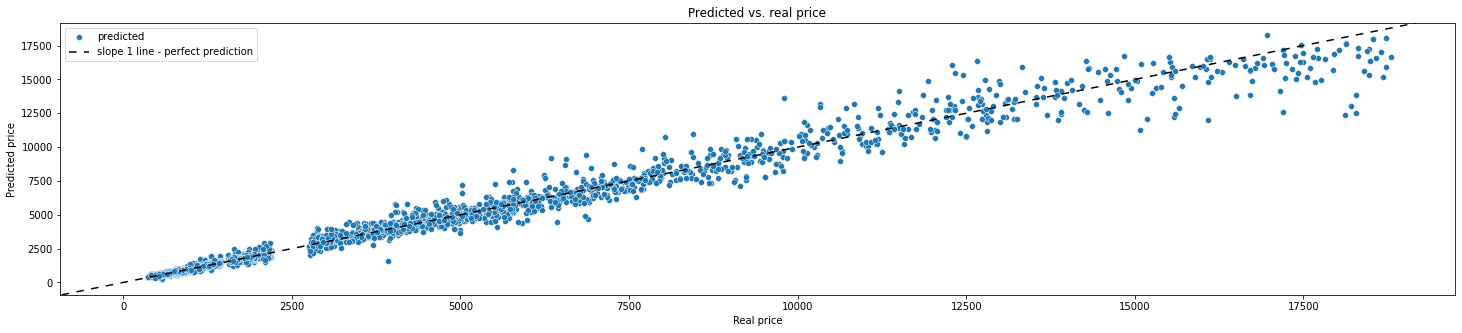

LGBMRegressor(bagging_fraction=0.7, feature_fraction=1, max_depth=8,
              min_data_in_leaf=10, num_iterations=150, num_leaves=20,
              objective='rmse', random_strength=2, reg_lambda=10)


In [52]:
# Define hyperparameters to tune and their possible ranges
param_dist = {'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5, 1],
              'num_iterations': [10, 20, 40, 50, 60, 75, 90, 100, 120, 150],
              'max_depth': [2, 5, 8, 12, 15],
              'num_leaves': [2, 10, 20, 35, 50],
              'reg_lambda': [5, 10, 15, 20, 30, 40, 50],
              'random_strength': [0.5, 0.75, 1, 1.25, 1.50, 1.75, 2],
              'min_data_in_leaf': [2, 10, 15, 25, 30],
              'feature_fraction': [0.5, 0.7, 0.9, 1],              
              'bagging_fraction': [0.5, 0.7, 0.9, 1]}

# Choose a method for tuning
random_search = RandomizedSearchCV(model_ltb, param_distributions=param_dist, n_iter=100,
                                   cv=8, scoring='neg_mean_squared_error', random_state=42)

# Perform hyperparameter tuning
random_search.fit(X_train, y_train, eval_set=[(X_test, y_test),(X_train, y_train)])

# Fit the model and evaluate the model
best_lgbm = random_search.best_estimator_
best_lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test),(X_train, y_train)])
model_metrics['LightGBM_tuned'] = metrics(best_lgbm)
print(metrics(best_lgbm))
plot_result(best_lgbm)
print(random_search.best_estimator_)

To avoid overfitting, best to use num_iteractions = 50.

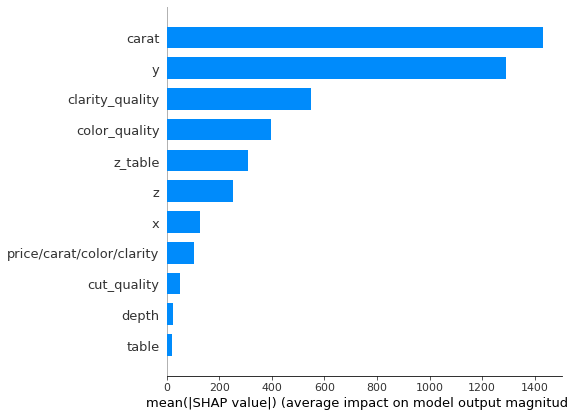

In [53]:
explainer = shap.TreeExplainer(best_lgbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar', feature_names=X_test.columns.tolist())

In [54]:
models_df = pd.DataFrame(model_metrics)
models_df

naive_model  Linear_regression  Random_forest    XGBoost   LightGBM  \
MSE   16580446.58         1329352.41      430186.62  346526.32  345096.44   
RMSE      4071.91            1152.98         655.89     588.66     587.45   
MAE       3104.28             769.00         360.30     308.40     309.11   
MAPE        77.41              19.18           8.99       7.69       7.71   
r2          -0.00               0.92           0.97       0.98       0.98   

      LightGBM_tuned  
MSE        352812.56  
RMSE          593.98  
MAE           312.51  
MAPE            7.79  
r2              0.98

#Config file and read_and_process function

create a Read and preprocess function to run full and/or new data and prepare to prediction.

In [67]:
config = {
    'data':{'training_file': '/content/gdrive/MyDrive/Data analysis - study/Diamonds/diamonds.csv',
            'chunksize': 10000
    },

    'parameters':{
        'max_depth': 15,
        'num_iterations': 60, #avoid overfitting
        'learning_rate': 0.1,
        'num_leaves':50,
        'random_state': 42,
        'reg_lambda': 20,
        'min_data_in_leaf': 15,
        'early_stopping_rounds': 50, #Avoid overfiting
    }       
}

In [56]:
def read_and_preprocess(config=config, filename=None):
  if filename==None:
    filename = config['data']['training_file']
  chunksize = config['data']['chunksize']
  with open(filename, 'r') as f:
    n_chunks = int((sum(1 for row in f))/chunksize)
    print('Number of chunks = ', n_chunks)
    df_iterator = pd.read_csv(filename, chunksize=chunksize)
    df = pd.DataFrame()
   
    
  for chunk in tqdm(df_iterator, total=(n_chunks)):
    min = 1
    max = 99
    x_min = np.percentile(chunk['x'], min)
    x_max = np.percentile(chunk['x'], max)
    y_min = np.percentile(chunk['y'], min)
    y_max = np.percentile(chunk['y'], max)
    z_min = np.percentile(chunk['z'], min)
    z_max = np.percentile(chunk['z'], max)

    chunk=chunk.drop(chunk[(chunk['x'] > x_max)].index)
    chunk=chunk.drop(chunk[(chunk['x'] < x_min)].index)
    chunk=chunk.drop(chunk[(chunk['y'] > y_max)].index)
    chunk=chunk.drop(chunk[(chunk['y'] < y_min)].index)
    chunk=chunk.drop(chunk[(chunk['z'] > z_max)].index)
    chunk=chunk.drop(chunk[(chunk['z'] < z_min)].index)
    chunk.reset_index()

    chunk['cut_quality'] = 0
    for index, row in tqdm(chunk.iterrows()):
      if row['cut'] == 'Fair':
        quality = 1
      elif row['cut'] == 'Good':
        quality = 2
      elif row['cut'] == 'Very Good':
        quality = 3
      elif row['cut'] == 'Premium':
        quality = 4
      else:
        quality = 5
      chunk.at[index, 'cut_quality'] = quality
        
    chunk['clarity_quality'] = 0
    for index, row in tqdm(chunk.iterrows()):
      if row['clarity'] == 'I1':
        quality = 1
      elif row['clarity'] == 'SI2':
        quality = 2
      elif row['clarity'] == 'SI1':
        quality = 3
      elif row['clarity'] == 'VS2':
        quality = 4
      elif row['clarity'] == 'VS1':
        quality = 5
      elif row['clarity'] == 'VVS2':
        quality = 6
      elif row['clarity'] == 'VVS1':
        quality = 7
      else:
        quality = 8
      chunk.at[index, 'clarity_quality'] = quality
    chunk = chunk.drop(['cut', 'clarity'], axis='columns')
   # def price_carat_color_and_clarity (color_type, clarity_type):                      # Excluded this variable because it causes a disturbance on the model with full data.
   #   new_df = chunk.query(f'color == "{color_type}"')
   #   new_df2 = new_df.query(f'clarity_quality == {clarity_type}')
   #   price_carat_color_clarity = round((new_df2['price'].sum())/new_df2['carat'].sum(), 2)
   #   return(price_carat_color_clarity)

    #chunk['price/carat/color/clarity'] = chunk.apply(lambda row: price_carat_color_and_clarity(color_type=row['color'], clarity_type=row['clarity_quality']), axis=1)
    #chunk['ccc_mean_price_carat'] = chunk['carat']*chunk['price/carat/color/clarity']
    #chunk = chunk.drop(['price/carat/color/clarity'], axis='columns')

    chunk['z_table'] = chunk['z']/chunk['table']

    chunk['color_quality'] = 0
    for index, row in tqdm(chunk.iterrows()):
      if row['color'] == 'J':
        quality = 1
      elif row['color'] == 'I':
        quality = 2
      elif row['color'] == 'H':
        quality = 3
      elif row['color'] == 'G':
        quality = 4
      elif row['color'] == 'F':
        quality = 5
      elif row['color'] == 'E':
        quality = 6
      elif row['color'] == 'D':
        quality = 7

      chunk.at[index, 'color_quality'] = quality
    chunk = chunk.drop(['color'], axis='columns')

    chunk = chunk.reset_index(drop=True)

    df=  pd.concat([df, chunk])
  df = df.drop(df.columns[0], axis='columns')
  return df.reset_index(drop=True)

In [57]:
df1 = read_and_preprocess()

Number of chunks =  5


  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1096it [00:00, 10957.45it/s]
2192it [00:00, 10372.37it/s]
3232it [00:00, 10363.62it/s]
4284it [00:00, 10421.84it/s]
5420it [00:00, 10755.31it/s]
6497it [00:00, 10670.48it/s]
7649it [00:00, 10941.48it/s]
9718it [00:00, 10787.50it/s]

0it [00:00, ?it/s]
1167it [00:00, 11666.20it/s]
2334it [00:00, 11479.60it/s]
3483it [00:00, 11053.54it/s]
4590it [00:00, 10608.74it/s]
5654it [00:00, 10418.46it/s]
6698it [00:00, 10320.09it/s]
7797it [00:00, 10529.71it/s]
9718it [00:00, 10789.67it/s]

0it [00:00, ?it/s]
988it [00:00, 9874.48it/s]
2087it [00:00, 10527.86it/s]
3140it [00:00, 10107.49it/s]
4174it [00:00, 10196.68it/s]
5237it [00:00, 10350.26it/s]
6274it [00:00, 10078.99it/s]
7341it [00:00, 10264.94it/s]
8370it [00:00, 10245.05it/s]
9718it [00:00, 10146.63it/s]
 20%|██        | 1/5 [00:02<00:11,  2.82s/it]
0it [00:00, ?it/s]
1197it [00:00, 11969.44it/s]
2394it [00:00, 11792.00it/s]
3574it [00:00, 11783.55it/s]
4753it [00:00, 11719.15it/s]

Train the best model with full data

Found `num_iterations` in params. Will use it instead of argument


[1]	training's rmse: 3609.59	valid_0's rmse: 3586.62
[2]	training's rmse: 3277.47	valid_0's rmse: 3255.66
[3]	training's rmse: 2978.15	valid_0's rmse: 2958.38
[4]	training's rmse: 2711.33	valid_0's rmse: 2692.76
[5]	training's rmse: 2470	valid_0's rmse: 2453.35
[6]	training's rmse: 2254.67	valid_0's rmse: 2239.94
[7]	training's rmse: 2061.51	valid_0's rmse: 2048.04
[8]	training's rmse: 1888.61	valid_0's rmse: 1876.61
[9]	training's rmse: 1734.09	valid_0's rmse: 1722.74
[10]	training's rmse: 1595.68	valid_0's rmse: 1585.22
[11]	training's rmse: 1471.87	valid_0's rmse: 1461.9
[12]	training's rmse: 1361.33	valid_0's rmse: 1352.53
[13]	training's rmse: 1262.92	valid_0's rmse: 1254.88
[14]	training's rmse: 1175.3	valid_0's rmse: 1168.58
[15]	training's rmse: 1097.25	valid_0's rmse: 1091.55
[16]	training's rmse: 1027.36	valid_0's rmse: 1021.74
[17]	training's rmse: 965.158	valid_0's rmse: 960.849
[18]	training's rmse: 910.995	valid_0's rmse: 907.507
[19]	training's rmse: 862.843	valid_0's rm

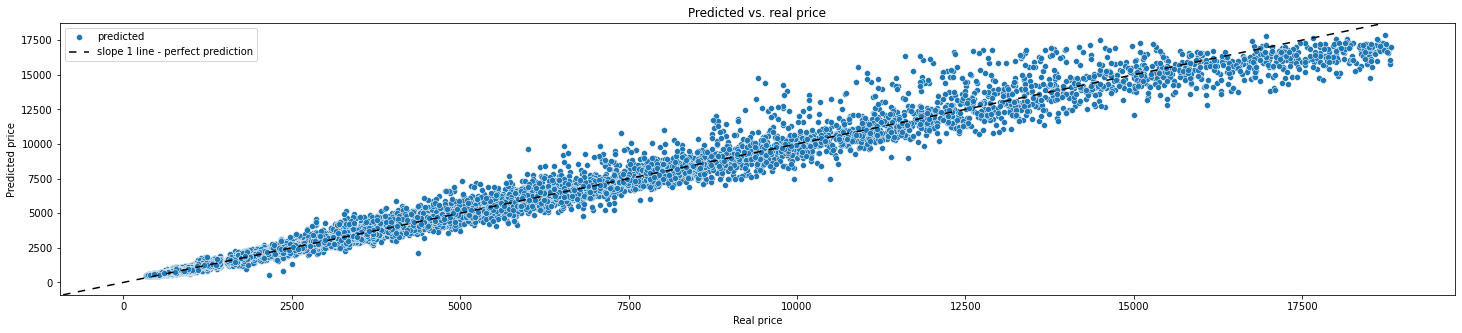

In [68]:
x = df1.drop(['price'], axis = 1)
y = df1['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=44)

model_ltb_best = ltb.LGBMRegressor(
    objective='rmse',
    num_iterations=config['parameters']['num_iterations'],
    max_depth=config['parameters']['max_depth'],
    learning_rate=config['parameters']['learning_rate'],
    num_leaves=config['parameters']['num_leaves'],
    random_state=config['parameters']['random_state'],
    reg_lambda=config['parameters']['reg_lambda'],
    min_child_samples=config['parameters']['min_data_in_leaf'], 
)
model_ltb_best.fit(X_train, y_train, eval_set=[(X_test, y_test),(X_train, y_train)])
model_metrics['LightGBM_best_fullData'] = metrics(model_ltb_best)
print(metrics(model_ltb_best))
plot_result(model_ltb_best)

Ploting learning curve to verify overfitting

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

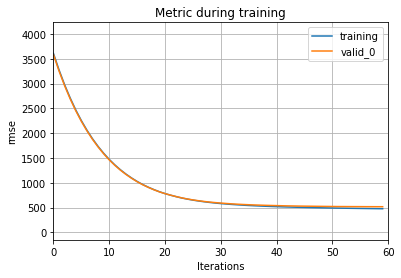

In [69]:
ltb.plot_metric(model_ltb_best)

In [61]:
models_df = pd.DataFrame(model_metrics)
models_df

naive_model  Linear_regression  Random_forest    XGBoost   LightGBM  \
MSE   16580446.58         1329352.41      430186.62  346526.32  345096.44   
RMSE      4071.91            1152.98         655.89     588.66     587.45   
MAE       3104.28             769.00         360.30     308.40     309.11   
MAPE        77.41              19.18           8.99       7.69       7.71   
r2          -0.00               0.92           0.97       0.98       0.98   

      LightGBM_tuned  LightGBM_best_fullData  
MSE        352812.56               273762.66  
RMSE          593.98                  523.22  
MAE           312.51                  282.65  
MAPE            7.79                    7.21  
r2              0.98                    0.98

In [62]:
#saving the model:
import pickle
filename = "Diamonds_model_VF.pkl"
with open(filename, 'wb') as file:
  pickle.dump(model_ltb_best, file)

In [63]:
#for loading the model in the future, we can use:

with open ('Diamonds_model_VF.pkl', 'rb') as f:
  model = pickle.load(f)

#CONCLUSION

The fitted model with the full data presented a MAPE of 7.06%. 
The value is good compared to naive and simple linear models, however, it can be enhanced with more data (specially for high price diamonds), and more informations, such as the format, origin, and company selling the products.

During EDA, a variable called price/carat/cut/clarity was calculated, however, as it included average price (the objective variable), it generated a disturbance in the model fitted with the entire dataset. Therefore, this variable was excluded from the final model.